In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [ ]:
!pip install ydata_synthetic

In [ ]:
import importlib
import sys  

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers.regular import VanilllaGAN,WGAN,WGAN_GP,CGAN
from ydata_synthetic.preprocessing.regular.credit_fraud import *

model_1 = VanilllaGAN
model_2 = WGAN
model_3 = WGAN_GP
model_4 = CGAN

In [ ]:
pip install openpyxl==2.6.0

In [ ]:
#Read the original data and have it preprocessed
#hci_data = pd.read_excel('/content/drive/MyDrive/HCI_Data_GAN.xlsx')
hci_data = pd.read_excel('HCI_Data_GAN.xlsx')
print(hci_data.shape)

(252, 18)


In [ ]:
hci_data=hci_data.drop(columns=['S. No','Decision Date','Application Date'])
hci_data['University_Program']=hci_data.University+' '+hci_data.Programme
hci_data.University=hci_data.University_Program
hci_data=hci_data.drop(columns=['Programme','University_Program','Year of Entry'])

#Label Encoding 

le1 = preprocessing.LabelEncoder() #Decision
le2 = preprocessing.LabelEncoder() #Research Experience
le3 = preprocessing.LabelEncoder() #Submitted Portfolio
le4 = preprocessing.LabelEncoder() #Student Status
le5 = preprocessing.LabelEncoder() #University

hci_data['Decision'] = le1.fit_transform(hci_data['Decision']) ### 0-Accepted, 1-Rejected
hci_data['Research Experience'] = le2.fit_transform(hci_data['Research Experience']) ###1-Yes, 0-No
hci_data['Submitted Portfolio'] = le3.fit_transform(hci_data['Submitted Portfolio']) ###1-Yes, 0-No
hci_data['Student Status'] = le4.fit_transform(hci_data['Student Status']) ### 0-Domestic, 1-International, 2-Undergrad domestic

hci_data['GRE']=hci_data['GRE'].fillna(330)
hci_data['TOEFL']=hci_data['TOEFL'].fillna(120)

In [ ]:
print(hci_data.head())

            University  CGPA    GRE  ...  THE Rank  QS Rank  Decision
0  Georgia Tech MS HCI   3.8  330.0  ...        38       70         1
1  Georgia Tech MS HCI   3.5  330.0  ...        38       70         1
2  Georgia Tech MS HCI   3.2  330.0  ...        38       70         1
3  Georgia Tech MS HCI   2.7  320.0  ...        38       70         1
4  Georgia Tech MS HCI   3.6  320.0  ...        38       70         1

[5 rows x 13 columns]


In [ ]:
#Label Encoding University
hci_data['University'] = le5.fit_transform(hci_data['University']) ### 0-Accepted, 1-Rejected
print(hci_data)

     University  CGPA    GRE  TOEFL  ...  Class Size  THE Rank  QS Rank  Decision
0             1  3.80  330.0  117.0  ...          52        38       70         1
1             1  3.50  330.0  112.0  ...          52        38       70         1
2             1  3.20  330.0  120.0  ...          52        38       70         1
3             1  2.70  320.0  113.0  ...          52        38       70         1
4             1  3.60  320.0  120.0  ...          52        38       70         1
..          ...   ...    ...    ...  ...         ...       ...      ...       ...
247           0  3.92  322.0  120.0  ...          60        28       51         0
248           0  3.70  324.0  120.0  ...          60        28       51         0
249           0  3.80  320.0  120.0  ...          60        28       51         0
250           0  3.80  325.0  120.0  ...          60        28       51         0
251           0  3.60  318.0  120.0  ...          60        28       51         0

[252 rows x 13 

In [ ]:
hci_data['University'].unique()

array([ 1, 10,  9,  7,  8,  2,  4,  3,  5,  6,  0])

In [ ]:
data=hci_data

In [ ]:
#splitting target column
data_cols = list(data.columns[ data.columns != 'Decision' ])
label_cols = ['Decision']

In [ ]:
data_cols

['University',
 'CGPA',
 'GRE',
 'TOEFL',
 'Work Experience',
 'Research Experience',
 'Research Papers',
 'Submitted Portfolio',
 'Student Status',
 'Class Size',
 'THE Rank',
 'QS Rank']

In [ ]:
label_cols

['Decision']

In [ ]:
#Before training the GAN do not forget to apply the required data transformations
#To ease here we've applied a PowerTransformation
# data = transformations(data)

#For the purpose of this example we will only synthesize the minority class

## REJECTIONS ###

train_data = data.loc[ data['Decision']==1 ].copy()

print("Dataset info: Number of records - {} Number of varibles - {}".format(train_data.shape[0], train_data.shape[1]))


Dataset info: Number of records - 110 Number of varibles - 13


In [ ]:
train_data.columns

Index(['University', 'CGPA', 'GRE', 'TOEFL', 'Work Experience',
       'Research Experience', 'Research Papers', 'Submitted Portfolio',
       'Student Status', 'Class Size', 'THE Rank', 'QS Rank', 'Decision'],
      dtype='object')

In [ ]:
algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_data[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train_data.copy()
fraud_w_classes['Class'] = labels

   count
0     90
1     20


In [ ]:
# Define some custom metric functions for use with the xgboost algorithm

from sklearn.metrics import recall_score, precision_score, roc_auc_score,confusion_matrix

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [ ]:
test_cols = data.columns

In [ ]:
# Set up the test and train sets
import xgboost as xgb
np.random.seed(0)

n_real = np.sum(hci_data.Decision==0) # Number of accepted   
n_test = np.sum(hci_data.Decision==1) # Rejected
train_fraction = 0.7
fn_real = int(n_real * train_fraction) #70% of accepted 
fn_test = int(n_test * train_fraction) #70% of rejected

real_samples = data.loc[hci_data.Decision==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[hci_data.Decision==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

classes 0, 1:  142 110
train, test:  176 76


In [ ]:
print(test_df)

    University  CGPA    GRE  TOEFL  ...  Class Size  THE Rank  QS Rank  Decision
0            7   3.5  330.0  120.0  ...         450        22       21         0
1            3   3.7  320.0  107.0  ...          35       650      760         0
2            8   3.3  330.0  102.0  ...          50        31       67         0
3            6   3.4  317.0  105.0  ...          35        90      152         0
4            2   3.6  330.0  105.0  ...          45       140      320         0
..         ...   ...    ...    ...  ...         ...       ...      ...       ...
71           9   3.6  330.0  120.0  ...          30        29       72         1
72           4   3.0  330.0   99.0  ...          22       227      430         1
73           0   3.7  324.0  105.0  ...          60        28       51         1
74           8   3.0  330.0   99.0  ...          50        31       67         1
75           7   3.0  330.0  104.0  ...         450        22       21         1

[76 rows x 13 columns]


In [ ]:
test_df.columns[-1]

'Decision'

In [ ]:
# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['Decision'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
print(confusion_matrix( np.round(y_pred), y_true))

best iteration:  27
('recall', 0.7272727272727273)
('precision', 0.6666666666666666)
('roc_auc', 0.7519379844961239)
[[31  9]
 [12 24]]


# Training GAN on Rejections

In [ ]:
#Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

train_sample = fraud_w_classes.copy().reset_index(drop=True)
train_sample = pd.get_dummies(train_sample, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train_sample.columns if 'Class' in i ]
data_cols = [ i for i in train_sample.columns if i not in label_cols ]
train_sample[ data_cols ] = train_sample[ data_cols ] #/ 10 # scale to random noise size, one less thing to learn
train_no_label = train_sample[ data_cols ]

gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, train_no_label.shape[1], dim]
train_args = ['', epochs, log_step]

### Vanilla GAN

In [ ]:
#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer_1 = model_1(gan_args)
synthesizer_1.train(train_no_label, train_args)
synthesizer_1.save(path='cache/wgan_creditcard.pkl')

Streaming output truncated to the last 5000 lines.
51 [D loss: 0.498055, acc.: 53.91%] [G loss: 0.783988]
52 [D loss: 0.984581, acc.: 37.50%] [G loss: 0.332765]
53 [D loss: 0.676514, acc.: 50.00%] [G loss: 0.455027]
54 [D loss: 0.509489, acc.: 51.95%] [G loss: 0.649862]
55 [D loss: 0.660556, acc.: 44.92%] [G loss: 0.502916]
56 [D loss: 0.562895, acc.: 49.61%] [G loss: 0.598012]
57 [D loss: 0.601961, acc.: 48.83%] [G loss: 0.559461]
58 [D loss: 0.567381, acc.: 50.00%] [G loss: 0.600734]
59 [D loss: 0.558188, acc.: 48.05%] [G loss: 0.653180]
60 [D loss: 0.640597, acc.: 47.27%] [G loss: 0.525807]
61 [D loss: 0.510242, acc.: 51.56%] [G loss: 0.650580]
62 [D loss: 0.553407, acc.: 50.00%] [G loss: 0.622359]
63 [D loss: 0.590778, acc.: 48.05%] [G loss: 0.554643]
64 [D loss: 0.544002, acc.: 50.78%] [G loss: 0.613993]
65 [D loss: 0.654842, acc.: 43.75%] [G loss: 0.518535]
66 [D loss: 0.563733, acc.: 50.00%] [G loss: 0.637261]
67 [D loss: 0.636974, acc.: 46.48%] [G loss: 0.546331]
68 [D loss: 0.

In [ ]:
def PlotData( x, g_z, data_cols, label_cols=[], seed=0, with_class=False, data_dim=2, save=False, prefix='' ):
    
    real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    if with_class:
        axarr[0].scatter( real_samples[data_cols[0]], real_samples[data_cols[1]], c=real_samples[label_cols[0]]/2 ) #, cmap='plasma'  )
        axarr[1].scatter( gen_samples[ data_cols[0]], gen_samples[ data_cols[1]], c=gen_samples[label_cols[0]]/2 ) #, cmap='plasma'  )
        
        # For when there are multiple one-hot encoded label columns
        # for i in range(len(label_cols)):
            # temp = real_samples.loc[ real_samples[ label_cols[i] ] == 1 ]
            # axarr[0].scatter( temp[data_cols[0]], temp[data_cols[1]], c='C'+str(i), label=i )
            # temp = gen_samples.loc[ gen_samples[ label_cols[i] ] == 1 ]
            # axarr[1].scatter( temp[data_cols[0]], temp[data_cols[1]], c='C'+str(i), label=i )
        
    else:
        axarr[0].scatter( real_samples[data_cols[0]], real_samples[data_cols[1]]) #, cmap='plasma'  )
        axarr[1].scatter( gen_samples[data_cols[0]], gen_samples[data_cols[1]]) #, cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[1].set_title('generated')   
    axarr[0].set_ylabel(data_cols[1]) # Only add y label to left plot
    for a in axarr: a.set_xlabel(data_cols[0]) # Add x label to both plots
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim()) # Use axes ranges from real data for generated data
    
    if save:
        plt.save( prefix + '.xgb_check.png' )
        
    plt.show()

In [ ]:
models = {'GAN': ['GAN', False, synthesizer_1.generator]}

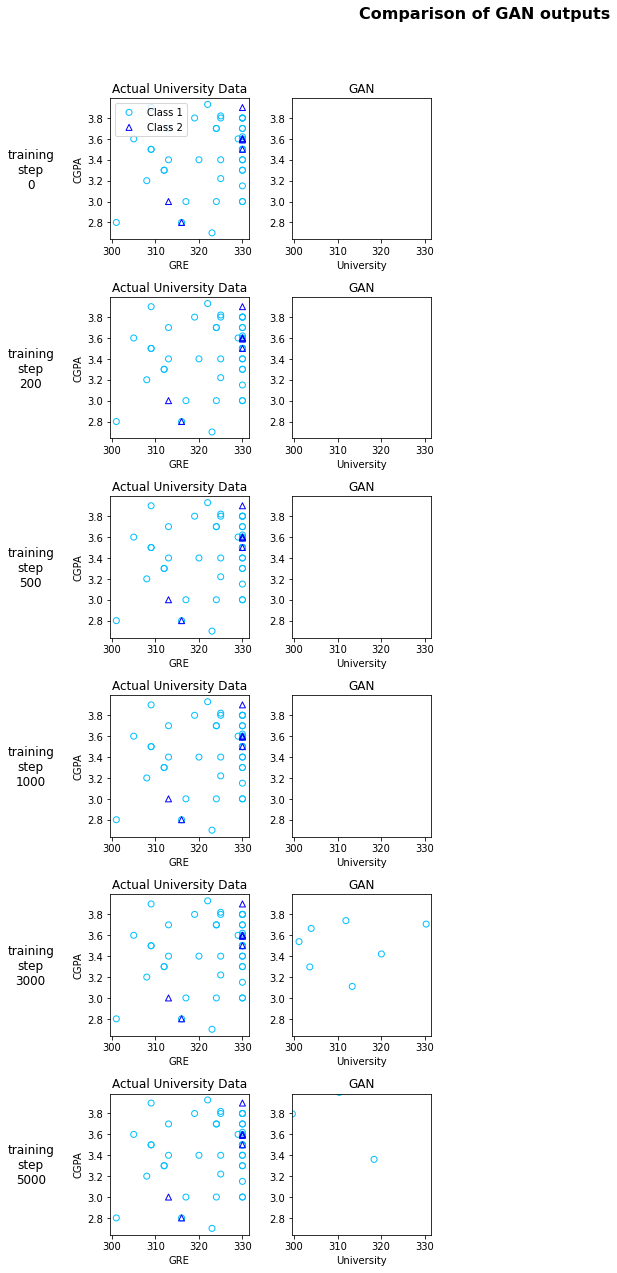

In [ ]:
# Setup parameters visualization parameters
seed = 17
test_size = 50 # number of fraud cases REJECTIONS
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer_1.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols+label_cols)
labels = fraud_w_classes['Class'] ### -->Decision

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'GRE', 'CGPA'

base_dir = 'cache/'

#Actual fraud data visualization
model_steps = [ 0, 200, 500,1000,3000,5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual University Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            gen_samples.to_csv('Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')


In [ ]:
gen_df=pd.read_csv('Generated_sample.csv')
gen_df

,Unnamed: 0,University,CGPA,GRE,TOEFL,Work Experience,Research Experience,Research Papers,Submitted Portfolio,Student Status,THE Rank,QS Rank,Decision
0,0,0.322058,3.899945,279.28973,99.876160,0.792815,0.494077,0.870834,0.942014,0.676204,31.873793,60.213460,1.485088
1,1,0.879084,2.966198,242.52641,87.194330,-0.084074,0.605864,0.535576,1.250798,1.330147,27.779577,55.814150,1.003474
2,2,8.772494,4.290513,326.62766,107.871550,3.341589,0.341853,0.768974,0.815075,1.227528,29.699034,71.394260,1.667826
3,3,9.699003,4.012299,340.12677,126.628770,1.160821,1.104778,1.067310,1.011883,0.187260,30.142654,77.174500,1.473687
4,4,0.145838,3.543475,282.51495,90.166120,1.422055,0.865250,1.790226,1.469270,0.817423,33.214120,60.183550,1.461879
5,5,7.460751,3.568516,257.49112,92.810080,0.148128,0.248321,0.588479,0.553015,2.030306,22.265272,57.289787,1.262984
6,6,0.637826,5.719027,420.26624,152.202000,0.231040,0.801087,0.823830,1.905329,3.468168,49.984318,92.669174,2.258466
7,7,10.284310,4.621622,359.62088,125.880720,6.279750,0.280816,0.896971,1.445866,1.849802,30.670382,78.763275,1.994913
8,8,1.015984,5.774247,454.38974,163.224240,1.643023,1.275601,0.941100,1.279626,1.579160,53.838757,97.237045,2.181076
9,9,0.782852,5.741127,418.71670,147.875890,0.019546,0.732909,0.985823,2.016764,1.478977,48.950280,90.402830,2.292383


In [ ]:
uni_bins=[0,1,2,3,4,5,6,7,8,9,10]
uni=gen_df.University

In [ ]:
uni_array=np.digitize(np.array(uni), uni_bins)-1
uni_array
uni_array=le5.inverse_transform(uni_array)

In [ ]:
gen_df['University']=uni_array

In [ ]:
gen_df.head()

,Unnamed: 0,University,CGPA,GRE,TOEFL,Work Experience,Research Experience,Research Papers,Submitted Portfolio,Student Status,THE Rank,QS Rank,Decision
0,0,Carnegie Mellon MHCI,3.899945,279.28973,99.87616,0.792815,0,0.870834,0.942014,0.676204,31.873793,60.21346,1.485088
1,1,Carnegie Mellon MHCI,2.966198,242.52641,87.19433,-0.084074,1,0.535576,1.250798,1.330147,27.779577,55.81415,1.003474
2,2,University of Texas Austin MSIS,4.290513,326.62766,107.87155,3.341589,0,0.768974,0.815075,1.227528,29.699034,71.39426,1.667826
3,3,University of Washington MHCID,4.012299,340.12677,126.62877,1.160821,1,1.067310,1.011883,0.187260,30.142654,77.17450,1.473687
4,4,Carnegie Mellon MHCI,3.543475,282.51495,90.16612,1.422055,1,1.790226,1.469270,0.817423,33.214120,60.18355,1.461879


In [ ]:
gen_df['Research Experience']=np.round(gen_df['Research Experience']).astype(int)

In [ ]:
gen_df.to_csv('Rejects_VanillaGAN.csv')

# WGAN_GP

In [ ]:
#Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

train_sample = fraud_w_classes.copy().reset_index(drop=True)
train_sample = pd.get_dummies(train_sample, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train_sample.columns if 'Class' in i ]
data_cols = [ i for i in train_sample.columns if i not in label_cols ]
train_sample[ data_cols ] = train_sample[ data_cols ] #/ 10 # scale to random noise size, one less thing to learn
train_no_label = train_sample[ data_cols ]

gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, train_no_label.shape[1], dim]
train_args = ['', epochs, log_step]

seed = 17
test_size = 492 
noise_dim = 32

#Training the WGAN_GP model
synthesizer_3 = model_3(gan_args, n_critic=2)
synthesizer_3.train(train_no_label, train_args)


  0%|          | 4/5001 [00:01<1:27:43,  1.05s/it]

Iteration: 0 | disc_loss: -36.43220520019531 | gen_loss: -0.02175169251859188
Iteration: 1 | disc_loss: -59.008419036865234 | gen_loss: -0.0783080905675888
Iteration: 2 | disc_loss: -63.027915954589844 | gen_loss: -0.1543806493282318
Iteration: 3 | disc_loss: -65.64903259277344 | gen_loss: -0.2198072075843811



  0%|          | 9/5001 [00:01<44:58,  1.85it/s]  

Iteration: 4 | disc_loss: -65.8792724609375 | gen_loss: -0.30116719007492065
Iteration: 5 | disc_loss: -65.2454833984375 | gen_loss: -0.41547077894210815
Iteration: 6 | disc_loss: -64.67826843261719 | gen_loss: -0.5133203268051147
Iteration: 7 | disc_loss: -64.57769775390625 | gen_loss: -0.6513255834579468
Iteration: 8 | disc_loss: -65.64936828613281 | gen_loss: -0.802350640296936



  0%|          | 12/5001 [00:01<32:33,  2.55it/s]

Iteration: 9 | disc_loss: -65.64850616455078 | gen_loss: -1.0161292552947998
Iteration: 10 | disc_loss: -65.79014587402344 | gen_loss: -1.1427905559539795
Iteration: 11 | disc_loss: -65.5872573852539 | gen_loss: -1.4250590801239014
Iteration: 12 | disc_loss: -64.43064880371094 | gen_loss: -1.6160848140716553
Iteration: 13 | disc_loss: -64.47598266601562 | gen_loss: -1.8172744512557983



  0%|          | 18/5001 [00:02<17:50,  4.65it/s]

Iteration: 14 | disc_loss: -64.7671127319336 | gen_loss: -2.295154094696045
Iteration: 15 | disc_loss: -64.04658508300781 | gen_loss: -2.693681240081787
Iteration: 16 | disc_loss: -63.36841583251953 | gen_loss: -2.8961477279663086
Iteration: 17 | disc_loss: -63.267391204833984 | gen_loss: -3.2117693424224854
Iteration: 18 | disc_loss: -63.19902801513672 | gen_loss: -3.554239511489868



  0%|          | 24/5001 [00:02<10:38,  7.80it/s]

Iteration: 19 | disc_loss: -62.16996765136719 | gen_loss: -4.339816093444824
Iteration: 20 | disc_loss: -61.60470199584961 | gen_loss: -4.850687026977539
Iteration: 21 | disc_loss: -61.29104232788086 | gen_loss: -5.226235389709473
Iteration: 22 | disc_loss: -61.04201126098633 | gen_loss: -6.1081953048706055
Iteration: 23 | disc_loss: -60.0001220703125 | gen_loss: -6.865302085876465



  1%|          | 27/5001 [00:02<08:33,  9.69it/s]

Iteration: 24 | disc_loss: -59.12394714355469 | gen_loss: -7.778031349182129
Iteration: 25 | disc_loss: -58.829627990722656 | gen_loss: -8.042688369750977
Iteration: 26 | disc_loss: -57.460391998291016 | gen_loss: -8.739998817443848
Iteration: 27 | disc_loss: -57.037750244140625 | gen_loss: -9.891046524047852
Iteration: 28 | disc_loss: -55.700653076171875 | gen_loss: -10.659915924072266



  1%|          | 33/5001 [00:02<06:13, 13.29it/s]

Iteration: 29 | disc_loss: -54.20542907714844 | gen_loss: -11.197420120239258
Iteration: 30 | disc_loss: -53.903812408447266 | gen_loss: -11.962387084960938
Iteration: 31 | disc_loss: -52.42271041870117 | gen_loss: -12.031473159790039
Iteration: 32 | disc_loss: -51.41783142089844 | gen_loss: -13.927714347839355
Iteration: 33 | disc_loss: -50.1324577331543 | gen_loss: -14.45389175415039



  1%|          | 39/5001 [00:03<04:55, 16.77it/s]

Iteration: 34 | disc_loss: -49.367645263671875 | gen_loss: -16.159189224243164
Iteration: 35 | disc_loss: -48.14830017089844 | gen_loss: -16.537948608398438
Iteration: 36 | disc_loss: -46.98972702026367 | gen_loss: -16.813949584960938
Iteration: 37 | disc_loss: -45.45998764038086 | gen_loss: -16.817819595336914
Iteration: 38 | disc_loss: -44.6911735534668 | gen_loss: -17.152854919433594



  1%|          | 42/5001 [00:03<04:40, 17.65it/s]

Iteration: 39 | disc_loss: -42.4593391418457 | gen_loss: -18.90127182006836
Iteration: 40 | disc_loss: -42.019691467285156 | gen_loss: -19.500478744506836
Iteration: 41 | disc_loss: -40.17314529418945 | gen_loss: -18.719623565673828
Iteration: 42 | disc_loss: -39.22823715209961 | gen_loss: -21.07489776611328
Iteration: 43 | disc_loss: -37.88587188720703 | gen_loss: -19.296043395996094



  1%|          | 48/5001 [00:03<04:16, 19.27it/s]

Iteration: 44 | disc_loss: -37.1984977722168 | gen_loss: -21.440439224243164
Iteration: 45 | disc_loss: -34.343318939208984 | gen_loss: -18.08179473876953
Iteration: 46 | disc_loss: -35.07542419433594 | gen_loss: -20.863407135009766
Iteration: 47 | disc_loss: -33.71526336669922 | gen_loss: -21.014039993286133



  1%|          | 51/5001 [00:03<04:12, 19.58it/s]

Iteration: 48 | disc_loss: -32.709957122802734 | gen_loss: -20.325319290161133
Iteration: 49 | disc_loss: -32.393348693847656 | gen_loss: -19.884042739868164
Iteration: 50 | disc_loss: -29.889068603515625 | gen_loss: -19.842905044555664
Iteration: 51 | disc_loss: -30.236404418945312 | gen_loss: -16.21874237060547
Iteration: 52 | disc_loss: -28.064653396606445 | gen_loss: -17.99243927001953



  1%|          | 57/5001 [00:04<03:59, 20.68it/s]

Iteration: 53 | disc_loss: -27.346311569213867 | gen_loss: -14.960997581481934
Iteration: 54 | disc_loss: -27.641613006591797 | gen_loss: -15.642744064331055
Iteration: 55 | disc_loss: -26.783721923828125 | gen_loss: -13.492708206176758
Iteration: 56 | disc_loss: -25.826457977294922 | gen_loss: -12.414661407470703
Iteration: 57 | disc_loss: -24.987836837768555 | gen_loss: -10.071601867675781



  1%|▏         | 63/5001 [00:04<03:54, 21.08it/s]

Iteration: 58 | disc_loss: -25.042633056640625 | gen_loss: -14.93429946899414
Iteration: 59 | disc_loss: -23.66343116760254 | gen_loss: -7.957366466522217
Iteration: 60 | disc_loss: -22.902599334716797 | gen_loss: -6.799994468688965
Iteration: 61 | disc_loss: -23.234277725219727 | gen_loss: -12.285306930541992
Iteration: 62 | disc_loss: -22.46531105041504 | gen_loss: -8.68016529083252



  1%|▏         | 66/5001 [00:04<03:50, 21.38it/s]

Iteration: 63 | disc_loss: -21.71315574645996 | gen_loss: -7.631989002227783
Iteration: 64 | disc_loss: -21.095916748046875 | gen_loss: -3.8106064796447754
Iteration: 65 | disc_loss: -20.883480072021484 | gen_loss: -9.115836143493652
Iteration: 66 | disc_loss: -20.22793197631836 | gen_loss: -0.7815651893615723
Iteration: 67 | disc_loss: -19.768619537353516 | gen_loss: -5.8862199783325195



  1%|▏         | 72/5001 [00:04<03:53, 21.14it/s]

Iteration: 68 | disc_loss: -19.813491821289062 | gen_loss: -4.08452033996582
Iteration: 69 | disc_loss: -19.26667594909668 | gen_loss: -9.812631607055664
Iteration: 70 | disc_loss: -19.53881072998047 | gen_loss: -3.7144110202789307
Iteration: 71 | disc_loss: -17.6932373046875 | gen_loss: -2.692852020263672



  2%|▏         | 78/5001 [00:05<03:47, 21.61it/s]

Iteration: 72 | disc_loss: -17.626007080078125 | gen_loss: 1.5001087188720703
Iteration: 73 | disc_loss: -17.709484100341797 | gen_loss: -4.166857719421387
Iteration: 74 | disc_loss: -17.386451721191406 | gen_loss: -2.7977139949798584
Iteration: 75 | disc_loss: -17.731327056884766 | gen_loss: -0.48330071568489075
Iteration: 76 | disc_loss: -17.230051040649414 | gen_loss: -3.790560007095337
Iteration: 77 | disc_loss: -18.124095916748047 | gen_loss: 0.3564167618751526



  2%|▏         | 81/5001 [00:05<03:50, 21.37it/s]

Iteration: 78 | disc_loss: -17.145191192626953 | gen_loss: 0.9352328777313232
Iteration: 79 | disc_loss: -18.665557861328125 | gen_loss: -2.3613734245300293
Iteration: 80 | disc_loss: -16.995452880859375 | gen_loss: 2.3179094791412354
Iteration: 81 | disc_loss: -17.166227340698242 | gen_loss: -0.4862130880355835
Iteration: 82 | disc_loss: -17.487464904785156 | gen_loss: -4.443375587463379



  2%|▏         | 87/5001 [00:05<03:45, 21.80it/s]

Iteration: 83 | disc_loss: -17.760425567626953 | gen_loss: 0.23475563526153564
Iteration: 84 | disc_loss: -16.663463592529297 | gen_loss: -0.6404452323913574
Iteration: 85 | disc_loss: -17.495235443115234 | gen_loss: 0.3062250018119812
Iteration: 86 | disc_loss: -17.450931549072266 | gen_loss: -1.792572021484375
Iteration: 87 | disc_loss: -17.838468551635742 | gen_loss: 1.6969901323318481



  2%|▏         | 93/5001 [00:05<03:42, 22.04it/s]

Iteration: 88 | disc_loss: -17.963455200195312 | gen_loss: 2.2320332527160645
Iteration: 89 | disc_loss: -17.228492736816406 | gen_loss: -1.4974086284637451
Iteration: 90 | disc_loss: -17.07135009765625 | gen_loss: -0.9989272356033325
Iteration: 91 | disc_loss: -16.602863311767578 | gen_loss: -0.7711774110794067
Iteration: 92 | disc_loss: -17.937183380126953 | gen_loss: 2.0421977043151855



  2%|▏         | 96/5001 [00:05<03:51, 21.21it/s]

Iteration: 93 | disc_loss: -16.507797241210938 | gen_loss: -0.879210352897644
Iteration: 94 | disc_loss: -17.364898681640625 | gen_loss: -2.465545654296875
Iteration: 95 | disc_loss: -16.70269012451172 | gen_loss: -1.7952136993408203
Iteration: 96 | disc_loss: -17.18405532836914 | gen_loss: 5.282412528991699
Iteration: 97 | disc_loss: -16.118560791015625 | gen_loss: -2.924619674682617



  2%|▏         | 102/5001 [00:06<04:01, 20.30it/s]

Iteration: 98 | disc_loss: -16.64922523498535 | gen_loss: 1.5851895809173584
Iteration: 99 | disc_loss: -17.407865524291992 | gen_loss: 0.37047630548477173
Iteration: 100 | disc_loss: -16.0032958984375 | gen_loss: -2.518763780593872
Iteration: 101 | disc_loss: -17.32937240600586 | gen_loss: 5.104410171508789



  2%|▏         | 105/5001 [00:06<03:56, 20.68it/s]

Iteration: 102 | disc_loss: -16.406715393066406 | gen_loss: -2.5050101280212402
Iteration: 103 | disc_loss: -17.578472137451172 | gen_loss: -1.1007225513458252
Iteration: 104 | disc_loss: -17.34790802001953 | gen_loss: 3.0328569412231445
Iteration: 105 | disc_loss: -17.073959350585938 | gen_loss: -0.2635239362716675
Iteration: 106 | disc_loss: -16.72307014465332 | gen_loss: -2.8749542236328125



  2%|▏         | 111/5001 [00:06<03:47, 21.48it/s]

Iteration: 107 | disc_loss: -16.756210327148438 | gen_loss: 2.559680938720703
Iteration: 108 | disc_loss: -16.33135414123535 | gen_loss: 2.14772891998291
Iteration: 109 | disc_loss: -17.07529067993164 | gen_loss: -0.9868043065071106
Iteration: 110 | disc_loss: -16.58348274230957 | gen_loss: -1.1449499130249023
Iteration: 111 | disc_loss: -16.410907745361328 | gen_loss: -2.428248882293701



  2%|▏         | 117/5001 [00:06<03:46, 21.56it/s]

Iteration: 112 | disc_loss: -17.212953567504883 | gen_loss: -0.5784257054328918
Iteration: 113 | disc_loss: -16.73316764831543 | gen_loss: 0.13587938249111176
Iteration: 114 | disc_loss: -16.636489868164062 | gen_loss: 7.181479454040527
Iteration: 115 | disc_loss: -17.178882598876953 | gen_loss: 3.073195457458496
Iteration: 116 | disc_loss: -16.567338943481445 | gen_loss: -2.584648370742798



  2%|▏         | 120/5001 [00:07<03:55, 20.73it/s]

Iteration: 117 | disc_loss: -17.24110984802246 | gen_loss: -4.439706802368164
Iteration: 118 | disc_loss: -17.00272560119629 | gen_loss: -3.324009656906128
Iteration: 119 | disc_loss: -17.128894805908203 | gen_loss: 3.151660680770874
Iteration: 120 | disc_loss: -16.810049057006836 | gen_loss: 2.0354816913604736
Iteration: 121 | disc_loss: -17.60063934326172 | gen_loss: 1.4635264873504639



  3%|▎         | 126/5001 [00:07<03:48, 21.37it/s]

Iteration: 122 | disc_loss: -17.253808975219727 | gen_loss: -1.7840940952301025
Iteration: 123 | disc_loss: -17.72870445251465 | gen_loss: -6.5751190185546875
Iteration: 124 | disc_loss: -17.283100128173828 | gen_loss: 2.859196186065674
Iteration: 125 | disc_loss: -16.73908042907715 | gen_loss: 4.337328910827637
Iteration: 126 | disc_loss: -17.089031219482422 | gen_loss: -4.362480163574219



  3%|▎         | 132/5001 [00:07<03:43, 21.78it/s]

Iteration: 127 | disc_loss: -17.356454849243164 | gen_loss: -0.7442654371261597
Iteration: 128 | disc_loss: -16.547443389892578 | gen_loss: -0.18628638982772827
Iteration: 129 | disc_loss: -17.6192684173584 | gen_loss: 0.6460187435150146
Iteration: 130 | disc_loss: -17.33588981628418 | gen_loss: 2.849762201309204
Iteration: 131 | disc_loss: -17.40729522705078 | gen_loss: 4.150869846343994



  3%|▎         | 135/5001 [00:07<03:41, 21.95it/s]

Iteration: 132 | disc_loss: -17.33941650390625 | gen_loss: 4.6753387451171875
Iteration: 133 | disc_loss: -16.09990882873535 | gen_loss: -2.221405267715454
Iteration: 134 | disc_loss: -16.91160011291504 | gen_loss: -4.098515033721924
Iteration: 135 | disc_loss: -17.13094139099121 | gen_loss: -3.955808639526367
Iteration: 136 | disc_loss: -17.023807525634766 | gen_loss: -4.674709320068359



  3%|▎         | 141/5001 [00:08<03:43, 21.74it/s]

Iteration: 137 | disc_loss: -16.435407638549805 | gen_loss: -2.9176783561706543
Iteration: 138 | disc_loss: -17.329544067382812 | gen_loss: 6.405661582946777
Iteration: 139 | disc_loss: -16.91921615600586 | gen_loss: 4.226165294647217
Iteration: 140 | disc_loss: -16.816204071044922 | gen_loss: 1.8883848190307617
Iteration: 141 | disc_loss: -17.14704704284668 | gen_loss: -2.5243959426879883



  3%|▎         | 147/5001 [00:08<03:40, 22.00it/s]

Iteration: 142 | disc_loss: -17.40958023071289 | gen_loss: 0.36263567209243774
Iteration: 143 | disc_loss: -17.31636619567871 | gen_loss: 4.3956451416015625
Iteration: 144 | disc_loss: -17.143083572387695 | gen_loss: -1.000685691833496
Iteration: 145 | disc_loss: -17.378536224365234 | gen_loss: -5.153872966766357
Iteration: 146 | disc_loss: -17.532493591308594 | gen_loss: -1.8616313934326172



  3%|▎         | 150/5001 [00:08<03:41, 21.88it/s]

Iteration: 147 | disc_loss: -17.713714599609375 | gen_loss: -0.8820143938064575
Iteration: 148 | disc_loss: -16.705730438232422 | gen_loss: 2.4712448120117188
Iteration: 149 | disc_loss: -17.304195404052734 | gen_loss: 1.993682622909546
Iteration: 150 | disc_loss: -17.33045768737793 | gen_loss: 0.20470763742923737
Iteration: 151 | disc_loss: -16.903690338134766 | gen_loss: 2.208378314971924



  3%|▎         | 156/5001 [00:08<03:43, 21.70it/s]

Iteration: 152 | disc_loss: -18.081342697143555 | gen_loss: -4.083718299865723
Iteration: 153 | disc_loss: -16.820018768310547 | gen_loss: 0.5917841792106628
Iteration: 154 | disc_loss: -17.793529510498047 | gen_loss: 0.7958193421363831
Iteration: 155 | disc_loss: -17.251665115356445 | gen_loss: 2.306670665740967
Iteration: 156 | disc_loss: -18.2828311920166 | gen_loss: -3.0878281593322754



  3%|▎         | 162/5001 [00:08<03:44, 21.53it/s]

Iteration: 157 | disc_loss: -16.789403915405273 | gen_loss: -0.7404502630233765
Iteration: 158 | disc_loss: -17.39094352722168 | gen_loss: -1.1099512577056885
Iteration: 159 | disc_loss: -17.454267501831055 | gen_loss: -0.5949188470840454
Iteration: 160 | disc_loss: -17.667688369750977 | gen_loss: 2.0436558723449707
Iteration: 161 | disc_loss: -17.14229393005371 | gen_loss: 1.0315022468566895



  3%|▎         | 165/5001 [00:09<03:43, 21.65it/s]

Iteration: 162 | disc_loss: -17.811798095703125 | gen_loss: 1.7618608474731445
Iteration: 163 | disc_loss: -17.247806549072266 | gen_loss: -0.5032447576522827
Iteration: 164 | disc_loss: -16.69617462158203 | gen_loss: 1.2672204971313477
Iteration: 165 | disc_loss: -16.89145851135254 | gen_loss: -1.9104448556900024
Iteration: 166 | disc_loss: -17.276599884033203 | gen_loss: -2.2887797355651855



  3%|▎         | 171/5001 [00:09<03:40, 21.94it/s]

Iteration: 167 | disc_loss: -17.827245712280273 | gen_loss: 6.377898216247559
Iteration: 168 | disc_loss: -18.155351638793945 | gen_loss: -4.642611503601074
Iteration: 169 | disc_loss: -17.367931365966797 | gen_loss: 2.742194175720215
Iteration: 170 | disc_loss: -17.404888153076172 | gen_loss: 0.9282010197639465
Iteration: 171 | disc_loss: -17.439334869384766 | gen_loss: -1.1385648250579834



  4%|▎         | 177/5001 [00:09<03:44, 21.46it/s]

Iteration: 172 | disc_loss: -17.170719146728516 | gen_loss: -2.295316696166992
Iteration: 173 | disc_loss: -17.258686065673828 | gen_loss: -0.2453020215034485
Iteration: 174 | disc_loss: -16.778453826904297 | gen_loss: 0.06465370953083038
Iteration: 175 | disc_loss: -17.22355842590332 | gen_loss: 2.0992789268493652
Iteration: 176 | disc_loss: -18.31003761291504 | gen_loss: -3.890329360961914



  4%|▎         | 180/5001 [00:09<03:43, 21.55it/s]

Iteration: 177 | disc_loss: -17.48212242126465 | gen_loss: 1.6967066526412964
Iteration: 178 | disc_loss: -16.924224853515625 | gen_loss: 3.8412463665008545
Iteration: 179 | disc_loss: -16.689891815185547 | gen_loss: 0.1384722888469696
Iteration: 180 | disc_loss: -16.523590087890625 | gen_loss: -0.11569252610206604
Iteration: 181 | disc_loss: -16.471525192260742 | gen_loss: -4.771209716796875



  4%|▎         | 186/5001 [00:10<03:41, 21.70it/s]

Iteration: 182 | disc_loss: -17.211904525756836 | gen_loss: -0.10388398170471191
Iteration: 183 | disc_loss: -16.980859756469727 | gen_loss: -1.0093706846237183
Iteration: 184 | disc_loss: -17.886966705322266 | gen_loss: 1.9775294065475464
Iteration: 185 | disc_loss: -16.822486877441406 | gen_loss: 6.087304592132568
Iteration: 186 | disc_loss: -17.724609375 | gen_loss: 1.9297327995300293



  4%|▍         | 192/5001 [00:10<03:40, 21.77it/s]

Iteration: 187 | disc_loss: -17.687089920043945 | gen_loss: -5.456483840942383
Iteration: 188 | disc_loss: -17.205677032470703 | gen_loss: -2.9082069396972656
Iteration: 189 | disc_loss: -17.701845169067383 | gen_loss: -4.572622299194336
Iteration: 190 | disc_loss: -16.734766006469727 | gen_loss: 1.3679473400115967
Iteration: 191 | disc_loss: -18.310577392578125 | gen_loss: 5.940295219421387



  4%|▍         | 195/5001 [00:10<03:49, 20.91it/s]

Iteration: 192 | disc_loss: -17.951499938964844 | gen_loss: 2.5891048908233643
Iteration: 193 | disc_loss: -18.029937744140625 | gen_loss: 0.5829683542251587
Iteration: 194 | disc_loss: -17.89934539794922 | gen_loss: -2.856483221054077
Iteration: 195 | disc_loss: -17.96358299255371 | gen_loss: -0.12514068186283112
Iteration: 196 | disc_loss: -18.56353759765625 | gen_loss: -4.082461357116699



  4%|▍         | 201/5001 [00:10<03:57, 20.19it/s]

Iteration: 197 | disc_loss: -17.868175506591797 | gen_loss: 1.0233708620071411
Iteration: 198 | disc_loss: -17.197214126586914 | gen_loss: 3.6575326919555664
Iteration: 199 | disc_loss: -17.167821884155273 | gen_loss: -0.6221761703491211
Iteration: 200 | disc_loss: -17.797760009765625 | gen_loss: -3.1719131469726562



  4%|▍         | 204/5001 [00:10<03:57, 20.21it/s]

Iteration: 201 | disc_loss: -16.770675659179688 | gen_loss: 0.5046772956848145
Iteration: 202 | disc_loss: -18.142078399658203 | gen_loss: 4.458890438079834
Iteration: 203 | disc_loss: -17.777036666870117 | gen_loss: 5.069452285766602
Iteration: 204 | disc_loss: -17.13248062133789 | gen_loss: -4.546756267547607
Iteration: 205 | disc_loss: -17.275192260742188 | gen_loss: -2.430483818054199



  4%|▍         | 210/5001 [00:11<03:49, 20.88it/s]

Iteration: 206 | disc_loss: -17.88636016845703 | gen_loss: -1.3766496181488037
Iteration: 207 | disc_loss: -18.010440826416016 | gen_loss: 3.7777726650238037
Iteration: 208 | disc_loss: -17.743858337402344 | gen_loss: -3.550055980682373
Iteration: 209 | disc_loss: -19.5333194732666 | gen_loss: -5.363095283508301
Iteration: 210 | disc_loss: -18.27727508544922 | gen_loss: 3.092036008834839



  4%|▍         | 216/5001 [00:11<03:52, 20.62it/s]

Iteration: 211 | disc_loss: -18.256145477294922 | gen_loss: 5.195194244384766
Iteration: 212 | disc_loss: -17.51909637451172 | gen_loss: 4.06944465637207
Iteration: 213 | disc_loss: -18.24481201171875 | gen_loss: 1.0623911619186401
Iteration: 214 | disc_loss: -17.641529083251953 | gen_loss: -3.793982744216919
Iteration: 215 | disc_loss: -17.45685386657715 | gen_loss: -6.068127632141113



  4%|▍         | 219/5001 [00:11<03:50, 20.76it/s]

Iteration: 216 | disc_loss: -17.58748435974121 | gen_loss: -0.45964401960372925
Iteration: 217 | disc_loss: -18.46758270263672 | gen_loss: 0.19124631583690643
Iteration: 218 | disc_loss: -18.271007537841797 | gen_loss: 1.5603904724121094
Iteration: 219 | disc_loss: -17.292770385742188 | gen_loss: 5.569582939147949
Iteration: 220 | disc_loss: -17.65331268310547 | gen_loss: -0.9302811026573181



  4%|▍         | 225/5001 [00:11<03:56, 20.20it/s]

Iteration: 221 | disc_loss: -17.340885162353516 | gen_loss: -1.1754273176193237
Iteration: 222 | disc_loss: -17.081756591796875 | gen_loss: -0.9689455032348633
Iteration: 223 | disc_loss: -18.33844757080078 | gen_loss: 0.8086743354797363
Iteration: 224 | disc_loss: -17.825416564941406 | gen_loss: 0.052082207053899765



  5%|▍         | 228/5001 [00:12<03:53, 20.44it/s]

Iteration: 225 | disc_loss: -17.50164222717285 | gen_loss: -1.907726764678955
Iteration: 226 | disc_loss: -17.96095085144043 | gen_loss: -1.1527512073516846
Iteration: 227 | disc_loss: -17.512924194335938 | gen_loss: 3.1522083282470703
Iteration: 228 | disc_loss: -17.671098709106445 | gen_loss: 2.2823550701141357
Iteration: 229 | disc_loss: -17.519346237182617 | gen_loss: 2.469390869140625



  5%|▍         | 234/5001 [00:12<03:52, 20.46it/s]

Iteration: 230 | disc_loss: -17.364809036254883 | gen_loss: -4.5112433433532715
Iteration: 231 | disc_loss: -17.428287506103516 | gen_loss: -4.510039806365967
Iteration: 232 | disc_loss: -15.60208511352539 | gen_loss: 1.0024605989456177
Iteration: 233 | disc_loss: -17.590938568115234 | gen_loss: -3.692197322845459



  5%|▍         | 240/5001 [00:12<03:51, 20.56it/s]

Iteration: 234 | disc_loss: -17.581905364990234 | gen_loss: 6.219892501831055
Iteration: 235 | disc_loss: -16.202415466308594 | gen_loss: 4.3104753494262695
Iteration: 236 | disc_loss: -17.837942123413086 | gen_loss: 0.8642606735229492
Iteration: 237 | disc_loss: -17.017486572265625 | gen_loss: 0.08125005662441254
Iteration: 238 | disc_loss: -17.485681533813477 | gen_loss: -1.3354381322860718
Iteration: 239 | disc_loss: -17.461380004882812 | gen_loss: -4.0299201011657715



  5%|▍         | 243/5001 [00:12<03:49, 20.76it/s]

Iteration: 240 | disc_loss: -17.102025985717773 | gen_loss: -3.200209617614746
Iteration: 241 | disc_loss: -18.16558074951172 | gen_loss: -1.0067956447601318
Iteration: 242 | disc_loss: -17.270648956298828 | gen_loss: 4.947432041168213
Iteration: 243 | disc_loss: -17.90047836303711 | gen_loss: 2.6625823974609375
Iteration: 244 | disc_loss: -16.752944946289062 | gen_loss: 2.3817379474639893



  5%|▍         | 249/5001 [00:13<03:53, 20.32it/s]

Iteration: 245 | disc_loss: -16.320337295532227 | gen_loss: -4.163973331451416
Iteration: 246 | disc_loss: -17.224300384521484 | gen_loss: -1.6160340309143066
Iteration: 247 | disc_loss: -17.47161102294922 | gen_loss: -2.4468460083007812
Iteration: 248 | disc_loss: -16.807144165039062 | gen_loss: -3.582773447036743



  5%|▌         | 252/5001 [00:13<03:54, 20.26it/s]

Iteration: 249 | disc_loss: -17.73379135131836 | gen_loss: 4.780226707458496
Iteration: 250 | disc_loss: -17.204730987548828 | gen_loss: 1.5848617553710938
Iteration: 251 | disc_loss: -17.10934829711914 | gen_loss: 2.406886100769043
Iteration: 252 | disc_loss: -17.04788589477539 | gen_loss: -1.538360595703125
Iteration: 253 | disc_loss: -17.15723991394043 | gen_loss: -0.009667947888374329



  5%|▌         | 258/5001 [00:13<03:46, 20.96it/s]

Iteration: 254 | disc_loss: -17.079673767089844 | gen_loss: -4.039104461669922
Iteration: 255 | disc_loss: -17.213764190673828 | gen_loss: -1.6741890907287598
Iteration: 256 | disc_loss: -16.73487091064453 | gen_loss: 2.750089168548584
Iteration: 257 | disc_loss: -16.347766876220703 | gen_loss: 2.4834671020507812
Iteration: 258 | disc_loss: -17.31020736694336 | gen_loss: 2.113140344619751



  5%|▌         | 264/5001 [00:13<03:45, 20.96it/s]

Iteration: 259 | disc_loss: -17.054035186767578 | gen_loss: 0.16446226835250854
Iteration: 260 | disc_loss: -17.84314727783203 | gen_loss: -4.52846097946167
Iteration: 261 | disc_loss: -17.966915130615234 | gen_loss: -2.6107513904571533
Iteration: 262 | disc_loss: -17.754728317260742 | gen_loss: 1.7830404043197632
Iteration: 263 | disc_loss: -18.351839065551758 | gen_loss: 4.446086406707764



  5%|▌         | 267/5001 [00:14<03:48, 20.75it/s]

Iteration: 264 | disc_loss: -17.828575134277344 | gen_loss: 2.9699277877807617
Iteration: 265 | disc_loss: -16.877552032470703 | gen_loss: 0.22576084733009338
Iteration: 266 | disc_loss: -17.51730728149414 | gen_loss: 0.561476469039917
Iteration: 267 | disc_loss: -16.31790542602539 | gen_loss: -3.1793837547302246
Iteration: 268 | disc_loss: -17.748491287231445 | gen_loss: -7.758152008056641



  5%|▌         | 273/5001 [00:14<03:41, 21.33it/s]

Iteration: 269 | disc_loss: -17.567184448242188 | gen_loss: -2.4546990394592285
Iteration: 270 | disc_loss: -17.098413467407227 | gen_loss: 2.6608784198760986
Iteration: 271 | disc_loss: -17.746417999267578 | gen_loss: 3.9132888317108154
Iteration: 272 | disc_loss: -17.489185333251953 | gen_loss: 3.998652458190918
Iteration: 273 | disc_loss: -17.663909912109375 | gen_loss: -0.780128002166748



  6%|▌         | 279/5001 [00:14<03:46, 20.87it/s]

Iteration: 274 | disc_loss: -17.6483211517334 | gen_loss: -2.1093015670776367
Iteration: 275 | disc_loss: -17.3901424407959 | gen_loss: -1.7534637451171875
Iteration: 276 | disc_loss: -17.420085906982422 | gen_loss: -0.8594183921813965
Iteration: 277 | disc_loss: -17.654813766479492 | gen_loss: 2.130162239074707
Iteration: 278 | disc_loss: -18.41472053527832 | gen_loss: 4.072047233581543



  6%|▌         | 282/5001 [00:14<03:50, 20.47it/s]

Iteration: 279 | disc_loss: -17.605066299438477 | gen_loss: -0.12672856450080872
Iteration: 280 | disc_loss: -18.67601776123047 | gen_loss: -2.488706111907959
Iteration: 281 | disc_loss: -18.090797424316406 | gen_loss: -3.7215895652770996
Iteration: 282 | disc_loss: -18.08856964111328 | gen_loss: -0.5807712078094482
Iteration: 283 | disc_loss: -17.811222076416016 | gen_loss: 1.1673113107681274



  6%|▌         | 288/5001 [00:15<03:52, 20.27it/s]

Iteration: 284 | disc_loss: -18.877161026000977 | gen_loss: 1.4799790382385254
Iteration: 285 | disc_loss: -16.572816848754883 | gen_loss: 1.5529417991638184
Iteration: 286 | disc_loss: -17.789024353027344 | gen_loss: 0.6853366494178772
Iteration: 287 | disc_loss: -17.162511825561523 | gen_loss: -1.3650386333465576



  6%|▌         | 291/5001 [00:15<03:49, 20.48it/s]

Iteration: 288 | disc_loss: -17.31944465637207 | gen_loss: -1.6346075534820557
Iteration: 289 | disc_loss: -16.204730987548828 | gen_loss: -0.628929853439331
Iteration: 290 | disc_loss: -17.451993942260742 | gen_loss: -1.0757672786712646
Iteration: 291 | disc_loss: -17.984506607055664 | gen_loss: 2.07218337059021
Iteration: 292 | disc_loss: -17.303424835205078 | gen_loss: 1.3370108604431152



  6%|▌         | 297/5001 [00:15<03:42, 21.16it/s]

Iteration: 293 | disc_loss: -16.11862564086914 | gen_loss: 1.5423740148544312
Iteration: 294 | disc_loss: -17.264007568359375 | gen_loss: -4.165014743804932
Iteration: 295 | disc_loss: -17.418437957763672 | gen_loss: -2.7933199405670166
Iteration: 296 | disc_loss: -17.108631134033203 | gen_loss: 0.05677185207605362
Iteration: 297 | disc_loss: -17.848783493041992 | gen_loss: -2.2407336235046387



  6%|▌         | 300/5001 [00:15<03:39, 21.37it/s]

Iteration: 298 | disc_loss: -18.048503875732422 | gen_loss: 2.5056896209716797
Iteration: 299 | disc_loss: -17.493227005004883 | gen_loss: 1.5933475494384766
Iteration: 300 | disc_loss: -17.68503189086914 | gen_loss: 1.5143336057662964
Iteration: 301 | disc_loss: -17.724140167236328 | gen_loss: -0.4999523460865021



  6%|▌         | 306/5001 [00:15<03:45, 20.82it/s]

Iteration: 302 | disc_loss: -17.564945220947266 | gen_loss: -1.300346851348877
Iteration: 303 | disc_loss: -17.586441040039062 | gen_loss: -2.8929872512817383
Iteration: 304 | disc_loss: -17.616230010986328 | gen_loss: -2.523162603378296
Iteration: 305 | disc_loss: -17.543272018432617 | gen_loss: -0.41838398575782776
Iteration: 306 | disc_loss: -17.352046966552734 | gen_loss: 4.646040916442871



  6%|▌         | 312/5001 [00:16<03:43, 20.94it/s]

Iteration: 307 | disc_loss: -17.591127395629883 | gen_loss: -0.5761487483978271
Iteration: 308 | disc_loss: -17.496524810791016 | gen_loss: 3.5899124145507812
Iteration: 309 | disc_loss: -17.7849063873291 | gen_loss: -1.5049066543579102
Iteration: 310 | disc_loss: -18.748699188232422 | gen_loss: -3.3593380451202393
Iteration: 311 | disc_loss: -17.551057815551758 | gen_loss: -0.8927150964736938



  6%|▋         | 315/5001 [00:16<03:41, 21.17it/s]

Iteration: 312 | disc_loss: -17.054182052612305 | gen_loss: -1.9284400939941406
Iteration: 313 | disc_loss: -17.477481842041016 | gen_loss: 0.618683934211731
Iteration: 314 | disc_loss: -17.12629508972168 | gen_loss: 2.7651524543762207
Iteration: 315 | disc_loss: -18.299190521240234 | gen_loss: -1.8661245107650757
Iteration: 316 | disc_loss: -17.18756866455078 | gen_loss: 0.2739962339401245



  6%|▋         | 321/5001 [00:16<03:43, 20.92it/s]

Iteration: 317 | disc_loss: -18.49798011779785 | gen_loss: -3.0856997966766357
Iteration: 318 | disc_loss: -17.602991104125977 | gen_loss: -0.28934961557388306
Iteration: 319 | disc_loss: -17.973556518554688 | gen_loss: -0.8551950454711914
Iteration: 320 | disc_loss: -17.977846145629883 | gen_loss: 0.13375036418437958
Iteration: 321 | disc_loss: -17.651443481445312 | gen_loss: -0.8408546447753906



  7%|▋         | 327/5001 [00:16<03:39, 21.26it/s]

Iteration: 322 | disc_loss: -17.671344757080078 | gen_loss: -1.1562103033065796
Iteration: 323 | disc_loss: -18.77937126159668 | gen_loss: -1.8069530725479126
Iteration: 324 | disc_loss: -17.680768966674805 | gen_loss: -0.5525164604187012
Iteration: 325 | disc_loss: -18.02996063232422 | gen_loss: -1.9170093536376953
Iteration: 326 | disc_loss: -18.244108200073242 | gen_loss: -2.9872183799743652



  7%|▋         | 330/5001 [00:17<03:57, 19.70it/s]

Iteration: 327 | disc_loss: -17.852319717407227 | gen_loss: 1.541858196258545
Iteration: 328 | disc_loss: -18.191295623779297 | gen_loss: 0.7424253821372986
Iteration: 329 | disc_loss: -18.796483993530273 | gen_loss: -1.6124601364135742
Iteration: 330 | disc_loss: -17.44609832763672 | gen_loss: 0.16251707077026367
Iteration: 331 | disc_loss: -16.945894241333008 | gen_loss: -3.4921529293060303



  7%|▋         | 336/5001 [00:17<03:49, 20.36it/s]

Iteration: 332 | disc_loss: -17.82232093811035 | gen_loss: -0.9854203462600708
Iteration: 333 | disc_loss: -15.91396713256836 | gen_loss: 0.7965322136878967
Iteration: 334 | disc_loss: -16.212825775146484 | gen_loss: -1.2423522472381592
Iteration: 335 | disc_loss: -16.233375549316406 | gen_loss: -1.1913161277770996
Iteration: 336 | disc_loss: -17.4542293548584 | gen_loss: -2.0591659545898438



  7%|▋         | 342/5001 [00:17<03:41, 20.99it/s]

Iteration: 337 | disc_loss: -15.42600154876709 | gen_loss: -0.44915148615837097
Iteration: 338 | disc_loss: -15.512828826904297 | gen_loss: 0.08884893357753754
Iteration: 339 | disc_loss: -15.781678199768066 | gen_loss: -5.369328022003174
Iteration: 340 | disc_loss: -16.681541442871094 | gen_loss: -3.402721643447876
Iteration: 341 | disc_loss: -16.48653221130371 | gen_loss: -1.9049991369247437



  7%|▋         | 345/5001 [00:17<03:39, 21.23it/s]

Iteration: 342 | disc_loss: -17.438432693481445 | gen_loss: -1.221444845199585
Iteration: 343 | disc_loss: -16.897979736328125 | gen_loss: 1.0365021228790283
Iteration: 344 | disc_loss: -17.762115478515625 | gen_loss: -1.6871589422225952
Iteration: 345 | disc_loss: -15.439273834228516 | gen_loss: 0.972152054309845
Iteration: 346 | disc_loss: -16.528261184692383 | gen_loss: -4.367108345031738



  7%|▋         | 351/5001 [00:18<03:44, 20.72it/s]

Iteration: 347 | disc_loss: -15.551724433898926 | gen_loss: -5.396449565887451
Iteration: 348 | disc_loss: -15.064945220947266 | gen_loss: -0.2141321897506714
Iteration: 349 | disc_loss: -16.191024780273438 | gen_loss: 1.0072959661483765
Iteration: 350 | disc_loss: -15.591364860534668 | gen_loss: -1.9174617528915405



  7%|▋         | 354/5001 [00:18<03:43, 20.79it/s]

Iteration: 351 | disc_loss: -16.211626052856445 | gen_loss: -1.9515503644943237
Iteration: 352 | disc_loss: -14.671398162841797 | gen_loss: -0.41443854570388794
Iteration: 353 | disc_loss: -13.236764907836914 | gen_loss: -1.924534797668457
Iteration: 354 | disc_loss: -16.235763549804688 | gen_loss: -2.919802665710449
Iteration: 355 | disc_loss: -15.4354887008667 | gen_loss: -2.290602207183838



  7%|▋         | 360/5001 [00:18<03:43, 20.76it/s]

Iteration: 356 | disc_loss: -16.45970916748047 | gen_loss: -5.668118476867676
Iteration: 357 | disc_loss: -14.387369155883789 | gen_loss: -2.8728041648864746
Iteration: 358 | disc_loss: -14.624275207519531 | gen_loss: 1.8614798784255981
Iteration: 359 | disc_loss: -14.200047492980957 | gen_loss: -2.9707412719726562



  7%|▋         | 366/5001 [00:18<03:41, 20.94it/s]

Iteration: 360 | disc_loss: -13.964547157287598 | gen_loss: -3.8048207759857178
Iteration: 361 | disc_loss: -14.95161247253418 | gen_loss: -3.9777474403381348
Iteration: 362 | disc_loss: -14.293607711791992 | gen_loss: -4.6162567138671875
Iteration: 363 | disc_loss: -14.025256156921387 | gen_loss: -3.005201816558838
Iteration: 364 | disc_loss: -13.653261184692383 | gen_loss: -0.5198768973350525
Iteration: 365 | disc_loss: -13.888620376586914 | gen_loss: -4.613434791564941



  7%|▋         | 369/5001 [00:18<03:43, 20.75it/s]

Iteration: 366 | disc_loss: -13.711759567260742 | gen_loss: -3.383817434310913
Iteration: 367 | disc_loss: -12.948770523071289 | gen_loss: -4.209900379180908
Iteration: 368 | disc_loss: -13.066993713378906 | gen_loss: -5.7499566078186035
Iteration: 369 | disc_loss: -13.532295227050781 | gen_loss: -3.7590556144714355
Iteration: 370 | disc_loss: -12.875253677368164 | gen_loss: -1.815380573272705



  7%|▋         | 375/5001 [00:19<03:40, 20.97it/s]

Iteration: 371 | disc_loss: -13.007436752319336 | gen_loss: -0.3926039934158325
Iteration: 372 | disc_loss: -9.79317569732666 | gen_loss: -3.780040979385376
Iteration: 373 | disc_loss: -12.908754348754883 | gen_loss: 1.056301236152649
Iteration: 374 | disc_loss: -11.739184379577637 | gen_loss: 1.4084984064102173
Iteration: 375 | disc_loss: -12.185796737670898 | gen_loss: -0.7237305045127869



  8%|▊         | 381/5001 [00:19<03:33, 21.63it/s]

Iteration: 376 | disc_loss: -12.892154693603516 | gen_loss: -2.8749794960021973
Iteration: 377 | disc_loss: -12.615777969360352 | gen_loss: -6.633431911468506
Iteration: 378 | disc_loss: -12.114795684814453 | gen_loss: -7.925090789794922
Iteration: 379 | disc_loss: -11.541711807250977 | gen_loss: -3.2049002647399902
Iteration: 380 | disc_loss: -11.177224159240723 | gen_loss: -3.5550103187561035



  8%|▊         | 384/5001 [00:19<03:35, 21.43it/s]

Iteration: 381 | disc_loss: -11.56447696685791 | gen_loss: -1.8198555707931519
Iteration: 382 | disc_loss: -12.187488555908203 | gen_loss: 0.18603253364562988
Iteration: 383 | disc_loss: -11.541606903076172 | gen_loss: -3.059382915496826
Iteration: 384 | disc_loss: -11.779191970825195 | gen_loss: -4.406485080718994
Iteration: 385 | disc_loss: -10.537323951721191 | gen_loss: -4.653074264526367



  8%|▊         | 390/5001 [00:19<03:34, 21.51it/s]

Iteration: 386 | disc_loss: -10.741035461425781 | gen_loss: -4.236860275268555
Iteration: 387 | disc_loss: -10.591273307800293 | gen_loss: 0.545853853225708
Iteration: 388 | disc_loss: -10.784164428710938 | gen_loss: -0.749016284942627
Iteration: 389 | disc_loss: -10.295141220092773 | gen_loss: -2.2997467517852783
Iteration: 390 | disc_loss: -10.636260986328125 | gen_loss: -0.7198967337608337



  8%|▊         | 393/5001 [00:20<03:35, 21.42it/s]

Iteration: 391 | disc_loss: -10.672252655029297 | gen_loss: -2.3762612342834473
Iteration: 392 | disc_loss: -10.956110000610352 | gen_loss: -4.867021560668945
Iteration: 393 | disc_loss: -9.37802505493164 | gen_loss: -7.6187896728515625
Iteration: 394 | disc_loss: -10.111955642700195 | gen_loss: -2.3853812217712402



  8%|▊         | 399/5001 [00:20<03:48, 20.14it/s]

Iteration: 395 | disc_loss: -9.831598281860352 | gen_loss: -2.6216869354248047
Iteration: 396 | disc_loss: -8.703805923461914 | gen_loss: -0.5363662838935852
Iteration: 397 | disc_loss: -9.472189903259277 | gen_loss: 3.5260066986083984
Iteration: 398 | disc_loss: -9.457539558410645 | gen_loss: 5.881259441375732



  8%|▊         | 405/5001 [00:20<03:47, 20.24it/s]

Iteration: 399 | disc_loss: -8.445799827575684 | gen_loss: 1.672015905380249
Iteration: 400 | disc_loss: -9.188382148742676 | gen_loss: 3.4210705757141113
Iteration: 401 | disc_loss: -9.129648208618164 | gen_loss: -8.266119956970215
Iteration: 402 | disc_loss: -9.149057388305664 | gen_loss: -9.822778701782227
Iteration: 403 | disc_loss: -9.503983497619629 | gen_loss: -5.528476715087891
Iteration: 404 | disc_loss: -10.578010559082031 | gen_loss: -8.885294914245605



  8%|▊         | 408/5001 [00:20<03:45, 20.35it/s]

Iteration: 405 | disc_loss: -8.884735107421875 | gen_loss: -3.3053596019744873
Iteration: 406 | disc_loss: -8.350997924804688 | gen_loss: -5.560680866241455
Iteration: 407 | disc_loss: -8.260619163513184 | gen_loss: -2.3790230751037598
Iteration: 408 | disc_loss: -9.584686279296875 | gen_loss: 8.921863555908203
Iteration: 409 | disc_loss: -8.359642028808594 | gen_loss: 9.90302562713623



  8%|▊         | 414/5001 [00:21<03:46, 20.23it/s]

Iteration: 410 | disc_loss: -8.181061744689941 | gen_loss: 5.802509784698486
Iteration: 411 | disc_loss: -8.612178802490234 | gen_loss: -0.6023184061050415
Iteration: 412 | disc_loss: -7.178464412689209 | gen_loss: 1.1668651103973389
Iteration: 413 | disc_loss: -8.259651184082031 | gen_loss: -3.022261619567871



  8%|▊         | 417/5001 [00:21<03:45, 20.29it/s]

Iteration: 414 | disc_loss: -8.723419189453125 | gen_loss: -7.326759338378906
Iteration: 415 | disc_loss: -9.074488639831543 | gen_loss: -6.182698726654053
Iteration: 416 | disc_loss: -7.787703990936279 | gen_loss: -3.3205971717834473
Iteration: 417 | disc_loss: -7.852224349975586 | gen_loss: -2.162714958190918
Iteration: 418 | disc_loss: -8.40431022644043 | gen_loss: 3.7972464561462402



  8%|▊         | 423/5001 [00:21<03:38, 20.99it/s]

Iteration: 419 | disc_loss: -7.835691452026367 | gen_loss: 5.084257125854492
Iteration: 420 | disc_loss: -8.355231285095215 | gen_loss: 1.7847695350646973
Iteration: 421 | disc_loss: -8.480191230773926 | gen_loss: -2.1399636268615723
Iteration: 422 | disc_loss: -7.145259380340576 | gen_loss: 3.743410348892212
Iteration: 423 | disc_loss: -8.64078140258789 | gen_loss: 3.9701242446899414



  9%|▊         | 429/5001 [00:21<03:40, 20.76it/s]

Iteration: 424 | disc_loss: -8.494449615478516 | gen_loss: -7.227488040924072
Iteration: 425 | disc_loss: -6.7956132888793945 | gen_loss: -10.910335540771484
Iteration: 426 | disc_loss: -7.823360919952393 | gen_loss: 1.696721076965332
Iteration: 427 | disc_loss: -7.947467803955078 | gen_loss: 7.4706268310546875
Iteration: 428 | disc_loss: -6.790291786193848 | gen_loss: 8.373079299926758



  9%|▊         | 432/5001 [00:21<03:44, 20.38it/s]

Iteration: 429 | disc_loss: -7.270615577697754 | gen_loss: 6.37199068069458
Iteration: 430 | disc_loss: -6.423829078674316 | gen_loss: 2.0220894813537598
Iteration: 431 | disc_loss: -7.349790096282959 | gen_loss: -5.892574310302734
Iteration: 432 | disc_loss: -8.265457153320312 | gen_loss: -10.122312545776367
Iteration: 433 | disc_loss: -6.629090309143066 | gen_loss: -4.236905097961426



  9%|▉         | 438/5001 [00:22<03:39, 20.74it/s]

Iteration: 434 | disc_loss: -8.36778450012207 | gen_loss: -0.20400220155715942
Iteration: 435 | disc_loss: -8.283832550048828 | gen_loss: 9.617717742919922
Iteration: 436 | disc_loss: -7.7289252281188965 | gen_loss: 7.023770332336426
Iteration: 437 | disc_loss: -7.403152942657471 | gen_loss: 3.3614420890808105
Iteration: 438 | disc_loss: -7.789228439331055 | gen_loss: -2.7399208545684814



  9%|▉         | 444/5001 [00:22<03:35, 21.18it/s]

Iteration: 439 | disc_loss: -7.435085773468018 | gen_loss: -2.52118182182312
Iteration: 440 | disc_loss: -7.673487663269043 | gen_loss: 4.3132710456848145
Iteration: 441 | disc_loss: -7.968957424163818 | gen_loss: 1.9746812582015991
Iteration: 442 | disc_loss: -7.883622169494629 | gen_loss: 1.485887050628662
Iteration: 443 | disc_loss: -6.775871276855469 | gen_loss: 4.726839065551758



  9%|▉         | 447/5001 [00:22<03:40, 20.69it/s]

Iteration: 444 | disc_loss: -7.298480033874512 | gen_loss: -5.858800411224365
Iteration: 445 | disc_loss: -7.237525463104248 | gen_loss: -7.42879581451416
Iteration: 446 | disc_loss: -6.980290412902832 | gen_loss: 5.021656513214111
Iteration: 447 | disc_loss: -7.227730751037598 | gen_loss: 1.1157708168029785
Iteration: 448 | disc_loss: -7.243365287780762 | gen_loss: 6.488715171813965



  9%|▉         | 453/5001 [00:22<03:36, 21.00it/s]

Iteration: 449 | disc_loss: -7.77988338470459 | gen_loss: 2.7331185340881348
Iteration: 450 | disc_loss: -7.509066581726074 | gen_loss: -11.182266235351562
Iteration: 451 | disc_loss: -7.245274066925049 | gen_loss: -19.12078857421875
Iteration: 452 | disc_loss: -7.118948936462402 | gen_loss: -3.50944185256958
Iteration: 453 | disc_loss: -8.554314613342285 | gen_loss: 16.62283706665039



  9%|▉         | 459/5001 [00:23<03:38, 20.74it/s]

Iteration: 454 | disc_loss: -7.261984825134277 | gen_loss: 19.726318359375
Iteration: 455 | disc_loss: -5.955201148986816 | gen_loss: 7.244374752044678
Iteration: 456 | disc_loss: -6.48729944229126 | gen_loss: 3.830733299255371
Iteration: 457 | disc_loss: -7.227571487426758 | gen_loss: -3.6873488426208496
Iteration: 458 | disc_loss: -7.5391435623168945 | gen_loss: -3.732393264770508



  9%|▉         | 462/5001 [00:23<03:38, 20.79it/s]

Iteration: 459 | disc_loss: -7.455445289611816 | gen_loss: -2.9785985946655273
Iteration: 460 | disc_loss: -7.682323932647705 | gen_loss: -5.696932792663574
Iteration: 461 | disc_loss: -7.446882247924805 | gen_loss: 6.903369903564453
Iteration: 462 | disc_loss: -7.2055583000183105 | gen_loss: 4.179256439208984
Iteration: 463 | disc_loss: -7.496733665466309 | gen_loss: -4.440598964691162



  9%|▉         | 468/5001 [00:23<03:37, 20.84it/s]

Iteration: 464 | disc_loss: -7.508905410766602 | gen_loss: -0.5666705369949341
Iteration: 465 | disc_loss: -7.0259575843811035 | gen_loss: -3.1740336418151855
Iteration: 466 | disc_loss: -8.594670295715332 | gen_loss: -0.3580300509929657
Iteration: 467 | disc_loss: -7.913209915161133 | gen_loss: 12.448863983154297
Iteration: 468 | disc_loss: -8.070427894592285 | gen_loss: 7.339470863342285



  9%|▉         | 474/5001 [00:24<03:39, 20.61it/s]

Iteration: 469 | disc_loss: -7.73612117767334 | gen_loss: -4.940309524536133
Iteration: 470 | disc_loss: -8.60006332397461 | gen_loss: -7.224152088165283
Iteration: 471 | disc_loss: -8.165308952331543 | gen_loss: -0.040536243468523026
Iteration: 472 | disc_loss: -9.50209903717041 | gen_loss: 5.035947799682617
Iteration: 473 | disc_loss: -6.556532859802246 | gen_loss: 3.030268907546997



 10%|▉         | 477/5001 [00:24<03:40, 20.55it/s]

Iteration: 474 | disc_loss: -8.589612007141113 | gen_loss: -12.148330688476562
Iteration: 475 | disc_loss: -7.809146404266357 | gen_loss: -3.2564127445220947
Iteration: 476 | disc_loss: -7.682664394378662 | gen_loss: -0.9507350921630859
Iteration: 477 | disc_loss: -7.874017715454102 | gen_loss: 7.953030586242676
Iteration: 478 | disc_loss: -9.669806480407715 | gen_loss: 14.29080581665039



 10%|▉         | 483/5001 [00:24<03:39, 20.61it/s]

Iteration: 479 | disc_loss: -5.557898998260498 | gen_loss: 10.9603853225708
Iteration: 480 | disc_loss: -6.026790142059326 | gen_loss: 6.4389753341674805
Iteration: 481 | disc_loss: -7.2982892990112305 | gen_loss: -5.924162864685059
Iteration: 482 | disc_loss: -7.199843406677246 | gen_loss: -13.17664909362793
Iteration: 483 | disc_loss: -7.664458274841309 | gen_loss: -14.547122955322266



 10%|▉         | 489/5001 [00:24<03:40, 20.50it/s]

Iteration: 484 | disc_loss: -7.517866134643555 | gen_loss: -4.688078880310059
Iteration: 485 | disc_loss: -8.03420639038086 | gen_loss: 3.531289577484131
Iteration: 486 | disc_loss: -7.755377292633057 | gen_loss: 11.316238403320312
Iteration: 487 | disc_loss: -6.25880765914917 | gen_loss: 3.443817615509033
Iteration: 488 | disc_loss: -7.975849151611328 | gen_loss: -0.7731460332870483



 10%|▉         | 492/5001 [00:24<03:37, 20.70it/s]

Iteration: 489 | disc_loss: -8.240519523620605 | gen_loss: -7.7121262550354
Iteration: 490 | disc_loss: -8.381681442260742 | gen_loss: -6.786795616149902
Iteration: 491 | disc_loss: -8.96547794342041 | gen_loss: 4.504378318786621
Iteration: 492 | disc_loss: -6.909820556640625 | gen_loss: 8.161905288696289
Iteration: 493 | disc_loss: -6.986047267913818 | gen_loss: 0.1550348699092865



 10%|▉         | 498/5001 [00:25<03:37, 20.69it/s]

Iteration: 494 | disc_loss: -8.053356170654297 | gen_loss: -7.35379695892334
Iteration: 495 | disc_loss: -9.295615196228027 | gen_loss: -4.59462833404541
Iteration: 496 | disc_loss: -8.049345016479492 | gen_loss: 6.808365345001221
Iteration: 497 | disc_loss: -8.335526466369629 | gen_loss: 4.321211814880371



 10%|█         | 501/5001 [00:25<03:49, 19.65it/s]

Iteration: 498 | disc_loss: -8.562036514282227 | gen_loss: 4.7875142097473145
Iteration: 499 | disc_loss: -7.848742485046387 | gen_loss: 1.589572548866272
Iteration: 500 | disc_loss: -7.739851474761963 | gen_loss: -5.00313663482666
Iteration: 501 | disc_loss: -7.782797813415527 | gen_loss: 1.6175519227981567
Iteration: 502 | disc_loss: -8.01603889465332 | gen_loss: -4.437786102294922



 10%|█         | 507/5001 [00:25<03:39, 20.49it/s]

Iteration: 503 | disc_loss: -8.804692268371582 | gen_loss: -7.861758708953857
Iteration: 504 | disc_loss: -7.815287113189697 | gen_loss: 1.5936908721923828
Iteration: 505 | disc_loss: -8.022059440612793 | gen_loss: 4.323073387145996
Iteration: 506 | disc_loss: -8.351926803588867 | gen_loss: 5.24500846862793
Iteration: 507 | disc_loss: -8.359562873840332 | gen_loss: 2.1946351528167725



 10%|█         | 513/5001 [00:25<03:38, 20.55it/s]

Iteration: 508 | disc_loss: -8.183157920837402 | gen_loss: 2.1462955474853516
Iteration: 509 | disc_loss: -6.396252155303955 | gen_loss: -5.4858551025390625
Iteration: 510 | disc_loss: -8.315069198608398 | gen_loss: -8.246862411499023
Iteration: 511 | disc_loss: -8.012042999267578 | gen_loss: -6.641297817230225
Iteration: 512 | disc_loss: -7.996558666229248 | gen_loss: 5.212123870849609



 10%|█         | 516/5001 [00:26<03:38, 20.55it/s]

Iteration: 513 | disc_loss: -8.859596252441406 | gen_loss: 10.472419738769531
Iteration: 514 | disc_loss: -7.3900556564331055 | gen_loss: 9.293535232543945
Iteration: 515 | disc_loss: -7.283596515655518 | gen_loss: -3.516146183013916
Iteration: 516 | disc_loss: -8.048222541809082 | gen_loss: -12.781411170959473
Iteration: 517 | disc_loss: -7.689512252807617 | gen_loss: -7.115506172180176



 10%|█         | 521/5001 [00:26<03:49, 19.53it/s]

Iteration: 518 | disc_loss: -7.0404438972473145 | gen_loss: 4.722659587860107
Iteration: 519 | disc_loss: -6.011730670928955 | gen_loss: 1.822448968887329
Iteration: 520 | disc_loss: -7.177157402038574 | gen_loss: 0.9264488220214844
Iteration: 521 | disc_loss: -7.568552494049072 | gen_loss: -0.8897112011909485



 11%|█         | 526/5001 [00:26<03:43, 20.03it/s]

Iteration: 522 | disc_loss: -7.854531288146973 | gen_loss: 6.377511024475098
Iteration: 523 | disc_loss: -6.639752388000488 | gen_loss: -1.698403000831604
Iteration: 524 | disc_loss: -7.941373348236084 | gen_loss: -9.060087203979492
Iteration: 525 | disc_loss: -7.430972099304199 | gen_loss: -9.800115585327148
Iteration: 526 | disc_loss: -7.859781742095947 | gen_loss: -8.824785232543945



 11%|█         | 532/5001 [00:26<03:36, 20.63it/s]

Iteration: 527 | disc_loss: -7.647931098937988 | gen_loss: -1.3577384948730469
Iteration: 528 | disc_loss: -8.305339813232422 | gen_loss: 11.867098808288574
Iteration: 529 | disc_loss: -8.228679656982422 | gen_loss: 15.673665046691895
Iteration: 530 | disc_loss: -7.486913681030273 | gen_loss: 6.912068843841553
Iteration: 531 | disc_loss: -6.483619689941406 | gen_loss: 5.657025337219238



 11%|█         | 535/5001 [00:27<03:35, 20.77it/s]

Iteration: 532 | disc_loss: -7.390462875366211 | gen_loss: -6.078478813171387
Iteration: 533 | disc_loss: -7.772727966308594 | gen_loss: -13.373559951782227
Iteration: 534 | disc_loss: -7.168407917022705 | gen_loss: -10.876389503479004
Iteration: 535 | disc_loss: -7.064122200012207 | gen_loss: -4.894808769226074
Iteration: 536 | disc_loss: -7.820779323577881 | gen_loss: 7.8539276123046875



 11%|█         | 541/5001 [00:27<03:38, 20.43it/s]

Iteration: 537 | disc_loss: -7.30504035949707 | gen_loss: 3.735617160797119
Iteration: 538 | disc_loss: -7.105630874633789 | gen_loss: 3.955320358276367
Iteration: 539 | disc_loss: -7.275857925415039 | gen_loss: 4.8410420417785645
Iteration: 540 | disc_loss: -7.480870723724365 | gen_loss: 0.33897969126701355



 11%|█         | 544/5001 [00:27<03:34, 20.78it/s]

Iteration: 541 | disc_loss: -7.6427130699157715 | gen_loss: -3.7836713790893555
Iteration: 542 | disc_loss: -6.300659656524658 | gen_loss: -4.826882839202881
Iteration: 543 | disc_loss: -7.737975120544434 | gen_loss: -4.598730087280273
Iteration: 544 | disc_loss: -7.421853065490723 | gen_loss: 5.202455520629883
Iteration: 545 | disc_loss: -7.524185657501221 | gen_loss: 3.2706098556518555



 11%|█         | 550/5001 [00:27<03:38, 20.33it/s]

Iteration: 546 | disc_loss: -6.451226711273193 | gen_loss: -1.1578190326690674
Iteration: 547 | disc_loss: -7.543435573577881 | gen_loss: 0.24345000088214874
Iteration: 548 | disc_loss: -8.388928413391113 | gen_loss: -0.48388147354125977
Iteration: 549 | disc_loss: -8.888651847839355 | gen_loss: 6.316624641418457
Iteration: 550 | disc_loss: -8.08258056640625 | gen_loss: -5.5959858894348145



 11%|█         | 556/5001 [00:28<03:36, 20.56it/s]

Iteration: 551 | disc_loss: -8.158960342407227 | gen_loss: -8.567607879638672
Iteration: 552 | disc_loss: -7.493400573730469 | gen_loss: 0.09165039658546448
Iteration: 553 | disc_loss: -6.0639753341674805 | gen_loss: 5.138762474060059
Iteration: 554 | disc_loss: -7.226728439331055 | gen_loss: 1.1210449934005737
Iteration: 555 | disc_loss: -7.120190143585205 | gen_loss: -0.6742910146713257



 11%|█         | 559/5001 [00:28<03:36, 20.52it/s]

Iteration: 556 | disc_loss: -7.524115085601807 | gen_loss: -4.582418441772461
Iteration: 557 | disc_loss: -8.13795280456543 | gen_loss: -0.47199952602386475
Iteration: 558 | disc_loss: -7.333719253540039 | gen_loss: 5.7935943603515625
Iteration: 559 | disc_loss: -7.293857574462891 | gen_loss: 11.051682472229004
Iteration: 560 | disc_loss: -6.360459327697754 | gen_loss: 0.45319852232933044



 11%|█▏        | 565/5001 [00:28<03:36, 20.52it/s]

Iteration: 561 | disc_loss: -7.129210948944092 | gen_loss: -9.841221809387207
Iteration: 562 | disc_loss: -7.106253147125244 | gen_loss: -9.54586124420166
Iteration: 563 | disc_loss: -7.22467041015625 | gen_loss: -5.357523441314697
Iteration: 564 | disc_loss: -7.76346492767334 | gen_loss: 2.557239055633545
Iteration: 565 | disc_loss: -8.302020072937012 | gen_loss: 13.408853530883789



 11%|█▏        | 571/5001 [00:28<03:34, 20.62it/s]

Iteration: 566 | disc_loss: -5.281781196594238 | gen_loss: 5.298335075378418
Iteration: 567 | disc_loss: -7.421359539031982 | gen_loss: -8.585039138793945
Iteration: 568 | disc_loss: -6.403232097625732 | gen_loss: -3.749589443206787
Iteration: 569 | disc_loss: -7.027244567871094 | gen_loss: -0.2682146430015564
Iteration: 570 | disc_loss: -6.664296627044678 | gen_loss: 7.391537666320801



 11%|█▏        | 574/5001 [00:28<03:30, 21.02it/s]

Iteration: 571 | disc_loss: -7.213531494140625 | gen_loss: 1.6626927852630615
Iteration: 572 | disc_loss: -7.41910457611084 | gen_loss: 2.4376277923583984
Iteration: 573 | disc_loss: -7.666065216064453 | gen_loss: -9.616979598999023
Iteration: 574 | disc_loss: -7.213730812072754 | gen_loss: -8.005949020385742
Iteration: 575 | disc_loss: -7.55319356918335 | gen_loss: -8.399678230285645



 12%|█▏        | 580/5001 [00:29<03:30, 20.99it/s]

Iteration: 576 | disc_loss: -7.985367298126221 | gen_loss: 12.286612510681152
Iteration: 577 | disc_loss: -8.338587760925293 | gen_loss: 16.24812126159668
Iteration: 578 | disc_loss: -6.842514991760254 | gen_loss: 4.94686222076416
Iteration: 579 | disc_loss: -7.242525577545166 | gen_loss: -8.641478538513184
Iteration: 580 | disc_loss: -7.671380996704102 | gen_loss: -14.042521476745605



 12%|█▏        | 586/5001 [00:29<03:33, 20.66it/s]

Iteration: 581 | disc_loss: -6.834524154663086 | gen_loss: -2.0395941734313965
Iteration: 582 | disc_loss: -5.93892765045166 | gen_loss: 7.46779727935791
Iteration: 583 | disc_loss: -7.125574588775635 | gen_loss: 2.6625819206237793
Iteration: 584 | disc_loss: -7.005966663360596 | gen_loss: 3.281167507171631
Iteration: 585 | disc_loss: -6.765303611755371 | gen_loss: -1.0440462827682495



 12%|█▏        | 589/5001 [00:29<03:33, 20.64it/s]

Iteration: 586 | disc_loss: -5.2612833976745605 | gen_loss: -11.695747375488281
Iteration: 587 | disc_loss: -5.788444995880127 | gen_loss: -11.62536334991455
Iteration: 588 | disc_loss: -7.584478378295898 | gen_loss: -9.567977905273438
Iteration: 589 | disc_loss: -5.831280708312988 | gen_loss: 7.8429718017578125
Iteration: 590 | disc_loss: -5.972118377685547 | gen_loss: 4.010624408721924



 12%|█▏        | 595/5001 [00:29<03:36, 20.40it/s]

Iteration: 591 | disc_loss: -6.633094310760498 | gen_loss: 1.6144745349884033
Iteration: 592 | disc_loss: -7.487424373626709 | gen_loss: 3.303969383239746
Iteration: 593 | disc_loss: -7.000333786010742 | gen_loss: -1.5705381631851196
Iteration: 594 | disc_loss: -7.965578556060791 | gen_loss: -11.905292510986328
Iteration: 595 | disc_loss: -7.0540385246276855 | gen_loss: 1.7395689487457275



 12%|█▏        | 598/5001 [00:30<03:35, 20.46it/s]


Iteration: 596 | disc_loss: -6.670673370361328 | gen_loss: 1.972368836402893
Iteration: 597 | disc_loss: -6.227937698364258 | gen_loss: 9.175810813903809
Iteration: 598 | disc_loss: -5.705173969268799 | gen_loss: 3.9437174797058105
Iteration: 599 | disc_loss: -6.786253452301025 | gen_loss: 2.0549707412719727
Iteration: 600 | disc_loss: -6.8180036544799805 | gen_loss: 6.681209087371826


 12%|█▏        | 606/5001 [00:30<03:43, 19.70it/s]

Iteration: 601 | disc_loss: -7.012351036071777 | gen_loss: 0.15929274260997772
Iteration: 602 | disc_loss: -6.818325996398926 | gen_loss: -3.6126770973205566
Iteration: 603 | disc_loss: -5.32749080657959 | gen_loss: -1.2371506690979004
Iteration: 604 | disc_loss: -5.4231343269348145 | gen_loss: -1.007192611694336
Iteration: 605 | disc_loss: -6.696596622467041 | gen_loss: -0.8764467835426331



 12%|█▏        | 610/5001 [00:30<03:47, 19.31it/s]

Iteration: 606 | disc_loss: -5.897090911865234 | gen_loss: 1.7434911727905273
Iteration: 607 | disc_loss: -6.7728166580200195 | gen_loss: -2.2154412269592285
Iteration: 608 | disc_loss: -7.763603210449219 | gen_loss: 0.17120468616485596
Iteration: 609 | disc_loss: -7.8192057609558105 | gen_loss: 9.545090675354004



 12%|█▏        | 615/5001 [00:30<03:42, 19.74it/s]

Iteration: 610 | disc_loss: -7.937653064727783 | gen_loss: 1.7454698085784912
Iteration: 611 | disc_loss: -7.184938907623291 | gen_loss: -1.9777374267578125
Iteration: 612 | disc_loss: -7.2943267822265625 | gen_loss: -8.283074378967285
Iteration: 613 | disc_loss: -7.17806339263916 | gen_loss: -2.328856945037842
Iteration: 614 | disc_loss: -8.610590934753418 | gen_loss: 3.570392370223999



 12%|█▏        | 620/5001 [00:31<03:38, 20.09it/s]

Iteration: 615 | disc_loss: -7.059771537780762 | gen_loss: 4.393243312835693
Iteration: 616 | disc_loss: -7.573923587799072 | gen_loss: 4.583326816558838
Iteration: 617 | disc_loss: -7.522641658782959 | gen_loss: -0.8534616231918335
Iteration: 618 | disc_loss: -7.070677757263184 | gen_loss: -5.093782424926758
Iteration: 619 | disc_loss: -5.911426544189453 | gen_loss: -2.708775520324707



 12%|█▏        | 623/5001 [00:31<03:44, 19.52it/s]


Iteration: 620 | disc_loss: -6.660807132720947 | gen_loss: -4.191483020782471
Iteration: 621 | disc_loss: -6.18017578125 | gen_loss: 4.203039646148682
Iteration: 622 | disc_loss: -4.306172847747803 | gen_loss: 2.8270487785339355
Iteration: 623 | disc_loss: -6.272567272186279 | gen_loss: -10.123427391052246
Iteration: 624 | disc_loss: -6.312539100646973 | gen_loss: -4.2169694900512695


 13%|█▎        | 629/5001 [00:31<03:49, 19.06it/s]

Iteration: 625 | disc_loss: -6.484755516052246 | gen_loss: 1.4808993339538574
Iteration: 626 | disc_loss: -5.690655708312988 | gen_loss: 13.254901885986328
Iteration: 627 | disc_loss: -5.183607578277588 | gen_loss: 6.267790794372559
Iteration: 628 | disc_loss: -6.940133571624756 | gen_loss: -7.847574234008789



 13%|█▎        | 634/5001 [00:31<03:41, 19.73it/s]

Iteration: 629 | disc_loss: -6.82117223739624 | gen_loss: -9.585805892944336
Iteration: 630 | disc_loss: -6.591675758361816 | gen_loss: -12.850679397583008
Iteration: 631 | disc_loss: -5.968382358551025 | gen_loss: 0.3068068027496338
Iteration: 632 | disc_loss: -6.570403575897217 | gen_loss: 5.15617036819458
Iteration: 633 | disc_loss: -6.483523368835449 | gen_loss: 6.079004764556885



 13%|█▎        | 639/5001 [00:32<03:40, 19.78it/s]

Iteration: 634 | disc_loss: -6.0109028816223145 | gen_loss: 0.05230969190597534
Iteration: 635 | disc_loss: -6.486239910125732 | gen_loss: -3.527454376220703
Iteration: 636 | disc_loss: -6.2219557762146 | gen_loss: -4.888500690460205
Iteration: 637 | disc_loss: -7.397616863250732 | gen_loss: 2.966238498687744
Iteration: 638 | disc_loss: -5.613159656524658 | gen_loss: 7.877225875854492



 13%|█▎        | 642/5001 [00:32<03:37, 20.06it/s]

Iteration: 639 | disc_loss: -6.517494201660156 | gen_loss: 7.23231840133667
Iteration: 640 | disc_loss: -5.29257869720459 | gen_loss: -3.6537303924560547
Iteration: 641 | disc_loss: -5.857536792755127 | gen_loss: -7.851042747497559
Iteration: 642 | disc_loss: -5.752618789672852 | gen_loss: -2.767449378967285
Iteration: 643 | disc_loss: -5.692326068878174 | gen_loss: -4.045207500457764



 13%|█▎        | 648/5001 [00:32<03:35, 20.23it/s]

Iteration: 644 | disc_loss: -6.000288009643555 | gen_loss: -3.565680980682373
Iteration: 645 | disc_loss: -4.825893402099609 | gen_loss: 5.076376914978027
Iteration: 646 | disc_loss: -7.0446577072143555 | gen_loss: 5.623553276062012
Iteration: 647 | disc_loss: -6.110480785369873 | gen_loss: 2.508087635040283
Iteration: 648 | disc_loss: -7.676460266113281 | gen_loss: 2.19205904006958



 13%|█▎        | 654/5001 [00:32<03:32, 20.41it/s]

Iteration: 649 | disc_loss: -6.109213352203369 | gen_loss: -2.345827102661133
Iteration: 650 | disc_loss: -6.687028884887695 | gen_loss: -9.990262985229492
Iteration: 651 | disc_loss: -5.136852264404297 | gen_loss: -13.521238327026367
Iteration: 652 | disc_loss: -6.640021800994873 | gen_loss: -7.969560623168945
Iteration: 653 | disc_loss: -5.579626083374023 | gen_loss: -0.368381142616272



 13%|█▎        | 657/5001 [00:33<03:36, 20.08it/s]

Iteration: 654 | disc_loss: -6.336650848388672 | gen_loss: 7.245319366455078
Iteration: 655 | disc_loss: -5.112404823303223 | gen_loss: 16.417240142822266
Iteration: 656 | disc_loss: -6.828305244445801 | gen_loss: 8.084465026855469
Iteration: 657 | disc_loss: -5.255764961242676 | gen_loss: 2.332170009613037
Iteration: 658 | disc_loss: -6.853524208068848 | gen_loss: -9.977066993713379



 13%|█▎        | 663/5001 [00:33<03:30, 20.63it/s]

Iteration: 659 | disc_loss: -7.606865406036377 | gen_loss: -13.437994003295898
Iteration: 660 | disc_loss: -5.801474094390869 | gen_loss: -1.6089787483215332
Iteration: 661 | disc_loss: -6.796688079833984 | gen_loss: 4.823167324066162
Iteration: 662 | disc_loss: -5.816346168518066 | gen_loss: 2.9085540771484375



 13%|█▎        | 666/5001 [00:33<03:37, 19.96it/s]

Iteration: 663 | disc_loss: -6.122705459594727 | gen_loss: 2.519486427307129
Iteration: 664 | disc_loss: -6.462786674499512 | gen_loss: 4.16024112701416
Iteration: 665 | disc_loss: -6.284749984741211 | gen_loss: 1.843790054321289
Iteration: 666 | disc_loss: -3.9256796836853027 | gen_loss: -3.399651050567627
Iteration: 667 | disc_loss: -6.697475433349609 | gen_loss: -5.228629112243652



 13%|█▎        | 672/5001 [00:33<03:37, 19.94it/s]

Iteration: 668 | disc_loss: -3.0696659088134766 | gen_loss: -8.88814926147461
Iteration: 669 | disc_loss: -6.55817985534668 | gen_loss: -10.268888473510742
Iteration: 670 | disc_loss: -6.786172866821289 | gen_loss: -6.965167999267578
Iteration: 671 | disc_loss: -6.016540050506592 | gen_loss: 3.0640242099761963



 14%|█▎        | 676/5001 [00:34<03:42, 19.45it/s]

Iteration: 672 | disc_loss: -8.441457748413086 | gen_loss: 16.447240829467773
Iteration: 673 | disc_loss: -8.473794937133789 | gen_loss: 15.752508163452148
Iteration: 674 | disc_loss: -3.3013081550598145 | gen_loss: 3.1232340335845947
Iteration: 675 | disc_loss: -6.102582931518555 | gen_loss: -8.125248908996582



 14%|█▎        | 680/5001 [00:34<03:43, 19.33it/s]

Iteration: 676 | disc_loss: -6.310196876525879 | gen_loss: -12.200992584228516
Iteration: 677 | disc_loss: -6.858129501342773 | gen_loss: -9.614648818969727
Iteration: 678 | disc_loss: -4.254038333892822 | gen_loss: 2.8777170181274414
Iteration: 679 | disc_loss: -5.389482021331787 | gen_loss: 3.765179395675659
Iteration: 680 | disc_loss: -5.984495162963867 | gen_loss: -0.012543097138404846
Iteration: 681 | disc_loss: -6.119277000427246 | gen_loss: 2.5511038303375244



 14%|█▎        | 685/5001 [00:34<03:44, 19.18it/s]

Iteration: 682 | disc_loss: -6.019874095916748 | gen_loss: -5.620176315307617
Iteration: 683 | disc_loss: -6.604617118835449 | gen_loss: -0.36760255694389343
Iteration: 684 | disc_loss: -5.211845397949219 | gen_loss: -4.584839344024658
Iteration: 685 | disc_loss: -6.155564785003662 | gen_loss: 1.5317401885986328



 14%|█▍        | 690/5001 [00:34<03:38, 19.75it/s]

Iteration: 686 | disc_loss: -6.634961128234863 | gen_loss: 13.473409652709961
Iteration: 687 | disc_loss: -5.5409932136535645 | gen_loss: 8.0321683883667
Iteration: 688 | disc_loss: -5.354179859161377 | gen_loss: 1.437284231185913
Iteration: 689 | disc_loss: -6.883803844451904 | gen_loss: -12.870773315429688
Iteration: 690 | disc_loss: -4.698036193847656 | gen_loss: -4.852852821350098



 14%|█▍        | 694/5001 [00:34<03:44, 19.22it/s]

Iteration: 691 | disc_loss: -6.122976779937744 | gen_loss: -5.793468475341797
Iteration: 692 | disc_loss: -4.462055683135986 | gen_loss: 4.018642902374268
Iteration: 693 | disc_loss: -5.8041486740112305 | gen_loss: 1.1329518556594849
Iteration: 694 | disc_loss: -5.889723777770996 | gen_loss: 0.6335070133209229



 14%|█▍        | 698/5001 [00:35<03:44, 19.16it/s]

Iteration: 695 | disc_loss: -6.239727020263672 | gen_loss: -0.8909790515899658
Iteration: 696 | disc_loss: -4.511200428009033 | gen_loss: -6.490827560424805
Iteration: 697 | disc_loss: -6.270366191864014 | gen_loss: -12.755387306213379
Iteration: 698 | disc_loss: -1.6234478950500488 | gen_loss: -2.978886127471924



 14%|█▍        | 703/5001 [00:35<03:46, 18.98it/s]

Iteration: 699 | disc_loss: -5.520651817321777 | gen_loss: 3.9771478176116943
Iteration: 700 | disc_loss: -6.321725845336914 | gen_loss: 9.272350311279297
Iteration: 701 | disc_loss: -6.514135360717773 | gen_loss: 12.014616966247559
Iteration: 702 | disc_loss: -5.101177215576172 | gen_loss: 7.386222839355469



 14%|█▍        | 707/5001 [00:35<03:45, 19.05it/s]

Iteration: 703 | disc_loss: -5.456580638885498 | gen_loss: -3.8249330520629883
Iteration: 704 | disc_loss: -6.339378356933594 | gen_loss: -6.860799312591553
Iteration: 705 | disc_loss: -5.916287422180176 | gen_loss: -3.072632312774658
Iteration: 706 | disc_loss: -6.560262203216553 | gen_loss: 1.6791250705718994



 14%|█▍        | 712/5001 [00:35<03:38, 19.67it/s]

Iteration: 707 | disc_loss: -7.371848106384277 | gen_loss: 4.255915641784668
Iteration: 708 | disc_loss: -4.278487205505371 | gen_loss: 0.42272621393203735
Iteration: 709 | disc_loss: -5.042001724243164 | gen_loss: -5.9199934005737305
Iteration: 710 | disc_loss: -6.48032283782959 | gen_loss: -15.12149429321289
Iteration: 711 | disc_loss: -5.763885021209717 | gen_loss: -8.560752868652344



 14%|█▍        | 716/5001 [00:36<03:46, 18.88it/s]

Iteration: 712 | disc_loss: -4.298654556274414 | gen_loss: -3.334763765335083
Iteration: 713 | disc_loss: -6.535226345062256 | gen_loss: 5.322113037109375
Iteration: 714 | disc_loss: -5.703098773956299 | gen_loss: 13.118749618530273
Iteration: 715 | disc_loss: -6.424769878387451 | gen_loss: 6.692590713500977



 14%|█▍        | 721/5001 [00:36<03:38, 19.59it/s]

Iteration: 716 | disc_loss: -3.7968125343322754 | gen_loss: 1.8515905141830444
Iteration: 717 | disc_loss: -5.334935188293457 | gen_loss: -0.5855221152305603
Iteration: 718 | disc_loss: -5.094526767730713 | gen_loss: -9.534783363342285
Iteration: 719 | disc_loss: -6.477694988250732 | gen_loss: -13.958392143249512
Iteration: 720 | disc_loss: -3.2855358123779297 | gen_loss: -4.792806625366211



 14%|█▍        | 725/5001 [00:36<03:44, 19.08it/s]

Iteration: 721 | disc_loss: -5.529416084289551 | gen_loss: 4.431852340698242
Iteration: 722 | disc_loss: -5.406591415405273 | gen_loss: 1.1924381256103516
Iteration: 723 | disc_loss: -5.330255508422852 | gen_loss: -1.8117311000823975
Iteration: 724 | disc_loss: -4.299612045288086 | gen_loss: 6.453001499176025



 15%|█▍        | 730/5001 [00:36<03:38, 19.54it/s]

Iteration: 725 | disc_loss: -4.888495922088623 | gen_loss: 6.752927303314209
Iteration: 726 | disc_loss: -6.06345272064209 | gen_loss: 5.638866424560547
Iteration: 727 | disc_loss: -5.6657304763793945 | gen_loss: 1.2905058860778809
Iteration: 728 | disc_loss: -4.938894748687744 | gen_loss: -4.514726638793945
Iteration: 729 | disc_loss: -4.987488746643066 | gen_loss: -5.2987518310546875



 15%|█▍        | 734/5001 [00:37<03:38, 19.52it/s]

Iteration: 730 | disc_loss: -5.839869022369385 | gen_loss: -12.993849754333496
Iteration: 731 | disc_loss: -5.5703911781311035 | gen_loss: -5.689426422119141
Iteration: 732 | disc_loss: -4.428851127624512 | gen_loss: 8.411958694458008
Iteration: 733 | disc_loss: -5.696726322174072 | gen_loss: 12.469005584716797



 15%|█▍        | 738/5001 [00:37<03:41, 19.27it/s]

Iteration: 734 | disc_loss: -5.186898231506348 | gen_loss: 8.842859268188477
Iteration: 735 | disc_loss: -5.445346355438232 | gen_loss: 1.8134671449661255
Iteration: 736 | disc_loss: -5.665472030639648 | gen_loss: -0.08969560265541077
Iteration: 737 | disc_loss: -3.961872100830078 | gen_loss: -7.665510654449463
Iteration: 738 | disc_loss: -5.566403865814209 | gen_loss: -12.978259086608887



 15%|█▍        | 742/5001 [00:37<03:40, 19.32it/s]

Iteration: 739 | disc_loss: -4.585941791534424 | gen_loss: -10.359679222106934
Iteration: 740 | disc_loss: -6.301654815673828 | gen_loss: -3.2752554416656494
Iteration: 741 | disc_loss: -5.760431289672852 | gen_loss: 7.024452209472656
Iteration: 742 | disc_loss: -6.318051338195801 | gen_loss: 9.809925079345703



 15%|█▍        | 746/5001 [00:37<03:43, 19.00it/s]

Iteration: 743 | disc_loss: -5.9914350509643555 | gen_loss: 9.367215156555176
Iteration: 744 | disc_loss: -3.610304355621338 | gen_loss: 1.6770144701004028
Iteration: 745 | disc_loss: -5.280448913574219 | gen_loss: -2.9544739723205566
Iteration: 746 | disc_loss: -5.578759670257568 | gen_loss: -7.546128749847412



 15%|█▌        | 751/5001 [00:37<03:38, 19.44it/s]

Iteration: 747 | disc_loss: -4.562763214111328 | gen_loss: -10.428481101989746
Iteration: 748 | disc_loss: -3.7512006759643555 | gen_loss: -6.284711837768555
Iteration: 749 | disc_loss: -4.287833213806152 | gen_loss: -1.7832210063934326
Iteration: 750 | disc_loss: -4.8113508224487305 | gen_loss: -4.204709053039551
Iteration: 751 | disc_loss: -3.594489574432373 | gen_loss: -0.34603291749954224



 15%|█▌        | 755/5001 [00:38<03:40, 19.25it/s]

Iteration: 752 | disc_loss: -4.848270893096924 | gen_loss: 3.557086229324341
Iteration: 753 | disc_loss: -5.241957187652588 | gen_loss: 9.287317276000977
Iteration: 754 | disc_loss: -5.552379131317139 | gen_loss: 9.740635871887207
Iteration: 755 | disc_loss: -4.379064083099365 | gen_loss: 7.280381202697754



 15%|█▌        | 759/5001 [00:38<03:58, 17.78it/s]

Iteration: 756 | disc_loss: -4.5500946044921875 | gen_loss: -3.9347002506256104
Iteration: 757 | disc_loss: -5.943987846374512 | gen_loss: -12.025264739990234
Iteration: 758 | disc_loss: -5.694806098937988 | gen_loss: -11.699455261230469
Iteration: 759 | disc_loss: -4.456396579742432 | gen_loss: -7.966302871704102



 15%|█▌        | 763/5001 [00:38<03:52, 18.26it/s]

Iteration: 760 | disc_loss: -5.197311878204346 | gen_loss: -8.144098281860352
Iteration: 761 | disc_loss: -4.5937886238098145 | gen_loss: -2.7036070823669434
Iteration: 762 | disc_loss: -4.276493072509766 | gen_loss: 1.4282493591308594
Iteration: 763 | disc_loss: -4.4694647789001465 | gen_loss: 7.049117088317871



 15%|█▌        | 767/5001 [00:38<03:51, 18.31it/s]

Iteration: 764 | disc_loss: -5.3530707359313965 | gen_loss: 14.72516918182373
Iteration: 765 | disc_loss: -6.410325527191162 | gen_loss: 16.021270751953125
Iteration: 766 | disc_loss: -4.958171844482422 | gen_loss: 10.504819869995117
Iteration: 767 | disc_loss: -3.596984386444092 | gen_loss: 2.2223122119903564



 15%|█▌        | 771/5001 [00:38<03:47, 18.58it/s]

Iteration: 768 | disc_loss: -5.108780384063721 | gen_loss: -4.9317307472229
Iteration: 769 | disc_loss: -4.1744585037231445 | gen_loss: -8.283735275268555
Iteration: 770 | disc_loss: -4.74308967590332 | gen_loss: -11.037080764770508
Iteration: 771 | disc_loss: -5.488821506500244 | gen_loss: -11.757884979248047



 15%|█▌        | 775/5001 [00:39<03:49, 18.39it/s]

Iteration: 772 | disc_loss: -5.788954734802246 | gen_loss: -13.227605819702148
Iteration: 773 | disc_loss: -5.086780071258545 | gen_loss: -11.187267303466797
Iteration: 774 | disc_loss: -4.873926639556885 | gen_loss: -7.554143905639648
Iteration: 775 | disc_loss: -5.105798721313477 | gen_loss: -2.849616289138794



 16%|█▌        | 779/5001 [00:39<03:47, 18.57it/s]

Iteration: 776 | disc_loss: -3.268129825592041 | gen_loss: 5.725686073303223
Iteration: 777 | disc_loss: -4.265507698059082 | gen_loss: 11.438299179077148
Iteration: 778 | disc_loss: -4.378212928771973 | gen_loss: 8.441814422607422
Iteration: 779 | disc_loss: -4.164738178253174 | gen_loss: 2.3782424926757812



 16%|█▌        | 784/5001 [00:39<03:43, 18.85it/s]

Iteration: 780 | disc_loss: -3.079577922821045 | gen_loss: 1.1590056419372559
Iteration: 781 | disc_loss: -4.870194435119629 | gen_loss: 3.308356285095215
Iteration: 782 | disc_loss: -4.012956619262695 | gen_loss: 0.33824414014816284
Iteration: 783 | disc_loss: -3.722738742828369 | gen_loss: 1.965835452079773
Iteration: 784 | disc_loss: -3.9451980590820312 | gen_loss: -4.023876667022705



 16%|█▌        | 788/5001 [00:39<03:42, 18.93it/s]

Iteration: 785 | disc_loss: -4.253574848175049 | gen_loss: -5.845317363739014
Iteration: 786 | disc_loss: -3.6757664680480957 | gen_loss: -2.4513988494873047
Iteration: 787 | disc_loss: -3.850558280944824 | gen_loss: -1.525939702987671
Iteration: 788 | disc_loss: -4.882784843444824 | gen_loss: -0.05556599050760269



 16%|█▌        | 792/5001 [00:40<03:45, 18.70it/s]

Iteration: 789 | disc_loss: -4.765474796295166 | gen_loss: 4.683931350708008
Iteration: 790 | disc_loss: -4.342165946960449 | gen_loss: -3.571528911590576
Iteration: 791 | disc_loss: -4.306768894195557 | gen_loss: -4.892500877380371
Iteration: 792 | disc_loss: -4.790508270263672 | gen_loss: -0.31396856904029846



 16%|█▌        | 796/5001 [00:40<03:44, 18.69it/s]

Iteration: 793 | disc_loss: -4.28738260269165 | gen_loss: 2.4984130859375
Iteration: 794 | disc_loss: -3.1623945236206055 | gen_loss: -2.863041877746582
Iteration: 795 | disc_loss: -3.6746935844421387 | gen_loss: -9.277265548706055
Iteration: 796 | disc_loss: -4.5788373947143555 | gen_loss: -3.0636589527130127



 16%|█▌        | 800/5001 [00:40<03:47, 18.50it/s]

Iteration: 797 | disc_loss: -3.076413869857788 | gen_loss: 1.2441411018371582
Iteration: 798 | disc_loss: -4.652735233306885 | gen_loss: 2.8360180854797363
Iteration: 799 | disc_loss: -2.883408308029175 | gen_loss: 4.938510894775391
Iteration: 800 | disc_loss: -4.6751627922058105 | gen_loss: 0.5603511929512024



 16%|█▌        | 805/5001 [00:40<03:45, 18.61it/s]

Iteration: 801 | disc_loss: -4.38454532623291 | gen_loss: -5.009943008422852
Iteration: 802 | disc_loss: -3.019268035888672 | gen_loss: -6.271119117736816
Iteration: 803 | disc_loss: -4.272769927978516 | gen_loss: -7.111715793609619
Iteration: 804 | disc_loss: -3.445484161376953 | gen_loss: -6.09549617767334



 16%|█▌        | 809/5001 [00:41<03:47, 18.41it/s]

Iteration: 805 | disc_loss: -2.1753454208374023 | gen_loss: -5.960720062255859
Iteration: 806 | disc_loss: -3.6265146732330322 | gen_loss: 1.5990287065505981
Iteration: 807 | disc_loss: -3.282388687133789 | gen_loss: 8.676509857177734
Iteration: 808 | disc_loss: -4.328321933746338 | gen_loss: 2.182253360748291
Iteration: 809 | disc_loss: -4.299962997436523 | gen_loss: 3.8504607677459717



 16%|█▋        | 814/5001 [00:41<03:37, 19.26it/s]

Iteration: 810 | disc_loss: -3.410871744155884 | gen_loss: 2.887910842895508
Iteration: 811 | disc_loss: -4.026170253753662 | gen_loss: 2.6191649436950684
Iteration: 812 | disc_loss: -3.0843942165374756 | gen_loss: 2.5588760375976562
Iteration: 813 | disc_loss: -4.674235820770264 | gen_loss: -1.4205410480499268



 16%|█▋        | 818/5001 [00:41<03:40, 18.97it/s]

Iteration: 814 | disc_loss: -3.585066080093384 | gen_loss: -4.451689720153809
Iteration: 815 | disc_loss: -3.685922622680664 | gen_loss: -3.9833004474639893
Iteration: 816 | disc_loss: -4.0714240074157715 | gen_loss: -0.9848623275756836
Iteration: 817 | disc_loss: -3.226954936981201 | gen_loss: -5.088025093078613
Iteration: 818 | disc_loss: -4.265210151672363 | gen_loss: -2.8340301513671875



 16%|█▋        | 822/5001 [00:41<03:43, 18.71it/s]

Iteration: 819 | disc_loss: -4.19902229309082 | gen_loss: 4.620837211608887
Iteration: 820 | disc_loss: -3.351119041442871 | gen_loss: 7.794058322906494
Iteration: 821 | disc_loss: -4.123979091644287 | gen_loss: 9.374855041503906
Iteration: 822 | disc_loss: -3.4809818267822266 | gen_loss: 3.44160795211792



 17%|█▋        | 826/5001 [00:41<03:41, 18.89it/s]

Iteration: 823 | disc_loss: -4.163594722747803 | gen_loss: -3.0701494216918945
Iteration: 824 | disc_loss: -3.5795326232910156 | gen_loss: -5.9862589836120605
Iteration: 825 | disc_loss: -4.7213134765625 | gen_loss: -5.649518013000488
Iteration: 826 | disc_loss: -3.7823591232299805 | gen_loss: -8.461298942565918
Iteration: 827 | disc_loss: -4.541118144989014 | gen_loss: -4.243044853210449



 17%|█▋        | 831/5001 [00:42<03:38, 19.08it/s]

Iteration: 828 | disc_loss: -3.2263190746307373 | gen_loss: 1.1749998331069946
Iteration: 829 | disc_loss: -4.276579856872559 | gen_loss: 4.689225196838379
Iteration: 830 | disc_loss: -3.8668065071105957 | gen_loss: 4.515027046203613
Iteration: 831 | disc_loss: -5.158666610717773 | gen_loss: 2.0119194984436035



 17%|█▋        | 835/5001 [00:42<03:36, 19.28it/s]

Iteration: 832 | disc_loss: -4.81500244140625 | gen_loss: 0.7889494895935059
Iteration: 833 | disc_loss: -4.486940860748291 | gen_loss: 3.000825881958008
Iteration: 834 | disc_loss: -3.74752140045166 | gen_loss: 4.303020477294922
Iteration: 835 | disc_loss: -2.8131015300750732 | gen_loss: 3.878748893737793



 17%|█▋        | 840/5001 [00:42<03:36, 19.21it/s]

Iteration: 836 | disc_loss: -3.6294307708740234 | gen_loss: 0.35877424478530884
Iteration: 837 | disc_loss: -4.250802516937256 | gen_loss: -6.733327388763428
Iteration: 838 | disc_loss: -2.4905316829681396 | gen_loss: -1.6159683465957642
Iteration: 839 | disc_loss: -3.6695237159729004 | gen_loss: -4.340091705322266
Iteration: 840 | disc_loss: -3.118184804916382 | gen_loss: -11.188115119934082



 17%|█▋        | 844/5001 [00:42<03:34, 19.36it/s]

Iteration: 841 | disc_loss: -3.758037805557251 | gen_loss: -9.373316764831543
Iteration: 842 | disc_loss: -3.6663401126861572 | gen_loss: -1.9830797910690308
Iteration: 843 | disc_loss: -4.3836588859558105 | gen_loss: 4.226556777954102
Iteration: 844 | disc_loss: -4.555464744567871 | gen_loss: 5.945927619934082



 17%|█▋        | 849/5001 [00:43<03:30, 19.70it/s]

Iteration: 845 | disc_loss: -3.7522709369659424 | gen_loss: 6.2475714683532715
Iteration: 846 | disc_loss: -5.362644195556641 | gen_loss: 5.864499568939209
Iteration: 847 | disc_loss: -3.244053363800049 | gen_loss: 7.599844932556152
Iteration: 848 | disc_loss: -3.168382167816162 | gen_loss: 4.968472480773926



 17%|█▋        | 853/5001 [00:43<03:34, 19.33it/s]

Iteration: 849 | disc_loss: -4.804030418395996 | gen_loss: 0.5415461659431458
Iteration: 850 | disc_loss: -3.1983253955841064 | gen_loss: -2.96632719039917
Iteration: 851 | disc_loss: -3.9804508686065674 | gen_loss: -4.3446149826049805
Iteration: 852 | disc_loss: -5.0482025146484375 | gen_loss: -9.285194396972656



 17%|█▋        | 857/5001 [00:43<03:38, 18.97it/s]

Iteration: 853 | disc_loss: -3.5937654972076416 | gen_loss: -7.952417373657227
Iteration: 854 | disc_loss: -3.8111765384674072 | gen_loss: -7.083876609802246
Iteration: 855 | disc_loss: -3.9734601974487305 | gen_loss: -2.196171283721924
Iteration: 856 | disc_loss: -4.691184043884277 | gen_loss: 9.992325782775879



 17%|█▋        | 862/5001 [00:43<03:35, 19.17it/s]

Iteration: 857 | disc_loss: -4.704864025115967 | gen_loss: 15.092257499694824
Iteration: 858 | disc_loss: -3.731933116912842 | gen_loss: 10.184793472290039
Iteration: 859 | disc_loss: -4.012289047241211 | gen_loss: 3.1839449405670166
Iteration: 860 | disc_loss: -3.6414268016815186 | gen_loss: -0.4806598424911499
Iteration: 861 | disc_loss: -3.8903584480285645 | gen_loss: -2.6034963130950928



 17%|█▋        | 866/5001 [00:44<03:39, 18.80it/s]

Iteration: 862 | disc_loss: -4.9769768714904785 | gen_loss: -3.5386734008789062
Iteration: 863 | disc_loss: -3.541891098022461 | gen_loss: -7.257290840148926
Iteration: 864 | disc_loss: -2.3485050201416016 | gen_loss: -5.116615295410156
Iteration: 865 | disc_loss: -3.6806423664093018 | gen_loss: -1.8834604024887085



 17%|█▋        | 870/5001 [00:44<03:46, 18.21it/s]

Iteration: 866 | disc_loss: -3.824495315551758 | gen_loss: -0.8572657704353333
Iteration: 867 | disc_loss: -3.9737212657928467 | gen_loss: -1.6661999225616455
Iteration: 868 | disc_loss: -4.282186508178711 | gen_loss: 5.176374912261963
Iteration: 869 | disc_loss: -4.284684658050537 | gen_loss: 7.548652648925781



 17%|█▋        | 874/5001 [00:44<03:43, 18.45it/s]

Iteration: 870 | disc_loss: -4.3001861572265625 | gen_loss: 10.997041702270508
Iteration: 871 | disc_loss: -4.558652877807617 | gen_loss: 6.48292350769043
Iteration: 872 | disc_loss: -3.729231595993042 | gen_loss: -1.059983253479004
Iteration: 873 | disc_loss: -2.021179437637329 | gen_loss: 0.260614812374115



 18%|█▊        | 878/5001 [00:44<03:46, 18.24it/s]

Iteration: 874 | disc_loss: -4.57969856262207 | gen_loss: -1.170412302017212
Iteration: 875 | disc_loss: -5.697248458862305 | gen_loss: -8.339061737060547
Iteration: 876 | disc_loss: -6.257802486419678 | gen_loss: -10.787906646728516
Iteration: 877 | disc_loss: -5.217823505401611 | gen_loss: -14.418191909790039



 18%|█▊        | 882/5001 [00:44<03:44, 18.33it/s]

Iteration: 878 | disc_loss: -3.150064706802368 | gen_loss: -4.054116249084473
Iteration: 879 | disc_loss: -4.823688507080078 | gen_loss: 8.602911949157715
Iteration: 880 | disc_loss: -4.789758682250977 | gen_loss: 16.640605926513672
Iteration: 881 | disc_loss: -5.0028791427612305 | gen_loss: 22.216842651367188



 18%|█▊        | 886/5001 [00:45<03:38, 18.88it/s]

Iteration: 882 | disc_loss: -5.711287975311279 | gen_loss: 17.16042709350586
Iteration: 883 | disc_loss: -3.9590277671813965 | gen_loss: 9.366761207580566
Iteration: 884 | disc_loss: -4.57724666595459 | gen_loss: 3.1480178833007812
Iteration: 885 | disc_loss: -4.648080348968506 | gen_loss: 1.7739704847335815
Iteration: 886 | disc_loss: -2.8377833366394043 | gen_loss: -2.2785749435424805



 18%|█▊        | 892/5001 [00:45<03:26, 19.94it/s]

Iteration: 887 | disc_loss: -4.4823102951049805 | gen_loss: -8.708950996398926
Iteration: 888 | disc_loss: -5.336414337158203 | gen_loss: -14.062664031982422
Iteration: 889 | disc_loss: -5.1215972900390625 | gen_loss: -10.154605865478516
Iteration: 890 | disc_loss: -5.247647285461426 | gen_loss: -1.7548011541366577
Iteration: 891 | disc_loss: -5.098873615264893 | gen_loss: 3.34637451171875
Iteration: 892 | disc_loss: -5.30720329284668 | gen_loss: 9.871053695678711



 18%|█▊        | 898/5001 [00:45<03:27, 19.81it/s]

Iteration: 893 | disc_loss: -5.737245082855225 | gen_loss: 8.046768188476562
Iteration: 894 | disc_loss: 0.6596889495849609 | gen_loss: 7.454470634460449
Iteration: 895 | disc_loss: -5.83970832824707 | gen_loss: 8.334641456604004
Iteration: 896 | disc_loss: -3.909031391143799 | gen_loss: 7.2063889503479
Iteration: 897 | disc_loss: -4.738836765289307 | gen_loss: 6.507827281951904



 18%|█▊        | 902/5001 [00:45<03:40, 18.62it/s]

Iteration: 898 | disc_loss: -3.35833740234375 | gen_loss: 6.366013526916504
Iteration: 899 | disc_loss: -5.2966413497924805 | gen_loss: 4.054391860961914
Iteration: 900 | disc_loss: -5.781336784362793 | gen_loss: -5.1481170654296875
Iteration: 901 | disc_loss: -6.438045978546143 | gen_loss: -11.728065490722656



 18%|█▊        | 907/5001 [00:46<03:31, 19.33it/s]

Iteration: 902 | disc_loss: -3.8807826042175293 | gen_loss: -15.631196975708008
Iteration: 903 | disc_loss: -5.337777614593506 | gen_loss: -6.633544921875
Iteration: 904 | disc_loss: -1.7189841270446777 | gen_loss: -0.21454089879989624
Iteration: 905 | disc_loss: -4.77390193939209 | gen_loss: 1.0827701091766357
Iteration: 906 | disc_loss: -5.838414192199707 | gen_loss: 10.724760055541992



 18%|█▊        | 911/5001 [00:46<03:41, 18.49it/s]

Iteration: 907 | disc_loss: -5.304743766784668 | gen_loss: 14.791938781738281
Iteration: 908 | disc_loss: -5.101731300354004 | gen_loss: 16.170543670654297
Iteration: 909 | disc_loss: -4.652956008911133 | gen_loss: 10.160248756408691
Iteration: 910 | disc_loss: -5.236146450042725 | gen_loss: 5.401719093322754



 18%|█▊        | 916/5001 [00:46<03:34, 19.00it/s]

Iteration: 911 | disc_loss: -5.071380615234375 | gen_loss: -1.6174407005310059
Iteration: 912 | disc_loss: -5.9978346824646 | gen_loss: -0.26202166080474854
Iteration: 913 | disc_loss: -6.37030029296875 | gen_loss: -7.484888076782227
Iteration: 914 | disc_loss: -3.138927936553955 | gen_loss: -9.041004180908203
Iteration: 915 | disc_loss: -5.3765363693237305 | gen_loss: -6.38896369934082



 18%|█▊        | 920/5001 [00:46<03:38, 18.69it/s]

Iteration: 916 | disc_loss: -5.363630771636963 | gen_loss: 0.19608426094055176
Iteration: 917 | disc_loss: -4.838203430175781 | gen_loss: 2.0006487369537354
Iteration: 918 | disc_loss: -5.397061824798584 | gen_loss: 4.885063171386719
Iteration: 919 | disc_loss: -5.3327741622924805 | gen_loss: 6.1285905838012695



 18%|█▊        | 925/5001 [00:47<03:32, 19.16it/s]

Iteration: 920 | disc_loss: -5.026509761810303 | gen_loss: 5.910676956176758
Iteration: 921 | disc_loss: -5.9959282875061035 | gen_loss: 8.404133796691895
Iteration: 922 | disc_loss: -6.618862628936768 | gen_loss: 12.035076141357422
Iteration: 923 | disc_loss: -4.839456558227539 | gen_loss: 9.457182884216309
Iteration: 924 | disc_loss: -4.835926055908203 | gen_loss: 5.548140525817871



 19%|█▊        | 929/5001 [00:47<03:34, 18.94it/s]

Iteration: 925 | disc_loss: -4.437292098999023 | gen_loss: 2.3766446113586426
Iteration: 926 | disc_loss: -6.0056657791137695 | gen_loss: -8.118278503417969
Iteration: 927 | disc_loss: -6.465124607086182 | gen_loss: -6.856625556945801
Iteration: 928 | disc_loss: -6.480241775512695 | gen_loss: -7.7751922607421875



 19%|█▊        | 934/5001 [00:47<03:28, 19.49it/s]

Iteration: 929 | disc_loss: -5.788750648498535 | gen_loss: -2.2166967391967773
Iteration: 930 | disc_loss: -4.274764060974121 | gen_loss: 8.110017776489258
Iteration: 931 | disc_loss: -6.2919745445251465 | gen_loss: 7.252942085266113
Iteration: 932 | disc_loss: -5.552182197570801 | gen_loss: 3.084017038345337
Iteration: 933 | disc_loss: -6.333438396453857 | gen_loss: -2.062106132507324



 19%|█▉        | 938/5001 [00:47<03:35, 18.83it/s]

Iteration: 934 | disc_loss: -6.567389965057373 | gen_loss: 1.6898014545440674
Iteration: 935 | disc_loss: -5.015835285186768 | gen_loss: 6.966034889221191
Iteration: 936 | disc_loss: -5.290337085723877 | gen_loss: 6.450035572052002
Iteration: 937 | disc_loss: -6.198237419128418 | gen_loss: 2.3488504886627197



 19%|█▉        | 942/5001 [00:48<03:34, 18.89it/s]

Iteration: 938 | disc_loss: -5.996453762054443 | gen_loss: -2.5340254306793213
Iteration: 939 | disc_loss: -5.726293563842773 | gen_loss: -0.8399407267570496
Iteration: 940 | disc_loss: -5.586087703704834 | gen_loss: 0.0502220094203949
Iteration: 941 | disc_loss: -6.27207088470459 | gen_loss: -1.7876009941101074



 19%|█▉        | 947/5001 [00:48<03:30, 19.28it/s]

Iteration: 942 | disc_loss: -5.86240291595459 | gen_loss: 9.701042175292969
Iteration: 943 | disc_loss: -6.30332088470459 | gen_loss: 6.5813517570495605
Iteration: 944 | disc_loss: -6.186277389526367 | gen_loss: 8.100381851196289
Iteration: 945 | disc_loss: -6.422597408294678 | gen_loss: 6.3194899559021
Iteration: 946 | disc_loss: -5.898152828216553 | gen_loss: 3.5489306449890137



 19%|█▉        | 951/5001 [00:48<03:38, 18.55it/s]

Iteration: 947 | disc_loss: -4.9486846923828125 | gen_loss: 4.849941730499268
Iteration: 948 | disc_loss: -6.5809326171875 | gen_loss: 2.844517230987549
Iteration: 949 | disc_loss: -4.558636665344238 | gen_loss: 7.542642593383789
Iteration: 950 | disc_loss: -4.552985668182373 | gen_loss: 6.01670503616333



 19%|█▉        | 955/5001 [00:48<03:44, 18.01it/s]

Iteration: 951 | disc_loss: -5.703729152679443 | gen_loss: -1.3835358619689941
Iteration: 952 | disc_loss: -5.493976593017578 | gen_loss: 2.5149385929107666
Iteration: 953 | disc_loss: -5.87895393371582 | gen_loss: 2.746523141860962
Iteration: 954 | disc_loss: -6.943741798400879 | gen_loss: 1.7644052505493164



 19%|█▉        | 959/5001 [00:48<03:56, 17.08it/s]

Iteration: 955 | disc_loss: -7.0641326904296875 | gen_loss: 2.1025238037109375
Iteration: 956 | disc_loss: -5.262969017028809 | gen_loss: 0.9019384384155273
Iteration: 957 | disc_loss: -5.710541725158691 | gen_loss: 5.431886672973633
Iteration: 958 | disc_loss: -5.858789443969727 | gen_loss: 7.431960105895996



 19%|█▉        | 963/5001 [00:49<03:47, 17.79it/s]

Iteration: 959 | disc_loss: -6.071907997131348 | gen_loss: -0.013708829879760742
Iteration: 960 | disc_loss: -5.574706077575684 | gen_loss: 5.581408977508545
Iteration: 961 | disc_loss: -6.101540565490723 | gen_loss: -0.771808385848999
Iteration: 962 | disc_loss: -6.281805992126465 | gen_loss: -0.16918158531188965



 19%|█▉        | 967/5001 [00:49<03:42, 18.09it/s]

Iteration: 963 | disc_loss: -6.168479919433594 | gen_loss: -5.495587348937988
Iteration: 964 | disc_loss: -6.362725734710693 | gen_loss: 2.913095235824585
Iteration: 965 | disc_loss: -6.777182579040527 | gen_loss: 4.661496162414551
Iteration: 966 | disc_loss: -6.539241790771484 | gen_loss: 4.272520065307617



 19%|█▉        | 971/5001 [00:49<03:41, 18.22it/s]

Iteration: 967 | disc_loss: -6.663820266723633 | gen_loss: 12.238106727600098
Iteration: 968 | disc_loss: -6.467769622802734 | gen_loss: 15.336173057556152
Iteration: 969 | disc_loss: -6.461996555328369 | gen_loss: 4.95174503326416
Iteration: 970 | disc_loss: -6.457158088684082 | gen_loss: 6.915947914123535



 20%|█▉        | 976/5001 [00:49<03:36, 18.62it/s]

Iteration: 971 | disc_loss: -5.256711483001709 | gen_loss: 3.45318341255188
Iteration: 972 | disc_loss: 5.312390327453613 | gen_loss: 3.0215001106262207
Iteration: 973 | disc_loss: -4.971555709838867 | gen_loss: 3.6249589920043945
Iteration: 974 | disc_loss: -5.724386692047119 | gen_loss: -1.020493984222412
Iteration: 975 | disc_loss: -7.491436004638672 | gen_loss: -6.602569103240967



 20%|█▉        | 980/5001 [00:50<03:37, 18.49it/s]

Iteration: 976 | disc_loss: -6.052619457244873 | gen_loss: -7.901963710784912
Iteration: 977 | disc_loss: -7.48099946975708 | gen_loss: -5.916298866271973
Iteration: 978 | disc_loss: -5.147009372711182 | gen_loss: 7.224416732788086
Iteration: 979 | disc_loss: -5.394028186798096 | gen_loss: 4.755322456359863



 20%|█▉        | 984/5001 [00:50<03:38, 18.37it/s]

Iteration: 980 | disc_loss: -6.61580753326416 | gen_loss: 6.422850131988525
Iteration: 981 | disc_loss: -6.343908786773682 | gen_loss: 6.767220497131348
Iteration: 982 | disc_loss: -6.410264492034912 | gen_loss: 10.131155967712402
Iteration: 983 | disc_loss: -5.466329574584961 | gen_loss: 11.797542572021484



 20%|█▉        | 988/5001 [00:50<03:37, 18.43it/s]

Iteration: 984 | disc_loss: -5.743322372436523 | gen_loss: 4.864463806152344
Iteration: 985 | disc_loss: -6.206389904022217 | gen_loss: 5.839676856994629
Iteration: 986 | disc_loss: -5.340909957885742 | gen_loss: 0.4071730375289917
Iteration: 987 | disc_loss: -5.823065757751465 | gen_loss: -1.8637166023254395



 20%|█▉        | 992/5001 [00:50<03:40, 18.18it/s]

Iteration: 988 | disc_loss: -6.03541898727417 | gen_loss: -7.320281028747559
Iteration: 989 | disc_loss: -2.065965175628662 | gen_loss: -3.481757164001465
Iteration: 990 | disc_loss: -4.868183612823486 | gen_loss: 3.2635037899017334
Iteration: 991 | disc_loss: -4.706132411956787 | gen_loss: 0.7693870067596436



 20%|█▉        | 996/5001 [00:50<03:36, 18.49it/s]

Iteration: 992 | disc_loss: -6.040272235870361 | gen_loss: 2.503229856491089
Iteration: 993 | disc_loss: -6.641562461853027 | gen_loss: -0.5802860856056213
Iteration: 994 | disc_loss: -5.343017578125 | gen_loss: 5.378039360046387
Iteration: 995 | disc_loss: -7.000054359436035 | gen_loss: 5.6366729736328125



 20%|█▉        | 1000/5001 [00:51<03:38, 18.31it/s]

Iteration: 996 | disc_loss: -6.279139041900635 | gen_loss: 11.647588729858398
Iteration: 997 | disc_loss: -5.886706352233887 | gen_loss: 10.576961517333984
Iteration: 998 | disc_loss: -6.099093437194824 | gen_loss: 9.200739860534668
Iteration: 999 | disc_loss: -5.195353031158447 | gen_loss: 9.047399520874023



 20%|██        | 1004/5001 [00:51<03:44, 17.82it/s]

Iteration: 1000 | disc_loss: -4.247332572937012 | gen_loss: 10.377875328063965
Iteration: 1001 | disc_loss: -6.578315258026123 | gen_loss: 12.702468872070312
Iteration: 1002 | disc_loss: -6.302302360534668 | gen_loss: 2.645890712738037
Iteration: 1003 | disc_loss: -6.361105918884277 | gen_loss: -0.034324102103710175



 20%|██        | 1008/5001 [00:51<03:39, 18.17it/s]

Iteration: 1004 | disc_loss: -6.979661464691162 | gen_loss: -4.68299674987793
Iteration: 1005 | disc_loss: -6.749180793762207 | gen_loss: -9.983420372009277
Iteration: 1006 | disc_loss: -5.317975044250488 | gen_loss: -1.376138687133789
Iteration: 1007 | disc_loss: -6.4103617668151855 | gen_loss: -5.585522651672363



 20%|██        | 1012/5001 [00:51<03:40, 18.09it/s]

Iteration: 1008 | disc_loss: -6.928500652313232 | gen_loss: 0.7804720401763916
Iteration: 1009 | disc_loss: -1.660613775253296 | gen_loss: 5.318069934844971
Iteration: 1010 | disc_loss: -4.399068355560303 | gen_loss: 10.756406784057617
Iteration: 1011 | disc_loss: -5.083456039428711 | gen_loss: 3.926835060119629



 20%|██        | 1016/5001 [00:52<03:40, 18.09it/s]

Iteration: 1012 | disc_loss: -5.226743221282959 | gen_loss: 7.106533050537109
Iteration: 1013 | disc_loss: -5.462449073791504 | gen_loss: 5.209563732147217
Iteration: 1014 | disc_loss: -4.7438435554504395 | gen_loss: 4.534478187561035
Iteration: 1015 | disc_loss: -4.6382551193237305 | gen_loss: -6.175847053527832



 20%|██        | 1020/5001 [00:52<03:36, 18.38it/s]

Iteration: 1016 | disc_loss: -6.126186370849609 | gen_loss: -9.805754661560059
Iteration: 1017 | disc_loss: -5.638253211975098 | gen_loss: -13.284839630126953
Iteration: 1018 | disc_loss: -4.81719970703125 | gen_loss: -4.975505828857422
Iteration: 1019 | disc_loss: -6.257631778717041 | gen_loss: 2.973475694656372



 20%|██        | 1024/5001 [00:52<03:38, 18.18it/s]

Iteration: 1020 | disc_loss: -6.169667720794678 | gen_loss: 4.254671096801758
Iteration: 1021 | disc_loss: -7.173934459686279 | gen_loss: 18.005008697509766
Iteration: 1022 | disc_loss: -5.392560958862305 | gen_loss: 20.85810089111328
Iteration: 1023 | disc_loss: -5.380692005157471 | gen_loss: 17.159732818603516



 21%|██        | 1028/5001 [00:52<03:41, 17.96it/s]

Iteration: 1024 | disc_loss: -5.404952049255371 | gen_loss: 18.029693603515625
Iteration: 1025 | disc_loss: -4.893131256103516 | gen_loss: 13.073189735412598
Iteration: 1026 | disc_loss: -4.163470268249512 | gen_loss: 12.523139953613281
Iteration: 1027 | disc_loss: -5.274703502655029 | gen_loss: 4.032070159912109



 21%|██        | 1032/5001 [00:52<03:40, 17.98it/s]

Iteration: 1028 | disc_loss: -6.312894344329834 | gen_loss: 0.46020838618278503
Iteration: 1029 | disc_loss: -5.764368534088135 | gen_loss: -4.601565361022949
Iteration: 1030 | disc_loss: -4.892536640167236 | gen_loss: -4.31797981262207
Iteration: 1031 | disc_loss: -5.929967403411865 | gen_loss: -7.718908309936523



 21%|██        | 1036/5001 [00:53<03:36, 18.35it/s]

Iteration: 1032 | disc_loss: -5.61486291885376 | gen_loss: -3.486079216003418
Iteration: 1033 | disc_loss: -5.169090270996094 | gen_loss: 9.26359748840332
Iteration: 1034 | disc_loss: -5.153819561004639 | gen_loss: 6.072718143463135
Iteration: 1035 | disc_loss: -6.309125900268555 | gen_loss: 3.0905497074127197



 21%|██        | 1041/5001 [00:53<03:30, 18.77it/s]

Iteration: 1036 | disc_loss: -5.704400062561035 | gen_loss: 3.5960869789123535
Iteration: 1037 | disc_loss: -4.89686393737793 | gen_loss: 12.579911231994629
Iteration: 1038 | disc_loss: -4.879809379577637 | gen_loss: 11.00379753112793
Iteration: 1039 | disc_loss: -5.606340408325195 | gen_loss: 5.486433029174805
Iteration: 1040 | disc_loss: -4.747070789337158 | gen_loss: 6.049309730529785



 21%|██        | 1045/5001 [00:53<03:33, 18.51it/s]

Iteration: 1041 | disc_loss: -5.2044806480407715 | gen_loss: -1.7714840173721313
Iteration: 1042 | disc_loss: -2.831613540649414 | gen_loss: -0.558104395866394
Iteration: 1043 | disc_loss: -4.225146293640137 | gen_loss: -2.548426628112793
Iteration: 1044 | disc_loss: -6.593530654907227 | gen_loss: -5.722328186035156



 21%|██        | 1049/5001 [00:53<03:39, 18.03it/s]

Iteration: 1045 | disc_loss: -4.761062145233154 | gen_loss: -7.257542133331299
Iteration: 1046 | disc_loss: -5.65720272064209 | gen_loss: -3.733363151550293
Iteration: 1047 | disc_loss: -5.270130634307861 | gen_loss: 0.39812707901000977
Iteration: 1048 | disc_loss: -5.230982303619385 | gen_loss: 4.673480033874512



 21%|██        | 1053/5001 [00:54<03:37, 18.16it/s]

Iteration: 1049 | disc_loss: -6.05208158493042 | gen_loss: 5.0850419998168945
Iteration: 1050 | disc_loss: -3.164715528488159 | gen_loss: 5.85577392578125
Iteration: 1051 | disc_loss: -6.0092315673828125 | gen_loss: 3.7296338081359863
Iteration: 1052 | disc_loss: -6.500115394592285 | gen_loss: 2.0069799423217773



 21%|██        | 1057/5001 [00:54<03:36, 18.20it/s]

Iteration: 1053 | disc_loss: -2.070542097091675 | gen_loss: 5.446053504943848
Iteration: 1054 | disc_loss: -6.3510894775390625 | gen_loss: 9.322280883789062
Iteration: 1055 | disc_loss: -5.3110551834106445 | gen_loss: 3.148160696029663
Iteration: 1056 | disc_loss: -5.811066627502441 | gen_loss: 2.3398654460906982



 21%|██        | 1061/5001 [00:54<03:32, 18.52it/s]

Iteration: 1057 | disc_loss: -6.318421363830566 | gen_loss: 7.181691646575928
Iteration: 1058 | disc_loss: -4.677412986755371 | gen_loss: 8.609442710876465
Iteration: 1059 | disc_loss: -3.414457082748413 | gen_loss: 4.086570739746094
Iteration: 1060 | disc_loss: -4.625345230102539 | gen_loss: 4.835350036621094



 21%|██▏       | 1065/5001 [00:54<03:29, 18.76it/s]

Iteration: 1061 | disc_loss: -4.643489837646484 | gen_loss: 3.0616202354431152
Iteration: 1062 | disc_loss: -5.249978542327881 | gen_loss: 2.6105237007141113
Iteration: 1063 | disc_loss: -3.6655359268188477 | gen_loss: 3.7126083374023438
Iteration: 1064 | disc_loss: -4.045851230621338 | gen_loss: 6.097673416137695



 21%|██▏       | 1069/5001 [00:55<03:32, 18.50it/s]

Iteration: 1065 | disc_loss: -5.003551483154297 | gen_loss: 4.6058478355407715
Iteration: 1066 | disc_loss: -5.1117401123046875 | gen_loss: 7.937866687774658
Iteration: 1067 | disc_loss: -5.474239826202393 | gen_loss: -5.019410610198975
Iteration: 1068 | disc_loss: -5.354438304901123 | gen_loss: -0.2838669419288635



 21%|██▏       | 1073/5001 [00:55<03:35, 18.23it/s]

Iteration: 1069 | disc_loss: -5.613855361938477 | gen_loss: 2.9785678386688232
Iteration: 1070 | disc_loss: -3.930680513381958 | gen_loss: 1.1398481130599976
Iteration: 1071 | disc_loss: -4.60137939453125 | gen_loss: -3.5284311771392822
Iteration: 1072 | disc_loss: -6.0482282638549805 | gen_loss: -10.541560173034668



 22%|██▏       | 1077/5001 [00:55<03:35, 18.20it/s]

Iteration: 1073 | disc_loss: -6.201905250549316 | gen_loss: -1.7814147472381592
Iteration: 1074 | disc_loss: -4.946323871612549 | gen_loss: -6.650751113891602
Iteration: 1075 | disc_loss: -5.116623878479004 | gen_loss: 5.170994758605957
Iteration: 1076 | disc_loss: -5.087005615234375 | gen_loss: 10.277005195617676



 22%|██▏       | 1081/5001 [00:55<03:35, 18.23it/s]

Iteration: 1077 | disc_loss: -3.700312852859497 | gen_loss: 11.031725883483887
Iteration: 1078 | disc_loss: -7.067999839782715 | gen_loss: -4.61134147644043
Iteration: 1079 | disc_loss: -0.6370320320129395 | gen_loss: 4.51411771774292
Iteration: 1080 | disc_loss: -2.6407623291015625 | gen_loss: 10.300854682922363



 22%|██▏       | 1085/5001 [00:55<03:36, 18.06it/s]

Iteration: 1081 | disc_loss: -4.454296588897705 | gen_loss: 4.870115280151367
Iteration: 1082 | disc_loss: -4.866186141967773 | gen_loss: 6.9833984375
Iteration: 1083 | disc_loss: -3.8702173233032227 | gen_loss: 1.2671029567718506
Iteration: 1084 | disc_loss: -5.502700328826904 | gen_loss: -3.669236660003662



 22%|██▏       | 1089/5001 [00:56<03:30, 18.57it/s]

Iteration: 1085 | disc_loss: -4.318305492401123 | gen_loss: -2.1319050788879395
Iteration: 1086 | disc_loss: -4.177402973175049 | gen_loss: 7.539616584777832
Iteration: 1087 | disc_loss: -4.537840843200684 | gen_loss: 8.62441349029541
Iteration: 1088 | disc_loss: -5.338258743286133 | gen_loss: 18.35946273803711



 22%|██▏       | 1093/5001 [00:56<03:30, 18.60it/s]

Iteration: 1089 | disc_loss: -5.603436470031738 | gen_loss: 7.976241111755371
Iteration: 1090 | disc_loss: -4.6944193840026855 | gen_loss: -0.5054397583007812
Iteration: 1091 | disc_loss: -5.155418872833252 | gen_loss: 2.6255528926849365
Iteration: 1092 | disc_loss: -5.128037452697754 | gen_loss: 1.0933501720428467



 22%|██▏       | 1097/5001 [00:56<03:36, 18.04it/s]

Iteration: 1093 | disc_loss: -3.069417953491211 | gen_loss: 6.952049255371094
Iteration: 1094 | disc_loss: -3.8586485385894775 | gen_loss: 6.371335983276367
Iteration: 1095 | disc_loss: -4.655328273773193 | gen_loss: 8.000950813293457
Iteration: 1096 | disc_loss: -3.777006149291992 | gen_loss: 0.16656577587127686



 22%|██▏       | 1101/5001 [00:56<03:42, 17.52it/s]

Iteration: 1097 | disc_loss: -4.97874116897583 | gen_loss: -1.0505294799804688
Iteration: 1098 | disc_loss: -4.390055179595947 | gen_loss: -6.531807899475098
Iteration: 1099 | disc_loss: -4.296841621398926 | gen_loss: -6.089330673217773
Iteration: 1100 | disc_loss: -3.3898868560791016 | gen_loss: 1.401968240737915



 22%|██▏       | 1105/5001 [00:57<03:48, 17.04it/s]

Iteration: 1101 | disc_loss: -2.6538443565368652 | gen_loss: 6.2476091384887695
Iteration: 1102 | disc_loss: -4.1271772384643555 | gen_loss: 9.684221267700195
Iteration: 1103 | disc_loss: -4.28437614440918 | gen_loss: 7.105374336242676
Iteration: 1104 | disc_loss: -4.465602874755859 | gen_loss: 2.585348129272461



 22%|██▏       | 1109/5001 [00:57<03:39, 17.76it/s]

Iteration: 1105 | disc_loss: -6.136237144470215 | gen_loss: -3.4155025482177734
Iteration: 1106 | disc_loss: -5.325588703155518 | gen_loss: 1.721636176109314
Iteration: 1107 | disc_loss: -4.6823954582214355 | gen_loss: -3.104525566101074
Iteration: 1108 | disc_loss: -5.025013446807861 | gen_loss: -0.26600492000579834



 22%|██▏       | 1113/5001 [00:57<03:35, 18.06it/s]

Iteration: 1109 | disc_loss: -4.362762928009033 | gen_loss: 1.4488917589187622
Iteration: 1110 | disc_loss: -4.0078630447387695 | gen_loss: 2.054767608642578
Iteration: 1111 | disc_loss: -5.395857334136963 | gen_loss: 0.8581003546714783
Iteration: 1112 | disc_loss: -5.754192352294922 | gen_loss: -8.484835624694824



 22%|██▏       | 1117/5001 [00:57<03:32, 18.28it/s]

Iteration: 1113 | disc_loss: -5.268339157104492 | gen_loss: 2.8797080516815186
Iteration: 1114 | disc_loss: -4.5263590812683105 | gen_loss: 4.843323230743408
Iteration: 1115 | disc_loss: -4.982161521911621 | gen_loss: 4.913674831390381
Iteration: 1116 | disc_loss: -4.286501884460449 | gen_loss: 9.36609172821045



 22%|██▏       | 1121/5001 [00:57<03:37, 17.87it/s]

Iteration: 1117 | disc_loss: -3.9514970779418945 | gen_loss: 6.190825462341309
Iteration: 1118 | disc_loss: -3.1752357482910156 | gen_loss: 1.872627854347229
Iteration: 1119 | disc_loss: -4.537611961364746 | gen_loss: 7.477625846862793
Iteration: 1120 | disc_loss: -4.2449727058410645 | gen_loss: 4.034027576446533



 22%|██▏       | 1125/5001 [00:58<03:31, 18.31it/s]

Iteration: 1121 | disc_loss: -5.6314616203308105 | gen_loss: 3.7727863788604736
Iteration: 1122 | disc_loss: -2.9232101440429688 | gen_loss: 3.011918067932129
Iteration: 1123 | disc_loss: -2.5169436931610107 | gen_loss: -4.420766830444336
Iteration: 1124 | disc_loss: -3.8785290718078613 | gen_loss: -8.04039192199707



 23%|██▎       | 1129/5001 [00:58<03:35, 17.98it/s]

Iteration: 1125 | disc_loss: -3.611886501312256 | gen_loss: -6.592238903045654
Iteration: 1126 | disc_loss: -3.752580165863037 | gen_loss: 9.267033576965332
Iteration: 1127 | disc_loss: -5.595224380493164 | gen_loss: 14.435617446899414
Iteration: 1128 | disc_loss: -3.438730239868164 | gen_loss: 10.628506660461426



 23%|██▎       | 1133/5001 [00:58<03:32, 18.20it/s]

Iteration: 1129 | disc_loss: -3.074862003326416 | gen_loss: -0.5517478585243225
Iteration: 1130 | disc_loss: -4.963143348693848 | gen_loss: -0.8939981460571289
Iteration: 1131 | disc_loss: -4.147042274475098 | gen_loss: -3.3069748878479004
Iteration: 1132 | disc_loss: -3.954317569732666 | gen_loss: -1.654375433921814



 23%|██▎       | 1137/5001 [00:58<03:35, 17.89it/s]

Iteration: 1133 | disc_loss: -4.193112850189209 | gen_loss: 8.634181022644043
Iteration: 1134 | disc_loss: -4.017546653747559 | gen_loss: 3.222822666168213
Iteration: 1135 | disc_loss: -4.2758612632751465 | gen_loss: 2.986632823944092
Iteration: 1136 | disc_loss: -3.619142532348633 | gen_loss: 3.0402798652648926



 23%|██▎       | 1141/5001 [00:59<03:33, 18.05it/s]

Iteration: 1137 | disc_loss: -2.790651798248291 | gen_loss: -2.5973310470581055
Iteration: 1138 | disc_loss: -1.2550537586212158 | gen_loss: 4.8048176765441895
Iteration: 1139 | disc_loss: -4.892143726348877 | gen_loss: 13.996438980102539
Iteration: 1140 | disc_loss: -3.5753934383392334 | gen_loss: 12.428513526916504



 23%|██▎       | 1145/5001 [00:59<03:31, 18.21it/s]

Iteration: 1141 | disc_loss: -4.170105934143066 | gen_loss: 12.098016738891602
Iteration: 1142 | disc_loss: -3.291959762573242 | gen_loss: 5.9836273193359375
Iteration: 1143 | disc_loss: -3.8318352699279785 | gen_loss: 1.5454082489013672
Iteration: 1144 | disc_loss: -3.806698799133301 | gen_loss: -1.0383858680725098



 23%|██▎       | 1149/5001 [00:59<03:44, 17.19it/s]

Iteration: 1145 | disc_loss: -4.852939605712891 | gen_loss: -8.740277290344238
Iteration: 1146 | disc_loss: -4.2082648277282715 | gen_loss: 2.468808174133301
Iteration: 1147 | disc_loss: -3.8955538272857666 | gen_loss: 8.816291809082031
Iteration: 1148 | disc_loss: -2.872345447540283 | gen_loss: 5.71146821975708



 23%|██▎       | 1153/5001 [00:59<03:35, 17.88it/s]

Iteration: 1149 | disc_loss: -2.6856508255004883 | gen_loss: 12.900505065917969
Iteration: 1150 | disc_loss: -5.181582927703857 | gen_loss: 14.979646682739258
Iteration: 1151 | disc_loss: -3.827028274536133 | gen_loss: 7.11074686050415
Iteration: 1152 | disc_loss: -4.912143707275391 | gen_loss: -3.3367810249328613



 23%|██▎       | 1157/5001 [00:59<03:37, 17.66it/s]

Iteration: 1153 | disc_loss: -4.922355651855469 | gen_loss: 2.8731625080108643
Iteration: 1154 | disc_loss: -4.272314548492432 | gen_loss: 7.482669353485107
Iteration: 1155 | disc_loss: -4.061316967010498 | gen_loss: 8.284137725830078
Iteration: 1156 | disc_loss: -6.216996192932129 | gen_loss: 6.723661422729492



 23%|██▎       | 1161/5001 [01:00<03:31, 18.14it/s]

Iteration: 1157 | disc_loss: -3.816190242767334 | gen_loss: -0.8674524426460266
Iteration: 1158 | disc_loss: -3.094681978225708 | gen_loss: 4.767816543579102
Iteration: 1159 | disc_loss: -4.389920711517334 | gen_loss: 8.043100357055664
Iteration: 1160 | disc_loss: -5.085883617401123 | gen_loss: 11.899598121643066



 23%|██▎       | 1165/5001 [01:00<03:28, 18.35it/s]

Iteration: 1161 | disc_loss: -1.8455438613891602 | gen_loss: 2.2838234901428223
Iteration: 1162 | disc_loss: -3.047098398208618 | gen_loss: -3.817471981048584
Iteration: 1163 | disc_loss: -4.834347248077393 | gen_loss: -0.03529047966003418
Iteration: 1164 | disc_loss: -4.512354373931885 | gen_loss: 4.615512847900391



 23%|██▎       | 1169/5001 [01:00<03:26, 18.52it/s]

Iteration: 1165 | disc_loss: -3.9461617469787598 | gen_loss: -2.9438865184783936
Iteration: 1166 | disc_loss: -3.1083738803863525 | gen_loss: 0.22288908064365387
Iteration: 1167 | disc_loss: -4.880995273590088 | gen_loss: 5.507917404174805
Iteration: 1168 | disc_loss: -4.604820728302002 | gen_loss: 5.261405944824219



 23%|██▎       | 1173/5001 [01:00<03:24, 18.73it/s]

Iteration: 1169 | disc_loss: -3.0821115970611572 | gen_loss: 11.695504188537598
Iteration: 1170 | disc_loss: -3.9634110927581787 | gen_loss: 16.3240966796875
Iteration: 1171 | disc_loss: -4.392216682434082 | gen_loss: 10.878532409667969
Iteration: 1172 | disc_loss: -1.2882039546966553 | gen_loss: -0.4219653010368347



 24%|██▎       | 1177/5001 [01:01<03:30, 18.18it/s]

Iteration: 1173 | disc_loss: -3.8524084091186523 | gen_loss: -6.737664699554443
Iteration: 1174 | disc_loss: -3.6708459854125977 | gen_loss: -7.725454330444336
Iteration: 1175 | disc_loss: -4.5406694412231445 | gen_loss: -5.2611894607543945
Iteration: 1176 | disc_loss: -3.657155990600586 | gen_loss: -3.823206901550293



 24%|██▎       | 1181/5001 [01:01<03:28, 18.30it/s]

Iteration: 1177 | disc_loss: -3.8837263584136963 | gen_loss: 0.1001896858215332
Iteration: 1178 | disc_loss: -4.1324849128723145 | gen_loss: -0.17741155624389648
Iteration: 1179 | disc_loss: -3.6547062397003174 | gen_loss: 5.806820869445801
Iteration: 1180 | disc_loss: -4.942644119262695 | gen_loss: 12.785087585449219



 24%|██▎       | 1185/5001 [01:01<03:29, 18.18it/s]

Iteration: 1181 | disc_loss: -4.320246696472168 | gen_loss: 11.665162086486816
Iteration: 1182 | disc_loss: -3.8008246421813965 | gen_loss: 11.705307006835938
Iteration: 1183 | disc_loss: -4.379804611206055 | gen_loss: -0.6795854568481445
Iteration: 1184 | disc_loss: -1.5022923946380615 | gen_loss: -4.364797115325928



 24%|██▍       | 1189/5001 [01:01<03:36, 17.58it/s]

Iteration: 1185 | disc_loss: -4.112088203430176 | gen_loss: -0.06377685070037842
Iteration: 1186 | disc_loss: -4.436807155609131 | gen_loss: 5.953190803527832
Iteration: 1187 | disc_loss: -2.852076292037964 | gen_loss: 7.499942779541016
Iteration: 1188 | disc_loss: -4.0015177726745605 | gen_loss: 10.614663124084473



 24%|██▍       | 1194/5001 [01:01<03:25, 18.53it/s]

Iteration: 1189 | disc_loss: -4.759312629699707 | gen_loss: 1.7929165363311768
Iteration: 1190 | disc_loss: -3.1100821495056152 | gen_loss: -3.1575827598571777
Iteration: 1191 | disc_loss: -3.485055446624756 | gen_loss: -4.346435070037842
Iteration: 1192 | disc_loss: -3.295870304107666 | gen_loss: -8.276493072509766
Iteration: 1193 | disc_loss: -3.271043539047241 | gen_loss: -5.316750526428223



 24%|██▍       | 1198/5001 [01:02<03:29, 18.13it/s]

Iteration: 1194 | disc_loss: -4.048844337463379 | gen_loss: 1.5341277122497559
Iteration: 1195 | disc_loss: -3.9873671531677246 | gen_loss: 4.001284122467041
Iteration: 1196 | disc_loss: -6.841342449188232 | gen_loss: 8.67791748046875
Iteration: 1197 | disc_loss: -4.305194854736328 | gen_loss: 11.506351470947266



 24%|██▍       | 1202/5001 [01:02<03:40, 17.25it/s]

Iteration: 1198 | disc_loss: -4.0615644454956055 | gen_loss: 10.817344665527344
Iteration: 1199 | disc_loss: -4.30800724029541 | gen_loss: 14.149639129638672
Iteration: 1200 | disc_loss: -2.1569175720214844 | gen_loss: 7.928536415100098
Iteration: 1201 | disc_loss: -5.483935832977295 | gen_loss: -1.605255365371704



 24%|██▍       | 1206/5001 [01:02<03:33, 17.74it/s]

Iteration: 1202 | disc_loss: -5.697022914886475 | gen_loss: -3.405819892883301
Iteration: 1203 | disc_loss: -3.603316068649292 | gen_loss: -9.767557144165039
Iteration: 1204 | disc_loss: -5.025279521942139 | gen_loss: -5.434244632720947
Iteration: 1205 | disc_loss: -2.245384931564331 | gen_loss: -7.706263542175293



 24%|██▍       | 1210/5001 [01:02<03:29, 18.06it/s]

Iteration: 1206 | disc_loss: -3.581268548965454 | gen_loss: -4.050714492797852
Iteration: 1207 | disc_loss: -3.7818007469177246 | gen_loss: 8.356420516967773
Iteration: 1208 | disc_loss: -4.91758918762207 | gen_loss: 18.607318878173828
Iteration: 1209 | disc_loss: -3.9187510013580322 | gen_loss: 20.943349838256836



 24%|██▍       | 1214/5001 [01:03<03:34, 17.63it/s]

Iteration: 1210 | disc_loss: -3.513031005859375 | gen_loss: 20.174232482910156
Iteration: 1211 | disc_loss: -3.3020873069763184 | gen_loss: 13.258411407470703
Iteration: 1212 | disc_loss: -4.7369303703308105 | gen_loss: 9.144224166870117
Iteration: 1213 | disc_loss: -4.150204658508301 | gen_loss: 0.4461987018585205



 24%|██▍       | 1218/5001 [01:03<03:28, 18.16it/s]

Iteration: 1214 | disc_loss: -4.963238716125488 | gen_loss: -9.74759292602539
Iteration: 1215 | disc_loss: -2.8408408164978027 | gen_loss: -11.309953689575195
Iteration: 1216 | disc_loss: -4.036250591278076 | gen_loss: -1.7164069414138794
Iteration: 1217 | disc_loss: -4.538620948791504 | gen_loss: -4.0268378257751465



 24%|██▍       | 1223/5001 [01:03<03:22, 18.66it/s]

Iteration: 1218 | disc_loss: -4.21619176864624 | gen_loss: -5.504725456237793
Iteration: 1219 | disc_loss: -4.638311862945557 | gen_loss: -3.5730419158935547
Iteration: 1220 | disc_loss: -3.683328866958618 | gen_loss: 7.2098894119262695
Iteration: 1221 | disc_loss: -4.205026149749756 | gen_loss: 11.113224983215332
Iteration: 1222 | disc_loss: -5.495310306549072 | gen_loss: 7.931468963623047



 25%|██▍       | 1227/5001 [01:03<03:23, 18.54it/s]

Iteration: 1223 | disc_loss: -5.5405144691467285 | gen_loss: 7.186609268188477
Iteration: 1224 | disc_loss: -3.7145028114318848 | gen_loss: 3.8355698585510254
Iteration: 1225 | disc_loss: -3.0844790935516357 | gen_loss: -0.18753257393836975
Iteration: 1226 | disc_loss: -4.479764461517334 | gen_loss: -6.7593841552734375



 25%|██▍       | 1231/5001 [01:03<03:22, 18.66it/s]

Iteration: 1227 | disc_loss: -5.015317916870117 | gen_loss: -3.637964963912964
Iteration: 1228 | disc_loss: -4.334568977355957 | gen_loss: 2.419085741043091
Iteration: 1229 | disc_loss: -3.035703182220459 | gen_loss: 4.521481513977051
Iteration: 1230 | disc_loss: -3.4709930419921875 | gen_loss: -2.1423871517181396



 25%|██▍       | 1235/5001 [01:04<03:25, 18.28it/s]

Iteration: 1231 | disc_loss: -6.623547077178955 | gen_loss: -8.425434112548828
Iteration: 1232 | disc_loss: -5.016451835632324 | gen_loss: 1.0881626605987549
Iteration: 1233 | disc_loss: -4.449153423309326 | gen_loss: 1.666419506072998
Iteration: 1234 | disc_loss: -3.923417091369629 | gen_loss: 4.1467413902282715



 25%|██▍       | 1239/5001 [01:04<03:24, 18.38it/s]

Iteration: 1235 | disc_loss: -5.938381195068359 | gen_loss: 4.5396037101745605
Iteration: 1236 | disc_loss: -4.016829490661621 | gen_loss: 6.112256050109863
Iteration: 1237 | disc_loss: -3.4838380813598633 | gen_loss: 0.9257960319519043
Iteration: 1238 | disc_loss: -2.1185293197631836 | gen_loss: 2.108389377593994



 25%|██▍       | 1243/5001 [01:04<03:30, 17.87it/s]

Iteration: 1239 | disc_loss: -5.133040428161621 | gen_loss: 0.6260380148887634
Iteration: 1240 | disc_loss: -4.357009410858154 | gen_loss: 2.0328216552734375
Iteration: 1241 | disc_loss: -5.010972023010254 | gen_loss: 6.394129753112793
Iteration: 1242 | disc_loss: -3.111581325531006 | gen_loss: 12.554253578186035



 25%|██▍       | 1247/5001 [01:04<03:24, 18.38it/s]

Iteration: 1243 | disc_loss: -3.3574299812316895 | gen_loss: 1.6684505939483643
Iteration: 1244 | disc_loss: -4.1962127685546875 | gen_loss: -9.171049118041992
Iteration: 1245 | disc_loss: -4.802957057952881 | gen_loss: -14.906194686889648
Iteration: 1246 | disc_loss: -4.851019859313965 | gen_loss: -8.394121170043945



 25%|██▌       | 1251/5001 [01:05<03:30, 17.83it/s]

Iteration: 1247 | disc_loss: -3.377622604370117 | gen_loss: -0.7316350340843201
Iteration: 1248 | disc_loss: -4.6767988204956055 | gen_loss: 2.599576473236084
Iteration: 1249 | disc_loss: -4.902678489685059 | gen_loss: 4.9948625564575195
Iteration: 1250 | disc_loss: -3.0488815307617188 | gen_loss: 3.8180763721466064



 25%|██▌       | 1255/5001 [01:05<03:28, 17.94it/s]

Iteration: 1251 | disc_loss: -3.7854857444763184 | gen_loss: 3.9962973594665527
Iteration: 1252 | disc_loss: -4.752574920654297 | gen_loss: -0.5217649936676025
Iteration: 1253 | disc_loss: -2.373694896697998 | gen_loss: -6.276149272918701
Iteration: 1254 | disc_loss: -2.2575950622558594 | gen_loss: -0.8966326713562012



 25%|██▌       | 1259/5001 [01:05<03:30, 17.75it/s]

Iteration: 1255 | disc_loss: -4.604481220245361 | gen_loss: 1.8751943111419678
Iteration: 1256 | disc_loss: -4.376304626464844 | gen_loss: 3.8404667377471924
Iteration: 1257 | disc_loss: -5.9006242752075195 | gen_loss: 7.513782978057861
Iteration: 1258 | disc_loss: -3.912705898284912 | gen_loss: 6.622091293334961



 25%|██▌       | 1263/5001 [01:05<03:26, 18.10it/s]

Iteration: 1259 | disc_loss: -4.430371284484863 | gen_loss: 2.6952152252197266
Iteration: 1260 | disc_loss: -3.7379212379455566 | gen_loss: 2.7207095623016357
Iteration: 1261 | disc_loss: -2.093675136566162 | gen_loss: 5.955382823944092
Iteration: 1262 | disc_loss: -3.1167593002319336 | gen_loss: 3.853013753890991



 25%|██▌       | 1267/5001 [01:06<03:25, 18.16it/s]

Iteration: 1263 | disc_loss: -2.7300403118133545 | gen_loss: 1.2862828969955444
Iteration: 1264 | disc_loss: -4.905332565307617 | gen_loss: 4.700572967529297
Iteration: 1265 | disc_loss: -4.484148025512695 | gen_loss: -0.2309514284133911
Iteration: 1266 | disc_loss: -3.8802003860473633 | gen_loss: -4.804667949676514



 25%|██▌       | 1271/5001 [01:06<03:28, 17.89it/s]

Iteration: 1267 | disc_loss: -4.394521713256836 | gen_loss: -6.18583345413208
Iteration: 1268 | disc_loss: -3.6739437580108643 | gen_loss: 5.617467880249023
Iteration: 1269 | disc_loss: -3.871025323867798 | gen_loss: 14.478358268737793
Iteration: 1270 | disc_loss: -4.02335262298584 | gen_loss: 13.443010330200195



 25%|██▌       | 1275/5001 [01:06<03:24, 18.20it/s]

Iteration: 1271 | disc_loss: -4.837561130523682 | gen_loss: 16.50283432006836
Iteration: 1272 | disc_loss: -5.344549655914307 | gen_loss: 11.898767471313477
Iteration: 1273 | disc_loss: -1.2539535760879517 | gen_loss: 7.453144073486328
Iteration: 1274 | disc_loss: -4.304764747619629 | gen_loss: 2.269745349884033



 26%|██▌       | 1279/5001 [01:06<03:23, 18.33it/s]

Iteration: 1275 | disc_loss: -4.7025041580200195 | gen_loss: 0.5063610672950745
Iteration: 1276 | disc_loss: -5.1407470703125 | gen_loss: 4.475360870361328
Iteration: 1277 | disc_loss: -5.371085166931152 | gen_loss: 0.026169896125793457
Iteration: 1278 | disc_loss: -5.643110752105713 | gen_loss: 5.155328273773193



 26%|██▌       | 1283/5001 [01:06<03:24, 18.15it/s]

Iteration: 1279 | disc_loss: -3.5241236686706543 | gen_loss: 6.489082336425781
Iteration: 1280 | disc_loss: -4.436306476593018 | gen_loss: -3.8460164070129395
Iteration: 1281 | disc_loss: -3.6559271812438965 | gen_loss: 1.5406900644302368
Iteration: 1282 | disc_loss: -3.3752756118774414 | gen_loss: 7.901496887207031



 26%|██▌       | 1287/5001 [01:07<03:34, 17.31it/s]

Iteration: 1283 | disc_loss: -3.4194746017456055 | gen_loss: 8.62125301361084
Iteration: 1284 | disc_loss: -5.889501571655273 | gen_loss: 11.040521621704102
Iteration: 1285 | disc_loss: -2.8877274990081787 | gen_loss: 1.2922909259796143
Iteration: 1286 | disc_loss: -5.510976314544678 | gen_loss: -9.182994842529297



 26%|██▌       | 1291/5001 [01:07<03:58, 15.53it/s]

Iteration: 1287 | disc_loss: -7.103610038757324 | gen_loss: -13.315979957580566
Iteration: 1288 | disc_loss: -1.7595973014831543 | gen_loss: -11.938135147094727
Iteration: 1289 | disc_loss: -2.747346878051758 | gen_loss: 3.6788792610168457
Iteration: 1290 | disc_loss: -4.724274635314941 | gen_loss: 9.623090744018555



 26%|██▌       | 1295/5001 [01:07<03:41, 16.74it/s]

Iteration: 1291 | disc_loss: -4.5262532234191895 | gen_loss: 11.121088027954102
Iteration: 1292 | disc_loss: -3.1194169521331787 | gen_loss: 13.977956771850586
Iteration: 1293 | disc_loss: -3.1267096996307373 | gen_loss: 12.766388893127441
Iteration: 1294 | disc_loss: -1.4073987007141113 | gen_loss: 0.1343584954738617



 26%|██▌       | 1299/5001 [01:07<03:32, 17.46it/s]

Iteration: 1295 | disc_loss: -4.612932205200195 | gen_loss: -2.4205546379089355
Iteration: 1296 | disc_loss: -4.460144519805908 | gen_loss: 3.251626968383789
Iteration: 1297 | disc_loss: -4.2956438064575195 | gen_loss: 4.592848777770996
Iteration: 1298 | disc_loss: -3.565441608428955 | gen_loss: -1.7284808158874512



 26%|██▌       | 1303/5001 [01:08<03:39, 16.88it/s]

Iteration: 1299 | disc_loss: -4.458740234375 | gen_loss: -0.9610446095466614
Iteration: 1300 | disc_loss: -3.809396743774414 | gen_loss: -0.41690391302108765
Iteration: 1301 | disc_loss: -3.833818197250366 | gen_loss: 4.7584686279296875
Iteration: 1302 | disc_loss: -1.4626190662384033 | gen_loss: 4.089021682739258



 26%|██▌       | 1307/5001 [01:08<03:33, 17.32it/s]

Iteration: 1303 | disc_loss: -3.9473061561584473 | gen_loss: -0.8176179528236389
Iteration: 1304 | disc_loss: -4.7241926193237305 | gen_loss: -4.149604797363281
Iteration: 1305 | disc_loss: -5.4363203048706055 | gen_loss: -2.4494481086730957
Iteration: 1306 | disc_loss: -4.825542449951172 | gen_loss: -8.759334564208984



 26%|██▌       | 1311/5001 [01:08<03:26, 17.83it/s]

Iteration: 1307 | disc_loss: -4.543879508972168 | gen_loss: -2.600372791290283
Iteration: 1308 | disc_loss: -5.298040390014648 | gen_loss: 3.7854959964752197
Iteration: 1309 | disc_loss: -4.0777130126953125 | gen_loss: 3.8054025173187256
Iteration: 1310 | disc_loss: -5.613554000854492 | gen_loss: 8.137005805969238



 26%|██▋       | 1315/5001 [01:08<03:28, 17.70it/s]

Iteration: 1311 | disc_loss: -4.049804210662842 | gen_loss: 13.084480285644531
Iteration: 1312 | disc_loss: -3.672628164291382 | gen_loss: 23.982614517211914
Iteration: 1313 | disc_loss: -5.6466522216796875 | gen_loss: 12.807160377502441
Iteration: 1314 | disc_loss: -4.158761024475098 | gen_loss: 5.068060874938965



 26%|██▋       | 1319/5001 [01:09<03:30, 17.53it/s]

Iteration: 1315 | disc_loss: -4.307760715484619 | gen_loss: 3.064784049987793
Iteration: 1316 | disc_loss: -4.151324272155762 | gen_loss: 1.8339298963546753
Iteration: 1317 | disc_loss: -3.775158166885376 | gen_loss: 0.9408551454544067
Iteration: 1318 | disc_loss: -3.0750648975372314 | gen_loss: -4.451757907867432



 26%|██▋       | 1323/5001 [01:09<03:32, 17.28it/s]

Iteration: 1319 | disc_loss: -5.334704875946045 | gen_loss: -1.6618735790252686
Iteration: 1320 | disc_loss: -5.1092658042907715 | gen_loss: -2.8652029037475586
Iteration: 1321 | disc_loss: -4.793569087982178 | gen_loss: 0.07119034230709076
Iteration: 1322 | disc_loss: -3.5206265449523926 | gen_loss: 2.534177541732788



 27%|██▋       | 1327/5001 [01:09<03:30, 17.43it/s]

Iteration: 1323 | disc_loss: -6.209242820739746 | gen_loss: 10.298437118530273
Iteration: 1324 | disc_loss: -3.8270692825317383 | gen_loss: 11.171831130981445
Iteration: 1325 | disc_loss: -5.184389591217041 | gen_loss: 11.684904098510742
Iteration: 1326 | disc_loss: 0.7069563865661621 | gen_loss: 3.9379091262817383



 27%|██▋       | 1331/5001 [01:09<03:23, 18.05it/s]

Iteration: 1327 | disc_loss: -4.2796220779418945 | gen_loss: 1.894963026046753
Iteration: 1328 | disc_loss: -4.412201404571533 | gen_loss: -3.319305896759033
Iteration: 1329 | disc_loss: -7.321477890014648 | gen_loss: -6.952216625213623
Iteration: 1330 | disc_loss: -7.020143985748291 | gen_loss: -13.222749710083008



 27%|██▋       | 1335/5001 [01:09<03:24, 17.91it/s]

Iteration: 1331 | disc_loss: -0.7749795913696289 | gen_loss: -9.604464530944824
Iteration: 1332 | disc_loss: -5.17780876159668 | gen_loss: -5.846459865570068
Iteration: 1333 | disc_loss: -4.660664081573486 | gen_loss: 0.16794703900814056
Iteration: 1334 | disc_loss: -5.860036373138428 | gen_loss: -3.2190101146698



 27%|██▋       | 1339/5001 [01:10<03:31, 17.29it/s]

Iteration: 1335 | disc_loss: -3.031690835952759 | gen_loss: -1.5443466901779175
Iteration: 1336 | disc_loss: -4.086131572723389 | gen_loss: 7.201255798339844
Iteration: 1337 | disc_loss: -4.602315902709961 | gen_loss: 12.935629844665527
Iteration: 1338 | disc_loss: -4.224460124969482 | gen_loss: 10.704748153686523



 27%|██▋       | 1343/5001 [01:10<03:25, 17.80it/s]

Iteration: 1339 | disc_loss: -4.680971145629883 | gen_loss: 6.619950294494629
Iteration: 1340 | disc_loss: -4.888014793395996 | gen_loss: 13.375381469726562
Iteration: 1341 | disc_loss: -4.586042881011963 | gen_loss: 15.81454849243164
Iteration: 1342 | disc_loss: -3.5759482383728027 | gen_loss: 7.783002853393555



 27%|██▋       | 1347/5001 [01:10<03:25, 17.75it/s]

Iteration: 1343 | disc_loss: -4.780885696411133 | gen_loss: 8.260299682617188
Iteration: 1344 | disc_loss: -3.7123332023620605 | gen_loss: 2.8650922775268555
Iteration: 1345 | disc_loss: -4.4120707511901855 | gen_loss: 6.014535427093506
Iteration: 1346 | disc_loss: -4.632898330688477 | gen_loss: 2.453726291656494



 27%|██▋       | 1351/5001 [01:10<03:29, 17.41it/s]

Iteration: 1347 | disc_loss: -4.688969135284424 | gen_loss: 0.8694959878921509
Iteration: 1348 | disc_loss: -3.386993408203125 | gen_loss: 2.9185738563537598
Iteration: 1349 | disc_loss: -4.027194023132324 | gen_loss: 10.97757625579834
Iteration: 1350 | disc_loss: -2.83939266204834 | gen_loss: 10.488548278808594



 27%|██▋       | 1355/5001 [01:11<03:23, 17.94it/s]

Iteration: 1351 | disc_loss: -4.464474678039551 | gen_loss: 8.142597198486328
Iteration: 1352 | disc_loss: -3.493117332458496 | gen_loss: 1.9655513763427734
Iteration: 1353 | disc_loss: -3.5482683181762695 | gen_loss: 2.706357479095459
Iteration: 1354 | disc_loss: -2.0060079097747803 | gen_loss: 0.9579482078552246



 27%|██▋       | 1359/5001 [01:11<03:27, 17.53it/s]

Iteration: 1355 | disc_loss: -5.090352535247803 | gen_loss: 2.1778199672698975
Iteration: 1356 | disc_loss: -3.7013940811157227 | gen_loss: 3.866048812866211
Iteration: 1357 | disc_loss: -3.51224422454834 | gen_loss: 1.5918481349945068
Iteration: 1358 | disc_loss: -6.263673305511475 | gen_loss: 0.9892625212669373



 27%|██▋       | 1363/5001 [01:11<03:28, 17.48it/s]

Iteration: 1359 | disc_loss: -2.9642157554626465 | gen_loss: 0.8989576101303101
Iteration: 1360 | disc_loss: -4.635210037231445 | gen_loss: -0.04620102047920227
Iteration: 1361 | disc_loss: -3.4205169677734375 | gen_loss: -4.494560241699219
Iteration: 1362 | disc_loss: -4.07299280166626 | gen_loss: -4.870526313781738



 27%|██▋       | 1367/5001 [01:11<03:25, 17.67it/s]

Iteration: 1363 | disc_loss: -4.562291145324707 | gen_loss: 2.948566198348999
Iteration: 1364 | disc_loss: -2.213684558868408 | gen_loss: 6.89101505279541
Iteration: 1365 | disc_loss: -2.5511393547058105 | gen_loss: 4.41225528717041
Iteration: 1366 | disc_loss: -4.28526496887207 | gen_loss: 4.415642738342285



 27%|██▋       | 1371/5001 [01:11<03:23, 17.86it/s]

Iteration: 1367 | disc_loss: -5.242599964141846 | gen_loss: 14.740900993347168
Iteration: 1368 | disc_loss: -2.5185413360595703 | gen_loss: 3.1329345703125
Iteration: 1369 | disc_loss: -2.5050573348999023 | gen_loss: -2.4174864292144775
Iteration: 1370 | disc_loss: -5.320526599884033 | gen_loss: -1.7414157390594482



 27%|██▋       | 1375/5001 [01:12<03:23, 17.79it/s]

Iteration: 1371 | disc_loss: -2.9896867275238037 | gen_loss: 1.1991968154907227
Iteration: 1372 | disc_loss: -3.2056519985198975 | gen_loss: 4.650728702545166
Iteration: 1373 | disc_loss: -3.471144199371338 | gen_loss: 2.383711814880371
Iteration: 1374 | disc_loss: -4.401944160461426 | gen_loss: 5.571237087249756



 28%|██▊       | 1379/5001 [01:12<03:21, 17.95it/s]

Iteration: 1375 | disc_loss: -4.225652694702148 | gen_loss: 8.73436164855957
Iteration: 1376 | disc_loss: -5.206019878387451 | gen_loss: 9.151453971862793
Iteration: 1377 | disc_loss: -5.139598369598389 | gen_loss: 3.873260021209717
Iteration: 1378 | disc_loss: -2.502281427383423 | gen_loss: -3.115201950073242



 28%|██▊       | 1383/5001 [01:12<03:20, 18.02it/s]

Iteration: 1379 | disc_loss: -4.89798641204834 | gen_loss: -4.788484573364258
Iteration: 1380 | disc_loss: -6.039666175842285 | gen_loss: -8.658415794372559
Iteration: 1381 | disc_loss: -4.100482940673828 | gen_loss: -9.771702766418457
Iteration: 1382 | disc_loss: -1.3427507877349854 | gen_loss: -2.2576465606689453



 28%|██▊       | 1387/5001 [01:12<03:22, 17.86it/s]

Iteration: 1383 | disc_loss: -2.978984832763672 | gen_loss: 3.254120111465454
Iteration: 1384 | disc_loss: -4.883835792541504 | gen_loss: 8.279157638549805
Iteration: 1385 | disc_loss: -4.102267742156982 | gen_loss: 10.340129852294922
Iteration: 1386 | disc_loss: -2.329826593399048 | gen_loss: 23.095733642578125



 28%|██▊       | 1391/5001 [01:13<03:17, 18.29it/s]

Iteration: 1387 | disc_loss: -6.149158954620361 | gen_loss: 24.459867477416992
Iteration: 1388 | disc_loss: -2.765420436859131 | gen_loss: 23.218860626220703
Iteration: 1389 | disc_loss: -2.548975706100464 | gen_loss: 19.389427185058594
Iteration: 1390 | disc_loss: -3.744994640350342 | gen_loss: 6.279541015625



 28%|██▊       | 1395/5001 [01:13<03:22, 17.79it/s]

Iteration: 1391 | disc_loss: -1.8635072708129883 | gen_loss: 1.3210194110870361
Iteration: 1392 | disc_loss: -3.072582960128784 | gen_loss: 0.48991623520851135
Iteration: 1393 | disc_loss: -3.025624990463257 | gen_loss: -0.1018531322479248
Iteration: 1394 | disc_loss: -3.6299824714660645 | gen_loss: -2.721930503845215



 28%|██▊       | 1399/5001 [01:13<03:17, 18.20it/s]

Iteration: 1395 | disc_loss: -3.8454854488372803 | gen_loss: 1.337575078010559
Iteration: 1396 | disc_loss: -5.811136722564697 | gen_loss: -0.051854848861694336
Iteration: 1397 | disc_loss: -5.824800968170166 | gen_loss: 1.1586016416549683
Iteration: 1398 | disc_loss: -3.303921937942505 | gen_loss: 13.997013092041016



 28%|██▊       | 1403/5001 [01:13<03:29, 17.14it/s]

Iteration: 1399 | disc_loss: -3.341756820678711 | gen_loss: 17.959774017333984
Iteration: 1400 | disc_loss: -3.901874303817749 | gen_loss: 18.35429573059082
Iteration: 1401 | disc_loss: -5.341559410095215 | gen_loss: 13.236434936523438
Iteration: 1402 | disc_loss: -1.4319313764572144 | gen_loss: 8.009593963623047



 28%|██▊       | 1407/5001 [01:14<03:25, 17.47it/s]

Iteration: 1403 | disc_loss: -3.729408025741577 | gen_loss: 11.585855484008789
Iteration: 1404 | disc_loss: -3.0550785064697266 | gen_loss: 7.919797420501709
Iteration: 1405 | disc_loss: -4.260220050811768 | gen_loss: 14.345151901245117
Iteration: 1406 | disc_loss: -4.49388313293457 | gen_loss: 7.0128583908081055



 28%|██▊       | 1411/5001 [01:14<03:31, 16.99it/s]

Iteration: 1407 | disc_loss: -3.5164194107055664 | gen_loss: 4.284729957580566
Iteration: 1408 | disc_loss: -3.9244863986968994 | gen_loss: 2.2398946285247803
Iteration: 1409 | disc_loss: -4.098576068878174 | gen_loss: 8.142667770385742
Iteration: 1410 | disc_loss: -3.392102003097534 | gen_loss: 9.190783500671387



 28%|██▊       | 1415/5001 [01:14<03:23, 17.61it/s]

Iteration: 1411 | disc_loss: -0.44789624214172363 | gen_loss: 10.682409286499023
Iteration: 1412 | disc_loss: -2.9162564277648926 | gen_loss: 16.744892120361328
Iteration: 1413 | disc_loss: -3.7794854640960693 | gen_loss: 18.577251434326172
Iteration: 1414 | disc_loss: -1.8743571043014526 | gen_loss: 15.438650131225586



 28%|██▊       | 1419/5001 [01:14<03:22, 17.73it/s]

Iteration: 1415 | disc_loss: -3.6458797454833984 | gen_loss: 11.369236946105957
Iteration: 1416 | disc_loss: -3.184098958969116 | gen_loss: 9.765241622924805
Iteration: 1417 | disc_loss: -2.932521343231201 | gen_loss: 4.644349575042725
Iteration: 1418 | disc_loss: -4.145927429199219 | gen_loss: 2.3932394981384277



 28%|██▊       | 1423/5001 [01:14<03:23, 17.62it/s]

Iteration: 1419 | disc_loss: -2.7338576316833496 | gen_loss: 1.449057936668396
Iteration: 1420 | disc_loss: -3.3537063598632812 | gen_loss: -0.3721506893634796
Iteration: 1421 | disc_loss: -3.9944353103637695 | gen_loss: 7.955764293670654
Iteration: 1422 | disc_loss: -3.069119691848755 | gen_loss: 9.565900802612305



 29%|██▊       | 1427/5001 [01:15<03:22, 17.67it/s]

Iteration: 1423 | disc_loss: -3.483330249786377 | gen_loss: 4.19582986831665
Iteration: 1424 | disc_loss: -4.778796195983887 | gen_loss: 1.1007519960403442
Iteration: 1425 | disc_loss: -3.8430960178375244 | gen_loss: 4.4592390060424805
Iteration: 1426 | disc_loss: -3.377915859222412 | gen_loss: 2.5143563747406006



 29%|██▊       | 1431/5001 [01:15<03:24, 17.47it/s]

Iteration: 1427 | disc_loss: -1.9278632402420044 | gen_loss: 6.536994934082031
Iteration: 1428 | disc_loss: -4.163549900054932 | gen_loss: 6.930726528167725
Iteration: 1429 | disc_loss: -2.0091638565063477 | gen_loss: 9.02839469909668
Iteration: 1430 | disc_loss: -4.485228538513184 | gen_loss: 9.962310791015625



 29%|██▊       | 1435/5001 [01:15<03:19, 17.89it/s]

Iteration: 1431 | disc_loss: -2.323863983154297 | gen_loss: 8.699239730834961
Iteration: 1432 | disc_loss: -3.263140916824341 | gen_loss: 7.687458515167236
Iteration: 1433 | disc_loss: 0.40706515312194824 | gen_loss: 0.13804516196250916
Iteration: 1434 | disc_loss: -4.005141735076904 | gen_loss: 1.698360562324524



 29%|██▉       | 1439/5001 [01:15<03:19, 17.84it/s]

Iteration: 1435 | disc_loss: -4.236320972442627 | gen_loss: -0.9837521314620972
Iteration: 1436 | disc_loss: -1.7752255201339722 | gen_loss: 3.2649295330047607
Iteration: 1437 | disc_loss: -2.727957248687744 | gen_loss: 4.697036266326904
Iteration: 1438 | disc_loss: -3.8318021297454834 | gen_loss: 6.603109836578369



 29%|██▉       | 1443/5001 [01:16<03:17, 17.98it/s]

Iteration: 1439 | disc_loss: -3.872253894805908 | gen_loss: 13.281583786010742
Iteration: 1440 | disc_loss: -3.330367088317871 | gen_loss: 20.257038116455078
Iteration: 1441 | disc_loss: -4.203615188598633 | gen_loss: 21.99493408203125
Iteration: 1442 | disc_loss: -4.26017427444458 | gen_loss: 25.67916488647461



 29%|██▉       | 1447/5001 [01:16<03:23, 17.45it/s]

Iteration: 1443 | disc_loss: -7.895592212677002 | gen_loss: 23.73455047607422
Iteration: 1444 | disc_loss: -2.3506124019622803 | gen_loss: 19.02434539794922
Iteration: 1445 | disc_loss: -3.5897090435028076 | gen_loss: 10.726175308227539
Iteration: 1446 | disc_loss: -3.6265783309936523 | gen_loss: 5.657113552093506



 29%|██▉       | 1451/5001 [01:16<03:21, 17.62it/s]

Iteration: 1447 | disc_loss: -4.122658729553223 | gen_loss: 1.2571372985839844
Iteration: 1448 | disc_loss: -5.433900356292725 | gen_loss: -4.874835968017578
Iteration: 1449 | disc_loss: -3.4385359287261963 | gen_loss: -10.794539451599121
Iteration: 1450 | disc_loss: -6.388209819793701 | gen_loss: -6.991096496582031



 29%|██▉       | 1455/5001 [01:16<03:19, 17.81it/s]

Iteration: 1451 | disc_loss: -1.7981715202331543 | gen_loss: -2.2304818630218506
Iteration: 1452 | disc_loss: 2.4332547187805176 | gen_loss: 5.2195658683776855
Iteration: 1453 | disc_loss: -3.939201593399048 | gen_loss: 6.379941940307617
Iteration: 1454 | disc_loss: -3.7696337699890137 | gen_loss: 6.183114051818848



 29%|██▉       | 1459/5001 [01:16<03:22, 17.47it/s]

Iteration: 1455 | disc_loss: -3.030245065689087 | gen_loss: 7.96783447265625
Iteration: 1456 | disc_loss: -2.8209102153778076 | gen_loss: 8.944717407226562
Iteration: 1457 | disc_loss: -0.42186856269836426 | gen_loss: 5.511655330657959
Iteration: 1458 | disc_loss: -4.780092239379883 | gen_loss: 4.055397033691406



 29%|██▉       | 1463/5001 [01:17<03:21, 17.60it/s]

Iteration: 1459 | disc_loss: -4.13617467880249 | gen_loss: 2.2980189323425293
Iteration: 1460 | disc_loss: -3.4835689067840576 | gen_loss: -4.493082523345947
Iteration: 1461 | disc_loss: -5.207687854766846 | gen_loss: -5.0289177894592285
Iteration: 1462 | disc_loss: -2.28692364692688 | gen_loss: 12.403017044067383



 29%|██▉       | 1467/5001 [01:17<03:27, 17.01it/s]

Iteration: 1463 | disc_loss: -4.446159839630127 | gen_loss: 15.214920043945312
Iteration: 1464 | disc_loss: -1.9465718269348145 | gen_loss: 28.16349220275879
Iteration: 1465 | disc_loss: -1.4498653411865234 | gen_loss: 24.689327239990234
Iteration: 1466 | disc_loss: -3.625113010406494 | gen_loss: 25.847759246826172



 29%|██▉       | 1471/5001 [01:17<03:25, 17.21it/s]

Iteration: 1467 | disc_loss: -2.8636786937713623 | gen_loss: 22.404983520507812
Iteration: 1468 | disc_loss: -3.0927512645721436 | gen_loss: 12.466014862060547
Iteration: 1469 | disc_loss: -3.3085618019104004 | gen_loss: 18.34576416015625
Iteration: 1470 | disc_loss: -4.293700218200684 | gen_loss: 13.569175720214844



 29%|██▉       | 1475/5001 [01:17<03:22, 17.38it/s]

Iteration: 1471 | disc_loss: -4.226515769958496 | gen_loss: 12.243568420410156
Iteration: 1472 | disc_loss: -2.620717763900757 | gen_loss: 9.323958396911621
Iteration: 1473 | disc_loss: -2.9860637187957764 | gen_loss: 6.208050727844238
Iteration: 1474 | disc_loss: -4.027928352355957 | gen_loss: 11.556674003601074



 30%|██▉       | 1479/5001 [01:18<03:20, 17.61it/s]

Iteration: 1475 | disc_loss: -2.4968903064727783 | gen_loss: 25.04159927368164
Iteration: 1476 | disc_loss: -2.7603800296783447 | gen_loss: 20.13205337524414
Iteration: 1477 | disc_loss: -4.365254878997803 | gen_loss: 25.264358520507812
Iteration: 1478 | disc_loss: -2.744535446166992 | gen_loss: 16.752464294433594



 30%|██▉       | 1483/5001 [01:18<03:26, 17.07it/s]

Iteration: 1479 | disc_loss: -1.9261345863342285 | gen_loss: 9.183746337890625
Iteration: 1480 | disc_loss: -3.256173849105835 | gen_loss: -1.1437159776687622
Iteration: 1481 | disc_loss: -2.1797964572906494 | gen_loss: -3.581390142440796
Iteration: 1482 | disc_loss: -1.92319655418396 | gen_loss: -1.8571559190750122



 30%|██▉       | 1487/5001 [01:18<03:30, 16.69it/s]

Iteration: 1483 | disc_loss: -2.5350747108459473 | gen_loss: 10.329301834106445
Iteration: 1484 | disc_loss: -1.2124686241149902 | gen_loss: 19.11349105834961
Iteration: 1485 | disc_loss: -4.043098449707031 | gen_loss: 32.23150634765625
Iteration: 1486 | disc_loss: -3.779628038406372 | gen_loss: 24.307870864868164



 30%|██▉       | 1491/5001 [01:18<03:28, 16.83it/s]

Iteration: 1487 | disc_loss: -0.6480836868286133 | gen_loss: 14.557421684265137
Iteration: 1488 | disc_loss: -2.1780905723571777 | gen_loss: 14.789168357849121
Iteration: 1489 | disc_loss: -4.186604976654053 | gen_loss: 3.7658095359802246
Iteration: 1490 | disc_loss: -4.1513872146606445 | gen_loss: 0.9344469308853149



 30%|██▉       | 1495/5001 [01:19<03:23, 17.23it/s]

Iteration: 1491 | disc_loss: -2.031336545944214 | gen_loss: -4.690862655639648
Iteration: 1492 | disc_loss: -1.9570703506469727 | gen_loss: 4.488489151000977
Iteration: 1493 | disc_loss: -2.145123243331909 | gen_loss: 5.465584754943848
Iteration: 1494 | disc_loss: -2.197115421295166 | gen_loss: 8.574861526489258



 30%|██▉       | 1499/5001 [01:19<03:20, 17.43it/s]

Iteration: 1495 | disc_loss: -3.3152108192443848 | gen_loss: 20.79071807861328
Iteration: 1496 | disc_loss: -4.179342269897461 | gen_loss: 17.582645416259766
Iteration: 1497 | disc_loss: -3.7800886631011963 | gen_loss: 25.649629592895508
Iteration: 1498 | disc_loss: -4.602869987487793 | gen_loss: 30.31853485107422



 30%|███       | 1503/5001 [01:19<03:27, 16.83it/s]

Iteration: 1499 | disc_loss: -5.895280838012695 | gen_loss: 33.55318832397461
Iteration: 1500 | disc_loss: -1.937544584274292 | gen_loss: 29.278079986572266
Iteration: 1501 | disc_loss: -3.5777361392974854 | gen_loss: 9.169273376464844
Iteration: 1502 | disc_loss: -2.846571922302246 | gen_loss: 0.16128914058208466



 30%|███       | 1507/5001 [01:19<03:23, 17.16it/s]

Iteration: 1503 | disc_loss: -2.6096246242523193 | gen_loss: -2.3472278118133545
Iteration: 1504 | disc_loss: -2.7966179847717285 | gen_loss: 2.8342037200927734
Iteration: 1505 | disc_loss: -2.1799774169921875 | gen_loss: 8.449331283569336
Iteration: 1506 | disc_loss: -2.6624186038970947 | gen_loss: 20.625301361083984



 30%|███       | 1511/5001 [01:20<03:18, 17.61it/s]

Iteration: 1507 | disc_loss: -3.0695881843566895 | gen_loss: 26.85542106628418
Iteration: 1508 | disc_loss: -3.6123881340026855 | gen_loss: 30.798606872558594
Iteration: 1509 | disc_loss: -0.017253994941711426 | gen_loss: 17.580366134643555
Iteration: 1510 | disc_loss: -3.4001221656799316 | gen_loss: 9.637001991271973



 30%|███       | 1515/5001 [01:20<03:26, 16.92it/s]

Iteration: 1511 | disc_loss: -3.144392251968384 | gen_loss: 0.7598686814308167
Iteration: 1512 | disc_loss: -3.2806661128997803 | gen_loss: 7.387989044189453
Iteration: 1513 | disc_loss: -0.5377848744392395 | gen_loss: 16.754486083984375
Iteration: 1514 | disc_loss: -3.0278384685516357 | gen_loss: 29.372303009033203



 30%|███       | 1519/5001 [01:20<03:30, 16.51it/s]

Iteration: 1515 | disc_loss: -2.9543888568878174 | gen_loss: 25.678281784057617
Iteration: 1516 | disc_loss: -3.713423013687134 | gen_loss: 10.838211059570312
Iteration: 1517 | disc_loss: -1.8986951112747192 | gen_loss: 2.3276548385620117
Iteration: 1518 | disc_loss: -3.5498127937316895 | gen_loss: 5.948508262634277



 30%|███       | 1523/5001 [01:20<03:25, 16.94it/s]

Iteration: 1519 | disc_loss: -2.328169822692871 | gen_loss: 8.656246185302734
Iteration: 1520 | disc_loss: -2.845667600631714 | gen_loss: 15.293281555175781
Iteration: 1521 | disc_loss: -3.1225852966308594 | gen_loss: 14.429239273071289
Iteration: 1522 | disc_loss: -3.384093761444092 | gen_loss: 14.890776634216309



 31%|███       | 1527/5001 [01:20<03:22, 17.14it/s]

Iteration: 1523 | disc_loss: -2.583045482635498 | gen_loss: 15.19818115234375
Iteration: 1524 | disc_loss: -1.6865005493164062 | gen_loss: 9.617947578430176
Iteration: 1525 | disc_loss: -3.3499417304992676 | gen_loss: 11.3662748336792
Iteration: 1526 | disc_loss: -2.0678586959838867 | gen_loss: 0.6741175651550293



 31%|███       | 1531/5001 [01:21<03:17, 17.60it/s]

Iteration: 1527 | disc_loss: -1.5730639696121216 | gen_loss: 7.442587852478027
Iteration: 1528 | disc_loss: -3.11488938331604 | gen_loss: 13.056928634643555
Iteration: 1529 | disc_loss: -2.4382920265197754 | gen_loss: 15.031343460083008
Iteration: 1530 | disc_loss: -2.631505250930786 | gen_loss: 19.584989547729492



 31%|███       | 1535/5001 [01:21<03:24, 16.93it/s]

Iteration: 1531 | disc_loss: -3.448901653289795 | gen_loss: 15.036221504211426
Iteration: 1532 | disc_loss: -2.1330907344818115 | gen_loss: 23.778099060058594
Iteration: 1533 | disc_loss: -2.7288026809692383 | gen_loss: 28.792438507080078
Iteration: 1534 | disc_loss: -0.5532432794570923 | gen_loss: 16.864927291870117



 31%|███       | 1539/5001 [01:21<03:20, 17.26it/s]

Iteration: 1535 | disc_loss: -2.2602405548095703 | gen_loss: 1.293105125427246
Iteration: 1536 | disc_loss: -2.656937599182129 | gen_loss: 4.5522541999816895
Iteration: 1537 | disc_loss: -2.7898731231689453 | gen_loss: 10.07495403289795
Iteration: 1538 | disc_loss: -2.696092128753662 | gen_loss: 16.043991088867188



 31%|███       | 1543/5001 [01:21<03:17, 17.49it/s]

Iteration: 1539 | disc_loss: -2.278891086578369 | gen_loss: 15.070222854614258
Iteration: 1540 | disc_loss: -2.5013132095336914 | gen_loss: 13.388328552246094
Iteration: 1541 | disc_loss: -2.2352466583251953 | gen_loss: 10.170705795288086
Iteration: 1542 | disc_loss: -3.666572332382202 | gen_loss: 15.213897705078125



 31%|███       | 1547/5001 [01:22<03:26, 16.71it/s]

Iteration: 1543 | disc_loss: -2.6273155212402344 | gen_loss: 13.589672088623047
Iteration: 1544 | disc_loss: -2.829486608505249 | gen_loss: 13.760457992553711
Iteration: 1545 | disc_loss: -2.742652654647827 | gen_loss: 12.611056327819824
Iteration: 1546 | disc_loss: -2.0227415561676025 | gen_loss: 10.843683242797852



 31%|███       | 1551/5001 [01:22<03:28, 16.54it/s]

Iteration: 1547 | disc_loss: -2.126384735107422 | gen_loss: 13.161140441894531
Iteration: 1548 | disc_loss: -2.7231574058532715 | gen_loss: 12.452404975891113
Iteration: 1549 | disc_loss: -2.28546142578125 | gen_loss: 16.999019622802734
Iteration: 1550 | disc_loss: -2.858588695526123 | gen_loss: 15.75433349609375



 31%|███       | 1555/5001 [01:22<03:21, 17.10it/s]

Iteration: 1551 | disc_loss: -2.0491366386413574 | gen_loss: 8.000656127929688
Iteration: 1552 | disc_loss: -4.447857856750488 | gen_loss: -4.59293270111084
Iteration: 1553 | disc_loss: -3.605844020843506 | gen_loss: -1.016098976135254
Iteration: 1554 | disc_loss: -4.316249847412109 | gen_loss: 8.700675964355469



 31%|███       | 1559/5001 [01:22<03:17, 17.45it/s]

Iteration: 1555 | disc_loss: -3.87935733795166 | gen_loss: 23.24832534790039
Iteration: 1556 | disc_loss: -4.514519214630127 | gen_loss: 25.950153350830078
Iteration: 1557 | disc_loss: -4.106941223144531 | gen_loss: 21.269485473632812
Iteration: 1558 | disc_loss: -2.717479705810547 | gen_loss: 14.427064895629883



 31%|███▏      | 1563/5001 [01:23<03:16, 17.53it/s]

Iteration: 1559 | disc_loss: -4.182132720947266 | gen_loss: 3.528679847717285
Iteration: 1560 | disc_loss: -3.8545050621032715 | gen_loss: -1.6244277954101562
Iteration: 1561 | disc_loss: -3.601445198059082 | gen_loss: -4.380656719207764
Iteration: 1562 | disc_loss: -0.6434246897697449 | gen_loss: 2.8863067626953125



 31%|███▏      | 1567/5001 [01:23<03:19, 17.23it/s]

Iteration: 1563 | disc_loss: -4.424867153167725 | gen_loss: -3.1727161407470703
Iteration: 1564 | disc_loss: -3.7022628784179688 | gen_loss: 2.7443127632141113
Iteration: 1565 | disc_loss: -4.754886627197266 | gen_loss: 12.653056144714355
Iteration: 1566 | disc_loss: -2.749861240386963 | gen_loss: 10.767163276672363



 31%|███▏      | 1571/5001 [01:23<03:19, 17.19it/s]

Iteration: 1567 | disc_loss: -0.9086809754371643 | gen_loss: 15.87333869934082
Iteration: 1568 | disc_loss: -2.445329427719116 | gen_loss: 12.5819091796875
Iteration: 1569 | disc_loss: -1.6465791463851929 | gen_loss: 13.921537399291992
Iteration: 1570 | disc_loss: -2.361910104751587 | gen_loss: 6.358601093292236



 31%|███▏      | 1575/5001 [01:23<03:17, 17.32it/s]

Iteration: 1571 | disc_loss: -4.4048004150390625 | gen_loss: 9.562246322631836
Iteration: 1572 | disc_loss: -5.419178009033203 | gen_loss: 21.61774444580078
Iteration: 1573 | disc_loss: -2.3566203117370605 | gen_loss: 17.042156219482422
Iteration: 1574 | disc_loss: -3.3946645259857178 | gen_loss: 15.128107070922852



 32%|███▏      | 1579/5001 [01:24<03:17, 17.29it/s]

Iteration: 1575 | disc_loss: -5.638725280761719 | gen_loss: 24.117769241333008
Iteration: 1576 | disc_loss: -3.2265231609344482 | gen_loss: 11.545591354370117
Iteration: 1577 | disc_loss: -4.062456130981445 | gen_loss: 7.582233905792236
Iteration: 1578 | disc_loss: -1.4367173910140991 | gen_loss: 9.061140060424805



 32%|███▏      | 1583/5001 [01:24<03:14, 17.56it/s]

Iteration: 1579 | disc_loss: -6.195547103881836 | gen_loss: 7.472870826721191
Iteration: 1580 | disc_loss: 0.4513370394706726 | gen_loss: 10.09760570526123
Iteration: 1581 | disc_loss: -3.144963026046753 | gen_loss: 13.471074104309082
Iteration: 1582 | disc_loss: -3.288573980331421 | gen_loss: 13.891812324523926



 32%|███▏      | 1587/5001 [01:24<03:20, 17.04it/s]

Iteration: 1583 | disc_loss: -2.815175771713257 | gen_loss: 18.649169921875
Iteration: 1584 | disc_loss: -1.9982985258102417 | gen_loss: 13.91361141204834
Iteration: 1585 | disc_loss: -2.3637871742248535 | gen_loss: 6.691136360168457
Iteration: 1586 | disc_loss: -2.220545768737793 | gen_loss: -0.9473253488540649



 32%|███▏      | 1591/5001 [01:24<03:17, 17.30it/s]

Iteration: 1587 | disc_loss: -3.564638137817383 | gen_loss: -5.416608810424805
Iteration: 1588 | disc_loss: -1.860011339187622 | gen_loss: 3.998849391937256
Iteration: 1589 | disc_loss: -5.073612213134766 | gen_loss: 13.320473670959473
Iteration: 1590 | disc_loss: -3.9660043716430664 | gen_loss: 18.662355422973633



 32%|███▏      | 1595/5001 [01:24<03:12, 17.68it/s]

Iteration: 1591 | disc_loss: -5.569797515869141 | gen_loss: 12.714738845825195
Iteration: 1592 | disc_loss: -1.7843983173370361 | gen_loss: 11.053766250610352
Iteration: 1593 | disc_loss: -3.6561038494110107 | gen_loss: 4.611757755279541
Iteration: 1594 | disc_loss: -2.799072742462158 | gen_loss: 1.734716534614563



 32%|███▏      | 1599/5001 [01:25<03:17, 17.22it/s]

Iteration: 1595 | disc_loss: -0.6708914041519165 | gen_loss: 1.6215890645980835
Iteration: 1596 | disc_loss: -2.394923210144043 | gen_loss: 3.944375991821289
Iteration: 1597 | disc_loss: -4.590144634246826 | gen_loss: 6.685359954833984
Iteration: 1598 | disc_loss: -4.161452770233154 | gen_loss: 5.421263217926025



 32%|███▏      | 1603/5001 [01:25<03:21, 16.85it/s]

Iteration: 1599 | disc_loss: -3.6319315433502197 | gen_loss: 10.126728057861328
Iteration: 1600 | disc_loss: -0.9737831950187683 | gen_loss: 5.82144832611084
Iteration: 1601 | disc_loss: -3.3186023235321045 | gen_loss: 7.6326212882995605
Iteration: 1602 | disc_loss: -2.320291042327881 | gen_loss: 15.747783660888672



 32%|███▏      | 1607/5001 [01:25<03:22, 16.75it/s]

Iteration: 1603 | disc_loss: -2.8145408630371094 | gen_loss: 14.194863319396973
Iteration: 1604 | disc_loss: -3.6745314598083496 | gen_loss: 19.161468505859375
Iteration: 1605 | disc_loss: -3.3685178756713867 | gen_loss: 18.464380264282227
Iteration: 1606 | disc_loss: -2.8811612129211426 | gen_loss: 12.57785701751709



 32%|███▏      | 1611/5001 [01:25<03:18, 17.10it/s]

Iteration: 1607 | disc_loss: -3.6008729934692383 | gen_loss: 12.728675842285156
Iteration: 1608 | disc_loss: -1.6764949560165405 | gen_loss: 4.373898506164551
Iteration: 1609 | disc_loss: -2.9149200916290283 | gen_loss: 0.1294058859348297
Iteration: 1610 | disc_loss: -2.6556754112243652 | gen_loss: 0.06048941612243652



 32%|███▏      | 1615/5001 [01:26<03:18, 17.10it/s]

Iteration: 1611 | disc_loss: -2.909346342086792 | gen_loss: -3.0289509296417236
Iteration: 1612 | disc_loss: -3.707000255584717 | gen_loss: -3.170173168182373
Iteration: 1613 | disc_loss: -1.956088900566101 | gen_loss: 7.258516311645508
Iteration: 1614 | disc_loss: -3.963557243347168 | gen_loss: 23.50542449951172



 32%|███▏      | 1619/5001 [01:26<03:12, 17.59it/s]

Iteration: 1615 | disc_loss: -4.2260589599609375 | gen_loss: 25.100845336914062
Iteration: 1616 | disc_loss: -3.3624284267425537 | gen_loss: 20.177635192871094
Iteration: 1617 | disc_loss: -3.8685240745544434 | gen_loss: 11.518132209777832
Iteration: 1618 | disc_loss: -2.298366069793701 | gen_loss: 5.704302787780762



 32%|███▏      | 1623/5001 [01:26<03:19, 16.97it/s]

Iteration: 1619 | disc_loss: -3.996119976043701 | gen_loss: -1.8106439113616943
Iteration: 1620 | disc_loss: -6.994540691375732 | gen_loss: -15.477246284484863
Iteration: 1621 | disc_loss: -0.2625312805175781 | gen_loss: -9.626194953918457
Iteration: 1622 | disc_loss: 0.713966429233551 | gen_loss: -2.286994457244873



 33%|███▎      | 1627/5001 [01:26<03:14, 17.32it/s]

Iteration: 1623 | disc_loss: -3.1039881706237793 | gen_loss: -4.876231670379639
Iteration: 1624 | disc_loss: -0.536636233329773 | gen_loss: 3.559159278869629
Iteration: 1625 | disc_loss: -3.6438474655151367 | gen_loss: 14.291802406311035
Iteration: 1626 | disc_loss: -2.739126682281494 | gen_loss: 20.58175277709961



 33%|███▎      | 1631/5001 [01:27<03:17, 17.10it/s]

Iteration: 1627 | disc_loss: -4.240260601043701 | gen_loss: 26.174407958984375
Iteration: 1628 | disc_loss: -1.7919944524765015 | gen_loss: 25.35136604309082
Iteration: 1629 | disc_loss: -3.024766683578491 | gen_loss: 12.281803131103516
Iteration: 1630 | disc_loss: -2.0645134449005127 | gen_loss: 5.310766696929932



 33%|███▎      | 1635/5001 [01:27<03:13, 17.38it/s]

Iteration: 1631 | disc_loss: -4.015373706817627 | gen_loss: 3.5841455459594727
Iteration: 1632 | disc_loss: -1.7686519622802734 | gen_loss: 7.172897815704346
Iteration: 1633 | disc_loss: -2.062918186187744 | gen_loss: 4.376779556274414
Iteration: 1634 | disc_loss: -1.514688491821289 | gen_loss: 0.6121201515197754



 33%|███▎      | 1639/5001 [01:27<03:17, 17.03it/s]

Iteration: 1635 | disc_loss: -2.207383155822754 | gen_loss: 5.9289374351501465
Iteration: 1636 | disc_loss: -4.357685089111328 | gen_loss: 9.094627380371094
Iteration: 1637 | disc_loss: -2.84989595413208 | gen_loss: 9.071738243103027
Iteration: 1638 | disc_loss: -2.21585750579834 | gen_loss: 13.90908432006836



 33%|███▎      | 1643/5001 [01:27<03:19, 16.87it/s]

Iteration: 1639 | disc_loss: -2.329979658126831 | gen_loss: 15.172733306884766
Iteration: 1640 | disc_loss: -1.802510380744934 | gen_loss: 10.447040557861328
Iteration: 1641 | disc_loss: -2.107189178466797 | gen_loss: 8.470643043518066
Iteration: 1642 | disc_loss: -2.250670909881592 | gen_loss: 11.009260177612305



 33%|███▎      | 1647/5001 [01:28<03:11, 17.55it/s]

Iteration: 1643 | disc_loss: -2.5612618923187256 | gen_loss: 6.3547844886779785
Iteration: 1644 | disc_loss: -1.4356327056884766 | gen_loss: 2.6236231327056885
Iteration: 1645 | disc_loss: -2.5985634326934814 | gen_loss: 1.2380937337875366
Iteration: 1646 | disc_loss: -3.4822864532470703 | gen_loss: -0.9486041069030762



 33%|███▎      | 1651/5001 [01:28<03:12, 17.43it/s]

Iteration: 1647 | disc_loss: -1.6989327669143677 | gen_loss: -1.2816038131713867
Iteration: 1648 | disc_loss: -3.5256497859954834 | gen_loss: 1.3184528350830078
Iteration: 1649 | disc_loss: -3.862865447998047 | gen_loss: 10.689055442810059
Iteration: 1650 | disc_loss: -3.289156436920166 | gen_loss: 14.728824615478516



 33%|███▎      | 1655/5001 [01:28<03:10, 17.60it/s]

Iteration: 1651 | disc_loss: -2.912872791290283 | gen_loss: 19.471824645996094
Iteration: 1652 | disc_loss: -3.152034282684326 | gen_loss: 21.67022705078125
Iteration: 1653 | disc_loss: -2.3923702239990234 | gen_loss: 14.468538284301758
Iteration: 1654 | disc_loss: -2.9578542709350586 | gen_loss: 11.701302528381348



 33%|███▎      | 1659/5001 [01:28<03:15, 17.13it/s]

Iteration: 1655 | disc_loss: -4.195631504058838 | gen_loss: 5.691504955291748
Iteration: 1656 | disc_loss: -1.8135478496551514 | gen_loss: 1.645126461982727
Iteration: 1657 | disc_loss: -3.904881238937378 | gen_loss: -4.614459991455078
Iteration: 1658 | disc_loss: -3.1182103157043457 | gen_loss: -4.242550373077393



 33%|███▎      | 1663/5001 [01:28<03:14, 17.13it/s]

Iteration: 1659 | disc_loss: -3.36519718170166 | gen_loss: 5.053252220153809
Iteration: 1660 | disc_loss: -2.7735400199890137 | gen_loss: 6.33658504486084
Iteration: 1661 | disc_loss: -4.611822128295898 | gen_loss: 6.0055742263793945
Iteration: 1662 | disc_loss: -4.361800193786621 | gen_loss: 8.125640869140625



 33%|███▎      | 1667/5001 [01:29<03:08, 17.69it/s]

Iteration: 1663 | disc_loss: -0.29198145866394043 | gen_loss: 2.2278685569763184
Iteration: 1664 | disc_loss: -2.9461145401000977 | gen_loss: 3.1112165451049805
Iteration: 1665 | disc_loss: -2.946249008178711 | gen_loss: 7.535254955291748
Iteration: 1666 | disc_loss: -3.846810817718506 | gen_loss: 9.796736717224121



 33%|███▎      | 1671/5001 [01:29<03:08, 17.67it/s]

Iteration: 1667 | disc_loss: -4.241196155548096 | gen_loss: 11.146856307983398
Iteration: 1668 | disc_loss: -1.6497242450714111 | gen_loss: 15.444068908691406
Iteration: 1669 | disc_loss: -2.847663402557373 | gen_loss: 12.348453521728516
Iteration: 1670 | disc_loss: -4.382038116455078 | gen_loss: 7.509662628173828



 33%|███▎      | 1675/5001 [01:29<03:20, 16.63it/s]

Iteration: 1671 | disc_loss: -4.699135780334473 | gen_loss: -0.9630178213119507
Iteration: 1672 | disc_loss: -3.817291736602783 | gen_loss: 2.722775459289551
Iteration: 1673 | disc_loss: -3.7501132488250732 | gen_loss: 2.59346342086792
Iteration: 1674 | disc_loss: -3.8819425106048584 | gen_loss: 1.8659162521362305



 34%|███▎      | 1679/5001 [01:29<03:20, 16.56it/s]

Iteration: 1675 | disc_loss: -3.6912600994110107 | gen_loss: -5.694888114929199
Iteration: 1676 | disc_loss: -1.1538782119750977 | gen_loss: 4.165844440460205
Iteration: 1677 | disc_loss: -2.0749411582946777 | gen_loss: 10.793885231018066
Iteration: 1678 | disc_loss: -3.3924102783203125 | gen_loss: 13.569819450378418



 34%|███▎      | 1683/5001 [01:30<03:11, 17.32it/s]

Iteration: 1679 | disc_loss: -3.933734655380249 | gen_loss: 9.449039459228516
Iteration: 1680 | disc_loss: -2.931759834289551 | gen_loss: 6.830794334411621
Iteration: 1681 | disc_loss: -1.782341718673706 | gen_loss: 6.137372016906738
Iteration: 1682 | disc_loss: -1.5082989931106567 | gen_loss: 3.922900915145874



 34%|███▎      | 1687/5001 [01:30<03:07, 17.65it/s]

Iteration: 1683 | disc_loss: -2.5441455841064453 | gen_loss: 5.335257053375244
Iteration: 1684 | disc_loss: -2.3088533878326416 | gen_loss: 4.485539436340332
Iteration: 1685 | disc_loss: -3.839035987854004 | gen_loss: 7.414569854736328
Iteration: 1686 | disc_loss: -3.603982925415039 | gen_loss: 6.409531593322754



 34%|███▍      | 1691/5001 [01:30<03:14, 17.02it/s]

Iteration: 1687 | disc_loss: -2.7673659324645996 | gen_loss: 6.373239040374756
Iteration: 1688 | disc_loss: -3.9187867641448975 | gen_loss: 6.837462425231934
Iteration: 1689 | disc_loss: -3.7799458503723145 | gen_loss: 2.686647653579712
Iteration: 1690 | disc_loss: -3.356419801712036 | gen_loss: 1.0513280630111694



 34%|███▍      | 1695/5001 [01:30<03:10, 17.32it/s]

Iteration: 1691 | disc_loss: -3.9806249141693115 | gen_loss: -1.4477505683898926
Iteration: 1692 | disc_loss: -4.029820442199707 | gen_loss: -5.09456205368042
Iteration: 1693 | disc_loss: -4.557328224182129 | gen_loss: -2.6775944232940674
Iteration: 1694 | disc_loss: -3.045516014099121 | gen_loss: 7.389952182769775



 34%|███▍      | 1699/5001 [01:31<03:11, 17.23it/s]

Iteration: 1695 | disc_loss: -3.8856875896453857 | gen_loss: 6.720718860626221
Iteration: 1696 | disc_loss: -4.230748653411865 | gen_loss: 10.214515686035156
Iteration: 1697 | disc_loss: -1.8670628070831299 | gen_loss: 6.805865287780762
Iteration: 1698 | disc_loss: -4.117880821228027 | gen_loss: 5.769306182861328



 34%|███▍      | 1703/5001 [01:31<03:17, 16.73it/s]

Iteration: 1699 | disc_loss: -5.478365898132324 | gen_loss: 5.930920600891113
Iteration: 1700 | disc_loss: -3.6252920627593994 | gen_loss: 5.710034370422363
Iteration: 1701 | disc_loss: -4.804724216461182 | gen_loss: 4.929366111755371
Iteration: 1702 | disc_loss: -3.8865323066711426 | gen_loss: 6.7417144775390625



 34%|███▍      | 1707/5001 [01:31<03:14, 16.96it/s]

Iteration: 1703 | disc_loss: -2.9041452407836914 | gen_loss: 4.730171203613281
Iteration: 1704 | disc_loss: -4.846136093139648 | gen_loss: 5.4430742263793945
Iteration: 1705 | disc_loss: -2.2951931953430176 | gen_loss: 1.1597886085510254
Iteration: 1706 | disc_loss: -2.5765388011932373 | gen_loss: 1.6697789430618286



 34%|███▍      | 1711/5001 [01:31<03:15, 16.83it/s]

Iteration: 1707 | disc_loss: -1.5642849206924438 | gen_loss: 0.801950991153717
Iteration: 1708 | disc_loss: -4.42851448059082 | gen_loss: 8.046808242797852
Iteration: 1709 | disc_loss: -3.084974765777588 | gen_loss: 14.574141502380371
Iteration: 1710 | disc_loss: -3.9675350189208984 | gen_loss: 20.488935470581055



 34%|███▍      | 1715/5001 [01:32<03:08, 17.44it/s]

Iteration: 1711 | disc_loss: -2.1055409908294678 | gen_loss: 19.972803115844727
Iteration: 1712 | disc_loss: 1.4434630870819092 | gen_loss: 16.882091522216797
Iteration: 1713 | disc_loss: -3.3789308071136475 | gen_loss: 20.999073028564453
Iteration: 1714 | disc_loss: -0.9762073755264282 | gen_loss: 11.999299049377441



 34%|███▍      | 1719/5001 [01:32<03:08, 17.38it/s]

Iteration: 1715 | disc_loss: -3.8845062255859375 | gen_loss: 0.13488149642944336
Iteration: 1716 | disc_loss: -4.8621978759765625 | gen_loss: -6.812285900115967
Iteration: 1717 | disc_loss: -4.044694900512695 | gen_loss: -8.268447875976562
Iteration: 1718 | disc_loss: -3.9242401123046875 | gen_loss: -15.138778686523438



 34%|███▍      | 1723/5001 [01:32<03:08, 17.37it/s]

Iteration: 1719 | disc_loss: -0.9270269274711609 | gen_loss: -3.354891777038574
Iteration: 1720 | disc_loss: -2.590069055557251 | gen_loss: 0.4423658847808838
Iteration: 1721 | disc_loss: -3.6518971920013428 | gen_loss: 6.399293899536133
Iteration: 1722 | disc_loss: -4.341549873352051 | gen_loss: 18.331710815429688



 35%|███▍      | 1727/5001 [01:32<03:11, 17.11it/s]

Iteration: 1723 | disc_loss: -3.2516748905181885 | gen_loss: 26.119491577148438
Iteration: 1724 | disc_loss: -3.014989137649536 | gen_loss: 28.38567352294922
Iteration: 1725 | disc_loss: -0.987336277961731 | gen_loss: 22.245681762695312
Iteration: 1726 | disc_loss: -2.2287440299987793 | gen_loss: 14.092857360839844



 35%|███▍      | 1731/5001 [01:32<03:06, 17.55it/s]

Iteration: 1727 | disc_loss: -2.797708749771118 | gen_loss: 4.265815258026123
Iteration: 1728 | disc_loss: -4.112521171569824 | gen_loss: -3.6336898803710938
Iteration: 1729 | disc_loss: -3.0083484649658203 | gen_loss: -7.921391010284424
Iteration: 1730 | disc_loss: -3.037755012512207 | gen_loss: -5.642173767089844



 35%|███▍      | 1735/5001 [01:33<03:09, 17.22it/s]

Iteration: 1731 | disc_loss: -3.8046915531158447 | gen_loss: 5.927842617034912
Iteration: 1732 | disc_loss: -1.2972424030303955 | gen_loss: 13.087331771850586
Iteration: 1733 | disc_loss: -4.515439987182617 | gen_loss: 5.115793228149414
Iteration: 1734 | disc_loss: -2.956810235977173 | gen_loss: 11.409825325012207



 35%|███▍      | 1739/5001 [01:33<03:08, 17.32it/s]

Iteration: 1735 | disc_loss: -3.478989362716675 | gen_loss: 15.089353561401367
Iteration: 1736 | disc_loss: -3.234652042388916 | gen_loss: 9.354364395141602
Iteration: 1737 | disc_loss: -4.551269054412842 | gen_loss: 5.441037178039551
Iteration: 1738 | disc_loss: -2.341958999633789 | gen_loss: 6.88448429107666



 35%|███▍      | 1743/5001 [01:33<03:10, 17.14it/s]

Iteration: 1739 | disc_loss: -5.060715198516846 | gen_loss: 7.773531913757324
Iteration: 1740 | disc_loss: -2.2350876331329346 | gen_loss: 8.237981796264648
Iteration: 1741 | disc_loss: -3.2146403789520264 | gen_loss: 11.660694122314453
Iteration: 1742 | disc_loss: -3.1726560592651367 | gen_loss: 9.28000545501709



 35%|███▍      | 1747/5001 [01:33<03:10, 17.06it/s]

Iteration: 1743 | disc_loss: -1.905031442642212 | gen_loss: 13.370899200439453
Iteration: 1744 | disc_loss: -2.613682985305786 | gen_loss: 11.830657958984375
Iteration: 1745 | disc_loss: -3.6471643447875977 | gen_loss: 7.133617877960205
Iteration: 1746 | disc_loss: -2.449220895767212 | gen_loss: 6.376070976257324



 35%|███▌      | 1751/5001 [01:34<03:06, 17.46it/s]

Iteration: 1747 | disc_loss: 0.0423893928527832 | gen_loss: 1.5788023471832275
Iteration: 1748 | disc_loss: -2.53240966796875 | gen_loss: 4.776339530944824
Iteration: 1749 | disc_loss: -4.051010608673096 | gen_loss: 6.656949043273926
Iteration: 1750 | disc_loss: -2.7083003520965576 | gen_loss: 11.31808090209961



 35%|███▌      | 1755/5001 [01:34<03:06, 17.41it/s]

Iteration: 1751 | disc_loss: -3.7352793216705322 | gen_loss: 15.605303764343262
Iteration: 1752 | disc_loss: -3.9730303287506104 | gen_loss: 14.816396713256836
Iteration: 1753 | disc_loss: -5.04224157333374 | gen_loss: 7.566948413848877
Iteration: 1754 | disc_loss: -3.4615485668182373 | gen_loss: 1.1700359582901



 35%|███▌      | 1759/5001 [01:34<03:09, 17.08it/s]

Iteration: 1755 | disc_loss: -4.0087409019470215 | gen_loss: -4.978595733642578
Iteration: 1756 | disc_loss: -4.038745880126953 | gen_loss: -4.203868865966797
Iteration: 1757 | disc_loss: -3.3177847862243652 | gen_loss: -10.957759857177734
Iteration: 1758 | disc_loss: -3.746769905090332 | gen_loss: -6.112408638000488



 35%|███▌      | 1763/5001 [01:34<03:06, 17.38it/s]

Iteration: 1759 | disc_loss: -2.663470506668091 | gen_loss: -3.2760329246520996
Iteration: 1760 | disc_loss: -4.29935359954834 | gen_loss: -0.4062635898590088
Iteration: 1761 | disc_loss: -0.9107177257537842 | gen_loss: 3.838566541671753
Iteration: 1762 | disc_loss: -3.0292482376098633 | gen_loss: 12.404516220092773



 35%|███▌      | 1767/5001 [01:35<03:07, 17.28it/s]

Iteration: 1763 | disc_loss: -3.9474477767944336 | gen_loss: 20.7070255279541
Iteration: 1764 | disc_loss: -2.731858730316162 | gen_loss: 27.46367645263672
Iteration: 1765 | disc_loss: -2.337542772293091 | gen_loss: 25.833213806152344
Iteration: 1766 | disc_loss: -2.924898386001587 | gen_loss: 21.614046096801758



 35%|███▌      | 1771/5001 [01:35<03:08, 17.18it/s]

Iteration: 1767 | disc_loss: -2.4989683628082275 | gen_loss: 17.598915100097656
Iteration: 1768 | disc_loss: -2.896023750305176 | gen_loss: 9.056258201599121
Iteration: 1769 | disc_loss: -3.7068023681640625 | gen_loss: 0.5722782611846924
Iteration: 1770 | disc_loss: -2.706484794616699 | gen_loss: -7.218393325805664



 35%|███▌      | 1775/5001 [01:35<03:08, 17.10it/s]

Iteration: 1771 | disc_loss: -5.780029296875 | gen_loss: -8.558470726013184
Iteration: 1772 | disc_loss: -2.249812364578247 | gen_loss: 2.572390079498291
Iteration: 1773 | disc_loss: -2.8149707317352295 | gen_loss: 7.069599151611328
Iteration: 1774 | disc_loss: -2.4740443229675293 | gen_loss: 15.75405502319336



 36%|███▌      | 1779/5001 [01:35<03:08, 17.08it/s]

Iteration: 1775 | disc_loss: -3.2460274696350098 | gen_loss: 23.40111541748047
Iteration: 1776 | disc_loss: -3.630838394165039 | gen_loss: 29.33880043029785
Iteration: 1777 | disc_loss: -4.684717178344727 | gen_loss: 35.31523132324219
Iteration: 1778 | disc_loss: -0.935469388961792 | gen_loss: 24.084339141845703



 36%|███▌      | 1783/5001 [01:35<03:06, 17.24it/s]

Iteration: 1779 | disc_loss: -1.0227375030517578 | gen_loss: 7.417150497436523
Iteration: 1780 | disc_loss: -1.9081754684448242 | gen_loss: 7.324379920959473
Iteration: 1781 | disc_loss: -3.914356231689453 | gen_loss: 7.118879318237305
Iteration: 1782 | disc_loss: -2.7730934619903564 | gen_loss: 6.7173991203308105



 36%|███▌      | 1787/5001 [01:36<03:02, 17.57it/s]

Iteration: 1783 | disc_loss: -3.007066488265991 | gen_loss: 7.5947771072387695
Iteration: 1784 | disc_loss: -2.4479620456695557 | gen_loss: 13.642854690551758
Iteration: 1785 | disc_loss: -4.112887859344482 | gen_loss: 11.685315132141113
Iteration: 1786 | disc_loss: -3.2787933349609375 | gen_loss: 10.754865646362305



 36%|███▌      | 1791/5001 [01:36<03:05, 17.33it/s]

Iteration: 1787 | disc_loss: -3.7453904151916504 | gen_loss: 8.579947471618652
Iteration: 1788 | disc_loss: -2.724907636642456 | gen_loss: 5.7511138916015625
Iteration: 1789 | disc_loss: -2.7946650981903076 | gen_loss: 3.2594051361083984
Iteration: 1790 | disc_loss: -3.4075047969818115 | gen_loss: -0.18981659412384033



 36%|███▌      | 1795/5001 [01:36<03:02, 17.59it/s]

Iteration: 1791 | disc_loss: -3.3175082206726074 | gen_loss: 2.889824867248535
Iteration: 1792 | disc_loss: -0.13968110084533691 | gen_loss: 1.8926600217819214
Iteration: 1793 | disc_loss: -3.655705213546753 | gen_loss: 5.637669086456299
Iteration: 1794 | disc_loss: -3.358814239501953 | gen_loss: 5.630393981933594



 36%|███▌      | 1799/5001 [01:36<03:05, 17.30it/s]

Iteration: 1795 | disc_loss: -2.5293915271759033 | gen_loss: 11.220560073852539
Iteration: 1796 | disc_loss: -3.326885223388672 | gen_loss: 18.460399627685547
Iteration: 1797 | disc_loss: -2.6766366958618164 | gen_loss: 23.871803283691406
Iteration: 1798 | disc_loss: -1.0565965175628662 | gen_loss: 22.215843200683594



 36%|███▌      | 1803/5001 [01:37<03:13, 16.52it/s]

Iteration: 1799 | disc_loss: -3.796377420425415 | gen_loss: 10.263189315795898
Iteration: 1800 | disc_loss: -1.9304479360580444 | gen_loss: 4.8700666427612305
Iteration: 1801 | disc_loss: -3.326972723007202 | gen_loss: 0.7448240518569946
Iteration: 1802 | disc_loss: -3.4236388206481934 | gen_loss: -4.957466125488281



 36%|███▌      | 1807/5001 [01:37<03:07, 17.04it/s]

Iteration: 1803 | disc_loss: -2.5073678493499756 | gen_loss: -3.6584482192993164
Iteration: 1804 | disc_loss: -2.5681536197662354 | gen_loss: -1.5506556034088135
Iteration: 1805 | disc_loss: -2.8331403732299805 | gen_loss: -1.5086476802825928
Iteration: 1806 | disc_loss: -2.162351131439209 | gen_loss: -1.772534728050232



 36%|███▌      | 1811/5001 [01:37<03:04, 17.30it/s]

Iteration: 1807 | disc_loss: -1.2375333309173584 | gen_loss: 2.381009340286255
Iteration: 1808 | disc_loss: -5.037177085876465 | gen_loss: 2.953310012817383
Iteration: 1809 | disc_loss: -3.6005282402038574 | gen_loss: 8.509294509887695
Iteration: 1810 | disc_loss: -4.13702917098999 | gen_loss: -2.4469542503356934



 36%|███▋      | 1815/5001 [01:37<03:05, 17.18it/s]

Iteration: 1811 | disc_loss: -5.876368999481201 | gen_loss: -0.9136186838150024
Iteration: 1812 | disc_loss: -3.71744441986084 | gen_loss: -0.7499409317970276
Iteration: 1813 | disc_loss: -0.9937088489532471 | gen_loss: -4.708799362182617
Iteration: 1814 | disc_loss: -3.297518491744995 | gen_loss: -3.310520648956299



 36%|███▋      | 1819/5001 [01:38<03:04, 17.22it/s]

Iteration: 1815 | disc_loss: -4.228984355926514 | gen_loss: 0.5664765238761902
Iteration: 1816 | disc_loss: -2.954930543899536 | gen_loss: 6.618907451629639
Iteration: 1817 | disc_loss: -3.6719393730163574 | gen_loss: 2.007049083709717
Iteration: 1818 | disc_loss: -3.903707504272461 | gen_loss: -1.565479040145874



 36%|███▋      | 1823/5001 [01:38<03:04, 17.21it/s]

Iteration: 1819 | disc_loss: -5.600139141082764 | gen_loss: -1.714558482170105
Iteration: 1820 | disc_loss: -2.4655544757843018 | gen_loss: 2.0812697410583496
Iteration: 1821 | disc_loss: -3.7423195838928223 | gen_loss: -1.7759134769439697
Iteration: 1822 | disc_loss: -4.875898838043213 | gen_loss: -6.658379554748535



 37%|███▋      | 1827/5001 [01:38<03:07, 16.94it/s]

Iteration: 1823 | disc_loss: -3.9640603065490723 | gen_loss: -5.185749530792236
Iteration: 1824 | disc_loss: -4.896012306213379 | gen_loss: -3.6329150199890137
Iteration: 1825 | disc_loss: -2.7987849712371826 | gen_loss: -3.691304922103882
Iteration: 1826 | disc_loss: -4.645359516143799 | gen_loss: 3.6356217861175537



 37%|███▋      | 1831/5001 [01:38<03:10, 16.64it/s]

Iteration: 1827 | disc_loss: -2.4568707942962646 | gen_loss: -1.4359302520751953
Iteration: 1828 | disc_loss: -3.444599151611328 | gen_loss: -3.0371248722076416
Iteration: 1829 | disc_loss: -4.0310492515563965 | gen_loss: -3.0441317558288574
Iteration: 1830 | disc_loss: -3.119760036468506 | gen_loss: -6.367905616760254



 37%|███▋      | 1835/5001 [01:39<03:09, 16.69it/s]

Iteration: 1831 | disc_loss: -4.901309490203857 | gen_loss: -7.376112937927246
Iteration: 1832 | disc_loss: -4.301377296447754 | gen_loss: -6.847048759460449
Iteration: 1833 | disc_loss: -4.032726764678955 | gen_loss: -7.554419040679932
Iteration: 1834 | disc_loss: -6.2798309326171875 | gen_loss: -0.6794559359550476



 37%|███▋      | 1839/5001 [01:39<03:06, 16.97it/s]

Iteration: 1835 | disc_loss: -4.417908191680908 | gen_loss: -0.20754612982273102
Iteration: 1836 | disc_loss: -4.047088146209717 | gen_loss: -4.390504837036133
Iteration: 1837 | disc_loss: -5.019662380218506 | gen_loss: -6.298531532287598
Iteration: 1838 | disc_loss: -2.2660555839538574 | gen_loss: -3.671260356903076



 37%|███▋      | 1843/5001 [01:39<03:07, 16.86it/s]

Iteration: 1839 | disc_loss: -2.2786920070648193 | gen_loss: -2.2834994792938232
Iteration: 1840 | disc_loss: -3.965754270553589 | gen_loss: 5.07360315322876
Iteration: 1841 | disc_loss: -4.236738204956055 | gen_loss: -1.4949902296066284
Iteration: 1842 | disc_loss: -3.878840208053589 | gen_loss: 1.300290822982788



 37%|███▋      | 1847/5001 [01:39<03:03, 17.21it/s]

Iteration: 1843 | disc_loss: -4.60761022567749 | gen_loss: -0.9856511354446411
Iteration: 1844 | disc_loss: -4.66817569732666 | gen_loss: 4.766843795776367
Iteration: 1845 | disc_loss: -4.48162317276001 | gen_loss: -0.5807496309280396
Iteration: 1846 | disc_loss: -3.8853132724761963 | gen_loss: -2.186990261077881



 37%|███▋      | 1851/5001 [01:39<03:04, 17.04it/s]

Iteration: 1847 | disc_loss: -5.346648693084717 | gen_loss: -6.705982208251953
Iteration: 1848 | disc_loss: -5.595300674438477 | gen_loss: -8.851892471313477
Iteration: 1849 | disc_loss: -0.24963760375976562 | gen_loss: -8.598126411437988
Iteration: 1850 | disc_loss: -5.095442771911621 | gen_loss: -0.3399938941001892



 37%|███▋      | 1855/5001 [01:40<03:04, 17.08it/s]

Iteration: 1851 | disc_loss: -1.8293559551239014 | gen_loss: -7.443666934967041
Iteration: 1852 | disc_loss: -4.375603675842285 | gen_loss: 2.1362743377685547
Iteration: 1853 | disc_loss: -2.8834235668182373 | gen_loss: 5.761036396026611
Iteration: 1854 | disc_loss: -3.1330299377441406 | gen_loss: 10.745014190673828



 37%|███▋      | 1859/5001 [01:40<03:03, 17.15it/s]

Iteration: 1855 | disc_loss: -2.2418391704559326 | gen_loss: 16.166454315185547
Iteration: 1856 | disc_loss: -2.7030506134033203 | gen_loss: 17.30506706237793
Iteration: 1857 | disc_loss: -2.7542567253112793 | gen_loss: 22.460651397705078
Iteration: 1858 | disc_loss: -3.4320197105407715 | gen_loss: 23.30710220336914



 37%|███▋      | 1863/5001 [01:40<03:03, 17.13it/s]

Iteration: 1859 | disc_loss: -4.063578128814697 | gen_loss: 15.929261207580566
Iteration: 1860 | disc_loss: -3.7387945652008057 | gen_loss: 13.050950050354004
Iteration: 1861 | disc_loss: -4.636958599090576 | gen_loss: 13.533836364746094
Iteration: 1862 | disc_loss: -4.6740193367004395 | gen_loss: 8.679770469665527



 37%|███▋      | 1867/5001 [01:40<03:17, 15.90it/s]

Iteration: 1863 | disc_loss: -3.300658702850342 | gen_loss: 11.164060592651367
Iteration: 1864 | disc_loss: -3.6311755180358887 | gen_loss: 3.141660213470459
Iteration: 1865 | disc_loss: -2.0874693393707275 | gen_loss: 2.674436092376709
Iteration: 1866 | disc_loss: -5.434479713439941 | gen_loss: 0.14441841840744019



 37%|███▋      | 1871/5001 [01:41<03:08, 16.62it/s]

Iteration: 1867 | disc_loss: -4.966646194458008 | gen_loss: 8.747711181640625
Iteration: 1868 | disc_loss: -1.5519431829452515 | gen_loss: 13.443391799926758
Iteration: 1869 | disc_loss: -4.501917362213135 | gen_loss: 18.676753997802734
Iteration: 1870 | disc_loss: -1.381696343421936 | gen_loss: 14.274293899536133



 37%|███▋      | 1875/5001 [01:41<03:04, 16.98it/s]

Iteration: 1871 | disc_loss: -2.3858861923217773 | gen_loss: 11.715848922729492
Iteration: 1872 | disc_loss: -2.9041008949279785 | gen_loss: 11.197110176086426
Iteration: 1873 | disc_loss: -3.4986042976379395 | gen_loss: 13.22476577758789
Iteration: 1874 | disc_loss: -2.4746809005737305 | gen_loss: 6.320111274719238



 38%|███▊      | 1879/5001 [01:41<03:00, 17.25it/s]

Iteration: 1875 | disc_loss: -2.4970154762268066 | gen_loss: 1.692720890045166
Iteration: 1876 | disc_loss: -2.85489821434021 | gen_loss: 6.424072265625
Iteration: 1877 | disc_loss: -2.3673338890075684 | gen_loss: 13.28461742401123
Iteration: 1878 | disc_loss: -3.1161370277404785 | gen_loss: 22.49217987060547



 38%|███▊      | 1883/5001 [01:41<03:01, 17.16it/s]

Iteration: 1879 | disc_loss: -3.9398529529571533 | gen_loss: 31.3734073638916
Iteration: 1880 | disc_loss: -1.3380917310714722 | gen_loss: 28.25322723388672
Iteration: 1881 | disc_loss: -2.744668483734131 | gen_loss: 17.057621002197266
Iteration: 1882 | disc_loss: -2.5415735244750977 | gen_loss: 5.764284610748291



 38%|███▊      | 1887/5001 [01:42<03:01, 17.19it/s]

Iteration: 1883 | disc_loss: -4.043497562408447 | gen_loss: -5.328207015991211
Iteration: 1884 | disc_loss: -4.024946212768555 | gen_loss: -10.912836074829102
Iteration: 1885 | disc_loss: -3.0442686080932617 | gen_loss: -12.259507179260254
Iteration: 1886 | disc_loss: -3.0924549102783203 | gen_loss: -4.84423828125



 38%|███▊      | 1891/5001 [01:42<02:59, 17.33it/s]

Iteration: 1887 | disc_loss: 0.15106654167175293 | gen_loss: -14.855175018310547
Iteration: 1888 | disc_loss: -3.1039576530456543 | gen_loss: -14.205260276794434
Iteration: 1889 | disc_loss: -1.5710529088974 | gen_loss: -7.129344463348389
Iteration: 1890 | disc_loss: -4.501616477966309 | gen_loss: -5.047497749328613



 38%|███▊      | 1895/5001 [01:42<02:59, 17.34it/s]

Iteration: 1891 | disc_loss: -4.011505126953125 | gen_loss: -4.357962131500244
Iteration: 1892 | disc_loss: -4.571039199829102 | gen_loss: -5.817258834838867
Iteration: 1893 | disc_loss: -3.4657552242279053 | gen_loss: -4.734724998474121
Iteration: 1894 | disc_loss: -2.6612892150878906 | gen_loss: -2.7985012531280518



 38%|███▊      | 1899/5001 [01:42<02:59, 17.30it/s]

Iteration: 1895 | disc_loss: -3.0941274166107178 | gen_loss: -1.2684078216552734
Iteration: 1896 | disc_loss: -6.276933670043945 | gen_loss: 2.378593921661377
Iteration: 1897 | disc_loss: -3.734572410583496 | gen_loss: 6.659831523895264
Iteration: 1898 | disc_loss: -2.1816375255584717 | gen_loss: 6.130669593811035



 38%|███▊      | 1903/5001 [01:43<03:06, 16.61it/s]

Iteration: 1899 | disc_loss: -5.252270221710205 | gen_loss: 6.4944047927856445
Iteration: 1900 | disc_loss: -4.17462682723999 | gen_loss: 7.901736259460449
Iteration: 1901 | disc_loss: -4.3929443359375 | gen_loss: 1.446390151977539
Iteration: 1902 | disc_loss: -5.156129837036133 | gen_loss: -0.5071488618850708



 38%|███▊      | 1907/5001 [01:43<03:02, 16.99it/s]

Iteration: 1903 | disc_loss: -3.497584819793701 | gen_loss: -2.0258872509002686
Iteration: 1904 | disc_loss: -5.188725471496582 | gen_loss: -4.641294479370117
Iteration: 1905 | disc_loss: -4.528751373291016 | gen_loss: -6.094649314880371
Iteration: 1906 | disc_loss: -5.769671440124512 | gen_loss: -4.778687953948975



 38%|███▊      | 1911/5001 [01:43<03:02, 16.91it/s]

Iteration: 1907 | disc_loss: -3.3392066955566406 | gen_loss: -5.458740711212158
Iteration: 1908 | disc_loss: -5.362020969390869 | gen_loss: -4.244873523712158
Iteration: 1909 | disc_loss: -3.4570810794830322 | gen_loss: -1.8536584377288818
Iteration: 1910 | disc_loss: -3.544956684112549 | gen_loss: -2.51975154876709



 38%|███▊      | 1915/5001 [01:43<03:00, 17.05it/s]

Iteration: 1911 | disc_loss: -5.304082870483398 | gen_loss: 0.9239414930343628
Iteration: 1912 | disc_loss: -6.05897331237793 | gen_loss: -3.4044837951660156
Iteration: 1913 | disc_loss: -1.756807804107666 | gen_loss: -4.993251800537109
Iteration: 1914 | disc_loss: -3.633269786834717 | gen_loss: -7.998412132263184



 38%|███▊      | 1919/5001 [01:44<03:01, 16.97it/s]

Iteration: 1915 | disc_loss: -2.445014715194702 | gen_loss: -5.373936653137207
Iteration: 1916 | disc_loss: -5.19746732711792 | gen_loss: -7.039829254150391
Iteration: 1917 | disc_loss: -3.052205801010132 | gen_loss: -2.446220636367798
Iteration: 1918 | disc_loss: -3.7250020503997803 | gen_loss: -3.3736867904663086



 38%|███▊      | 1923/5001 [01:44<03:04, 16.69it/s]

Iteration: 1919 | disc_loss: -4.325608253479004 | gen_loss: 0.7921234369277954
Iteration: 1920 | disc_loss: -5.06071662902832 | gen_loss: 4.054623603820801
Iteration: 1921 | disc_loss: -4.261058807373047 | gen_loss: 14.342436790466309
Iteration: 1922 | disc_loss: -3.8152894973754883 | gen_loss: 4.582613468170166



 39%|███▊      | 1927/5001 [01:44<03:01, 16.92it/s]

Iteration: 1923 | disc_loss: -3.1418068408966064 | gen_loss: 7.312550067901611
Iteration: 1924 | disc_loss: -2.7142951488494873 | gen_loss: 4.268631935119629
Iteration: 1925 | disc_loss: -2.6213724613189697 | gen_loss: 3.0123281478881836
Iteration: 1926 | disc_loss: -4.3516459465026855 | gen_loss: -3.1952731609344482



 39%|███▊      | 1931/5001 [01:44<02:59, 17.12it/s]

Iteration: 1927 | disc_loss: -2.7457194328308105 | gen_loss: -2.410399913787842
Iteration: 1928 | disc_loss: -3.0148980617523193 | gen_loss: -4.341830253601074
Iteration: 1929 | disc_loss: -1.796020746231079 | gen_loss: -4.8904194831848145
Iteration: 1930 | disc_loss: -1.583242416381836 | gen_loss: -5.800714492797852



 39%|███▊      | 1935/5001 [01:44<03:03, 16.69it/s]

Iteration: 1931 | disc_loss: -4.153625011444092 | gen_loss: -5.055253982543945
Iteration: 1932 | disc_loss: -3.9055283069610596 | gen_loss: -4.685197353363037
Iteration: 1933 | disc_loss: -3.8740663528442383 | gen_loss: -0.618852972984314
Iteration: 1934 | disc_loss: -3.9174180030822754 | gen_loss: -4.8452558517456055



 39%|███▉      | 1939/5001 [01:45<02:56, 17.37it/s]

Iteration: 1935 | disc_loss: -3.2474470138549805 | gen_loss: -0.4083302617073059
Iteration: 1936 | disc_loss: -1.9148082733154297 | gen_loss: -5.845762729644775
Iteration: 1937 | disc_loss: -3.451874256134033 | gen_loss: -2.5676517486572266
Iteration: 1938 | disc_loss: -2.5620975494384766 | gen_loss: -1.7019932270050049



 39%|███▉      | 1943/5001 [01:45<02:58, 17.15it/s]

Iteration: 1939 | disc_loss: -5.896271705627441 | gen_loss: -1.2848713397979736
Iteration: 1940 | disc_loss: -1.5713201761245728 | gen_loss: 1.6434541940689087
Iteration: 1941 | disc_loss: -2.676105260848999 | gen_loss: 0.6950363516807556
Iteration: 1942 | disc_loss: -2.737375259399414 | gen_loss: 0.5245596170425415



 39%|███▉      | 1947/5001 [01:45<02:53, 17.65it/s]

Iteration: 1943 | disc_loss: -4.690091133117676 | gen_loss: 2.4144225120544434
Iteration: 1944 | disc_loss: -3.328826427459717 | gen_loss: 4.175834655761719
Iteration: 1945 | disc_loss: -2.2100460529327393 | gen_loss: 2.0489635467529297
Iteration: 1946 | disc_loss: -3.2985284328460693 | gen_loss: 0.6457951664924622



 39%|███▉      | 1951/5001 [01:45<02:52, 17.63it/s]

Iteration: 1947 | disc_loss: -1.3927751779556274 | gen_loss: 4.156554222106934
Iteration: 1948 | disc_loss: -3.7854270935058594 | gen_loss: 4.7639875411987305
Iteration: 1949 | disc_loss: -3.9779505729675293 | gen_loss: 4.491430759429932
Iteration: 1950 | disc_loss: -2.5123000144958496 | gen_loss: 6.862065315246582



 39%|███▉      | 1955/5001 [01:46<02:59, 16.97it/s]

Iteration: 1951 | disc_loss: -3.214792490005493 | gen_loss: 12.902830123901367
Iteration: 1952 | disc_loss: -3.9508957862854004 | gen_loss: 16.76959228515625
Iteration: 1953 | disc_loss: -2.6020050048828125 | gen_loss: 20.28274154663086
Iteration: 1954 | disc_loss: -3.4677255153656006 | gen_loss: 21.18499755859375



 39%|███▉      | 1959/5001 [01:46<02:56, 17.23it/s]

Iteration: 1955 | disc_loss: -3.0886080265045166 | gen_loss: 20.385183334350586
Iteration: 1956 | disc_loss: -3.7910046577453613 | gen_loss: 16.856069564819336
Iteration: 1957 | disc_loss: -3.4288153648376465 | gen_loss: 12.835954666137695
Iteration: 1958 | disc_loss: -2.7862305641174316 | gen_loss: 8.36536979675293



 39%|███▉      | 1963/5001 [01:46<02:57, 17.14it/s]

Iteration: 1959 | disc_loss: -3.310537815093994 | gen_loss: 6.505759239196777
Iteration: 1960 | disc_loss: -2.848792314529419 | gen_loss: 6.477727890014648
Iteration: 1961 | disc_loss: -2.9217941761016846 | gen_loss: 3.039992332458496
Iteration: 1962 | disc_loss: -2.2273905277252197 | gen_loss: 6.630163192749023



 39%|███▉      | 1967/5001 [01:46<03:01, 16.71it/s]

Iteration: 1963 | disc_loss: -3.4796605110168457 | gen_loss: 9.078615188598633
Iteration: 1964 | disc_loss: -4.2906012535095215 | gen_loss: 11.4750394821167
Iteration: 1965 | disc_loss: -2.2131588459014893 | gen_loss: 10.634122848510742
Iteration: 1966 | disc_loss: -2.03908371925354 | gen_loss: 10.222784042358398



 39%|███▉      | 1971/5001 [01:47<03:00, 16.82it/s]

Iteration: 1967 | disc_loss: -3.1828176975250244 | gen_loss: 5.479406356811523
Iteration: 1968 | disc_loss: -3.1271932125091553 | gen_loss: 7.825592041015625
Iteration: 1969 | disc_loss: -2.915248394012451 | gen_loss: 10.817907333374023
Iteration: 1970 | disc_loss: -1.9974801540374756 | gen_loss: 11.56776237487793



 39%|███▉      | 1975/5001 [01:47<02:58, 16.94it/s]

Iteration: 1971 | disc_loss: -2.4635236263275146 | gen_loss: 13.186010360717773
Iteration: 1972 | disc_loss: -3.7414486408233643 | gen_loss: 15.040044784545898
Iteration: 1973 | disc_loss: -3.1907355785369873 | gen_loss: 17.730194091796875
Iteration: 1974 | disc_loss: -1.2570873498916626 | gen_loss: 11.313465118408203



 40%|███▉      | 1979/5001 [01:47<03:00, 16.76it/s]

Iteration: 1975 | disc_loss: -2.74822998046875 | gen_loss: 10.581110000610352
Iteration: 1976 | disc_loss: -4.23789119720459 | gen_loss: 7.095780849456787
Iteration: 1977 | disc_loss: -3.9744324684143066 | gen_loss: 7.346996307373047
Iteration: 1978 | disc_loss: -1.3036227226257324 | gen_loss: 7.599257946014404



 40%|███▉      | 1983/5001 [01:47<02:59, 16.84it/s]

Iteration: 1979 | disc_loss: -4.124614238739014 | gen_loss: 8.899028778076172
Iteration: 1980 | disc_loss: -2.677795171737671 | gen_loss: 9.496610641479492
Iteration: 1981 | disc_loss: -2.9713587760925293 | gen_loss: 12.976573944091797
Iteration: 1982 | disc_loss: -2.054569721221924 | gen_loss: 12.644014358520508



 40%|███▉      | 1987/5001 [01:48<03:03, 16.46it/s]

Iteration: 1983 | disc_loss: -2.680211067199707 | gen_loss: 11.716236114501953
Iteration: 1984 | disc_loss: -3.660146713256836 | gen_loss: 3.46240234375
Iteration: 1985 | disc_loss: -4.867132663726807 | gen_loss: -3.4305200576782227
Iteration: 1986 | disc_loss: -4.162886142730713 | gen_loss: -1.4674886465072632



 40%|███▉      | 1991/5001 [01:48<02:58, 16.83it/s]

Iteration: 1987 | disc_loss: -1.2746641635894775 | gen_loss: 1.9261637926101685
Iteration: 1988 | disc_loss: -3.980959892272949 | gen_loss: 5.6438446044921875
Iteration: 1989 | disc_loss: 9.54284954071045 | gen_loss: 7.730163097381592
Iteration: 1990 | disc_loss: -4.119187831878662 | gen_loss: 9.852848052978516



 40%|███▉      | 1995/5001 [01:48<03:01, 16.58it/s]

Iteration: 1991 | disc_loss: -3.737727165222168 | gen_loss: 15.87906551361084
Iteration: 1992 | disc_loss: -4.20319938659668 | gen_loss: 18.32831382751465
Iteration: 1993 | disc_loss: -2.947723388671875 | gen_loss: 18.733642578125
Iteration: 1994 | disc_loss: -2.755831718444824 | gen_loss: 11.610877990722656



 40%|███▉      | 1999/5001 [01:48<03:03, 16.32it/s]

Iteration: 1995 | disc_loss: -2.307872772216797 | gen_loss: 7.222041130065918
Iteration: 1996 | disc_loss: -2.7289233207702637 | gen_loss: 0.15074282884597778
Iteration: 1997 | disc_loss: -4.088387966156006 | gen_loss: -7.483046531677246
Iteration: 1998 | disc_loss: 1.7941808700561523 | gen_loss: -8.775336265563965



 40%|████      | 2003/5001 [01:49<03:12, 15.57it/s]

Iteration: 1999 | disc_loss: -3.5439929962158203 | gen_loss: -9.032784461975098
Iteration: 2000 | disc_loss: -2.86129093170166 | gen_loss: -6.105449676513672
Iteration: 2001 | disc_loss: -0.16560602188110352 | gen_loss: 0.0526774525642395
Iteration: 2002 | disc_loss: -2.9106826782226562 | gen_loss: 7.654142379760742



 40%|████      | 2007/5001 [01:49<03:03, 16.29it/s]

Iteration: 2003 | disc_loss: -3.838674545288086 | gen_loss: 12.923965454101562
Iteration: 2004 | disc_loss: -3.087468147277832 | gen_loss: 18.666000366210938
Iteration: 2005 | disc_loss: -4.265746593475342 | gen_loss: 22.62344741821289
Iteration: 2006 | disc_loss: -2.7482616901397705 | gen_loss: 23.105724334716797



 40%|████      | 2011/5001 [01:49<02:59, 16.70it/s]

Iteration: 2007 | disc_loss: -2.252948045730591 | gen_loss: 13.297861099243164
Iteration: 2008 | disc_loss: -1.5970970392227173 | gen_loss: 8.433714866638184
Iteration: 2009 | disc_loss: -2.6406404972076416 | gen_loss: 3.387232780456543
Iteration: 2010 | disc_loss: -3.771780252456665 | gen_loss: -0.16529975831508636



 40%|████      | 2015/5001 [01:49<02:59, 16.60it/s]

Iteration: 2011 | disc_loss: -3.399005651473999 | gen_loss: -4.348428249359131
Iteration: 2012 | disc_loss: -2.9326088428497314 | gen_loss: -9.329830169677734
Iteration: 2013 | disc_loss: -2.8852930068969727 | gen_loss: -5.10103702545166
Iteration: 2014 | disc_loss: -2.5634336471557617 | gen_loss: 2.5535054206848145



 40%|████      | 2019/5001 [01:50<03:02, 16.36it/s]

Iteration: 2015 | disc_loss: -3.219231605529785 | gen_loss: 11.241838455200195
Iteration: 2016 | disc_loss: -4.648097038269043 | gen_loss: 18.79541778564453
Iteration: 2017 | disc_loss: -2.6622867584228516 | gen_loss: 26.230079650878906
Iteration: 2018 | disc_loss: -1.4392971992492676 | gen_loss: 24.01522445678711



 40%|████      | 2023/5001 [01:50<02:58, 16.68it/s]

Iteration: 2019 | disc_loss: -3.475804328918457 | gen_loss: 29.953947067260742
Iteration: 2020 | disc_loss: -2.9069278240203857 | gen_loss: 15.208972930908203
Iteration: 2021 | disc_loss: -1.8616005182266235 | gen_loss: 7.180139064788818
Iteration: 2022 | disc_loss: -2.655466318130493 | gen_loss: 2.4659438133239746



 41%|████      | 2027/5001 [01:50<02:53, 17.15it/s]

Iteration: 2023 | disc_loss: -2.9178719520568848 | gen_loss: -1.6832399368286133
Iteration: 2024 | disc_loss: -2.7803285121917725 | gen_loss: -0.931047260761261
Iteration: 2025 | disc_loss: -2.8880996704101562 | gen_loss: -0.02751895785331726
Iteration: 2026 | disc_loss: -2.1755378246307373 | gen_loss: 1.3043978214263916



 41%|████      | 2031/5001 [01:50<02:54, 17.00it/s]

Iteration: 2027 | disc_loss: -1.9242074489593506 | gen_loss: 5.615673065185547
Iteration: 2028 | disc_loss: -1.3504717350006104 | gen_loss: 10.795872688293457
Iteration: 2029 | disc_loss: -3.851266622543335 | gen_loss: 12.05264663696289
Iteration: 2030 | disc_loss: -3.203474998474121 | gen_loss: 11.013275146484375



 41%|████      | 2035/5001 [01:50<02:53, 17.08it/s]

Iteration: 2031 | disc_loss: -4.10085391998291 | gen_loss: 8.388111114501953
Iteration: 2032 | disc_loss: -5.407293319702148 | gen_loss: 3.777067184448242
Iteration: 2033 | disc_loss: -4.612672805786133 | gen_loss: -1.6053977012634277
Iteration: 2034 | disc_loss: -7.312951564788818 | gen_loss: 0.7974901795387268



 41%|████      | 2039/5001 [01:51<02:56, 16.74it/s]

Iteration: 2035 | disc_loss: -6.164606094360352 | gen_loss: -0.01855522394180298
Iteration: 2036 | disc_loss: -1.994128704071045 | gen_loss: -1.2780444622039795
Iteration: 2037 | disc_loss: -2.3905701637268066 | gen_loss: -0.8299036026000977
Iteration: 2038 | disc_loss: 0.14496904611587524 | gen_loss: 1.8614647388458252



 41%|████      | 2043/5001 [01:51<03:01, 16.31it/s]

Iteration: 2039 | disc_loss: 1.4818942546844482 | gen_loss: 0.03358495235443115
Iteration: 2040 | disc_loss: -3.6724352836608887 | gen_loss: 3.0460236072540283
Iteration: 2041 | disc_loss: -2.7965168952941895 | gen_loss: 4.452667236328125
Iteration: 2042 | disc_loss: -2.0945076942443848 | gen_loss: 6.754196643829346



 41%|████      | 2047/5001 [01:51<02:57, 16.62it/s]

Iteration: 2043 | disc_loss: -2.571307420730591 | gen_loss: 5.793666362762451
Iteration: 2044 | disc_loss: -2.546550750732422 | gen_loss: 6.317713737487793
Iteration: 2045 | disc_loss: -2.1534671783447266 | gen_loss: 12.43346881866455
Iteration: 2046 | disc_loss: -2.709019422531128 | gen_loss: 11.889257431030273



 41%|████      | 2051/5001 [01:51<02:53, 16.96it/s]

Iteration: 2047 | disc_loss: -2.1444003582000732 | gen_loss: 8.978784561157227
Iteration: 2048 | disc_loss: -2.880730152130127 | gen_loss: 6.230965614318848
Iteration: 2049 | disc_loss: -3.115668773651123 | gen_loss: 3.525033473968506
Iteration: 2050 | disc_loss: -1.4359139204025269 | gen_loss: 4.382572650909424



 41%|████      | 2055/5001 [01:52<02:56, 16.66it/s]

Iteration: 2051 | disc_loss: -1.355148434638977 | gen_loss: 3.8495588302612305
Iteration: 2052 | disc_loss: -2.5774478912353516 | gen_loss: 6.2791595458984375
Iteration: 2053 | disc_loss: -2.5601484775543213 | gen_loss: 4.193668365478516
Iteration: 2054 | disc_loss: -2.616060256958008 | gen_loss: 4.803695201873779



 41%|████      | 2059/5001 [01:52<03:00, 16.27it/s]

Iteration: 2055 | disc_loss: -3.6906046867370605 | gen_loss: 4.483747482299805
Iteration: 2056 | disc_loss: -4.5320868492126465 | gen_loss: 3.609786033630371
Iteration: 2057 | disc_loss: -5.150209903717041 | gen_loss: 0.6924648284912109
Iteration: 2058 | disc_loss: -3.869765520095825 | gen_loss: -5.43720006942749



 41%|████▏     | 2063/5001 [01:52<02:54, 16.83it/s]

Iteration: 2059 | disc_loss: -3.0888919830322266 | gen_loss: -1.772364854812622
Iteration: 2060 | disc_loss: -0.5795199871063232 | gen_loss: -0.09685540199279785
Iteration: 2061 | disc_loss: -2.570875644683838 | gen_loss: 5.782730579376221
Iteration: 2062 | disc_loss: -0.04821169376373291 | gen_loss: 7.494699478149414



 41%|████▏     | 2067/5001 [01:52<02:51, 17.09it/s]

Iteration: 2063 | disc_loss: -4.024743556976318 | gen_loss: 9.815807342529297
Iteration: 2064 | disc_loss: -1.3910390138626099 | gen_loss: 14.10879898071289
Iteration: 2065 | disc_loss: -2.975943088531494 | gen_loss: 7.237103462219238
Iteration: 2066 | disc_loss: -2.9468624591827393 | gen_loss: 2.6820709705352783



 41%|████▏     | 2071/5001 [01:53<02:53, 16.87it/s]

Iteration: 2067 | disc_loss: -3.3149890899658203 | gen_loss: -0.9585736393928528
Iteration: 2068 | disc_loss: -2.7591397762298584 | gen_loss: -2.247620105743408
Iteration: 2069 | disc_loss: -2.4097347259521484 | gen_loss: -0.15284761786460876
Iteration: 2070 | disc_loss: -2.588446855545044 | gen_loss: 1.6664936542510986



 41%|████▏     | 2075/5001 [01:53<02:57, 16.46it/s]

Iteration: 2071 | disc_loss: -3.7336955070495605 | gen_loss: 2.262566566467285
Iteration: 2072 | disc_loss: -4.152632236480713 | gen_loss: 3.1940338611602783
Iteration: 2073 | disc_loss: -3.224050760269165 | gen_loss: 4.348435401916504
Iteration: 2074 | disc_loss: -3.486583948135376 | gen_loss: 7.182436943054199



 42%|████▏     | 2079/5001 [01:53<02:55, 16.65it/s]

Iteration: 2075 | disc_loss: -2.8788483142852783 | gen_loss: 7.833466529846191
Iteration: 2076 | disc_loss: -2.6218111515045166 | gen_loss: 5.376476764678955
Iteration: 2077 | disc_loss: -3.5240895748138428 | gen_loss: 2.4243686199188232
Iteration: 2078 | disc_loss: -2.5710253715515137 | gen_loss: 1.463964819908142



 42%|████▏     | 2083/5001 [01:53<02:51, 16.97it/s]

Iteration: 2079 | disc_loss: -2.427652359008789 | gen_loss: 1.2527329921722412
Iteration: 2080 | disc_loss: -3.0212788581848145 | gen_loss: -3.0129153728485107
Iteration: 2081 | disc_loss: -3.6319875717163086 | gen_loss: -2.6661548614501953
Iteration: 2082 | disc_loss: -3.473546028137207 | gen_loss: -3.7249321937561035



 42%|████▏     | 2087/5001 [01:54<03:00, 16.13it/s]

Iteration: 2083 | disc_loss: -3.347377061843872 | gen_loss: -4.804305076599121
Iteration: 2084 | disc_loss: -3.5241661071777344 | gen_loss: 1.4617809057235718
Iteration: 2085 | disc_loss: -0.6162416934967041 | gen_loss: 5.302933692932129
Iteration: 2086 | disc_loss: -2.927934169769287 | gen_loss: 12.085277557373047



 42%|████▏     | 2091/5001 [01:54<02:56, 16.51it/s]

Iteration: 2087 | disc_loss: -3.452686309814453 | gen_loss: 16.344331741333008
Iteration: 2088 | disc_loss: -2.1666128635406494 | gen_loss: 7.395988464355469
Iteration: 2089 | disc_loss: -1.890076756477356 | gen_loss: 3.5500612258911133
Iteration: 2090 | disc_loss: -5.297350883483887 | gen_loss: -0.5797975063323975



 42%|████▏     | 2095/5001 [01:54<02:56, 16.42it/s]

Iteration: 2091 | disc_loss: -4.010462284088135 | gen_loss: -3.9106807708740234
Iteration: 2092 | disc_loss: -2.6144983768463135 | gen_loss: -3.1095681190490723
Iteration: 2093 | disc_loss: -3.367692232131958 | gen_loss: -4.773177146911621
Iteration: 2094 | disc_loss: -2.3197906017303467 | gen_loss: -1.4806602001190186



 42%|████▏     | 2099/5001 [01:54<02:52, 16.83it/s]

Iteration: 2095 | disc_loss: -3.691765785217285 | gen_loss: 8.779352188110352
Iteration: 2096 | disc_loss: -1.7443373203277588 | gen_loss: 16.199256896972656
Iteration: 2097 | disc_loss: -2.925184488296509 | gen_loss: 15.812975883483887
Iteration: 2098 | disc_loss: -3.5635488033294678 | gen_loss: 15.981739044189453



 42%|████▏     | 2103/5001 [01:55<02:58, 16.26it/s]

Iteration: 2099 | disc_loss: -2.859174966812134 | gen_loss: 14.715010643005371
Iteration: 2100 | disc_loss: -1.906543493270874 | gen_loss: 10.877513885498047
Iteration: 2101 | disc_loss: -2.40024995803833 | gen_loss: 7.257380962371826
Iteration: 2102 | disc_loss: -2.9508888721466064 | gen_loss: 4.506182670593262



 42%|████▏     | 2107/5001 [01:55<03:03, 15.79it/s]

Iteration: 2103 | disc_loss: -2.7133255004882812 | gen_loss: -0.4637993574142456
Iteration: 2104 | disc_loss: -2.4830634593963623 | gen_loss: -2.363889217376709
Iteration: 2105 | disc_loss: -4.824291229248047 | gen_loss: -5.642144203186035
Iteration: 2106 | disc_loss: -4.082787990570068 | gen_loss: -3.58723521232605



 42%|████▏     | 2111/5001 [01:55<02:58, 16.15it/s]

Iteration: 2107 | disc_loss: -3.0101983547210693 | gen_loss: 1.1874524354934692
Iteration: 2108 | disc_loss: -2.8653507232666016 | gen_loss: 8.2896728515625
Iteration: 2109 | disc_loss: -1.9146652221679688 | gen_loss: 13.683576583862305
Iteration: 2110 | disc_loss: -2.085225820541382 | gen_loss: 13.66590690612793



 42%|████▏     | 2115/5001 [01:55<02:55, 16.46it/s]

Iteration: 2111 | disc_loss: -2.3567862510681152 | gen_loss: 11.069295883178711
Iteration: 2112 | disc_loss: -2.861267566680908 | gen_loss: 3.6636829376220703
Iteration: 2113 | disc_loss: -2.4098238945007324 | gen_loss: -2.4642691612243652
Iteration: 2114 | disc_loss: -4.023178577423096 | gen_loss: -9.308188438415527



 42%|████▏     | 2119/5001 [01:56<02:53, 16.65it/s]

Iteration: 2115 | disc_loss: -3.93184494972229 | gen_loss: -14.387962341308594
Iteration: 2116 | disc_loss: -2.2812447547912598 | gen_loss: -12.162171363830566
Iteration: 2117 | disc_loss: -1.7618460655212402 | gen_loss: -5.229698181152344
Iteration: 2118 | disc_loss: -3.6739041805267334 | gen_loss: 0.14075744152069092



 42%|████▏     | 2123/5001 [01:56<02:55, 16.37it/s]

Iteration: 2119 | disc_loss: -2.9720256328582764 | gen_loss: -0.6626007556915283
Iteration: 2120 | disc_loss: -2.7420432567596436 | gen_loss: 4.871752738952637
Iteration: 2121 | disc_loss: -4.278724670410156 | gen_loss: 8.829507827758789
Iteration: 2122 | disc_loss: -3.105696678161621 | gen_loss: 7.2490034103393555



 43%|████▎     | 2127/5001 [01:56<02:53, 16.58it/s]

Iteration: 2123 | disc_loss: -2.8061671257019043 | gen_loss: 9.578017234802246
Iteration: 2124 | disc_loss: -3.0369350910186768 | gen_loss: 7.625588417053223
Iteration: 2125 | disc_loss: -2.198934555053711 | gen_loss: 7.706315040588379
Iteration: 2126 | disc_loss: -2.8116793632507324 | gen_loss: 5.890009880065918



 43%|████▎     | 2131/5001 [01:56<02:51, 16.70it/s]

Iteration: 2127 | disc_loss: -2.8544182777404785 | gen_loss: 3.069790840148926
Iteration: 2128 | disc_loss: -2.991617202758789 | gen_loss: 3.8696794509887695
Iteration: 2129 | disc_loss: -3.5375282764434814 | gen_loss: 0.38438472151756287
Iteration: 2130 | disc_loss: -2.9558892250061035 | gen_loss: -1.8731886148452759



 43%|████▎     | 2135/5001 [01:57<02:53, 16.53it/s]

Iteration: 2131 | disc_loss: -2.6478731632232666 | gen_loss: -3.6122851371765137
Iteration: 2132 | disc_loss: -1.793212652206421 | gen_loss: -1.6387840509414673
Iteration: 2133 | disc_loss: -2.0978798866271973 | gen_loss: -0.04221215844154358
Iteration: 2134 | disc_loss: -2.1810784339904785 | gen_loss: 4.088902950286865



 43%|████▎     | 2139/5001 [01:57<02:55, 16.32it/s]

Iteration: 2135 | disc_loss: -1.5952552556991577 | gen_loss: 10.569454193115234
Iteration: 2136 | disc_loss: -3.075150728225708 | gen_loss: 16.242740631103516
Iteration: 2137 | disc_loss: -1.579960823059082 | gen_loss: 15.110797882080078
Iteration: 2138 | disc_loss: -2.8965704441070557 | gen_loss: 11.59670639038086



 43%|████▎     | 2143/5001 [01:57<02:55, 16.28it/s]

Iteration: 2139 | disc_loss: -2.0539937019348145 | gen_loss: 6.110622882843018
Iteration: 2140 | disc_loss: -3.9049949645996094 | gen_loss: 4.894891738891602
Iteration: 2141 | disc_loss: -1.560887098312378 | gen_loss: 0.8683797121047974
Iteration: 2142 | disc_loss: -3.3239099979400635 | gen_loss: -3.7864489555358887



 43%|████▎     | 2147/5001 [01:57<02:55, 16.30it/s]

Iteration: 2143 | disc_loss: -2.156696319580078 | gen_loss: -10.399535179138184
Iteration: 2144 | disc_loss: -2.134639024734497 | gen_loss: -13.113056182861328
Iteration: 2145 | disc_loss: -3.8659491539001465 | gen_loss: -15.268977165222168
Iteration: 2146 | disc_loss: -3.3783669471740723 | gen_loss: -13.3378267288208



 43%|████▎     | 2151/5001 [01:58<02:51, 16.64it/s]

Iteration: 2147 | disc_loss: -2.3434860706329346 | gen_loss: -7.077868461608887
Iteration: 2148 | disc_loss: -2.0308218002319336 | gen_loss: 2.258678913116455
Iteration: 2149 | disc_loss: -4.0229105949401855 | gen_loss: 18.761232376098633
Iteration: 2150 | disc_loss: 1.9706487655639648 | gen_loss: 10.660304069519043



 43%|████▎     | 2155/5001 [01:58<02:54, 16.28it/s]

Iteration: 2151 | disc_loss: -3.5418453216552734 | gen_loss: 0.7144770622253418
Iteration: 2152 | disc_loss: -3.861607074737549 | gen_loss: 1.7697253227233887
Iteration: 2153 | disc_loss: -3.881314992904663 | gen_loss: -1.1907598972320557
Iteration: 2154 | disc_loss: -4.096436023712158 | gen_loss: -3.3657660484313965



 43%|████▎     | 2159/5001 [01:58<02:52, 16.47it/s]

Iteration: 2155 | disc_loss: -2.642930269241333 | gen_loss: -2.7157864570617676
Iteration: 2156 | disc_loss: -3.378323554992676 | gen_loss: -4.336813449859619
Iteration: 2157 | disc_loss: -3.0529189109802246 | gen_loss: -4.4151611328125
Iteration: 2158 | disc_loss: -2.3981761932373047 | gen_loss: -2.5218420028686523



 43%|████▎     | 2163/5001 [01:58<02:47, 16.95it/s]

Iteration: 2159 | disc_loss: -3.8963356018066406 | gen_loss: -1.1852762699127197
Iteration: 2160 | disc_loss: -2.9794249534606934 | gen_loss: -3.0078277587890625
Iteration: 2161 | disc_loss: -2.3399109840393066 | gen_loss: -1.036034345626831
Iteration: 2162 | disc_loss: -3.3953373432159424 | gen_loss: 0.8288753628730774



 43%|████▎     | 2167/5001 [01:59<02:53, 16.37it/s]

Iteration: 2163 | disc_loss: -3.886002779006958 | gen_loss: -0.4856306314468384
Iteration: 2164 | disc_loss: -4.610282897949219 | gen_loss: -2.667686939239502
Iteration: 2165 | disc_loss: -2.5453991889953613 | gen_loss: 1.3736708164215088
Iteration: 2166 | disc_loss: -1.248067855834961 | gen_loss: -7.0115461349487305



 43%|████▎     | 2171/5001 [01:59<03:01, 15.58it/s]

Iteration: 2167 | disc_loss: -1.4350042343139648 | gen_loss: -4.116013050079346
Iteration: 2168 | disc_loss: -4.568203449249268 | gen_loss: -6.133552551269531
Iteration: 2169 | disc_loss: -2.2804150581359863 | gen_loss: -8.07724380493164
Iteration: 2170 | disc_loss: -4.318299293518066 | gen_loss: -10.466638565063477



 43%|████▎     | 2175/5001 [01:59<02:55, 16.11it/s]

Iteration: 2171 | disc_loss: -3.841109275817871 | gen_loss: -10.275344848632812
Iteration: 2172 | disc_loss: -5.304568767547607 | gen_loss: -10.065784454345703
Iteration: 2173 | disc_loss: -3.932084321975708 | gen_loss: -12.155942916870117
Iteration: 2174 | disc_loss: -2.8426945209503174 | gen_loss: -7.425387382507324



 44%|████▎     | 2179/5001 [01:59<02:51, 16.49it/s]

Iteration: 2175 | disc_loss: -6.124701023101807 | gen_loss: -11.457906723022461
Iteration: 2176 | disc_loss: -6.520069122314453 | gen_loss: -13.81079387664795
Iteration: 2177 | disc_loss: -5.164891242980957 | gen_loss: -13.176471710205078
Iteration: 2178 | disc_loss: -3.215172290802002 | gen_loss: -10.395209312438965



 44%|████▎     | 2183/5001 [01:59<02:50, 16.48it/s]

Iteration: 2179 | disc_loss: -3.9288461208343506 | gen_loss: -4.037355899810791
Iteration: 2180 | disc_loss: 0.4571998119354248 | gen_loss: -7.842773914337158
Iteration: 2181 | disc_loss: -2.711993932723999 | gen_loss: -4.9760661125183105
Iteration: 2182 | disc_loss: -4.627389907836914 | gen_loss: -5.611637115478516



 44%|████▎     | 2187/5001 [02:00<02:55, 16.05it/s]

Iteration: 2183 | disc_loss: -3.357375144958496 | gen_loss: -4.013158321380615
Iteration: 2184 | disc_loss: -3.1639320850372314 | gen_loss: -6.516428470611572
Iteration: 2185 | disc_loss: -3.05602765083313 | gen_loss: -4.92124080657959
Iteration: 2186 | disc_loss: -4.528123378753662 | gen_loss: -5.126995086669922



 44%|████▍     | 2191/5001 [02:00<02:53, 16.20it/s]

Iteration: 2187 | disc_loss: -3.575861692428589 | gen_loss: -5.157373428344727
Iteration: 2188 | disc_loss: -3.1755669116973877 | gen_loss: -4.392423152923584
Iteration: 2189 | disc_loss: -3.813199758529663 | gen_loss: -5.6438069343566895
Iteration: 2190 | disc_loss: -4.321658611297607 | gen_loss: -6.527795791625977



 44%|████▍     | 2195/5001 [02:00<02:53, 16.20it/s]

Iteration: 2191 | disc_loss: -4.023750305175781 | gen_loss: -4.763858795166016
Iteration: 2192 | disc_loss: 0.06951820850372314 | gen_loss: -6.245588302612305
Iteration: 2193 | disc_loss: -5.534372806549072 | gen_loss: 2.2674732208251953
Iteration: 2194 | disc_loss: -2.4757039546966553 | gen_loss: -6.180966854095459



 44%|████▍     | 2199/5001 [02:01<02:52, 16.29it/s]

Iteration: 2195 | disc_loss: -3.167220115661621 | gen_loss: -1.431710124015808
Iteration: 2196 | disc_loss: -2.3849895000457764 | gen_loss: 2.6175920963287354
Iteration: 2197 | disc_loss: -2.204580545425415 | gen_loss: 5.103682518005371
Iteration: 2198 | disc_loss: -3.461805820465088 | gen_loss: 5.230586051940918



 44%|████▍     | 2201/5001 [02:01<03:08, 14.85it/s]


Iteration: 2199 | disc_loss: -2.585284948348999 | gen_loss: 10.858720779418945
Iteration: 2200 | disc_loss: -2.8882884979248047 | gen_loss: 15.635839462280273
Iteration: 2201 | disc_loss: -4.522264003753662 | gen_loss: 14.554933547973633
Iteration: 2202 | disc_loss: -5.448529243469238 | gen_loss: 18.079071044921875


 44%|████▍     | 2207/5001 [02:01<03:00, 15.49it/s]

Iteration: 2203 | disc_loss: -4.629001617431641 | gen_loss: 19.338891983032227
Iteration: 2204 | disc_loss: -2.9820241928100586 | gen_loss: 19.315311431884766
Iteration: 2205 | disc_loss: -1.649422287940979 | gen_loss: 18.800830841064453
Iteration: 2206 | disc_loss: -3.0682382583618164 | gen_loss: 17.965007781982422



 44%|████▍     | 2211/5001 [02:01<02:55, 15.89it/s]

Iteration: 2207 | disc_loss: -2.5834555625915527 | gen_loss: 13.465734481811523
Iteration: 2208 | disc_loss: -3.3652114868164062 | gen_loss: 9.239182472229004
Iteration: 2209 | disc_loss: -3.6164839267730713 | gen_loss: 5.179020404815674
Iteration: 2210 | disc_loss: -4.617620468139648 | gen_loss: 2.9510035514831543



 44%|████▍     | 2215/5001 [02:02<03:03, 15.22it/s]

Iteration: 2211 | disc_loss: -0.714099645614624 | gen_loss: -0.5791869163513184
Iteration: 2212 | disc_loss: -3.281848907470703 | gen_loss: -2.697983980178833
Iteration: 2213 | disc_loss: -2.743346929550171 | gen_loss: 0.6361755728721619
Iteration: 2214 | disc_loss: -1.9785076379776 | gen_loss: -0.8482385873794556



 44%|████▍     | 2219/5001 [02:02<03:04, 15.10it/s]

Iteration: 2215 | disc_loss: -3.3686251640319824 | gen_loss: 0.8148213028907776
Iteration: 2216 | disc_loss: -0.21050947904586792 | gen_loss: 2.301173210144043
Iteration: 2217 | disc_loss: -2.953547954559326 | gen_loss: 7.274293899536133
Iteration: 2218 | disc_loss: -1.0123672485351562 | gen_loss: 8.091558456420898



 44%|████▍     | 2223/5001 [02:02<02:53, 16.00it/s]

Iteration: 2219 | disc_loss: -2.969273090362549 | gen_loss: 6.537602424621582
Iteration: 2220 | disc_loss: -1.2824296951293945 | gen_loss: 10.197087287902832
Iteration: 2221 | disc_loss: -1.8471094369888306 | gen_loss: 10.982074737548828
Iteration: 2222 | disc_loss: -2.6596200466156006 | gen_loss: 11.289433479309082



 45%|████▍     | 2227/5001 [02:02<02:49, 16.40it/s]

Iteration: 2223 | disc_loss: -3.1625616550445557 | gen_loss: 10.271684646606445
Iteration: 2224 | disc_loss: -2.7682175636291504 | gen_loss: 10.14471435546875
Iteration: 2225 | disc_loss: -3.3295342922210693 | gen_loss: 9.527973175048828
Iteration: 2226 | disc_loss: -4.272460460662842 | gen_loss: 13.569374084472656



 45%|████▍     | 2231/5001 [02:03<02:49, 16.33it/s]

Iteration: 2227 | disc_loss: -3.575627565383911 | gen_loss: 12.118034362792969
Iteration: 2228 | disc_loss: -4.774192810058594 | gen_loss: 5.222329616546631
Iteration: 2229 | disc_loss: -2.8968660831451416 | gen_loss: 3.2925424575805664
Iteration: 2230 | disc_loss: -2.3346900939941406 | gen_loss: 2.466249465942383



 45%|████▍     | 2235/5001 [02:03<02:53, 15.95it/s]

Iteration: 2231 | disc_loss: -2.803097724914551 | gen_loss: 0.8714747428894043
Iteration: 2232 | disc_loss: -2.8921713829040527 | gen_loss: -1.397401213645935
Iteration: 2233 | disc_loss: -3.6117007732391357 | gen_loss: 0.20958125591278076
Iteration: 2234 | disc_loss: -2.925830602645874 | gen_loss: -0.8279426097869873



 45%|████▍     | 2239/5001 [02:03<02:51, 16.12it/s]

Iteration: 2235 | disc_loss: 1.5437984466552734 | gen_loss: 4.497796058654785
Iteration: 2236 | disc_loss: -2.674954891204834 | gen_loss: 6.971170425415039
Iteration: 2237 | disc_loss: -3.267893075942993 | gen_loss: 10.208710670471191
Iteration: 2238 | disc_loss: -2.6986730098724365 | gen_loss: 11.890524864196777



 45%|████▍     | 2243/5001 [02:03<02:44, 16.76it/s]

Iteration: 2239 | disc_loss: -0.7860603332519531 | gen_loss: 8.179630279541016
Iteration: 2240 | disc_loss: -2.8653018474578857 | gen_loss: 2.517987012863159
Iteration: 2241 | disc_loss: -2.0877857208251953 | gen_loss: 0.8192533254623413
Iteration: 2242 | disc_loss: -4.09862756729126 | gen_loss: -2.887681245803833



 45%|████▍     | 2247/5001 [02:04<02:46, 16.55it/s]

Iteration: 2243 | disc_loss: -2.6306841373443604 | gen_loss: -2.5552399158477783
Iteration: 2244 | disc_loss: -5.946659564971924 | gen_loss: -6.170812606811523
Iteration: 2245 | disc_loss: -0.7752265930175781 | gen_loss: -5.5394673347473145
Iteration: 2246 | disc_loss: -0.32551199197769165 | gen_loss: -7.578812122344971



 45%|████▌     | 2251/5001 [02:04<02:45, 16.59it/s]

Iteration: 2247 | disc_loss: -3.7318928241729736 | gen_loss: -6.375149726867676
Iteration: 2248 | disc_loss: -1.4336081743240356 | gen_loss: -4.415807247161865
Iteration: 2249 | disc_loss: -1.9810335636138916 | gen_loss: -3.5205447673797607
Iteration: 2250 | disc_loss: -4.010958194732666 | gen_loss: 4.367551803588867



 45%|████▌     | 2255/5001 [02:04<02:49, 16.16it/s]

Iteration: 2251 | disc_loss: -2.2129404544830322 | gen_loss: 0.7177064418792725
Iteration: 2252 | disc_loss: -3.402540445327759 | gen_loss: 1.0268325805664062
Iteration: 2253 | disc_loss: -3.4871087074279785 | gen_loss: 0.9946699142456055
Iteration: 2254 | disc_loss: -3.926398515701294 | gen_loss: -1.770188570022583



 45%|████▌     | 2259/5001 [02:04<02:44, 16.66it/s]

Iteration: 2255 | disc_loss: -3.528701066970825 | gen_loss: -3.390463352203369
Iteration: 2256 | disc_loss: -4.04420804977417 | gen_loss: -7.085790634155273
Iteration: 2257 | disc_loss: -2.888392210006714 | gen_loss: -4.349888801574707
Iteration: 2258 | disc_loss: -2.8670499324798584 | gen_loss: -7.364565372467041



 45%|████▌     | 2263/5001 [02:05<02:47, 16.39it/s]

Iteration: 2259 | disc_loss: -3.175753593444824 | gen_loss: -8.69416618347168
Iteration: 2260 | disc_loss: -2.9743270874023438 | gen_loss: -6.521099090576172
Iteration: 2261 | disc_loss: -3.104710340499878 | gen_loss: -5.803964138031006
Iteration: 2262 | disc_loss: -4.275175094604492 | gen_loss: -5.70595645904541



 45%|████▌     | 2267/5001 [02:05<02:48, 16.23it/s]

Iteration: 2263 | disc_loss: -2.358560562133789 | gen_loss: -3.782470941543579
Iteration: 2264 | disc_loss: -2.9411659240722656 | gen_loss: -5.722879409790039
Iteration: 2265 | disc_loss: -3.5886385440826416 | gen_loss: -1.8171288967132568
Iteration: 2266 | disc_loss: -2.841491222381592 | gen_loss: -0.008557736873626709



 45%|████▌     | 2271/5001 [02:05<02:50, 16.03it/s]

Iteration: 2267 | disc_loss: -0.8380265235900879 | gen_loss: 0.11698925495147705
Iteration: 2268 | disc_loss: -2.460338830947876 | gen_loss: 7.8577351570129395
Iteration: 2269 | disc_loss: -3.4018359184265137 | gen_loss: 14.510568618774414
Iteration: 2270 | disc_loss: -3.731086492538452 | gen_loss: 18.76686668395996



 45%|████▌     | 2275/5001 [02:05<02:48, 16.17it/s]

Iteration: 2271 | disc_loss: -2.1020731925964355 | gen_loss: 24.763816833496094
Iteration: 2272 | disc_loss: -3.737985134124756 | gen_loss: 28.917356491088867
Iteration: 2273 | disc_loss: -2.6353392601013184 | gen_loss: 25.84837532043457
Iteration: 2274 | disc_loss: -2.662358283996582 | gen_loss: 20.53484344482422



 46%|████▌     | 2279/5001 [02:06<02:45, 16.44it/s]

Iteration: 2275 | disc_loss: 0.35748958587646484 | gen_loss: 15.65478801727295
Iteration: 2276 | disc_loss: -2.5332279205322266 | gen_loss: 12.825883865356445
Iteration: 2277 | disc_loss: -3.4324285984039307 | gen_loss: 8.942235946655273
Iteration: 2278 | disc_loss: -4.24436616897583 | gen_loss: 5.545788288116455



 46%|████▌     | 2283/5001 [02:06<02:42, 16.74it/s]

Iteration: 2279 | disc_loss: -3.2372052669525146 | gen_loss: 2.5920209884643555
Iteration: 2280 | disc_loss: -3.4151477813720703 | gen_loss: 1.0685622692108154
Iteration: 2281 | disc_loss: -3.9694924354553223 | gen_loss: 4.201648712158203
Iteration: 2282 | disc_loss: -2.83605694770813 | gen_loss: -0.42148876190185547



 46%|████▌     | 2287/5001 [02:06<02:49, 16.03it/s]

Iteration: 2283 | disc_loss: -4.120678424835205 | gen_loss: 1.0815086364746094
Iteration: 2284 | disc_loss: -1.7970026731491089 | gen_loss: -0.9005826711654663
Iteration: 2285 | disc_loss: -2.4689643383026123 | gen_loss: -1.7936954498291016
Iteration: 2286 | disc_loss: -4.0781779289245605 | gen_loss: -4.018247604370117



 46%|████▌     | 2291/5001 [02:06<02:49, 16.02it/s]

Iteration: 2287 | disc_loss: -2.505066394805908 | gen_loss: -5.48435115814209
Iteration: 2288 | disc_loss: -3.017853260040283 | gen_loss: -6.596578598022461
Iteration: 2289 | disc_loss: -2.9044742584228516 | gen_loss: -3.7935266494750977
Iteration: 2290 | disc_loss: -3.1274476051330566 | gen_loss: -1.0743041038513184



 46%|████▌     | 2295/5001 [02:07<02:49, 15.98it/s]

Iteration: 2291 | disc_loss: -2.315155506134033 | gen_loss: -3.859598159790039
Iteration: 2292 | disc_loss: -3.3531992435455322 | gen_loss: -0.6781799793243408
Iteration: 2293 | disc_loss: -2.6465463638305664 | gen_loss: -4.655219078063965
Iteration: 2294 | disc_loss: -2.3024654388427734 | gen_loss: -2.765137195587158



 46%|████▌     | 2299/5001 [02:07<02:49, 15.94it/s]

Iteration: 2295 | disc_loss: -3.5499768257141113 | gen_loss: -5.462388038635254
Iteration: 2296 | disc_loss: -3.2421011924743652 | gen_loss: -2.6844282150268555
Iteration: 2297 | disc_loss: -1.7055890560150146 | gen_loss: -4.954259872436523
Iteration: 2298 | disc_loss: -2.643394947052002 | gen_loss: 3.732621192932129



 46%|████▌     | 2303/5001 [02:07<02:57, 15.17it/s]

Iteration: 2299 | disc_loss: -2.784656047821045 | gen_loss: 9.768783569335938
Iteration: 2300 | disc_loss: -2.6228630542755127 | gen_loss: 15.733013153076172
Iteration: 2301 | disc_loss: -3.191664218902588 | gen_loss: 16.430824279785156
Iteration: 2302 | disc_loss: -4.696266174316406 | gen_loss: 19.35222625732422



 46%|████▌     | 2307/5001 [02:07<02:50, 15.79it/s]

Iteration: 2303 | disc_loss: -3.0591037273406982 | gen_loss: 17.883460998535156
Iteration: 2304 | disc_loss: -3.9326024055480957 | gen_loss: 15.060195922851562
Iteration: 2305 | disc_loss: -2.722749948501587 | gen_loss: 10.08421516418457
Iteration: 2306 | disc_loss: -2.9113221168518066 | gen_loss: 11.261144638061523



 46%|████▌     | 2311/5001 [02:08<02:46, 16.15it/s]

Iteration: 2307 | disc_loss: -4.285628795623779 | gen_loss: 9.38400650024414
Iteration: 2308 | disc_loss: -3.8605992794036865 | gen_loss: 8.912450790405273
Iteration: 2309 | disc_loss: -4.342153072357178 | gen_loss: 7.889066696166992
Iteration: 2310 | disc_loss: -2.019491195678711 | gen_loss: 6.240440845489502



 46%|████▋     | 2315/5001 [02:08<02:48, 15.93it/s]

Iteration: 2311 | disc_loss: -3.36285662651062 | gen_loss: 11.437923431396484
Iteration: 2312 | disc_loss: -1.0664310455322266 | gen_loss: 14.241779327392578
Iteration: 2313 | disc_loss: -1.621631383895874 | gen_loss: 11.389986038208008
Iteration: 2314 | disc_loss: -2.7966063022613525 | gen_loss: 13.827797889709473



 46%|████▋     | 2319/5001 [02:08<02:48, 15.94it/s]

Iteration: 2315 | disc_loss: -3.2536935806274414 | gen_loss: 12.782090187072754
Iteration: 2316 | disc_loss: -2.822852849960327 | gen_loss: 12.006758689880371
Iteration: 2317 | disc_loss: -2.557849884033203 | gen_loss: 9.16249942779541
Iteration: 2318 | disc_loss: -3.3138267993927 | gen_loss: 6.847985744476318



 46%|████▋     | 2323/5001 [02:08<02:47, 16.00it/s]

Iteration: 2319 | disc_loss: -2.5237436294555664 | gen_loss: 7.0889997482299805
Iteration: 2320 | disc_loss: -2.3283884525299072 | gen_loss: 6.262110710144043
Iteration: 2321 | disc_loss: -1.6551064252853394 | gen_loss: 5.06711483001709
Iteration: 2322 | disc_loss: -2.846968173980713 | gen_loss: 7.387032508850098



 47%|████▋     | 2327/5001 [02:09<02:46, 16.06it/s]

Iteration: 2323 | disc_loss: -1.7148481607437134 | gen_loss: 9.682856559753418
Iteration: 2324 | disc_loss: -3.283585786819458 | gen_loss: 16.236095428466797
Iteration: 2325 | disc_loss: -3.466336250305176 | gen_loss: 17.423616409301758
Iteration: 2326 | disc_loss: -3.823281764984131 | gen_loss: 18.187244415283203



 47%|████▋     | 2331/5001 [02:09<02:44, 16.25it/s]

Iteration: 2327 | disc_loss: -3.9760591983795166 | gen_loss: 19.721351623535156
Iteration: 2328 | disc_loss: -3.646461009979248 | gen_loss: 21.676258087158203
Iteration: 2329 | disc_loss: -2.2806429862976074 | gen_loss: 17.23220443725586
Iteration: 2330 | disc_loss: -1.3743196725845337 | gen_loss: 11.129745483398438



 47%|████▋     | 2335/5001 [02:09<02:46, 16.02it/s]

Iteration: 2331 | disc_loss: -2.218907356262207 | gen_loss: 2.003523349761963
Iteration: 2332 | disc_loss: -4.0118794441223145 | gen_loss: -2.7434964179992676
Iteration: 2333 | disc_loss: -3.7586376667022705 | gen_loss: -1.86214280128479
Iteration: 2334 | disc_loss: -3.293854236602783 | gen_loss: -2.569220781326294



 47%|████▋     | 2339/5001 [02:09<02:49, 15.67it/s]

Iteration: 2335 | disc_loss: 0.1951279640197754 | gen_loss: 0.006421148777008057
Iteration: 2336 | disc_loss: -2.5467464923858643 | gen_loss: 4.165511608123779
Iteration: 2337 | disc_loss: -3.681983709335327 | gen_loss: 4.031920909881592
Iteration: 2338 | disc_loss: -1.2216638326644897 | gen_loss: 6.764955520629883



 47%|████▋     | 2343/5001 [02:10<02:46, 15.96it/s]

Iteration: 2339 | disc_loss: -3.083071708679199 | gen_loss: 10.35302734375
Iteration: 2340 | disc_loss: -3.1573078632354736 | gen_loss: 9.595455169677734
Iteration: 2341 | disc_loss: -1.3401460647583008 | gen_loss: 7.732187271118164
Iteration: 2342 | disc_loss: -2.383317708969116 | gen_loss: 10.284958839416504



 47%|████▋     | 2347/5001 [02:10<02:45, 15.99it/s]

Iteration: 2343 | disc_loss: -2.957820177078247 | gen_loss: 11.31437873840332
Iteration: 2344 | disc_loss: -2.3731868267059326 | gen_loss: 8.957474708557129
Iteration: 2345 | disc_loss: -2.9635188579559326 | gen_loss: 7.934574127197266
Iteration: 2346 | disc_loss: -2.6393182277679443 | gen_loss: 5.545614242553711



 47%|████▋     | 2351/5001 [02:10<02:49, 15.61it/s]

Iteration: 2347 | disc_loss: -2.9200127124786377 | gen_loss: 3.5323750972747803
Iteration: 2348 | disc_loss: -2.3816537857055664 | gen_loss: -1.5997769832611084
Iteration: 2349 | disc_loss: -2.920541763305664 | gen_loss: -0.9872398376464844
Iteration: 2350 | disc_loss: -2.9139137268066406 | gen_loss: 3.068789482116699



 47%|████▋     | 2355/5001 [02:10<02:46, 15.94it/s]

Iteration: 2351 | disc_loss: -2.539989471435547 | gen_loss: 1.2126288414001465
Iteration: 2352 | disc_loss: -2.1113100051879883 | gen_loss: 2.224360942840576
Iteration: 2353 | disc_loss: -2.9492812156677246 | gen_loss: 4.387247085571289
Iteration: 2354 | disc_loss: -2.8170385360717773 | gen_loss: 6.344120979309082



 47%|████▋     | 2359/5001 [02:11<02:43, 16.17it/s]

Iteration: 2355 | disc_loss: -4.104117393493652 | gen_loss: 8.309337615966797
Iteration: 2356 | disc_loss: -3.928340435028076 | gen_loss: 6.907485485076904
Iteration: 2357 | disc_loss: -5.24012565612793 | gen_loss: 2.3742618560791016
Iteration: 2358 | disc_loss: -3.958975076675415 | gen_loss: 5.583231449127197



 47%|████▋     | 2363/5001 [02:11<02:41, 16.31it/s]

Iteration: 2359 | disc_loss: -3.235044479370117 | gen_loss: 3.1888856887817383
Iteration: 2360 | disc_loss: -3.125066041946411 | gen_loss: 5.194563865661621
Iteration: 2361 | disc_loss: 0.5755268335342407 | gen_loss: 5.497008323669434
Iteration: 2362 | disc_loss: -2.7014780044555664 | gen_loss: 4.761757850646973



 47%|████▋     | 2367/5001 [02:11<02:43, 16.11it/s]

Iteration: 2363 | disc_loss: -1.8263237476348877 | gen_loss: 4.516057968139648
Iteration: 2364 | disc_loss: -0.19870567321777344 | gen_loss: 3.0644538402557373
Iteration: 2365 | disc_loss: -2.933119297027588 | gen_loss: 1.8546056747436523
Iteration: 2366 | disc_loss: -3.802074909210205 | gen_loss: -0.12384216487407684



 47%|████▋     | 2371/5001 [02:11<02:43, 16.09it/s]

Iteration: 2367 | disc_loss: -4.333033084869385 | gen_loss: -6.075155735015869
Iteration: 2368 | disc_loss: -2.9316275119781494 | gen_loss: -9.75704574584961
Iteration: 2369 | disc_loss: -4.716779708862305 | gen_loss: -5.980131149291992
Iteration: 2370 | disc_loss: -1.1678029298782349 | gen_loss: -3.0095951557159424



 47%|████▋     | 2375/5001 [02:12<02:40, 16.32it/s]

Iteration: 2371 | disc_loss: -2.4501311779022217 | gen_loss: -2.2689929008483887
Iteration: 2372 | disc_loss: -3.9139246940612793 | gen_loss: -0.06635834276676178
Iteration: 2373 | disc_loss: -3.6819629669189453 | gen_loss: -0.782701849937439
Iteration: 2374 | disc_loss: -4.337194919586182 | gen_loss: 4.500455379486084



 48%|████▊     | 2379/5001 [02:12<02:43, 16.03it/s]

Iteration: 2375 | disc_loss: -3.8079261779785156 | gen_loss: 6.959749698638916
Iteration: 2376 | disc_loss: -3.9887290000915527 | gen_loss: 10.467463493347168
Iteration: 2377 | disc_loss: -3.9079995155334473 | gen_loss: 14.986571311950684
Iteration: 2378 | disc_loss: -4.312033176422119 | gen_loss: 11.442273139953613



 48%|████▊     | 2383/5001 [02:12<02:53, 15.09it/s]

Iteration: 2379 | disc_loss: -2.9470760822296143 | gen_loss: 4.799407958984375
Iteration: 2380 | disc_loss: -4.533970355987549 | gen_loss: 0.9991543889045715
Iteration: 2381 | disc_loss: -2.2943856716156006 | gen_loss: -1.1794177293777466
Iteration: 2382 | disc_loss: -3.1392321586608887 | gen_loss: -2.9470927715301514



 48%|████▊     | 2387/5001 [02:12<02:45, 15.80it/s]

Iteration: 2383 | disc_loss: -4.132323265075684 | gen_loss: -5.014983177185059
Iteration: 2384 | disc_loss: -4.408578395843506 | gen_loss: -6.400732040405273
Iteration: 2385 | disc_loss: -3.781191825866699 | gen_loss: -7.551298141479492
Iteration: 2386 | disc_loss: -4.97481632232666 | gen_loss: -5.0283308029174805



 48%|████▊     | 2391/5001 [02:13<02:44, 15.90it/s]

Iteration: 2387 | disc_loss: -2.9343647956848145 | gen_loss: -7.069160461425781
Iteration: 2388 | disc_loss: -3.150733470916748 | gen_loss: -1.6601588726043701
Iteration: 2389 | disc_loss: -2.5854504108428955 | gen_loss: -3.4683754444122314
Iteration: 2390 | disc_loss: -1.9476289749145508 | gen_loss: -1.148242712020874



 48%|████▊     | 2395/5001 [02:13<02:40, 16.20it/s]

Iteration: 2391 | disc_loss: -3.5841939449310303 | gen_loss: -1.394154667854309
Iteration: 2392 | disc_loss: -3.5420491695404053 | gen_loss: -2.6194541454315186
Iteration: 2393 | disc_loss: -3.2244577407836914 | gen_loss: -6.521409511566162
Iteration: 2394 | disc_loss: -3.5357306003570557 | gen_loss: -6.543407440185547



 48%|████▊     | 2399/5001 [02:13<02:42, 15.99it/s]

Iteration: 2395 | disc_loss: -0.5581707954406738 | gen_loss: -4.706747055053711
Iteration: 2396 | disc_loss: -3.2528676986694336 | gen_loss: -5.534026145935059
Iteration: 2397 | disc_loss: -3.4951438903808594 | gen_loss: -7.1617279052734375
Iteration: 2398 | disc_loss: -4.189503192901611 | gen_loss: -6.233471870422363



 48%|████▊     | 2403/5001 [02:13<02:46, 15.61it/s]

Iteration: 2399 | disc_loss: -3.117056131362915 | gen_loss: -3.289416790008545
Iteration: 2400 | disc_loss: -5.232519149780273 | gen_loss: -5.647385120391846
Iteration: 2401 | disc_loss: -3.0040459632873535 | gen_loss: -6.454934597015381
Iteration: 2402 | disc_loss: -3.0488386154174805 | gen_loss: -0.5601346492767334



 48%|████▊     | 2407/5001 [02:14<02:41, 16.10it/s]

Iteration: 2403 | disc_loss: -4.037072658538818 | gen_loss: -2.9139657020568848
Iteration: 2404 | disc_loss: -3.95147705078125 | gen_loss: -2.9330508708953857
Iteration: 2405 | disc_loss: -3.7826714515686035 | gen_loss: -5.094164848327637
Iteration: 2406 | disc_loss: -1.2946429252624512 | gen_loss: -7.093405723571777



 48%|████▊     | 2411/5001 [02:14<02:42, 15.93it/s]

Iteration: 2407 | disc_loss: -3.8878629207611084 | gen_loss: -7.771503925323486
Iteration: 2408 | disc_loss: -4.433945178985596 | gen_loss: -6.8618316650390625
Iteration: 2409 | disc_loss: -4.50622034072876 | gen_loss: -7.503528594970703
Iteration: 2410 | disc_loss: -4.583964824676514 | gen_loss: -5.95778751373291



 48%|████▊     | 2415/5001 [02:14<02:48, 15.35it/s]

Iteration: 2411 | disc_loss: -5.274414539337158 | gen_loss: -3.7403669357299805
Iteration: 2412 | disc_loss: -3.8761074542999268 | gen_loss: -11.737335205078125
Iteration: 2413 | disc_loss: -5.325033664703369 | gen_loss: -9.991043090820312
Iteration: 2414 | disc_loss: -4.276546001434326 | gen_loss: -8.65731430053711



 48%|████▊     | 2419/5001 [02:14<02:43, 15.77it/s]

Iteration: 2415 | disc_loss: -3.3133959770202637 | gen_loss: -7.773014068603516
Iteration: 2416 | disc_loss: -5.719239234924316 | gen_loss: -3.7569799423217773
Iteration: 2417 | disc_loss: -2.350867509841919 | gen_loss: -9.451009750366211
Iteration: 2418 | disc_loss: -2.106915235519409 | gen_loss: -8.23781967163086



 48%|████▊     | 2423/5001 [02:15<02:39, 16.12it/s]

Iteration: 2419 | disc_loss: -4.029075622558594 | gen_loss: -5.754924774169922
Iteration: 2420 | disc_loss: -4.394106864929199 | gen_loss: -8.252460479736328
Iteration: 2421 | disc_loss: -2.085554838180542 | gen_loss: -8.665230751037598
Iteration: 2422 | disc_loss: -4.389137268066406 | gen_loss: -5.463191032409668



 49%|████▊     | 2427/5001 [02:15<02:38, 16.29it/s]

Iteration: 2423 | disc_loss: -3.6641035079956055 | gen_loss: -7.74967622756958
Iteration: 2424 | disc_loss: -2.2932546138763428 | gen_loss: -7.955159664154053
Iteration: 2425 | disc_loss: -3.184098243713379 | gen_loss: -5.713534832000732
Iteration: 2426 | disc_loss: -3.567117691040039 | gen_loss: -4.529078483581543



 49%|████▊     | 2431/5001 [02:15<02:42, 15.80it/s]

Iteration: 2427 | disc_loss: -2.3120100498199463 | gen_loss: -2.448287010192871
Iteration: 2428 | disc_loss: -4.278720855712891 | gen_loss: 1.2046360969543457
Iteration: 2429 | disc_loss: -3.4085960388183594 | gen_loss: 0.7813662886619568
Iteration: 2430 | disc_loss: -3.5903375148773193 | gen_loss: 0.777519166469574



 49%|████▊     | 2435/5001 [02:15<02:40, 16.03it/s]

Iteration: 2431 | disc_loss: -3.8390297889709473 | gen_loss: -3.3807177543640137
Iteration: 2432 | disc_loss: -3.6140620708465576 | gen_loss: -0.18875181674957275
Iteration: 2433 | disc_loss: -4.284767150878906 | gen_loss: -4.205035209655762
Iteration: 2434 | disc_loss: -3.21934175491333 | gen_loss: -1.3103158473968506



 49%|████▉     | 2439/5001 [02:16<02:37, 16.28it/s]

Iteration: 2435 | disc_loss: -1.773749589920044 | gen_loss: 0.2558075785636902
Iteration: 2436 | disc_loss: -4.292490482330322 | gen_loss: -1.7661678791046143
Iteration: 2437 | disc_loss: -0.9832909107208252 | gen_loss: 2.214641571044922
Iteration: 2438 | disc_loss: -2.3169374465942383 | gen_loss: 6.196226596832275



 49%|████▉     | 2443/5001 [02:16<02:35, 16.41it/s]

Iteration: 2439 | disc_loss: -2.7395179271698 | gen_loss: 10.518355369567871
Iteration: 2440 | disc_loss: -4.669412612915039 | gen_loss: 15.52137565612793
Iteration: 2441 | disc_loss: -2.467449426651001 | gen_loss: 16.228923797607422
Iteration: 2442 | disc_loss: -2.855473041534424 | gen_loss: 15.971297264099121



 49%|████▉     | 2447/5001 [02:16<02:41, 15.81it/s]

Iteration: 2443 | disc_loss: -4.282013893127441 | gen_loss: 19.542583465576172
Iteration: 2444 | disc_loss: -3.251681327819824 | gen_loss: 24.09502601623535
Iteration: 2445 | disc_loss: -2.268165349960327 | gen_loss: 20.61544418334961
Iteration: 2446 | disc_loss: -0.8914769291877747 | gen_loss: 15.371227264404297



 49%|████▉     | 2451/5001 [02:16<02:36, 16.29it/s]

Iteration: 2447 | disc_loss: -2.3181040287017822 | gen_loss: 12.671516418457031
Iteration: 2448 | disc_loss: -2.008549690246582 | gen_loss: 9.004321098327637
Iteration: 2449 | disc_loss: -2.721325397491455 | gen_loss: 3.700385093688965
Iteration: 2450 | disc_loss: -3.1940102577209473 | gen_loss: 0.7549170851707458



 49%|████▉     | 2455/5001 [02:17<02:36, 16.30it/s]

Iteration: 2451 | disc_loss: -4.15161657333374 | gen_loss: 1.9378007650375366
Iteration: 2452 | disc_loss: -2.61623477935791 | gen_loss: 4.046487808227539
Iteration: 2453 | disc_loss: -1.8633768558502197 | gen_loss: 4.099177837371826
Iteration: 2454 | disc_loss: -3.6177256107330322 | gen_loss: 6.239846229553223



 49%|████▉     | 2459/5001 [02:17<02:37, 16.17it/s]

Iteration: 2455 | disc_loss: -0.4645118713378906 | gen_loss: 7.570209503173828
Iteration: 2456 | disc_loss: -3.756361246109009 | gen_loss: 1.812110424041748
Iteration: 2457 | disc_loss: -4.316516876220703 | gen_loss: -1.0867981910705566
Iteration: 2458 | disc_loss: 1.636338472366333 | gen_loss: -0.3061092495918274



 49%|████▉     | 2463/5001 [02:17<02:41, 15.73it/s]

Iteration: 2459 | disc_loss: -3.0520858764648438 | gen_loss: 1.831484079360962
Iteration: 2460 | disc_loss: -3.5881967544555664 | gen_loss: 0.735988974571228
Iteration: 2461 | disc_loss: -2.923792839050293 | gen_loss: -2.252936601638794
Iteration: 2462 | disc_loss: -4.0778045654296875 | gen_loss: -2.576528549194336



 49%|████▉     | 2467/5001 [02:17<02:41, 15.73it/s]

Iteration: 2463 | disc_loss: -0.9363670349121094 | gen_loss: -1.6375912427902222
Iteration: 2464 | disc_loss: -4.756674766540527 | gen_loss: 0.4446711540222168
Iteration: 2465 | disc_loss: -1.9012155532836914 | gen_loss: 5.768400192260742
Iteration: 2466 | disc_loss: -3.560255527496338 | gen_loss: 8.963830947875977



 49%|████▉     | 2471/5001 [02:18<02:37, 16.05it/s]

Iteration: 2467 | disc_loss: -4.4405083656311035 | gen_loss: 7.609091758728027
Iteration: 2468 | disc_loss: -3.5432493686676025 | gen_loss: 10.070436477661133
Iteration: 2469 | disc_loss: -3.740499496459961 | gen_loss: 6.332158088684082
Iteration: 2470 | disc_loss: -0.58466637134552 | gen_loss: 4.809897422790527



 49%|████▉     | 2475/5001 [02:18<02:34, 16.38it/s]

Iteration: 2471 | disc_loss: -3.0584211349487305 | gen_loss: 6.214964866638184
Iteration: 2472 | disc_loss: -3.8215837478637695 | gen_loss: 3.9864742755889893
Iteration: 2473 | disc_loss: -2.7013182640075684 | gen_loss: 2.855696439743042
Iteration: 2474 | disc_loss: -3.3934097290039062 | gen_loss: 2.7869036197662354



 50%|████▉     | 2479/5001 [02:18<02:45, 15.27it/s]

Iteration: 2475 | disc_loss: -3.720367431640625 | gen_loss: -1.0951429605484009
Iteration: 2476 | disc_loss: -2.5052294731140137 | gen_loss: 1.999430537223816
Iteration: 2477 | disc_loss: -2.913132429122925 | gen_loss: 0.2067214995622635
Iteration: 2478 | disc_loss: -4.257606029510498 | gen_loss: 0.16321006417274475



 50%|████▉     | 2483/5001 [02:18<02:39, 15.78it/s]

Iteration: 2479 | disc_loss: -2.417529344558716 | gen_loss: -1.4050304889678955
Iteration: 2480 | disc_loss: -3.0857739448547363 | gen_loss: 2.330625057220459
Iteration: 2481 | disc_loss: -3.0910322666168213 | gen_loss: 6.159209251403809
Iteration: 2482 | disc_loss: -2.0679988861083984 | gen_loss: 7.2025604248046875



 50%|████▉     | 2487/5001 [02:19<02:39, 15.78it/s]

Iteration: 2483 | disc_loss: -2.7223541736602783 | gen_loss: 14.328683853149414
Iteration: 2484 | disc_loss: -3.222121238708496 | gen_loss: 18.2486572265625
Iteration: 2485 | disc_loss: -3.0784690380096436 | gen_loss: 18.519521713256836
Iteration: 2486 | disc_loss: -4.149877071380615 | gen_loss: 17.543787002563477



 50%|████▉     | 2491/5001 [02:19<02:38, 15.83it/s]

Iteration: 2487 | disc_loss: -3.3621761798858643 | gen_loss: 12.774489402770996
Iteration: 2488 | disc_loss: -0.45975005626678467 | gen_loss: 12.45627498626709
Iteration: 2489 | disc_loss: -2.6153461933135986 | gen_loss: 14.198740005493164
Iteration: 2490 | disc_loss: -3.266684055328369 | gen_loss: 11.560317039489746



 50%|████▉     | 2495/5001 [02:19<02:45, 15.13it/s]

Iteration: 2491 | disc_loss: -2.835144519805908 | gen_loss: 9.903153419494629
Iteration: 2492 | disc_loss: -3.149319648742676 | gen_loss: 8.601556777954102
Iteration: 2493 | disc_loss: -3.634582996368408 | gen_loss: 8.417075157165527
Iteration: 2494 | disc_loss: -3.011075019836426 | gen_loss: 4.952116012573242



 50%|████▉     | 2499/5001 [02:19<02:44, 15.25it/s]

Iteration: 2495 | disc_loss: -3.092345952987671 | gen_loss: 3.3326516151428223
Iteration: 2496 | disc_loss: -3.0789365768432617 | gen_loss: 4.136147499084473
Iteration: 2497 | disc_loss: -2.628131866455078 | gen_loss: 5.138516426086426
Iteration: 2498 | disc_loss: -2.3758420944213867 | gen_loss: 8.701875686645508



 50%|█████     | 2503/5001 [02:20<02:44, 15.19it/s]

Iteration: 2499 | disc_loss: -3.8653862476348877 | gen_loss: 10.344226837158203
Iteration: 2500 | disc_loss: 2.9698076248168945 | gen_loss: 8.443164825439453
Iteration: 2501 | disc_loss: -3.1566147804260254 | gen_loss: 9.337275505065918
Iteration: 2502 | disc_loss: -1.7686736583709717 | gen_loss: 6.392011642456055



 50%|█████     | 2507/5001 [02:20<02:41, 15.41it/s]

Iteration: 2503 | disc_loss: -2.8963022232055664 | gen_loss: 5.414403438568115
Iteration: 2504 | disc_loss: -4.948962688446045 | gen_loss: 6.532515048980713
Iteration: 2505 | disc_loss: -3.010930299758911 | gen_loss: 7.574426651000977
Iteration: 2506 | disc_loss: 2.9270288944244385 | gen_loss: 5.4899396896362305



 50%|█████     | 2511/5001 [02:20<02:40, 15.50it/s]

Iteration: 2507 | disc_loss: -3.9455838203430176 | gen_loss: 7.30637264251709
Iteration: 2508 | disc_loss: -2.296412467956543 | gen_loss: 3.320768356323242
Iteration: 2509 | disc_loss: -3.5435736179351807 | gen_loss: 3.3001842498779297
Iteration: 2510 | disc_loss: -4.234081745147705 | gen_loss: 3.0550637245178223



 50%|█████     | 2515/5001 [02:20<02:38, 15.67it/s]

Iteration: 2511 | disc_loss: -3.6823439598083496 | gen_loss: 3.0676822662353516
Iteration: 2512 | disc_loss: -1.2131129503250122 | gen_loss: 5.420655250549316
Iteration: 2513 | disc_loss: -3.4515554904937744 | gen_loss: 11.810432434082031
Iteration: 2514 | disc_loss: -3.266340494155884 | gen_loss: 15.271980285644531



 50%|█████     | 2519/5001 [02:21<02:35, 15.94it/s]

Iteration: 2515 | disc_loss: -2.813213348388672 | gen_loss: 20.796220779418945
Iteration: 2516 | disc_loss: -1.8385616540908813 | gen_loss: 16.9705810546875
Iteration: 2517 | disc_loss: -3.3730666637420654 | gen_loss: 13.749038696289062
Iteration: 2518 | disc_loss: 0.12819457054138184 | gen_loss: 8.245437622070312



 50%|█████     | 2523/5001 [02:21<02:34, 16.04it/s]

Iteration: 2519 | disc_loss: -2.250548839569092 | gen_loss: 3.606868267059326
Iteration: 2520 | disc_loss: -3.089224100112915 | gen_loss: -0.7820999622344971
Iteration: 2521 | disc_loss: -3.574103355407715 | gen_loss: -5.755640983581543
Iteration: 2522 | disc_loss: -3.9139130115509033 | gen_loss: -3.428402900695801



 51%|█████     | 2527/5001 [02:21<02:33, 16.07it/s]

Iteration: 2523 | disc_loss: -3.083296775817871 | gen_loss: 0.9785687327384949
Iteration: 2524 | disc_loss: -4.164623260498047 | gen_loss: 1.9191899299621582
Iteration: 2525 | disc_loss: -3.9413490295410156 | gen_loss: -0.8289816379547119
Iteration: 2526 | disc_loss: -3.6468091011047363 | gen_loss: 3.5926895141601562



 51%|█████     | 2531/5001 [02:21<02:34, 16.03it/s]

Iteration: 2527 | disc_loss: -2.5255627632141113 | gen_loss: 5.66063117980957
Iteration: 2528 | disc_loss: -1.1776448488235474 | gen_loss: 4.792466163635254
Iteration: 2529 | disc_loss: -3.731346368789673 | gen_loss: 10.910102844238281
Iteration: 2530 | disc_loss: -3.4644663333892822 | gen_loss: 12.670263290405273



 51%|█████     | 2535/5001 [02:22<02:35, 15.87it/s]

Iteration: 2531 | disc_loss: -1.6791316270828247 | gen_loss: 10.391095161437988
Iteration: 2532 | disc_loss: -2.616119861602783 | gen_loss: 8.37598705291748
Iteration: 2533 | disc_loss: -1.8854694366455078 | gen_loss: 7.884613990783691
Iteration: 2534 | disc_loss: -3.5134987831115723 | gen_loss: 1.9965332746505737



 51%|█████     | 2539/5001 [02:22<02:35, 15.87it/s]

Iteration: 2535 | disc_loss: -2.739847183227539 | gen_loss: -0.19045545160770416
Iteration: 2536 | disc_loss: -3.4396820068359375 | gen_loss: -2.9758739471435547
Iteration: 2537 | disc_loss: -2.4930500984191895 | gen_loss: -5.9585418701171875
Iteration: 2538 | disc_loss: -2.1941609382629395 | gen_loss: -0.5915886163711548



 51%|█████     | 2543/5001 [02:22<02:35, 15.83it/s]

Iteration: 2539 | disc_loss: -2.3366751670837402 | gen_loss: -0.18275225162506104
Iteration: 2540 | disc_loss: -3.161088705062866 | gen_loss: 2.5783638954162598
Iteration: 2541 | disc_loss: -3.8608195781707764 | gen_loss: -0.962409496307373
Iteration: 2542 | disc_loss: -3.6534152030944824 | gen_loss: -0.8039355874061584



 51%|█████     | 2547/5001 [02:23<02:43, 15.05it/s]

Iteration: 2543 | disc_loss: -2.0351476669311523 | gen_loss: 0.08495771884918213
Iteration: 2544 | disc_loss: -0.9738311767578125 | gen_loss: -0.7051256895065308
Iteration: 2545 | disc_loss: -1.7743134498596191 | gen_loss: -3.577775478363037
Iteration: 2546 | disc_loss: -2.454401969909668 | gen_loss: -0.770940899848938



 51%|█████     | 2551/5001 [02:23<02:40, 15.30it/s]

Iteration: 2547 | disc_loss: 0.15103662014007568 | gen_loss: 1.665787696838379
Iteration: 2548 | disc_loss: -3.532562732696533 | gen_loss: 7.364450454711914
Iteration: 2549 | disc_loss: -3.0899181365966797 | gen_loss: 10.387248992919922
Iteration: 2550 | disc_loss: -2.873640775680542 | gen_loss: 10.744701385498047



 51%|█████     | 2555/5001 [02:23<02:35, 15.75it/s]

Iteration: 2551 | disc_loss: -1.5545744895935059 | gen_loss: 5.656883239746094
Iteration: 2552 | disc_loss: -2.432089328765869 | gen_loss: 0.5022107362747192
Iteration: 2553 | disc_loss: -3.5995044708251953 | gen_loss: -3.85042667388916
Iteration: 2554 | disc_loss: -3.3087236881256104 | gen_loss: -9.070001602172852



 51%|█████     | 2559/5001 [02:23<02:37, 15.48it/s]

Iteration: 2555 | disc_loss: -4.432437419891357 | gen_loss: -8.543696403503418
Iteration: 2556 | disc_loss: -2.9342875480651855 | gen_loss: -6.372900009155273
Iteration: 2557 | disc_loss: -3.302713394165039 | gen_loss: -4.062775611877441
Iteration: 2558 | disc_loss: -2.833951473236084 | gen_loss: -1.6344630718231201



 51%|█████     | 2563/5001 [02:24<02:35, 15.71it/s]

Iteration: 2559 | disc_loss: -1.332894206047058 | gen_loss: -1.1212430000305176
Iteration: 2560 | disc_loss: -4.0533881187438965 | gen_loss: 0.49839842319488525
Iteration: 2561 | disc_loss: -4.000560760498047 | gen_loss: 0.9746658802032471
Iteration: 2562 | disc_loss: -5.698705673217773 | gen_loss: 3.123967170715332



 51%|█████▏    | 2567/5001 [02:24<02:36, 15.56it/s]

Iteration: 2563 | disc_loss: -2.6910552978515625 | gen_loss: 0.5109865069389343
Iteration: 2564 | disc_loss: -2.452012062072754 | gen_loss: 0.5626317262649536
Iteration: 2565 | disc_loss: -2.9229602813720703 | gen_loss: -1.6866663694381714
Iteration: 2566 | disc_loss: -2.8811445236206055 | gen_loss: -2.0960195064544678



 51%|█████▏    | 2571/5001 [02:24<02:35, 15.63it/s]

Iteration: 2567 | disc_loss: -4.240255832672119 | gen_loss: -6.18640661239624
Iteration: 2568 | disc_loss: -4.471543788909912 | gen_loss: -7.65167236328125
Iteration: 2569 | disc_loss: -5.158886909484863 | gen_loss: -7.75743293762207
Iteration: 2570 | disc_loss: -3.758434772491455 | gen_loss: -6.227927207946777



 51%|█████▏    | 2575/5001 [02:24<02:37, 15.44it/s]

Iteration: 2571 | disc_loss: -3.149923324584961 | gen_loss: -4.527122497558594
Iteration: 2572 | disc_loss: -4.547377109527588 | gen_loss: -4.022529602050781
Iteration: 2573 | disc_loss: -4.40245246887207 | gen_loss: -2.135593891143799
Iteration: 2574 | disc_loss: -5.062403202056885 | gen_loss: -8.622777938842773



 52%|█████▏    | 2579/5001 [02:25<02:32, 15.88it/s]

Iteration: 2575 | disc_loss: -3.3172078132629395 | gen_loss: -7.55375862121582
Iteration: 2576 | disc_loss: -3.768939971923828 | gen_loss: -6.00731086730957
Iteration: 2577 | disc_loss: -4.061650276184082 | gen_loss: -3.6821398735046387
Iteration: 2578 | disc_loss: -3.3324756622314453 | gen_loss: -1.2656548023223877



 52%|█████▏    | 2583/5001 [02:25<02:32, 15.87it/s]

Iteration: 2579 | disc_loss: -2.980196475982666 | gen_loss: -3.1649203300476074
Iteration: 2580 | disc_loss: -3.1396892070770264 | gen_loss: 2.5316429138183594
Iteration: 2581 | disc_loss: -2.285983085632324 | gen_loss: 4.002157688140869
Iteration: 2582 | disc_loss: -2.82661509513855 | gen_loss: 7.852348327636719



 52%|█████▏    | 2587/5001 [02:25<02:31, 15.92it/s]

Iteration: 2583 | disc_loss: -3.9478530883789062 | gen_loss: 9.855425834655762
Iteration: 2584 | disc_loss: -3.6398911476135254 | gen_loss: 7.869314193725586
Iteration: 2585 | disc_loss: -2.735654354095459 | gen_loss: 5.2156219482421875
Iteration: 2586 | disc_loss: -2.9037206172943115 | gen_loss: 2.491757392883301



 52%|█████▏    | 2591/5001 [02:25<02:33, 15.71it/s]

Iteration: 2587 | disc_loss: -2.8694686889648438 | gen_loss: 1.3139923810958862
Iteration: 2588 | disc_loss: -4.330386161804199 | gen_loss: -2.2385292053222656
Iteration: 2589 | disc_loss: -3.2599103450775146 | gen_loss: -1.3490289449691772
Iteration: 2590 | disc_loss: -4.340301036834717 | gen_loss: -0.3780699372291565



 52%|█████▏    | 2595/5001 [02:26<02:29, 16.11it/s]

Iteration: 2591 | disc_loss: -3.3931102752685547 | gen_loss: -3.3575892448425293
Iteration: 2592 | disc_loss: -1.0455248355865479 | gen_loss: -0.7163252234458923
Iteration: 2593 | disc_loss: -2.328462600708008 | gen_loss: 2.953874349594116
Iteration: 2594 | disc_loss: -3.4772539138793945 | gen_loss: 6.833910942077637



 52%|█████▏    | 2599/5001 [02:26<02:28, 16.16it/s]

Iteration: 2595 | disc_loss: -1.7051678895950317 | gen_loss: 16.80011749267578
Iteration: 2596 | disc_loss: -0.09794259071350098 | gen_loss: 13.574426651000977
Iteration: 2597 | disc_loss: -4.735352516174316 | gen_loss: 10.071014404296875
Iteration: 2598 | disc_loss: -5.217859268188477 | gen_loss: 6.918478965759277



 52%|█████▏    | 2603/5001 [02:26<02:36, 15.36it/s]

Iteration: 2599 | disc_loss: -1.1767789125442505 | gen_loss: 7.006282806396484
Iteration: 2600 | disc_loss: -4.084526538848877 | gen_loss: 7.482082366943359
Iteration: 2601 | disc_loss: -2.069713830947876 | gen_loss: 7.279842853546143
Iteration: 2602 | disc_loss: -2.9019548892974854 | gen_loss: 5.391252040863037



 52%|█████▏    | 2607/5001 [02:26<02:32, 15.75it/s]

Iteration: 2603 | disc_loss: -3.4481542110443115 | gen_loss: 3.5496325492858887
Iteration: 2604 | disc_loss: -2.088498115539551 | gen_loss: 3.6320412158966064
Iteration: 2605 | disc_loss: -1.6895170211791992 | gen_loss: 7.358022212982178
Iteration: 2606 | disc_loss: -2.378347396850586 | gen_loss: 11.058932304382324



 52%|█████▏    | 2611/5001 [02:27<02:32, 15.64it/s]

Iteration: 2607 | disc_loss: -2.9845941066741943 | gen_loss: 12.516121864318848
Iteration: 2608 | disc_loss: -3.302720546722412 | gen_loss: 15.651098251342773
Iteration: 2609 | disc_loss: -3.852787971496582 | gen_loss: 14.871858596801758
Iteration: 2610 | disc_loss: 0.7007288932800293 | gen_loss: 13.211214065551758



 52%|█████▏    | 2615/5001 [02:27<02:30, 15.89it/s]

Iteration: 2611 | disc_loss: -2.938387393951416 | gen_loss: 7.409638404846191
Iteration: 2612 | disc_loss: -2.6224405765533447 | gen_loss: 8.95392894744873
Iteration: 2613 | disc_loss: -3.600569009780884 | gen_loss: 5.8520050048828125
Iteration: 2614 | disc_loss: -3.7417681217193604 | gen_loss: 5.081355571746826



 52%|█████▏    | 2619/5001 [02:27<02:29, 15.88it/s]

Iteration: 2615 | disc_loss: -4.110987663269043 | gen_loss: 4.442278861999512
Iteration: 2616 | disc_loss: -0.8860486745834351 | gen_loss: 2.1370046138763428
Iteration: 2617 | disc_loss: -3.422070026397705 | gen_loss: 3.275691509246826
Iteration: 2618 | disc_loss: -1.6447492837905884 | gen_loss: -1.5464181900024414



 52%|█████▏    | 2623/5001 [02:27<02:32, 15.63it/s]

Iteration: 2619 | disc_loss: -3.7464632987976074 | gen_loss: -2.2229785919189453
Iteration: 2620 | disc_loss: -3.750516653060913 | gen_loss: -2.9020137786865234
Iteration: 2621 | disc_loss: -3.49342679977417 | gen_loss: -2.2696497440338135
Iteration: 2622 | disc_loss: -4.436872959136963 | gen_loss: -5.065906047821045



 53%|█████▎    | 2627/5001 [02:28<02:28, 15.94it/s]

Iteration: 2623 | disc_loss: -4.219974517822266 | gen_loss: -5.374484062194824
Iteration: 2624 | disc_loss: -1.9563192129135132 | gen_loss: -0.3755090832710266
Iteration: 2625 | disc_loss: -2.195927381515503 | gen_loss: 2.184584617614746
Iteration: 2626 | disc_loss: -2.994910955429077 | gen_loss: 4.271149635314941



 53%|█████▎    | 2631/5001 [02:28<02:32, 15.49it/s]

Iteration: 2627 | disc_loss: -3.890212297439575 | gen_loss: 8.067794799804688
Iteration: 2628 | disc_loss: -3.074119806289673 | gen_loss: 10.501531600952148
Iteration: 2629 | disc_loss: -3.1029655933380127 | gen_loss: 10.463580131530762
Iteration: 2630 | disc_loss: 0.1835341453552246 | gen_loss: 13.460575103759766



 53%|█████▎    | 2635/5001 [02:28<02:31, 15.63it/s]

Iteration: 2631 | disc_loss: -1.967422366142273 | gen_loss: 12.988438606262207
Iteration: 2632 | disc_loss: -2.557018995285034 | gen_loss: 12.511665344238281
Iteration: 2633 | disc_loss: -2.4941790103912354 | gen_loss: 11.128872871398926
Iteration: 2634 | disc_loss: -2.565981864929199 | gen_loss: 13.440887451171875



 53%|█████▎    | 2639/5001 [02:28<02:30, 15.70it/s]

Iteration: 2635 | disc_loss: -5.125058650970459 | gen_loss: 11.768463134765625
Iteration: 2636 | disc_loss: -3.9463911056518555 | gen_loss: 12.678594589233398
Iteration: 2637 | disc_loss: -0.6442365050315857 | gen_loss: 6.68913459777832
Iteration: 2638 | disc_loss: -3.2573349475860596 | gen_loss: 3.7769980430603027



 53%|█████▎    | 2643/5001 [02:29<02:28, 15.83it/s]

Iteration: 2639 | disc_loss: -6.377481460571289 | gen_loss: 5.315029144287109
Iteration: 2640 | disc_loss: -2.3957691192626953 | gen_loss: 0.2391141653060913
Iteration: 2641 | disc_loss: -4.708611011505127 | gen_loss: 1.078861951828003
Iteration: 2642 | disc_loss: -4.178070068359375 | gen_loss: 2.411362409591675



 53%|█████▎    | 2647/5001 [02:29<02:27, 15.91it/s]

Iteration: 2643 | disc_loss: -3.430309295654297 | gen_loss: -0.9512807130813599
Iteration: 2644 | disc_loss: -4.1707000732421875 | gen_loss: -4.096778392791748
Iteration: 2645 | disc_loss: -2.489617347717285 | gen_loss: -6.507460117340088
Iteration: 2646 | disc_loss: -4.324347496032715 | gen_loss: -9.27076530456543



 53%|█████▎    | 2651/5001 [02:29<02:28, 15.87it/s]

Iteration: 2647 | disc_loss: -2.1102137565612793 | gen_loss: -6.670888900756836
Iteration: 2648 | disc_loss: -2.014961004257202 | gen_loss: -5.789944648742676
Iteration: 2649 | disc_loss: -3.83369779586792 | gen_loss: -7.253413677215576
Iteration: 2650 | disc_loss: -2.9247288703918457 | gen_loss: -7.5396623611450195



 53%|█████▎    | 2655/5001 [02:29<02:30, 15.60it/s]

Iteration: 2651 | disc_loss: -4.372323036193848 | gen_loss: -3.9535536766052246
Iteration: 2652 | disc_loss: -3.7160227298736572 | gen_loss: -5.475920677185059
Iteration: 2653 | disc_loss: -3.258556365966797 | gen_loss: -3.0611982345581055
Iteration: 2654 | disc_loss: -4.017795562744141 | gen_loss: -5.064108848571777



 53%|█████▎    | 2659/5001 [02:30<02:26, 15.98it/s]

Iteration: 2655 | disc_loss: -3.7328782081604004 | gen_loss: -3.93422794342041
Iteration: 2656 | disc_loss: -3.4647655487060547 | gen_loss: -3.6081645488739014
Iteration: 2657 | disc_loss: -2.2473020553588867 | gen_loss: -4.205195426940918
Iteration: 2658 | disc_loss: -4.156721591949463 | gen_loss: 3.622861385345459



 53%|█████▎    | 2663/5001 [02:30<02:27, 15.85it/s]

Iteration: 2659 | disc_loss: -3.694448232650757 | gen_loss: 0.6220742464065552
Iteration: 2660 | disc_loss: -1.578272819519043 | gen_loss: 3.1961565017700195
Iteration: 2661 | disc_loss: -3.355966329574585 | gen_loss: 0.6042144298553467
Iteration: 2662 | disc_loss: -3.3329944610595703 | gen_loss: -0.7790542244911194



 53%|█████▎    | 2667/5001 [02:30<02:29, 15.64it/s]

Iteration: 2663 | disc_loss: -3.8534083366394043 | gen_loss: -0.09720447659492493
Iteration: 2664 | disc_loss: -3.7430195808410645 | gen_loss: -2.23067045211792
Iteration: 2665 | disc_loss: -2.9162559509277344 | gen_loss: -2.8403737545013428
Iteration: 2666 | disc_loss: -3.370677947998047 | gen_loss: -5.494597434997559



 53%|█████▎    | 2671/5001 [02:30<02:34, 15.11it/s]

Iteration: 2667 | disc_loss: -1.562579870223999 | gen_loss: -5.292798042297363
Iteration: 2668 | disc_loss: -3.663633108139038 | gen_loss: -1.494762659072876
Iteration: 2669 | disc_loss: -2.993626594543457 | gen_loss: -1.918159008026123
Iteration: 2670 | disc_loss: -3.4786176681518555 | gen_loss: -2.2719740867614746



 53%|█████▎    | 2675/5001 [02:31<02:33, 15.15it/s]

Iteration: 2671 | disc_loss: -2.002148151397705 | gen_loss: -3.802583694458008
Iteration: 2672 | disc_loss: -4.202800750732422 | gen_loss: -2.678764820098877
Iteration: 2673 | disc_loss: -4.464332580566406 | gen_loss: -2.339174270629883
Iteration: 2674 | disc_loss: -3.680610418319702 | gen_loss: 0.09843283891677856



 54%|█████▎    | 2679/5001 [02:31<02:30, 15.41it/s]

Iteration: 2675 | disc_loss: -1.2742407321929932 | gen_loss: 0.4378342032432556
Iteration: 2676 | disc_loss: -3.106400728225708 | gen_loss: 2.9114270210266113
Iteration: 2677 | disc_loss: -1.9686532020568848 | gen_loss: 0.4041326940059662
Iteration: 2678 | disc_loss: -2.4510130882263184 | gen_loss: 11.72154426574707



 54%|█████▎    | 2683/5001 [02:31<02:31, 15.33it/s]

Iteration: 2679 | disc_loss: -3.3681657314300537 | gen_loss: 1.9942221641540527
Iteration: 2680 | disc_loss: -4.045247554779053 | gen_loss: 4.805590629577637
Iteration: 2681 | disc_loss: -3.699860095977783 | gen_loss: -2.8305840492248535
Iteration: 2682 | disc_loss: -4.821476936340332 | gen_loss: -5.234354496002197



 54%|█████▎    | 2687/5001 [02:32<02:29, 15.46it/s]

Iteration: 2683 | disc_loss: -3.3199496269226074 | gen_loss: -3.417604923248291
Iteration: 2684 | disc_loss: -2.0385234355926514 | gen_loss: -0.4649275541305542
Iteration: 2685 | disc_loss: -3.6799564361572266 | gen_loss: -2.7812247276306152
Iteration: 2686 | disc_loss: -2.8685598373413086 | gen_loss: 0.6862137317657471



 54%|█████▍    | 2691/5001 [02:32<02:27, 15.63it/s]

Iteration: 2687 | disc_loss: -2.226923942565918 | gen_loss: 0.9684644341468811
Iteration: 2688 | disc_loss: -2.0178937911987305 | gen_loss: 5.259255409240723
Iteration: 2689 | disc_loss: 0.30481207370758057 | gen_loss: 7.081030368804932
Iteration: 2690 | disc_loss: -1.2307395935058594 | gen_loss: 11.569893836975098



 54%|█████▍    | 2695/5001 [02:32<02:26, 15.73it/s]

Iteration: 2691 | disc_loss: -2.9106781482696533 | gen_loss: 16.06655502319336
Iteration: 2692 | disc_loss: -3.329185724258423 | gen_loss: 18.30034065246582
Iteration: 2693 | disc_loss: -3.132356882095337 | gen_loss: 18.59210968017578
Iteration: 2694 | disc_loss: -2.4425888061523438 | gen_loss: 17.165557861328125



 54%|█████▍    | 2699/5001 [02:32<02:25, 15.80it/s]

Iteration: 2695 | disc_loss: -3.4694736003875732 | gen_loss: 16.759218215942383
Iteration: 2696 | disc_loss: -1.6178839206695557 | gen_loss: 13.261648178100586
Iteration: 2697 | disc_loss: -2.008991241455078 | gen_loss: 11.980175018310547
Iteration: 2698 | disc_loss: -2.2747812271118164 | gen_loss: 11.842557907104492



 54%|█████▍    | 2703/5001 [02:33<02:30, 15.27it/s]

Iteration: 2699 | disc_loss: -3.910918951034546 | gen_loss: 14.04590129852295
Iteration: 2700 | disc_loss: -2.343406915664673 | gen_loss: 7.300849437713623
Iteration: 2701 | disc_loss: -3.17560076713562 | gen_loss: 6.87891149520874
Iteration: 2702 | disc_loss: -1.852068305015564 | gen_loss: 5.925651550292969



 54%|█████▍    | 2707/5001 [02:33<02:27, 15.51it/s]

Iteration: 2703 | disc_loss: -2.660304307937622 | gen_loss: 3.6485307216644287
Iteration: 2704 | disc_loss: -4.259396076202393 | gen_loss: -0.5968202948570251
Iteration: 2705 | disc_loss: -4.020469665527344 | gen_loss: 3.382563352584839
Iteration: 2706 | disc_loss: -4.124700546264648 | gen_loss: 5.308952331542969



 54%|█████▍    | 2711/5001 [02:33<02:33, 14.92it/s]

Iteration: 2707 | disc_loss: -2.452725410461426 | gen_loss: 4.428269386291504
Iteration: 2708 | disc_loss: -1.089543104171753 | gen_loss: 6.298622131347656
Iteration: 2709 | disc_loss: -1.1834471225738525 | gen_loss: 8.339604377746582
Iteration: 2710 | disc_loss: -3.799072265625 | gen_loss: 13.182196617126465



 54%|█████▍    | 2715/5001 [02:33<02:28, 15.39it/s]

Iteration: 2711 | disc_loss: -2.3805813789367676 | gen_loss: 13.332880020141602
Iteration: 2712 | disc_loss: -3.3334219455718994 | gen_loss: 10.777264595031738
Iteration: 2713 | disc_loss: -2.573773145675659 | gen_loss: 5.92031192779541
Iteration: 2714 | disc_loss: -1.079952359199524 | gen_loss: 2.745509147644043



 54%|█████▍    | 2719/5001 [02:34<02:30, 15.20it/s]

Iteration: 2715 | disc_loss: -3.647036552429199 | gen_loss: 1.5535030364990234
Iteration: 2716 | disc_loss: -3.7679877281188965 | gen_loss: -1.4292232990264893
Iteration: 2717 | disc_loss: -4.507862567901611 | gen_loss: -4.27060079574585
Iteration: 2718 | disc_loss: -4.040831565856934 | gen_loss: -2.685185432434082



 54%|█████▍    | 2723/5001 [02:34<02:26, 15.60it/s]

Iteration: 2719 | disc_loss: -3.490048408508301 | gen_loss: -6.074776649475098
Iteration: 2720 | disc_loss: -2.8568105697631836 | gen_loss: -5.817924499511719
Iteration: 2721 | disc_loss: -1.8064919710159302 | gen_loss: -4.827604293823242
Iteration: 2722 | disc_loss: -2.897519588470459 | gen_loss: -3.5685458183288574



 55%|█████▍    | 2727/5001 [02:34<02:23, 15.84it/s]

Iteration: 2723 | disc_loss: -3.4146924018859863 | gen_loss: 3.2409868240356445
Iteration: 2724 | disc_loss: -4.032811641693115 | gen_loss: 5.457685470581055
Iteration: 2725 | disc_loss: -3.287893295288086 | gen_loss: 13.587593078613281
Iteration: 2726 | disc_loss: 0.7006106376647949 | gen_loss: 19.503170013427734



 55%|█████▍    | 2731/5001 [02:34<02:24, 15.73it/s]

Iteration: 2727 | disc_loss: -2.166625499725342 | gen_loss: 22.557933807373047
Iteration: 2728 | disc_loss: 0.21434926986694336 | gen_loss: 24.063308715820312
Iteration: 2729 | disc_loss: -2.1144518852233887 | gen_loss: 22.915184020996094
Iteration: 2730 | disc_loss: -2.9894886016845703 | gen_loss: 14.782405853271484



 55%|█████▍    | 2735/5001 [02:35<02:25, 15.56it/s]

Iteration: 2731 | disc_loss: -4.984621524810791 | gen_loss: 10.1276216506958
Iteration: 2732 | disc_loss: -1.3242920637130737 | gen_loss: 8.06511116027832
Iteration: 2733 | disc_loss: -3.1596016883850098 | gen_loss: 6.822362899780273
Iteration: 2734 | disc_loss: -4.329155921936035 | gen_loss: 1.3077651262283325



 55%|█████▍    | 2739/5001 [02:35<02:30, 15.06it/s]

Iteration: 2735 | disc_loss: -1.0365077257156372 | gen_loss: 0.9915337562561035
Iteration: 2736 | disc_loss: -2.9508605003356934 | gen_loss: -1.6821701526641846
Iteration: 2737 | disc_loss: -2.886906623840332 | gen_loss: -0.7120492458343506
Iteration: 2738 | disc_loss: -4.043588638305664 | gen_loss: -0.870628297328949



 55%|█████▍    | 2743/5001 [02:35<02:27, 15.29it/s]

Iteration: 2739 | disc_loss: 2.7841856479644775 | gen_loss: -0.759925365447998
Iteration: 2740 | disc_loss: -1.6356971263885498 | gen_loss: -3.618363857269287
Iteration: 2741 | disc_loss: -2.354417085647583 | gen_loss: -4.608399391174316
Iteration: 2742 | disc_loss: -3.002392530441284 | gen_loss: -6.612714767456055



 55%|█████▍    | 2747/5001 [02:35<02:25, 15.47it/s]

Iteration: 2743 | disc_loss: -3.3533177375793457 | gen_loss: -3.9723758697509766
Iteration: 2744 | disc_loss: -4.685015678405762 | gen_loss: -7.179632186889648
Iteration: 2745 | disc_loss: -2.4909627437591553 | gen_loss: -7.231452465057373
Iteration: 2746 | disc_loss: -1.7175874710083008 | gen_loss: -5.574772834777832



 55%|█████▌    | 2751/5001 [02:36<02:29, 15.02it/s]

Iteration: 2747 | disc_loss: -2.8120243549346924 | gen_loss: -5.324024200439453
Iteration: 2748 | disc_loss: -2.718838930130005 | gen_loss: -5.639188766479492
Iteration: 2749 | disc_loss: -2.581613063812256 | gen_loss: -4.402081489562988
Iteration: 2750 | disc_loss: -4.344783782958984 | gen_loss: -3.4486401081085205



 55%|█████▌    | 2755/5001 [02:36<02:24, 15.50it/s]

Iteration: 2751 | disc_loss: -4.336636543273926 | gen_loss: -5.504404067993164
Iteration: 2752 | disc_loss: -3.139202833175659 | gen_loss: -5.50958251953125
Iteration: 2753 | disc_loss: -2.707345724105835 | gen_loss: -6.470219612121582
Iteration: 2754 | disc_loss: -3.8599023818969727 | gen_loss: -6.965838432312012



 55%|█████▌    | 2759/5001 [02:36<02:23, 15.62it/s]

Iteration: 2755 | disc_loss: -4.9123029708862305 | gen_loss: -1.914145588874817
Iteration: 2756 | disc_loss: -2.95344877243042 | gen_loss: -3.460977554321289
Iteration: 2757 | disc_loss: -2.6998507976531982 | gen_loss: -2.7401485443115234
Iteration: 2758 | disc_loss: -1.6559749841690063 | gen_loss: -4.181031227111816



 55%|█████▌    | 2763/5001 [02:36<02:22, 15.70it/s]

Iteration: 2759 | disc_loss: -2.561767101287842 | gen_loss: -3.3397293090820312
Iteration: 2760 | disc_loss: -1.570213794708252 | gen_loss: 1.0167402029037476
Iteration: 2761 | disc_loss: -2.7651960849761963 | gen_loss: 5.309274673461914
Iteration: 2762 | disc_loss: -0.6293478012084961 | gen_loss: 4.963184356689453



 55%|█████▌    | 2767/5001 [02:37<02:28, 15.03it/s]

Iteration: 2763 | disc_loss: -2.7350451946258545 | gen_loss: 2.652076244354248
Iteration: 2764 | disc_loss: -3.2535665035247803 | gen_loss: 4.247394561767578
Iteration: 2765 | disc_loss: -3.8877100944519043 | gen_loss: -0.8532299995422363
Iteration: 2766 | disc_loss: -4.55225133895874 | gen_loss: -0.13180124759674072



 55%|█████▌    | 2771/5001 [02:37<02:27, 15.10it/s]

Iteration: 2767 | disc_loss: -2.7133378982543945 | gen_loss: -0.3890670835971832
Iteration: 2768 | disc_loss: -3.0554823875427246 | gen_loss: -0.18031974136829376
Iteration: 2769 | disc_loss: -3.6356444358825684 | gen_loss: -0.46362659335136414
Iteration: 2770 | disc_loss: -4.505073070526123 | gen_loss: -0.834178626537323



 55%|█████▌    | 2775/5001 [02:37<02:23, 15.51it/s]

Iteration: 2771 | disc_loss: -3.0618512630462646 | gen_loss: 0.5188831686973572
Iteration: 2772 | disc_loss: -2.8047373294830322 | gen_loss: -1.4468835592269897
Iteration: 2773 | disc_loss: -1.2606600522994995 | gen_loss: -0.6591242551803589
Iteration: 2774 | disc_loss: -2.5508270263671875 | gen_loss: -2.890005588531494



 56%|█████▌    | 2779/5001 [02:38<02:24, 15.37it/s]

Iteration: 2775 | disc_loss: -5.649240016937256 | gen_loss: -3.1476378440856934
Iteration: 2776 | disc_loss: -3.820150136947632 | gen_loss: -3.678571939468384
Iteration: 2777 | disc_loss: 0.055333614349365234 | gen_loss: 0.8962862491607666
Iteration: 2778 | disc_loss: -3.2597742080688477 | gen_loss: -6.0726847648620605



 56%|█████▌    | 2783/5001 [02:38<02:18, 16.07it/s]

Iteration: 2779 | disc_loss: -3.0023555755615234 | gen_loss: -5.397953987121582
Iteration: 2780 | disc_loss: -3.5045692920684814 | gen_loss: -6.65194034576416
Iteration: 2781 | disc_loss: -3.7405731678009033 | gen_loss: -5.818295478820801
Iteration: 2782 | disc_loss: -3.9978201389312744 | gen_loss: -10.036872863769531



 56%|█████▌    | 2787/5001 [02:38<02:18, 15.94it/s]

Iteration: 2783 | disc_loss: -2.3648970127105713 | gen_loss: -3.1240007877349854
Iteration: 2784 | disc_loss: -3.88641357421875 | gen_loss: -5.600291728973389
Iteration: 2785 | disc_loss: -3.985689401626587 | gen_loss: -3.4076552391052246
Iteration: 2786 | disc_loss: -2.8134446144104004 | gen_loss: 1.3424878120422363



 56%|█████▌    | 2791/5001 [02:38<02:19, 15.86it/s]

Iteration: 2787 | disc_loss: -1.7939871549606323 | gen_loss: 3.398395538330078
Iteration: 2788 | disc_loss: -3.1202552318573 | gen_loss: 5.694274425506592
Iteration: 2789 | disc_loss: -2.225020408630371 | gen_loss: 9.879781723022461
Iteration: 2790 | disc_loss: -4.081787586212158 | gen_loss: 18.14664649963379



 56%|█████▌    | 2795/5001 [02:39<02:20, 15.69it/s]

Iteration: 2791 | disc_loss: -2.742302894592285 | gen_loss: 21.443410873413086
Iteration: 2792 | disc_loss: -4.168980598449707 | gen_loss: 24.0238037109375
Iteration: 2793 | disc_loss: -4.240368366241455 | gen_loss: 23.560672760009766
Iteration: 2794 | disc_loss: 1.8662333488464355 | gen_loss: 19.13088035583496



 56%|█████▌    | 2799/5001 [02:39<02:22, 15.50it/s]

Iteration: 2795 | disc_loss: -3.2302350997924805 | gen_loss: 14.37010383605957
Iteration: 2796 | disc_loss: -3.274968147277832 | gen_loss: 10.629758834838867
Iteration: 2797 | disc_loss: -0.12630563974380493 | gen_loss: 8.527077674865723
Iteration: 2798 | disc_loss: -2.8601410388946533 | gen_loss: 6.624298572540283



 56%|█████▌    | 2803/5001 [02:39<02:25, 15.08it/s]

Iteration: 2799 | disc_loss: -2.4606707096099854 | gen_loss: 5.337897300720215
Iteration: 2800 | disc_loss: -2.8673758506774902 | gen_loss: 4.614470481872559
Iteration: 2801 | disc_loss: -3.132483720779419 | gen_loss: 3.6976804733276367
Iteration: 2802 | disc_loss: -2.6652565002441406 | gen_loss: 7.253345489501953



 56%|█████▌    | 2807/5001 [02:39<02:22, 15.43it/s]

Iteration: 2803 | disc_loss: -2.427133560180664 | gen_loss: 6.963226318359375
Iteration: 2804 | disc_loss: -2.2590506076812744 | gen_loss: 3.6097686290740967
Iteration: 2805 | disc_loss: -3.6458334922790527 | gen_loss: 2.654470443725586
Iteration: 2806 | disc_loss: -2.8778858184814453 | gen_loss: 5.689757347106934



 56%|█████▌    | 2811/5001 [02:40<02:21, 15.43it/s]

Iteration: 2807 | disc_loss: -3.002974510192871 | gen_loss: 2.9492640495300293
Iteration: 2808 | disc_loss: -2.751865863800049 | gen_loss: 2.0188920497894287
Iteration: 2809 | disc_loss: -3.463167667388916 | gen_loss: 0.9083782434463501
Iteration: 2810 | disc_loss: -4.785379886627197 | gen_loss: 1.2137343883514404



 56%|█████▋    | 2815/5001 [02:40<02:20, 15.55it/s]

Iteration: 2811 | disc_loss: -4.623290538787842 | gen_loss: -1.487661600112915
Iteration: 2812 | disc_loss: -3.603916883468628 | gen_loss: -3.230750322341919
Iteration: 2813 | disc_loss: -3.875885486602783 | gen_loss: -0.9869083762168884
Iteration: 2814 | disc_loss: -3.1447033882141113 | gen_loss: -1.1867880821228027



 56%|█████▋    | 2819/5001 [02:40<02:21, 15.47it/s]

Iteration: 2815 | disc_loss: -4.0971760749816895 | gen_loss: 3.007596492767334
Iteration: 2816 | disc_loss: -3.8386669158935547 | gen_loss: 6.6240644454956055
Iteration: 2817 | disc_loss: -6.63209342956543 | gen_loss: 4.876633644104004
Iteration: 2818 | disc_loss: -5.133223533630371 | gen_loss: 6.847826957702637



 56%|█████▋    | 2823/5001 [02:40<02:18, 15.70it/s]

Iteration: 2819 | disc_loss: -2.105292797088623 | gen_loss: 6.842667102813721
Iteration: 2820 | disc_loss: -3.442007064819336 | gen_loss: 8.182662963867188
Iteration: 2821 | disc_loss: -2.523235321044922 | gen_loss: 6.929038047790527
Iteration: 2822 | disc_loss: -1.4979122877120972 | gen_loss: 6.055148124694824



 57%|█████▋    | 2827/5001 [02:41<02:23, 15.14it/s]

Iteration: 2823 | disc_loss: -2.224088430404663 | gen_loss: 4.095776557922363
Iteration: 2824 | disc_loss: -1.29402494430542 | gen_loss: 7.501106262207031
Iteration: 2825 | disc_loss: -2.47794508934021 | gen_loss: 13.98508358001709
Iteration: 2826 | disc_loss: -2.924091339111328 | gen_loss: 19.872831344604492



 57%|█████▋    | 2831/5001 [02:41<02:20, 15.43it/s]

Iteration: 2827 | disc_loss: -3.8029816150665283 | gen_loss: 24.837509155273438
Iteration: 2828 | disc_loss: -4.90727424621582 | gen_loss: 23.375383377075195
Iteration: 2829 | disc_loss: -2.8689393997192383 | gen_loss: 20.1353759765625
Iteration: 2830 | disc_loss: -1.9839365482330322 | gen_loss: 20.938627243041992



 57%|█████▋    | 2835/5001 [02:41<02:19, 15.48it/s]

Iteration: 2831 | disc_loss: -1.996188759803772 | gen_loss: 18.172069549560547
Iteration: 2832 | disc_loss: -1.3678995370864868 | gen_loss: 16.400617599487305
Iteration: 2833 | disc_loss: -2.3769428730010986 | gen_loss: 10.364110946655273
Iteration: 2834 | disc_loss: -1.805927038192749 | gen_loss: 8.878198623657227



 57%|█████▋    | 2839/5001 [02:41<02:16, 15.81it/s]

Iteration: 2835 | disc_loss: -1.736430287361145 | gen_loss: 6.213850498199463
Iteration: 2836 | disc_loss: -2.0637919902801514 | gen_loss: 5.77178430557251
Iteration: 2837 | disc_loss: -4.1080403327941895 | gen_loss: 5.266592025756836
Iteration: 2838 | disc_loss: -2.8776535987854004 | gen_loss: 3.96984601020813



 57%|█████▋    | 2843/5001 [02:42<02:20, 15.38it/s]

Iteration: 2839 | disc_loss: -3.2590391635894775 | gen_loss: 7.914259910583496
Iteration: 2840 | disc_loss: -2.857194662094116 | gen_loss: -0.5625082850456238
Iteration: 2841 | disc_loss: -2.893200159072876 | gen_loss: -2.062824249267578
Iteration: 2842 | disc_loss: -4.102807998657227 | gen_loss: -5.846458435058594



 57%|█████▋    | 2847/5001 [02:42<02:16, 15.77it/s]

Iteration: 2843 | disc_loss: -1.854853630065918 | gen_loss: -1.618283748626709
Iteration: 2844 | disc_loss: -2.908148765563965 | gen_loss: -3.4132399559020996
Iteration: 2845 | disc_loss: -3.3229293823242188 | gen_loss: -2.5134990215301514
Iteration: 2846 | disc_loss: -1.1541545391082764 | gen_loss: -0.9102953672409058



 57%|█████▋    | 2851/5001 [02:42<02:17, 15.68it/s]

Iteration: 2847 | disc_loss: -3.6937222480773926 | gen_loss: -1.66801118850708
Iteration: 2848 | disc_loss: 3.9133856296539307 | gen_loss: -0.7111090421676636
Iteration: 2849 | disc_loss: -1.3223546743392944 | gen_loss: 0.2205260694026947
Iteration: 2850 | disc_loss: -1.2074217796325684 | gen_loss: 1.6151673793792725



 57%|█████▋    | 2855/5001 [02:42<02:16, 15.74it/s]

Iteration: 2851 | disc_loss: -2.5735068321228027 | gen_loss: 2.469985008239746
Iteration: 2852 | disc_loss: -2.456284999847412 | gen_loss: 2.289548873901367
Iteration: 2853 | disc_loss: -2.2263524532318115 | gen_loss: 4.529585838317871
Iteration: 2854 | disc_loss: -1.9989562034606934 | gen_loss: 5.407645225524902



 57%|█████▋    | 2859/5001 [02:43<02:17, 15.55it/s]

Iteration: 2855 | disc_loss: -3.954540729522705 | gen_loss: 8.339386940002441
Iteration: 2856 | disc_loss: -3.647151231765747 | gen_loss: 9.876043319702148
Iteration: 2857 | disc_loss: -0.17442309856414795 | gen_loss: 7.152068138122559
Iteration: 2858 | disc_loss: -2.231677532196045 | gen_loss: 4.01048469543457



 57%|█████▋    | 2863/5001 [02:43<02:18, 15.48it/s]

Iteration: 2859 | disc_loss: -2.308928966522217 | gen_loss: 2.5716750621795654
Iteration: 2860 | disc_loss: -3.6452009677886963 | gen_loss: 0.23528411984443665
Iteration: 2861 | disc_loss: -2.9156570434570312 | gen_loss: -1.1968915462493896
Iteration: 2862 | disc_loss: -1.4724175930023193 | gen_loss: -2.44873046875



 57%|█████▋    | 2867/5001 [02:43<02:17, 15.54it/s]

Iteration: 2863 | disc_loss: -1.947323203086853 | gen_loss: -2.946333408355713
Iteration: 2864 | disc_loss: -2.991668939590454 | gen_loss: -5.410308837890625
Iteration: 2865 | disc_loss: -3.142242431640625 | gen_loss: -5.833083152770996
Iteration: 2866 | disc_loss: -2.6142516136169434 | gen_loss: -3.161358594894409



 57%|█████▋    | 2871/5001 [02:43<02:16, 15.64it/s]

Iteration: 2867 | disc_loss: -3.8149638175964355 | gen_loss: -0.9030276536941528
Iteration: 2868 | disc_loss: -3.634035587310791 | gen_loss: -0.6698955297470093
Iteration: 2869 | disc_loss: -3.6516387462615967 | gen_loss: 1.0266395807266235
Iteration: 2870 | disc_loss: -3.5689611434936523 | gen_loss: 1.068642258644104



 57%|█████▋    | 2875/5001 [02:44<02:21, 15.04it/s]

Iteration: 2871 | disc_loss: -2.8763887882232666 | gen_loss: -0.24491149187088013
Iteration: 2872 | disc_loss: -2.6803207397460938 | gen_loss: 1.2725950479507446
Iteration: 2873 | disc_loss: -1.873485803604126 | gen_loss: -2.1027214527130127
Iteration: 2874 | disc_loss: -3.888267993927002 | gen_loss: -0.2382652461528778



 58%|█████▊    | 2879/5001 [02:44<02:18, 15.36it/s]

Iteration: 2875 | disc_loss: -5.082823276519775 | gen_loss: 1.2243484258651733
Iteration: 2876 | disc_loss: -2.3484597206115723 | gen_loss: -1.4253063201904297
Iteration: 2877 | disc_loss: -2.4247686862945557 | gen_loss: -3.1254076957702637
Iteration: 2878 | disc_loss: -2.407066822052002 | gen_loss: -3.1306967735290527



 58%|█████▊    | 2883/5001 [02:44<02:15, 15.58it/s]

Iteration: 2879 | disc_loss: -3.1919305324554443 | gen_loss: -4.808836936950684
Iteration: 2880 | disc_loss: -3.6053049564361572 | gen_loss: -4.459808826446533
Iteration: 2881 | disc_loss: -2.2602341175079346 | gen_loss: -0.279063880443573
Iteration: 2882 | disc_loss: -0.9133645296096802 | gen_loss: -2.0037102699279785



 58%|█████▊    | 2887/5001 [02:45<02:15, 15.55it/s]

Iteration: 2883 | disc_loss: -4.2267937660217285 | gen_loss: -2.342942237854004
Iteration: 2884 | disc_loss: -4.523693084716797 | gen_loss: 2.1767497062683105
Iteration: 2885 | disc_loss: -3.942166805267334 | gen_loss: -0.38444551825523376
Iteration: 2886 | disc_loss: -3.9716877937316895 | gen_loss: -0.7566352486610413



 58%|█████▊    | 2891/5001 [02:45<02:16, 15.51it/s]

Iteration: 2887 | disc_loss: -3.2731120586395264 | gen_loss: 3.4283242225646973
Iteration: 2888 | disc_loss: -4.037325382232666 | gen_loss: 7.11141300201416
Iteration: 2889 | disc_loss: -1.002558946609497 | gen_loss: 5.384673595428467
Iteration: 2890 | disc_loss: -1.9804377555847168 | gen_loss: 7.716132164001465



 58%|█████▊    | 2895/5001 [02:45<02:17, 15.36it/s]

Iteration: 2891 | disc_loss: 0.238051176071167 | gen_loss: 17.64791488647461
Iteration: 2892 | disc_loss: -2.4925479888916016 | gen_loss: 18.254661560058594
Iteration: 2893 | disc_loss: -2.869239568710327 | gen_loss: 21.881969451904297
Iteration: 2894 | disc_loss: -1.9864928722381592 | gen_loss: 23.352508544921875



 58%|█████▊    | 2899/5001 [02:45<02:16, 15.43it/s]

Iteration: 2895 | disc_loss: -1.0575804710388184 | gen_loss: 24.904926300048828
Iteration: 2896 | disc_loss: -1.7044472694396973 | gen_loss: 23.1141357421875
Iteration: 2897 | disc_loss: -4.474441051483154 | gen_loss: 23.648033142089844
Iteration: 2898 | disc_loss: -3.251117467880249 | gen_loss: 18.816226959228516



 58%|█████▊    | 2901/5001 [02:45<02:24, 14.54it/s]

Iteration: 2899 | disc_loss: -2.1732177734375 | gen_loss: 17.912017822265625
Iteration: 2900 | disc_loss: -1.2619969844818115 | gen_loss: 19.028566360473633
Iteration: 2901 | disc_loss: -2.0590460300445557 | gen_loss: 19.326454162597656



 58%|█████▊    | 2905/5001 [02:46<02:22, 14.69it/s]

Iteration: 2902 | disc_loss: -2.1445982456207275 | gen_loss: 14.98577880859375
Iteration: 2903 | disc_loss: -2.6802098751068115 | gen_loss: 12.301687240600586
Iteration: 2904 | disc_loss: -3.5879294872283936 | gen_loss: 5.071282863616943



 58%|█████▊    | 2909/5001 [02:46<02:21, 14.74it/s]

Iteration: 2905 | disc_loss: -3.752617835998535 | gen_loss: 8.325326919555664
Iteration: 2906 | disc_loss: -1.137220859527588 | gen_loss: 9.852811813354492
Iteration: 2907 | disc_loss: -2.535607099533081 | gen_loss: 8.412296295166016
Iteration: 2908 | disc_loss: -1.6209121942520142 | gen_loss: 9.436553955078125



 58%|█████▊    | 2913/5001 [02:46<02:19, 14.92it/s]

Iteration: 2909 | disc_loss: -1.7187168598175049 | gen_loss: 12.905946731567383
Iteration: 2910 | disc_loss: -2.682870864868164 | gen_loss: 16.371784210205078
Iteration: 2911 | disc_loss: -0.416073203086853 | gen_loss: 20.83913230895996
Iteration: 2912 | disc_loss: -2.1206517219543457 | gen_loss: 20.601221084594727



 58%|█████▊    | 2917/5001 [02:47<02:17, 15.15it/s]

Iteration: 2913 | disc_loss: -2.1862545013427734 | gen_loss: 13.17546272277832
Iteration: 2914 | disc_loss: -1.8490290641784668 | gen_loss: 9.819229125976562
Iteration: 2915 | disc_loss: -1.8071314096450806 | gen_loss: 5.810157775878906
Iteration: 2916 | disc_loss: -2.4005537033081055 | gen_loss: 3.0845861434936523



 58%|█████▊    | 2921/5001 [02:47<02:18, 15.07it/s]

Iteration: 2917 | disc_loss: -3.0896615982055664 | gen_loss: 1.6618499755859375
Iteration: 2918 | disc_loss: -2.8395028114318848 | gen_loss: 0.9612019062042236
Iteration: 2919 | disc_loss: -4.224257946014404 | gen_loss: -0.034505635499954224
Iteration: 2920 | disc_loss: -3.8930206298828125 | gen_loss: 0.36555007100105286



 58%|█████▊    | 2925/5001 [02:47<02:18, 14.99it/s]

Iteration: 2921 | disc_loss: -3.1222281455993652 | gen_loss: -2.493605613708496
Iteration: 2922 | disc_loss: -5.29197883605957 | gen_loss: -4.8470540046691895
Iteration: 2923 | disc_loss: -2.6203994750976562 | gen_loss: -5.9956159591674805
Iteration: 2924 | disc_loss: -3.6175782680511475 | gen_loss: -6.077169895172119



 59%|█████▊    | 2929/5001 [02:47<02:15, 15.35it/s]

Iteration: 2925 | disc_loss: -1.5300624370574951 | gen_loss: -4.02650785446167
Iteration: 2926 | disc_loss: -3.2706172466278076 | gen_loss: -5.091728210449219
Iteration: 2927 | disc_loss: -2.5340371131896973 | gen_loss: -2.5136847496032715
Iteration: 2928 | disc_loss: -3.6902480125427246 | gen_loss: 5.313154220581055



 59%|█████▊    | 2933/5001 [02:48<02:14, 15.41it/s]

Iteration: 2929 | disc_loss: -4.164191722869873 | gen_loss: 2.0123748779296875
Iteration: 2930 | disc_loss: -3.2442409992218018 | gen_loss: 2.949838876724243
Iteration: 2931 | disc_loss: -5.485625743865967 | gen_loss: 2.238327980041504
Iteration: 2932 | disc_loss: -3.0370373725891113 | gen_loss: 4.146610736846924



 59%|█████▊    | 2937/5001 [02:48<02:12, 15.53it/s]

Iteration: 2933 | disc_loss: -1.6521579027175903 | gen_loss: 0.14862272143363953
Iteration: 2934 | disc_loss: -2.0132858753204346 | gen_loss: 1.405015468597412
Iteration: 2935 | disc_loss: -2.1943695545196533 | gen_loss: 0.08318108320236206
Iteration: 2936 | disc_loss: -1.9963016510009766 | gen_loss: 0.39673733711242676



 59%|█████▉    | 2941/5001 [02:48<02:18, 14.85it/s]

Iteration: 2937 | disc_loss: -2.1399829387664795 | gen_loss: 3.2958171367645264
Iteration: 2938 | disc_loss: -3.610835075378418 | gen_loss: 3.569610834121704
Iteration: 2939 | disc_loss: -2.193830966949463 | gen_loss: 3.840174436569214
Iteration: 2940 | disc_loss: -2.2665653228759766 | gen_loss: 0.5751909017562866



 59%|█████▉    | 2945/5001 [02:48<02:14, 15.30it/s]

Iteration: 2941 | disc_loss: -1.0626463890075684 | gen_loss: -1.2781623601913452
Iteration: 2942 | disc_loss: -2.408813238143921 | gen_loss: -3.39896821975708
Iteration: 2943 | disc_loss: -4.8925347328186035 | gen_loss: -4.8452935218811035
Iteration: 2944 | disc_loss: -3.9584238529205322 | gen_loss: -3.6627798080444336



 59%|█████▉    | 2949/5001 [02:49<02:13, 15.35it/s]

Iteration: 2945 | disc_loss: -1.8808653354644775 | gen_loss: -3.1465904712677
Iteration: 2946 | disc_loss: -2.8471696376800537 | gen_loss: -3.4456961154937744
Iteration: 2947 | disc_loss: -3.094928503036499 | gen_loss: -4.155318260192871
Iteration: 2948 | disc_loss: -0.4261307716369629 | gen_loss: -1.7565826177597046



 59%|█████▉    | 2953/5001 [02:49<02:16, 14.99it/s]

Iteration: 2949 | disc_loss: -2.2814669609069824 | gen_loss: 0.3954894244670868
Iteration: 2950 | disc_loss: -4.670022487640381 | gen_loss: 5.573439121246338
Iteration: 2951 | disc_loss: -3.5489673614501953 | gen_loss: 5.296065330505371
Iteration: 2952 | disc_loss: -2.557661533355713 | gen_loss: 4.806547164916992



 59%|█████▉    | 2957/5001 [02:49<02:12, 15.48it/s]

Iteration: 2953 | disc_loss: -2.4408371448516846 | gen_loss: 3.674193859100342
Iteration: 2954 | disc_loss: -3.6980490684509277 | gen_loss: 1.0997103452682495
Iteration: 2955 | disc_loss: -2.965892791748047 | gen_loss: -1.482698678970337
Iteration: 2956 | disc_loss: -2.3112056255340576 | gen_loss: -2.425837993621826



 59%|█████▉    | 2961/5001 [02:49<02:07, 15.97it/s]

Iteration: 2957 | disc_loss: -3.539738416671753 | gen_loss: -4.15825080871582
Iteration: 2958 | disc_loss: -4.786555767059326 | gen_loss: -3.8695521354675293
Iteration: 2959 | disc_loss: -4.3390889167785645 | gen_loss: -7.705789566040039
Iteration: 2960 | disc_loss: -3.123162269592285 | gen_loss: -4.946460723876953



 59%|█████▉    | 2965/5001 [02:50<02:09, 15.73it/s]

Iteration: 2961 | disc_loss: -2.2354702949523926 | gen_loss: -1.9459550380706787
Iteration: 2962 | disc_loss: -2.1900243759155273 | gen_loss: 0.34960639476776123
Iteration: 2963 | disc_loss: -2.7217907905578613 | gen_loss: -1.1703091859817505
Iteration: 2964 | disc_loss: -1.5818537473678589 | gen_loss: 3.02203369140625



 59%|█████▉    | 2969/5001 [02:50<02:13, 15.25it/s]

Iteration: 2965 | disc_loss: -1.0442734956741333 | gen_loss: 5.217681407928467
Iteration: 2966 | disc_loss: -2.4219114780426025 | gen_loss: 9.551592826843262
Iteration: 2967 | disc_loss: -2.6649043560028076 | gen_loss: 14.620794296264648
Iteration: 2968 | disc_loss: -4.761265277862549 | gen_loss: 23.019025802612305



 59%|█████▉    | 2973/5001 [02:50<02:12, 15.31it/s]

Iteration: 2969 | disc_loss: -1.1568727493286133 | gen_loss: 17.982284545898438
Iteration: 2970 | disc_loss: -2.583864212036133 | gen_loss: 10.930578231811523
Iteration: 2971 | disc_loss: -3.2273497581481934 | gen_loss: 11.20256233215332
Iteration: 2972 | disc_loss: -2.477999210357666 | gen_loss: 6.8307271003723145



 60%|█████▉    | 2977/5001 [02:50<02:11, 15.42it/s]

Iteration: 2973 | disc_loss: -1.9099458456039429 | gen_loss: 4.153603553771973
Iteration: 2974 | disc_loss: -3.2298192977905273 | gen_loss: 3.2163915634155273
Iteration: 2975 | disc_loss: -3.1158230304718018 | gen_loss: 1.4291349649429321
Iteration: 2976 | disc_loss: -4.070929050445557 | gen_loss: -1.5955796241760254



 60%|█████▉    | 2981/5001 [02:51<02:09, 15.58it/s]

Iteration: 2977 | disc_loss: -2.3868870735168457 | gen_loss: -0.8912656307220459
Iteration: 2978 | disc_loss: -3.1421029567718506 | gen_loss: -3.639597177505493
Iteration: 2979 | disc_loss: -1.951269268989563 | gen_loss: -6.217661380767822
Iteration: 2980 | disc_loss: -1.4758762121200562 | gen_loss: -4.897509574890137



 60%|█████▉    | 2985/5001 [02:51<02:13, 15.09it/s]

Iteration: 2981 | disc_loss: -2.420989990234375 | gen_loss: -5.242560863494873
Iteration: 2982 | disc_loss: -4.269865989685059 | gen_loss: -5.112138748168945
Iteration: 2983 | disc_loss: -0.6497715711593628 | gen_loss: -2.8091957569122314
Iteration: 2984 | disc_loss: -4.010738849639893 | gen_loss: -0.18299512565135956



 60%|█████▉    | 2989/5001 [02:51<02:11, 15.35it/s]

Iteration: 2985 | disc_loss: -3.8964767456054688 | gen_loss: 1.6181907653808594
Iteration: 2986 | disc_loss: -3.3235528469085693 | gen_loss: 3.1143760681152344
Iteration: 2987 | disc_loss: -5.223198413848877 | gen_loss: 6.891976356506348
Iteration: 2988 | disc_loss: -3.2839395999908447 | gen_loss: 5.665745258331299



 60%|█████▉    | 2993/5001 [02:52<02:09, 15.54it/s]

Iteration: 2989 | disc_loss: -3.225555181503296 | gen_loss: 8.963144302368164
Iteration: 2990 | disc_loss: -4.075125217437744 | gen_loss: 4.437790393829346
Iteration: 2991 | disc_loss: -1.5206574201583862 | gen_loss: 5.437326908111572
Iteration: 2992 | disc_loss: -2.042684555053711 | gen_loss: 0.7163981795310974



 60%|█████▉    | 2997/5001 [02:52<02:07, 15.69it/s]

Iteration: 2993 | disc_loss: -2.383270025253296 | gen_loss: -2.7736966609954834
Iteration: 2994 | disc_loss: -3.3294641971588135 | gen_loss: -3.890789031982422
Iteration: 2995 | disc_loss: -3.282637596130371 | gen_loss: -3.6329846382141113
Iteration: 2996 | disc_loss: -0.7649285793304443 | gen_loss: -4.23802375793457



 60%|█████▉    | 2999/5001 [02:52<02:15, 14.82it/s]

Iteration: 2997 | disc_loss: -3.569761276245117 | gen_loss: -2.4273996353149414
Iteration: 2998 | disc_loss: -3.5648162364959717 | gen_loss: -1.7280189990997314
Iteration: 2999 | disc_loss: -2.9434926509857178 | gen_loss: 1.0490666627883911
Iteration: 3000 | disc_loss: -3.027587890625 | gen_loss: -3.4865987300872803



 60%|██████    | 3005/5001 [02:52<02:12, 15.04it/s]

Iteration: 3001 | disc_loss: 0.5192866325378418 | gen_loss: -1.178979516029358
Iteration: 3002 | disc_loss: -3.5361926555633545 | gen_loss: 1.7132682800292969
Iteration: 3003 | disc_loss: -1.9749765396118164 | gen_loss: 0.8267661929130554
Iteration: 3004 | disc_loss: -3.381112575531006 | gen_loss: -0.26595574617385864



 60%|██████    | 3009/5001 [02:53<02:10, 15.21it/s]

Iteration: 3005 | disc_loss: -2.586451292037964 | gen_loss: 2.540505886077881
Iteration: 3006 | disc_loss: -3.1678946018218994 | gen_loss: 6.583836078643799
Iteration: 3007 | disc_loss: -3.8572211265563965 | gen_loss: 9.455020904541016
Iteration: 3008 | disc_loss: -3.695272922515869 | gen_loss: 4.679539680480957



 60%|██████    | 3013/5001 [02:53<02:13, 14.89it/s]

Iteration: 3009 | disc_loss: -4.808355808258057 | gen_loss: 6.414531707763672
Iteration: 3010 | disc_loss: -4.384647369384766 | gen_loss: 6.508697509765625
Iteration: 3011 | disc_loss: -6.329868316650391 | gen_loss: 4.39484167098999
Iteration: 3012 | disc_loss: -5.8576812744140625 | gen_loss: 6.909826278686523



 60%|██████    | 3017/5001 [02:53<02:10, 15.22it/s]

Iteration: 3013 | disc_loss: -3.357426881790161 | gen_loss: 8.792299270629883
Iteration: 3014 | disc_loss: -4.404975891113281 | gen_loss: 4.18453311920166
Iteration: 3015 | disc_loss: -4.4039506912231445 | gen_loss: 11.75835132598877
Iteration: 3016 | disc_loss: -2.707592248916626 | gen_loss: 10.830504417419434



 60%|██████    | 3021/5001 [02:53<02:10, 15.14it/s]

Iteration: 3017 | disc_loss: -4.633742332458496 | gen_loss: 5.15022087097168
Iteration: 3018 | disc_loss: -0.7241776585578918 | gen_loss: 5.142566204071045
Iteration: 3019 | disc_loss: -1.674710988998413 | gen_loss: 1.4385968446731567
Iteration: 3020 | disc_loss: -3.258744716644287 | gen_loss: -0.8201308846473694



 60%|██████    | 3025/5001 [02:54<02:10, 15.12it/s]

Iteration: 3021 | disc_loss: -2.8188180923461914 | gen_loss: 1.4314424991607666
Iteration: 3022 | disc_loss: -4.687932014465332 | gen_loss: -0.30578768253326416
Iteration: 3023 | disc_loss: -1.6518601179122925 | gen_loss: 1.712721347808838
Iteration: 3024 | disc_loss: -4.354861259460449 | gen_loss: -1.1549040079116821



 61%|██████    | 3027/5001 [02:54<02:12, 14.94it/s]

Iteration: 3025 | disc_loss: -2.382901191711426 | gen_loss: -2.947936773300171
Iteration: 3026 | disc_loss: -3.52715802192688 | gen_loss: -1.9595884084701538
Iteration: 3027 | disc_loss: -1.3466544151306152 | gen_loss: 0.058328837156295776



 61%|██████    | 3031/5001 [02:54<02:15, 14.56it/s]

Iteration: 3028 | disc_loss: -2.1161108016967773 | gen_loss: 0.39342066645622253
Iteration: 3029 | disc_loss: -3.76495099067688 | gen_loss: 3.51104998588562
Iteration: 3030 | disc_loss: -3.473778486251831 | gen_loss: 1.2150382995605469



 61%|██████    | 3035/5001 [02:54<02:10, 15.11it/s]

Iteration: 3031 | disc_loss: -2.861379384994507 | gen_loss: 2.7923831939697266
Iteration: 3032 | disc_loss: -3.491395950317383 | gen_loss: 5.041500091552734
Iteration: 3033 | disc_loss: -1.6062278747558594 | gen_loss: 4.861467361450195
Iteration: 3034 | disc_loss: -2.8259096145629883 | gen_loss: 10.098411560058594



 61%|██████    | 3039/5001 [02:55<02:08, 15.33it/s]

Iteration: 3035 | disc_loss: -1.9673879146575928 | gen_loss: 13.004935264587402
Iteration: 3036 | disc_loss: -3.422252893447876 | gen_loss: 15.645716667175293
Iteration: 3037 | disc_loss: -2.716677188873291 | gen_loss: 20.853973388671875
Iteration: 3038 | disc_loss: -1.6533739566802979 | gen_loss: 22.974037170410156



 61%|██████    | 3043/5001 [02:55<02:10, 15.04it/s]

Iteration: 3039 | disc_loss: -3.334214925765991 | gen_loss: 22.270767211914062
Iteration: 3040 | disc_loss: -1.1909091472625732 | gen_loss: 19.63170623779297
Iteration: 3041 | disc_loss: 0.22048711776733398 | gen_loss: 15.308269500732422
Iteration: 3042 | disc_loss: -2.432105541229248 | gen_loss: 13.582890510559082



 61%|██████    | 3047/5001 [02:55<02:10, 14.99it/s]

Iteration: 3043 | disc_loss: -2.3307619094848633 | gen_loss: 10.426570892333984
Iteration: 3044 | disc_loss: -2.01474666595459 | gen_loss: 7.470545768737793
Iteration: 3045 | disc_loss: -3.090837240219116 | gen_loss: 7.7531867027282715
Iteration: 3046 | disc_loss: -2.720968008041382 | gen_loss: 6.838084697723389



 61%|██████    | 3051/5001 [02:55<02:10, 14.96it/s]

Iteration: 3047 | disc_loss: -3.1685729026794434 | gen_loss: 6.800745964050293
Iteration: 3048 | disc_loss: -2.2602405548095703 | gen_loss: 5.383878707885742
Iteration: 3049 | disc_loss: -2.4603030681610107 | gen_loss: 6.758853435516357
Iteration: 3050 | disc_loss: -0.313906192779541 | gen_loss: 11.74395751953125



 61%|██████    | 3053/5001 [02:56<02:13, 14.55it/s]


Iteration: 3051 | disc_loss: -2.0285956859588623 | gen_loss: 13.675378799438477
Iteration: 3052 | disc_loss: -4.040953159332275 | gen_loss: 15.065523147583008
Iteration: 3053 | disc_loss: -1.562122106552124 | gen_loss: 17.148948669433594
Iteration: 3054 | disc_loss: -2.316784381866455 | gen_loss: 14.332809448242188


 61%|██████    | 3059/5001 [02:56<02:12, 14.62it/s]

Iteration: 3055 | disc_loss: -3.5852293968200684 | gen_loss: 11.402120590209961
Iteration: 3056 | disc_loss: -1.6271073818206787 | gen_loss: 6.286503791809082
Iteration: 3057 | disc_loss: -1.7100012302398682 | gen_loss: 5.165203094482422
Iteration: 3058 | disc_loss: -2.277998685836792 | gen_loss: 2.430091619491577



 61%|██████    | 3063/5001 [02:56<02:14, 14.36it/s]

Iteration: 3059 | disc_loss: -3.755028486251831 | gen_loss: -0.4614046812057495
Iteration: 3060 | disc_loss: -3.69047474861145 | gen_loss: -3.2724084854125977
Iteration: 3061 | disc_loss: -2.7355432510375977 | gen_loss: -2.078256607055664
Iteration: 3062 | disc_loss: -3.5071322917938232 | gen_loss: -1.5689764022827148



 61%|██████▏   | 3067/5001 [02:57<02:12, 14.59it/s]

Iteration: 3063 | disc_loss: -3.1294095516204834 | gen_loss: -5.468811988830566
Iteration: 3064 | disc_loss: -4.4228644371032715 | gen_loss: -2.0795915126800537
Iteration: 3065 | disc_loss: -2.004926919937134 | gen_loss: -3.5670642852783203
Iteration: 3066 | disc_loss: -2.587059259414673 | gen_loss: -0.6472839117050171



 61%|██████▏   | 3071/5001 [02:57<02:08, 15.04it/s]

Iteration: 3067 | disc_loss: -3.8540353775024414 | gen_loss: -0.9378355741500854
Iteration: 3068 | disc_loss: -1.2013388872146606 | gen_loss: 2.0958166122436523
Iteration: 3069 | disc_loss: -0.6926195621490479 | gen_loss: 2.3124899864196777
Iteration: 3070 | disc_loss: -1.89182710647583 | gen_loss: 5.448389530181885



 61%|██████▏   | 3075/5001 [02:57<02:14, 14.36it/s]

Iteration: 3071 | disc_loss: -2.1414191722869873 | gen_loss: 6.767996311187744
Iteration: 3072 | disc_loss: -2.186082124710083 | gen_loss: 10.573904037475586
Iteration: 3073 | disc_loss: -3.3934438228607178 | gen_loss: 17.699451446533203
Iteration: 3074 | disc_loss: -2.42221736907959 | gen_loss: 7.562129020690918



 62%|██████▏   | 3079/5001 [02:57<02:11, 14.65it/s]

Iteration: 3075 | disc_loss: -2.5541951656341553 | gen_loss: 3.9689934253692627
Iteration: 3076 | disc_loss: -2.7485153675079346 | gen_loss: 1.0983741283416748
Iteration: 3077 | disc_loss: -3.5259478092193604 | gen_loss: 1.9928240776062012
Iteration: 3078 | disc_loss: -3.0063037872314453 | gen_loss: -1.1155359745025635



 62%|██████▏   | 3083/5001 [02:58<02:08, 14.89it/s]

Iteration: 3079 | disc_loss: -1.9442905187606812 | gen_loss: -3.00358247756958
Iteration: 3080 | disc_loss: -2.3189849853515625 | gen_loss: -0.4447939991950989
Iteration: 3081 | disc_loss: -2.2467103004455566 | gen_loss: 0.376369833946228
Iteration: 3082 | disc_loss: -4.494693756103516 | gen_loss: -0.4935643970966339



 62%|██████▏   | 3087/5001 [02:58<02:06, 15.08it/s]

Iteration: 3083 | disc_loss: -2.4664876461029053 | gen_loss: 0.7499305009841919
Iteration: 3084 | disc_loss: -2.6210532188415527 | gen_loss: 2.2922654151916504
Iteration: 3085 | disc_loss: -4.264780044555664 | gen_loss: 4.3291730880737305
Iteration: 3086 | disc_loss: -2.737952709197998 | gen_loss: 5.320021629333496



 62%|██████▏   | 3091/5001 [02:58<02:08, 14.84it/s]

Iteration: 3087 | disc_loss: -0.5640367269515991 | gen_loss: 2.3780324459075928
Iteration: 3088 | disc_loss: -1.9643017053604126 | gen_loss: 0.9038289189338684
Iteration: 3089 | disc_loss: -3.5225517749786377 | gen_loss: -0.7526040077209473
Iteration: 3090 | disc_loss: -3.323648452758789 | gen_loss: -3.133408546447754



 62%|██████▏   | 3095/5001 [02:58<02:05, 15.24it/s]

Iteration: 3091 | disc_loss: -3.525559663772583 | gen_loss: -2.4661295413970947
Iteration: 3092 | disc_loss: -4.0224175453186035 | gen_loss: 3.0804951190948486
Iteration: 3093 | disc_loss: 2.8976986408233643 | gen_loss: -3.0673952102661133
Iteration: 3094 | disc_loss: -2.624703884124756 | gen_loss: -0.5648798942565918



 62%|██████▏   | 3099/5001 [02:59<02:03, 15.37it/s]

Iteration: 3095 | disc_loss: -3.112368583679199 | gen_loss: -4.60190486907959
Iteration: 3096 | disc_loss: -3.998943567276001 | gen_loss: -2.95284366607666
Iteration: 3097 | disc_loss: -2.251173257827759 | gen_loss: -1.2054128646850586
Iteration: 3098 | disc_loss: -2.237651824951172 | gen_loss: 1.6415163278579712



 62%|██████▏   | 3101/5001 [02:59<02:12, 14.31it/s]

Iteration: 3099 | disc_loss: -1.6826391220092773 | gen_loss: 5.125337600708008
Iteration: 3100 | disc_loss: -0.8806761503219604 | gen_loss: 6.479678153991699
Iteration: 3101 | disc_loss: -1.3969314098358154 | gen_loss: 9.628499984741211



 62%|██████▏   | 3105/5001 [02:59<02:12, 14.35it/s]

Iteration: 3102 | disc_loss: -3.875169277191162 | gen_loss: 14.205034255981445
Iteration: 3103 | disc_loss: -1.9444853067398071 | gen_loss: 16.24761199951172
Iteration: 3104 | disc_loss: -3.2068629264831543 | gen_loss: 13.434272766113281



 62%|██████▏   | 3109/5001 [02:59<02:08, 14.72it/s]

Iteration: 3105 | disc_loss: -1.4884649515151978 | gen_loss: 10.094512939453125
Iteration: 3106 | disc_loss: -3.8579928874969482 | gen_loss: 6.394894599914551
Iteration: 3107 | disc_loss: -3.177934169769287 | gen_loss: 5.307466506958008
Iteration: 3108 | disc_loss: -2.265097141265869 | gen_loss: 1.3310405015945435



 62%|██████▏   | 3113/5001 [03:00<02:07, 14.83it/s]

Iteration: 3109 | disc_loss: -2.095724105834961 | gen_loss: -1.6309679746627808
Iteration: 3110 | disc_loss: -2.578097343444824 | gen_loss: -3.3753981590270996
Iteration: 3111 | disc_loss: -2.700929880142212 | gen_loss: -4.290287971496582
Iteration: 3112 | disc_loss: -2.18050217628479 | gen_loss: -4.0187788009643555



 62%|██████▏   | 3117/5001 [03:00<02:05, 15.04it/s]

Iteration: 3113 | disc_loss: -3.321187734603882 | gen_loss: -4.254554748535156
Iteration: 3114 | disc_loss: -2.3866586685180664 | gen_loss: -7.427233695983887
Iteration: 3115 | disc_loss: -3.0851526260375977 | gen_loss: -8.385875701904297
Iteration: 3116 | disc_loss: -1.9542328119277954 | gen_loss: -5.195520401000977



 62%|██████▏   | 3121/5001 [03:00<02:05, 14.97it/s]

Iteration: 3117 | disc_loss: -2.4180729389190674 | gen_loss: 0.1227269321680069
Iteration: 3118 | disc_loss: -1.6303163766860962 | gen_loss: -3.860074043273926
Iteration: 3119 | disc_loss: -1.4285904169082642 | gen_loss: -1.761913537979126
Iteration: 3120 | disc_loss: -2.5990588665008545 | gen_loss: -1.1099234819412231



 62%|██████▏   | 3125/5001 [03:00<02:03, 15.15it/s]

Iteration: 3121 | disc_loss: -2.975442886352539 | gen_loss: 4.5832414627075195
Iteration: 3122 | disc_loss: -2.6338236331939697 | gen_loss: 2.5719833374023438
Iteration: 3123 | disc_loss: -2.34240460395813 | gen_loss: 0.5958319902420044
Iteration: 3124 | disc_loss: -2.888535499572754 | gen_loss: 1.020845651626587



 63%|██████▎   | 3129/5001 [03:01<02:03, 15.17it/s]

Iteration: 3125 | disc_loss: -1.6816153526306152 | gen_loss: 2.111328601837158
Iteration: 3126 | disc_loss: -2.769768476486206 | gen_loss: 0.5786378383636475
Iteration: 3127 | disc_loss: -3.578244924545288 | gen_loss: 2.6997475624084473
Iteration: 3128 | disc_loss: -0.5726206302642822 | gen_loss: 8.670759201049805



 63%|██████▎   | 3133/5001 [03:01<02:02, 15.26it/s]

Iteration: 3129 | disc_loss: -3.369058132171631 | gen_loss: 5.185702323913574
Iteration: 3130 | disc_loss: -1.5098000764846802 | gen_loss: 2.006969451904297
Iteration: 3131 | disc_loss: -3.358311414718628 | gen_loss: -0.10504761338233948
Iteration: 3132 | disc_loss: -3.3895299434661865 | gen_loss: -1.1663222312927246



 63%|██████▎   | 3137/5001 [03:01<02:04, 14.99it/s]

Iteration: 3133 | disc_loss: -1.1503838300704956 | gen_loss: 0.12739136815071106
Iteration: 3134 | disc_loss: -3.2858262062072754 | gen_loss: 1.4136321544647217
Iteration: 3135 | disc_loss: -2.45212459564209 | gen_loss: 1.1499667167663574
Iteration: 3136 | disc_loss: -3.2464869022369385 | gen_loss: 1.5423946380615234



 63%|██████▎   | 3141/5001 [03:02<02:04, 14.88it/s]

Iteration: 3137 | disc_loss: -2.606600522994995 | gen_loss: 1.1698532104492188
Iteration: 3138 | disc_loss: -3.97407865524292 | gen_loss: 0.8808611035346985
Iteration: 3139 | disc_loss: -3.9497480392456055 | gen_loss: -0.06041795015335083
Iteration: 3140 | disc_loss: -1.1700265407562256 | gen_loss: 0.6624306440353394



 63%|██████▎   | 3145/5001 [03:02<02:02, 15.11it/s]

Iteration: 3141 | disc_loss: -3.417952299118042 | gen_loss: 1.120821237564087
Iteration: 3142 | disc_loss: -1.7380452156066895 | gen_loss: 0.43610572814941406
Iteration: 3143 | disc_loss: -2.9830453395843506 | gen_loss: 1.2105584144592285
Iteration: 3144 | disc_loss: -3.4424049854278564 | gen_loss: 2.932055950164795



 63%|██████▎   | 3149/5001 [03:02<02:06, 14.61it/s]

Iteration: 3145 | disc_loss: -1.3655012845993042 | gen_loss: 4.163674831390381
Iteration: 3146 | disc_loss: -2.3549985885620117 | gen_loss: 5.071413040161133
Iteration: 3147 | disc_loss: -2.809603214263916 | gen_loss: 2.726818561553955
Iteration: 3148 | disc_loss: -3.7050843238830566 | gen_loss: 2.218653678894043



 63%|██████▎   | 3153/5001 [03:02<02:07, 14.47it/s]

Iteration: 3149 | disc_loss: -3.3453547954559326 | gen_loss: 1.1730172634124756
Iteration: 3150 | disc_loss: -3.2479560375213623 | gen_loss: 5.928558349609375
Iteration: 3151 | disc_loss: -1.463914155960083 | gen_loss: 6.087111473083496
Iteration: 3152 | disc_loss: -2.689091205596924 | gen_loss: 6.784757614135742



 63%|██████▎   | 3157/5001 [03:03<02:04, 14.83it/s]

Iteration: 3153 | disc_loss: -1.3968822956085205 | gen_loss: 8.547987937927246
Iteration: 3154 | disc_loss: -0.35645341873168945 | gen_loss: 12.98615837097168
Iteration: 3155 | disc_loss: -3.9210033416748047 | gen_loss: 17.278079986572266
Iteration: 3156 | disc_loss: -2.608950614929199 | gen_loss: 17.884578704833984



 63%|██████▎   | 3161/5001 [03:03<02:02, 15.00it/s]

Iteration: 3157 | disc_loss: -0.7019574642181396 | gen_loss: 18.618793487548828
Iteration: 3158 | disc_loss: -3.0761680603027344 | gen_loss: 21.693790435791016
Iteration: 3159 | disc_loss: -2.6364691257476807 | gen_loss: 20.87054443359375
Iteration: 3160 | disc_loss: -2.5571446418762207 | gen_loss: 22.766761779785156



 63%|██████▎   | 3165/5001 [03:03<02:04, 14.75it/s]

Iteration: 3161 | disc_loss: -1.9931397438049316 | gen_loss: 17.69906997680664
Iteration: 3162 | disc_loss: -2.5486209392547607 | gen_loss: 12.279485702514648
Iteration: 3163 | disc_loss: -1.901553988456726 | gen_loss: 9.283927917480469
Iteration: 3164 | disc_loss: -1.6807682514190674 | gen_loss: 6.6895294189453125



 63%|██████▎   | 3169/5001 [03:03<02:05, 14.56it/s]

Iteration: 3165 | disc_loss: -3.1843295097351074 | gen_loss: 3.576815128326416
Iteration: 3166 | disc_loss: -3.1876485347747803 | gen_loss: 0.48206403851509094
Iteration: 3167 | disc_loss: -3.0508968830108643 | gen_loss: 1.7833069562911987
Iteration: 3168 | disc_loss: -3.1785333156585693 | gen_loss: 5.954833030700684



 63%|██████▎   | 3173/5001 [03:04<02:02, 14.88it/s]

Iteration: 3169 | disc_loss: -3.5514450073242188 | gen_loss: 1.9702224731445312
Iteration: 3170 | disc_loss: -3.14117431640625 | gen_loss: 3.652806043624878
Iteration: 3171 | disc_loss: -1.1438705921173096 | gen_loss: -0.7087357044219971
Iteration: 3172 | disc_loss: -2.3553647994995117 | gen_loss: -1.5969245433807373



 64%|██████▎   | 3177/5001 [03:04<02:03, 14.74it/s]

Iteration: 3173 | disc_loss: -4.24760627746582 | gen_loss: -4.544903755187988
Iteration: 3174 | disc_loss: -3.2634024620056152 | gen_loss: -5.611173629760742
Iteration: 3175 | disc_loss: -3.5161924362182617 | gen_loss: 0.0006826221942901611
Iteration: 3176 | disc_loss: -1.494857668876648 | gen_loss: -0.19392810761928558



 64%|██████▎   | 3181/5001 [03:04<02:04, 14.66it/s]

Iteration: 3177 | disc_loss: -2.857726573944092 | gen_loss: 4.687967777252197
Iteration: 3178 | disc_loss: -2.966610908508301 | gen_loss: 1.0312235355377197
Iteration: 3179 | disc_loss: -4.008664131164551 | gen_loss: -3.365553379058838
Iteration: 3180 | disc_loss: -4.185912132263184 | gen_loss: -4.965335845947266



 64%|██████▎   | 3183/5001 [03:04<02:03, 14.71it/s]


Iteration: 3181 | disc_loss: -3.239241123199463 | gen_loss: -3.2347609996795654
Iteration: 3182 | disc_loss: -4.066880702972412 | gen_loss: -3.1665468215942383
Iteration: 3183 | disc_loss: -1.490246295928955 | gen_loss: -3.6339192390441895
Iteration: 3184 | disc_loss: -4.259057998657227 | gen_loss: 2.384908676147461


 64%|██████▍   | 3189/5001 [03:05<02:01, 14.94it/s]

Iteration: 3185 | disc_loss: -2.845048427581787 | gen_loss: -0.3414515256881714
Iteration: 3186 | disc_loss: -2.305237054824829 | gen_loss: -3.7367682456970215
Iteration: 3187 | disc_loss: -3.5610013008117676 | gen_loss: -4.916373252868652
Iteration: 3188 | disc_loss: -4.658811092376709 | gen_loss: -4.797274589538574



 64%|██████▍   | 3191/5001 [03:05<02:05, 14.42it/s]

Iteration: 3189 | disc_loss: -1.5756022930145264 | gen_loss: -2.056313991546631
Iteration: 3190 | disc_loss: -1.2045693397521973 | gen_loss: 0.4701235294342041
Iteration: 3191 | disc_loss: -1.8791260719299316 | gen_loss: 3.2827951908111572



 64%|██████▍   | 3195/5001 [03:05<02:06, 14.24it/s]

Iteration: 3192 | disc_loss: -1.9678219556808472 | gen_loss: 3.8635149002075195
Iteration: 3193 | disc_loss: -1.9490574598312378 | gen_loss: 10.608369827270508
Iteration: 3194 | disc_loss: -2.6985111236572266 | gen_loss: 12.258354187011719



 64%|██████▍   | 3199/5001 [03:06<02:02, 14.72it/s]

Iteration: 3195 | disc_loss: -3.770468235015869 | gen_loss: 10.621805191040039
Iteration: 3196 | disc_loss: -2.660783052444458 | gen_loss: 6.529128074645996
Iteration: 3197 | disc_loss: -4.857590198516846 | gen_loss: 3.2371504306793213
Iteration: 3198 | disc_loss: -2.3901309967041016 | gen_loss: 3.2469305992126465



 64%|██████▍   | 3201/5001 [03:06<02:08, 13.96it/s]

Iteration: 3199 | disc_loss: 0.11961078643798828 | gen_loss: 0.6701168417930603
Iteration: 3200 | disc_loss: -0.9812145233154297 | gen_loss: 3.893974542617798
Iteration: 3201 | disc_loss: -2.539616107940674 | gen_loss: 4.742368698120117



 64%|██████▍   | 3207/5001 [03:06<02:01, 14.80it/s]

Iteration: 3202 | disc_loss: -4.921398639678955 | gen_loss: 2.1044726371765137
Iteration: 3203 | disc_loss: -2.2059903144836426 | gen_loss: 1.6087855100631714
Iteration: 3204 | disc_loss: -0.816046953201294 | gen_loss: 0.3779556155204773
Iteration: 3205 | disc_loss: -3.7112550735473633 | gen_loss: 0.1315319538116455
Iteration: 3206 | disc_loss: -3.2284443378448486 | gen_loss: -0.2872479557991028



 64%|██████▍   | 3211/5001 [03:06<02:02, 14.58it/s]

Iteration: 3207 | disc_loss: -3.2006993293762207 | gen_loss: -2.0517706871032715
Iteration: 3208 | disc_loss: -3.7166497707366943 | gen_loss: -1.2496509552001953
Iteration: 3209 | disc_loss: -2.2264037132263184 | gen_loss: -1.7371622323989868
Iteration: 3210 | disc_loss: -0.48082542419433594 | gen_loss: 2.953721523284912



 64%|██████▍   | 3215/5001 [03:07<01:59, 14.90it/s]

Iteration: 3211 | disc_loss: -5.058608055114746 | gen_loss: -1.6196376085281372
Iteration: 3212 | disc_loss: 0.33784055709838867 | gen_loss: -3.0312681198120117
Iteration: 3213 | disc_loss: -4.6656670570373535 | gen_loss: -3.423628807067871
Iteration: 3214 | disc_loss: -2.012939453125 | gen_loss: -2.6214828491210938



 64%|██████▍   | 3219/5001 [03:07<01:59, 14.87it/s]

Iteration: 3215 | disc_loss: -3.532708168029785 | gen_loss: -2.2210304737091064
Iteration: 3216 | disc_loss: -2.472550392150879 | gen_loss: -2.486236095428467
Iteration: 3217 | disc_loss: -2.824587821960449 | gen_loss: -0.1568787693977356
Iteration: 3218 | disc_loss: -2.759551763534546 | gen_loss: 1.1271414756774902



 64%|██████▍   | 3221/5001 [03:07<02:00, 14.72it/s]

Iteration: 3219 | disc_loss: -3.201964855194092 | gen_loss: -2.2379374504089355
Iteration: 3220 | disc_loss: -0.5364477634429932 | gen_loss: -1.4196243286132812
Iteration: 3221 | disc_loss: -2.310304880142212 | gen_loss: -0.8802801370620728



 64%|██████▍   | 3225/5001 [03:07<02:03, 14.38it/s]

Iteration: 3222 | disc_loss: -2.479355812072754 | gen_loss: 1.9427461624145508
Iteration: 3223 | disc_loss: -1.963442087173462 | gen_loss: 2.1443445682525635
Iteration: 3224 | disc_loss: -2.0478482246398926 | gen_loss: 1.1521549224853516



 65%|██████▍   | 3229/5001 [03:08<02:00, 14.70it/s]

Iteration: 3225 | disc_loss: -2.0926320552825928 | gen_loss: 0.3913423717021942
Iteration: 3226 | disc_loss: -2.701972246170044 | gen_loss: -1.1647392511367798
Iteration: 3227 | disc_loss: -2.5782907009124756 | gen_loss: -1.3820140361785889
Iteration: 3228 | disc_loss: -1.9965639114379883 | gen_loss: 0.5363917946815491



 65%|██████▍   | 3233/5001 [03:08<01:58, 14.87it/s]

Iteration: 3229 | disc_loss: -4.655029296875 | gen_loss: -1.58786940574646
Iteration: 3230 | disc_loss: -2.540938377380371 | gen_loss: -2.601228713989258
Iteration: 3231 | disc_loss: -3.4688191413879395 | gen_loss: -4.360724449157715
Iteration: 3232 | disc_loss: -3.0219204425811768 | gen_loss: -2.8199009895324707



 65%|██████▍   | 3237/5001 [03:08<01:58, 14.90it/s]

Iteration: 3233 | disc_loss: -2.821232795715332 | gen_loss: 0.20451195538043976
Iteration: 3234 | disc_loss: -3.2227180004119873 | gen_loss: 1.2393183708190918
Iteration: 3235 | disc_loss: -3.922872543334961 | gen_loss: 5.342158317565918
Iteration: 3236 | disc_loss: -2.7430291175842285 | gen_loss: 8.482492446899414



 65%|██████▍   | 3241/5001 [03:08<02:01, 14.54it/s]

Iteration: 3237 | disc_loss: -3.5918712615966797 | gen_loss: 7.131059646606445
Iteration: 3238 | disc_loss: -2.752821207046509 | gen_loss: 3.0607550144195557
Iteration: 3239 | disc_loss: -3.1677536964416504 | gen_loss: 3.326964855194092
Iteration: 3240 | disc_loss: -4.5482378005981445 | gen_loss: 7.96238899230957



 65%|██████▍   | 3245/5001 [03:09<01:58, 14.85it/s]

Iteration: 3241 | disc_loss: -1.3671398162841797 | gen_loss: 4.639586925506592
Iteration: 3242 | disc_loss: -4.984037399291992 | gen_loss: 7.132966995239258
Iteration: 3243 | disc_loss: -3.8642430305480957 | gen_loss: 7.241119384765625
Iteration: 3244 | disc_loss: -2.4314932823181152 | gen_loss: 6.009326934814453



 65%|██████▍   | 3249/5001 [03:09<01:58, 14.75it/s]

Iteration: 3245 | disc_loss: -2.7153127193450928 | gen_loss: 5.612580299377441
Iteration: 3246 | disc_loss: -3.52713942527771 | gen_loss: 3.067035675048828
Iteration: 3247 | disc_loss: -3.241974353790283 | gen_loss: 3.405731678009033
Iteration: 3248 | disc_loss: -2.7428205013275146 | gen_loss: 5.080235481262207



 65%|██████▌   | 3253/5001 [03:09<01:59, 14.57it/s]

Iteration: 3249 | disc_loss: -3.3267953395843506 | gen_loss: 3.5490000247955322
Iteration: 3250 | disc_loss: -2.962876558303833 | gen_loss: 4.709341049194336
Iteration: 3251 | disc_loss: -2.206294536590576 | gen_loss: -2.061314582824707
Iteration: 3252 | disc_loss: -1.6555618047714233 | gen_loss: -1.6536227464675903



 65%|██████▌   | 3257/5001 [03:09<01:57, 14.80it/s]

Iteration: 3253 | disc_loss: -3.572131633758545 | gen_loss: -2.5325260162353516
Iteration: 3254 | disc_loss: -2.8787879943847656 | gen_loss: -3.505255699157715
Iteration: 3255 | disc_loss: -4.706750392913818 | gen_loss: -2.7908129692077637
Iteration: 3256 | disc_loss: -2.2635302543640137 | gen_loss: -2.1906728744506836



 65%|██████▌   | 3261/5001 [03:10<01:55, 15.04it/s]

Iteration: 3257 | disc_loss: -3.0247724056243896 | gen_loss: -5.03006649017334
Iteration: 3258 | disc_loss: -3.8752572536468506 | gen_loss: -2.4200873374938965
Iteration: 3259 | disc_loss: -2.9281365871429443 | gen_loss: -3.3117458820343018
Iteration: 3260 | disc_loss: -3.0333261489868164 | gen_loss: -3.1937780380249023



 65%|██████▌   | 3265/5001 [03:10<01:53, 15.29it/s]

Iteration: 3261 | disc_loss: -2.288893938064575 | gen_loss: -4.2176361083984375
Iteration: 3262 | disc_loss: -4.037694454193115 | gen_loss: -5.731220245361328
Iteration: 3263 | disc_loss: -1.897109031677246 | gen_loss: -4.830062389373779
Iteration: 3264 | disc_loss: -5.102231025695801 | gen_loss: -6.300703048706055



 65%|██████▌   | 3269/5001 [03:10<01:55, 15.06it/s]

Iteration: 3265 | disc_loss: -2.5033507347106934 | gen_loss: -5.277322292327881
Iteration: 3266 | disc_loss: -3.5490517616271973 | gen_loss: -3.104830265045166
Iteration: 3267 | disc_loss: -3.2717390060424805 | gen_loss: -0.9587015509605408
Iteration: 3268 | disc_loss: -4.786092758178711 | gen_loss: 0.05221375823020935



 65%|██████▌   | 3273/5001 [03:11<01:54, 15.15it/s]

Iteration: 3269 | disc_loss: -4.006799697875977 | gen_loss: 8.291486740112305
Iteration: 3270 | disc_loss: -2.561053514480591 | gen_loss: 7.915899276733398
Iteration: 3271 | disc_loss: -3.1659367084503174 | gen_loss: 6.878764629364014
Iteration: 3272 | disc_loss: -2.4731664657592773 | gen_loss: 3.42156720161438



 66%|██████▌   | 3277/5001 [03:11<01:54, 15.03it/s]

Iteration: 3273 | disc_loss: -2.9857945442199707 | gen_loss: 1.7286182641983032
Iteration: 3274 | disc_loss: -2.9228732585906982 | gen_loss: 4.41635274887085
Iteration: 3275 | disc_loss: -2.7371881008148193 | gen_loss: 0.44942814111709595
Iteration: 3276 | disc_loss: -3.5998787879943848 | gen_loss: 0.8304934501647949



 66%|██████▌   | 3281/5001 [03:11<01:53, 15.17it/s]

Iteration: 3277 | disc_loss: -2.2741873264312744 | gen_loss: 0.2752123475074768
Iteration: 3278 | disc_loss: -1.8605616092681885 | gen_loss: 0.9558401107788086
Iteration: 3279 | disc_loss: -2.4830329418182373 | gen_loss: 3.2536044120788574
Iteration: 3280 | disc_loss: -2.3882062435150146 | gen_loss: -0.7240585088729858



 66%|██████▌   | 3285/5001 [03:11<01:54, 15.01it/s]

Iteration: 3281 | disc_loss: -3.216524600982666 | gen_loss: -0.557814359664917
Iteration: 3282 | disc_loss: -3.312347412109375 | gen_loss: -1.7578651905059814
Iteration: 3283 | disc_loss: -2.4996423721313477 | gen_loss: -0.29555627703666687
Iteration: 3284 | disc_loss: -3.2034029960632324 | gen_loss: 2.4384031295776367



 66%|██████▌   | 3289/5001 [03:12<01:52, 15.18it/s]

Iteration: 3285 | disc_loss: -4.427375316619873 | gen_loss: 0.6002556681632996
Iteration: 3286 | disc_loss: -3.1095118522644043 | gen_loss: 0.803347110748291
Iteration: 3287 | disc_loss: 0.8094069957733154 | gen_loss: -1.2312490940093994
Iteration: 3288 | disc_loss: -3.2504098415374756 | gen_loss: -1.2996774911880493



 66%|██████▌   | 3293/5001 [03:12<01:52, 15.19it/s]

Iteration: 3289 | disc_loss: -3.639559507369995 | gen_loss: -0.5515565872192383
Iteration: 3290 | disc_loss: -2.4578025341033936 | gen_loss: -1.0747601985931396
Iteration: 3291 | disc_loss: -2.8385159969329834 | gen_loss: -1.1382250785827637
Iteration: 3292 | disc_loss: -3.740734338760376 | gen_loss: 2.0383920669555664



 66%|██████▌   | 3297/5001 [03:12<01:52, 15.18it/s]

Iteration: 3293 | disc_loss: -2.838972806930542 | gen_loss: -2.3147037029266357
Iteration: 3294 | disc_loss: -2.0942821502685547 | gen_loss: 1.7611397504806519
Iteration: 3295 | disc_loss: -4.263790130615234 | gen_loss: 1.7351939678192139
Iteration: 3296 | disc_loss: -1.4293524026870728 | gen_loss: 1.1074720621109009



 66%|██████▌   | 3299/5001 [03:12<01:55, 14.70it/s]

Iteration: 3297 | disc_loss: -1.3923723697662354 | gen_loss: 5.955511093139648
Iteration: 3298 | disc_loss: -2.051269292831421 | gen_loss: 8.752381324768066
Iteration: 3299 | disc_loss: -1.2933231592178345 | gen_loss: 14.876604080200195
Iteration: 3300 | disc_loss: -2.766098976135254 | gen_loss: 19.97344970703125



 66%|██████▌   | 3305/5001 [03:13<01:54, 14.77it/s]

Iteration: 3301 | disc_loss: -4.604823112487793 | gen_loss: 25.749427795410156
Iteration: 3302 | disc_loss: -2.5063652992248535 | gen_loss: 29.770931243896484
Iteration: 3303 | disc_loss: -2.615039825439453 | gen_loss: 31.11568832397461
Iteration: 3304 | disc_loss: -4.265135288238525 | gen_loss: 33.68486785888672



 66%|██████▌   | 3309/5001 [03:13<01:52, 14.98it/s]

Iteration: 3305 | disc_loss: -2.846082925796509 | gen_loss: 28.690235137939453
Iteration: 3306 | disc_loss: -2.189760208129883 | gen_loss: 27.362529754638672
Iteration: 3307 | disc_loss: -1.8974653482437134 | gen_loss: 20.90839195251465
Iteration: 3308 | disc_loss: -1.9715988636016846 | gen_loss: 14.29487419128418



 66%|██████▌   | 3313/5001 [03:13<01:53, 14.93it/s]

Iteration: 3309 | disc_loss: -2.949981451034546 | gen_loss: 9.60218620300293
Iteration: 3310 | disc_loss: -3.041049003601074 | gen_loss: 4.191498756408691
Iteration: 3311 | disc_loss: -4.280466079711914 | gen_loss: 0.7618680000305176
Iteration: 3312 | disc_loss: -1.989081859588623 | gen_loss: -1.1604812145233154



 66%|██████▋   | 3317/5001 [03:14<01:54, 14.69it/s]

Iteration: 3313 | disc_loss: -3.9326326847076416 | gen_loss: 0.6877411603927612
Iteration: 3314 | disc_loss: -3.6364023685455322 | gen_loss: -1.58194899559021
Iteration: 3315 | disc_loss: -2.2622177600860596 | gen_loss: 0.8957968950271606
Iteration: 3316 | disc_loss: -1.3727303743362427 | gen_loss: 2.0193676948547363



 66%|██████▋   | 3321/5001 [03:14<01:52, 14.94it/s]

Iteration: 3317 | disc_loss: -3.261190414428711 | gen_loss: 4.926275730133057
Iteration: 3318 | disc_loss: -0.7646981477737427 | gen_loss: 8.13325309753418
Iteration: 3319 | disc_loss: -3.7491261959075928 | gen_loss: 7.666596412658691
Iteration: 3320 | disc_loss: -0.8932857513427734 | gen_loss: 13.637624740600586



 66%|██████▋   | 3325/5001 [03:14<01:50, 15.12it/s]

Iteration: 3321 | disc_loss: -0.3859543800354004 | gen_loss: 13.812333106994629
Iteration: 3322 | disc_loss: -4.043190956115723 | gen_loss: 16.568683624267578
Iteration: 3323 | disc_loss: -2.812438726425171 | gen_loss: 14.761764526367188
Iteration: 3324 | disc_loss: -2.4748241901397705 | gen_loss: 12.486613273620605



 67%|██████▋   | 3329/5001 [03:14<01:52, 14.87it/s]

Iteration: 3325 | disc_loss: -1.0537465810775757 | gen_loss: 13.328338623046875
Iteration: 3326 | disc_loss: -1.8804295063018799 | gen_loss: 8.515738487243652
Iteration: 3327 | disc_loss: -2.4108829498291016 | gen_loss: 4.782558441162109
Iteration: 3328 | disc_loss: -2.959792375564575 | gen_loss: 3.205319404602051



 67%|██████▋   | 3333/5001 [03:15<01:49, 15.21it/s]

Iteration: 3329 | disc_loss: -3.1024255752563477 | gen_loss: 2.4161794185638428
Iteration: 3330 | disc_loss: -2.0278635025024414 | gen_loss: 2.018368721008301
Iteration: 3331 | disc_loss: -2.5885844230651855 | gen_loss: 1.7769956588745117
Iteration: 3332 | disc_loss: -3.711977243423462 | gen_loss: 0.6823936700820923



 67%|██████▋   | 3337/5001 [03:15<01:49, 15.17it/s]

Iteration: 3333 | disc_loss: -2.387004852294922 | gen_loss: 3.286789894104004
Iteration: 3334 | disc_loss: -2.8780899047851562 | gen_loss: 2.5378530025482178
Iteration: 3335 | disc_loss: -2.6301186084747314 | gen_loss: 5.405488014221191
Iteration: 3336 | disc_loss: -0.8101553916931152 | gen_loss: 3.519256114959717



 67%|██████▋   | 3341/5001 [03:15<01:48, 15.30it/s]

Iteration: 3337 | disc_loss: -2.1532115936279297 | gen_loss: 2.651968002319336
Iteration: 3338 | disc_loss: -2.3033900260925293 | gen_loss: 2.330183744430542
Iteration: 3339 | disc_loss: -0.3427921533584595 | gen_loss: 5.931246757507324
Iteration: 3340 | disc_loss: -2.5955371856689453 | gen_loss: 5.886201858520508



 67%|██████▋   | 3343/5001 [03:15<01:51, 14.81it/s]

Iteration: 3341 | disc_loss: -2.596874713897705 | gen_loss: 4.4247589111328125
Iteration: 3342 | disc_loss: -2.623040199279785 | gen_loss: 3.6441826820373535
Iteration: 3343 | disc_loss: -1.6488779783248901 | gen_loss: 4.252513885498047



 67%|██████▋   | 3347/5001 [03:16<01:53, 14.51it/s]

Iteration: 3344 | disc_loss: -3.34562349319458 | gen_loss: 6.0092010498046875
Iteration: 3345 | disc_loss: -5.67221212387085 | gen_loss: 9.581795692443848
Iteration: 3346 | disc_loss: 2.633166790008545 | gen_loss: 2.924468994140625



 67%|██████▋   | 3351/5001 [03:16<01:51, 14.81it/s]

Iteration: 3347 | disc_loss: -2.5923941135406494 | gen_loss: 1.4344738721847534
Iteration: 3348 | disc_loss: -4.210177898406982 | gen_loss: 3.5343875885009766
Iteration: 3349 | disc_loss: -3.973252296447754 | gen_loss: 2.1322152614593506
Iteration: 3350 | disc_loss: -4.502258777618408 | gen_loss: 3.9080233573913574



 67%|██████▋   | 3355/5001 [03:16<01:50, 14.94it/s]

Iteration: 3351 | disc_loss: -2.0131399631500244 | gen_loss: -0.2924339473247528
Iteration: 3352 | disc_loss: -4.189959526062012 | gen_loss: 2.926184892654419
Iteration: 3353 | disc_loss: -1.5025160312652588 | gen_loss: -0.4494156539440155
Iteration: 3354 | disc_loss: -2.0569281578063965 | gen_loss: -0.34938961267471313



 67%|██████▋   | 3359/5001 [03:16<01:51, 14.71it/s]

Iteration: 3355 | disc_loss: -2.554772138595581 | gen_loss: -2.9019229412078857
Iteration: 3356 | disc_loss: -2.334284782409668 | gen_loss: -2.014570951461792
Iteration: 3357 | disc_loss: -2.7563130855560303 | gen_loss: -1.5635192394256592
Iteration: 3358 | disc_loss: -1.4816553592681885 | gen_loss: -2.3144421577453613



 67%|██████▋   | 3363/5001 [03:17<01:49, 15.02it/s]

Iteration: 3359 | disc_loss: -2.930582046508789 | gen_loss: 1.7301933765411377
Iteration: 3360 | disc_loss: -4.130916595458984 | gen_loss: -0.3253375291824341
Iteration: 3361 | disc_loss: -3.252877712249756 | gen_loss: -1.0422617197036743
Iteration: 3362 | disc_loss: -3.8718533515930176 | gen_loss: -0.2367778718471527



 67%|██████▋   | 3367/5001 [03:17<01:48, 15.05it/s]

Iteration: 3363 | disc_loss: -3.4870681762695312 | gen_loss: -3.926374673843384
Iteration: 3364 | disc_loss: -1.777839183807373 | gen_loss: -1.01444411277771
Iteration: 3365 | disc_loss: -3.147552967071533 | gen_loss: -1.5014333724975586
Iteration: 3366 | disc_loss: -3.2833471298217773 | gen_loss: -1.0235745906829834



 67%|██████▋   | 3371/5001 [03:17<01:48, 15.00it/s]

Iteration: 3367 | disc_loss: -0.7171399593353271 | gen_loss: -1.3042787313461304
Iteration: 3368 | disc_loss: -2.7754125595092773 | gen_loss: 4.744190216064453
Iteration: 3369 | disc_loss: -3.183112621307373 | gen_loss: -3.0840024948120117
Iteration: 3370 | disc_loss: -0.04314684867858887 | gen_loss: -3.4415454864501953



 67%|██████▋   | 3375/5001 [03:17<01:49, 14.84it/s]

Iteration: 3371 | disc_loss: -5.185704231262207 | gen_loss: -4.420225620269775
Iteration: 3372 | disc_loss: 0.7530888319015503 | gen_loss: -5.206839561462402
Iteration: 3373 | disc_loss: -0.8936570882797241 | gen_loss: -2.214719533920288
Iteration: 3374 | disc_loss: -3.0310921669006348 | gen_loss: -0.30550068616867065



 68%|██████▊   | 3379/5001 [03:18<01:47, 15.08it/s]

Iteration: 3375 | disc_loss: -3.576003074645996 | gen_loss: 2.841864585876465
Iteration: 3376 | disc_loss: -3.128525733947754 | gen_loss: 2.2399144172668457
Iteration: 3377 | disc_loss: -3.1512610912323 | gen_loss: 1.5163812637329102
Iteration: 3378 | disc_loss: -2.222384214401245 | gen_loss: 0.9470683932304382



 68%|██████▊   | 3383/5001 [03:18<01:46, 15.15it/s]

Iteration: 3379 | disc_loss: -3.954765558242798 | gen_loss: 1.3103647232055664
Iteration: 3380 | disc_loss: -3.099958658218384 | gen_loss: 1.654349684715271
Iteration: 3381 | disc_loss: -3.299818754196167 | gen_loss: 1.4219013452529907
Iteration: 3382 | disc_loss: -2.2376067638397217 | gen_loss: 0.5330368876457214



 68%|██████▊   | 3387/5001 [03:18<01:47, 14.99it/s]

Iteration: 3383 | disc_loss: -3.1553220748901367 | gen_loss: -1.6681232452392578
Iteration: 3384 | disc_loss: -2.7807772159576416 | gen_loss: -3.3186941146850586
Iteration: 3385 | disc_loss: -1.6081962585449219 | gen_loss: 2.2332406044006348
Iteration: 3386 | disc_loss: -2.1207950115203857 | gen_loss: 3.018794298171997



 68%|██████▊   | 3391/5001 [03:19<01:47, 14.95it/s]

Iteration: 3387 | disc_loss: -3.063208818435669 | gen_loss: 0.9562925100326538
Iteration: 3388 | disc_loss: -0.5860233306884766 | gen_loss: 1.9008567333221436
Iteration: 3389 | disc_loss: -1.4910597801208496 | gen_loss: 7.410553932189941
Iteration: 3390 | disc_loss: -3.2310314178466797 | gen_loss: 12.125167846679688



 68%|██████▊   | 3395/5001 [03:19<01:45, 15.29it/s]

Iteration: 3391 | disc_loss: -2.476977825164795 | gen_loss: 5.130161285400391
Iteration: 3392 | disc_loss: -3.755342483520508 | gen_loss: 3.360621213912964
Iteration: 3393 | disc_loss: -3.6939198970794678 | gen_loss: 2.516753673553467
Iteration: 3394 | disc_loss: -1.8509931564331055 | gen_loss: 4.153506755828857



 68%|██████▊   | 3399/5001 [03:19<01:44, 15.34it/s]

Iteration: 3395 | disc_loss: -1.8332518339157104 | gen_loss: 1.9417333602905273
Iteration: 3396 | disc_loss: -2.581273078918457 | gen_loss: 0.14526653289794922
Iteration: 3397 | disc_loss: -2.0658392906188965 | gen_loss: 3.119422435760498
Iteration: 3398 | disc_loss: -1.9457777738571167 | gen_loss: -0.31581899523735046



 68%|██████▊   | 3401/5001 [03:19<01:49, 14.61it/s]

Iteration: 3399 | disc_loss: -2.7602312564849854 | gen_loss: 0.7427883148193359
Iteration: 3400 | disc_loss: -2.6976616382598877 | gen_loss: -1.2398289442062378
Iteration: 3401 | disc_loss: -2.4803309440612793 | gen_loss: -0.24834375083446503



 68%|██████▊   | 3405/5001 [03:19<01:53, 14.09it/s]

Iteration: 3402 | disc_loss: -3.27058482170105 | gen_loss: -0.4419594407081604
Iteration: 3403 | disc_loss: -2.508946418762207 | gen_loss: 1.0437109470367432
Iteration: 3404 | disc_loss: -2.9461617469787598 | gen_loss: 0.4541630148887634



 68%|██████▊   | 3407/5001 [03:20<01:52, 14.13it/s]


Iteration: 3405 | disc_loss: -3.475680351257324 | gen_loss: 2.891730546951294
Iteration: 3406 | disc_loss: -2.155186176300049 | gen_loss: 5.147623062133789
Iteration: 3407 | disc_loss: -2.7142632007598877 | gen_loss: 3.5064382553100586
Iteration: 3408 | disc_loss: -2.7048861980438232 | gen_loss: 5.5138397216796875


 68%|██████▊   | 3413/5001 [03:20<01:48, 14.59it/s]

Iteration: 3409 | disc_loss: -3.9007019996643066 | gen_loss: 4.515012741088867
Iteration: 3410 | disc_loss: -2.5666239261627197 | gen_loss: 3.211811065673828
Iteration: 3411 | disc_loss: -2.8471972942352295 | gen_loss: 1.5712581872940063
Iteration: 3412 | disc_loss: -3.4867234230041504 | gen_loss: -1.6253035068511963



 68%|██████▊   | 3417/5001 [03:20<01:47, 14.76it/s]

Iteration: 3413 | disc_loss: -2.4838316440582275 | gen_loss: -1.0143616199493408
Iteration: 3414 | disc_loss: -3.7608535289764404 | gen_loss: -1.893469214439392
Iteration: 3415 | disc_loss: -3.209585428237915 | gen_loss: -2.1796371936798096
Iteration: 3416 | disc_loss: -1.9035818576812744 | gen_loss: -1.2044187784194946



 68%|██████▊   | 3421/5001 [03:21<01:46, 14.86it/s]

Iteration: 3417 | disc_loss: -1.4631887674331665 | gen_loss: 1.375348448753357
Iteration: 3418 | disc_loss: -2.575364589691162 | gen_loss: -2.342534065246582
Iteration: 3419 | disc_loss: -3.157339334487915 | gen_loss: -2.7124288082122803
Iteration: 3420 | disc_loss: -3.5592615604400635 | gen_loss: -2.073434591293335



 68%|██████▊   | 3425/5001 [03:21<01:46, 14.86it/s]

Iteration: 3421 | disc_loss: -3.165065050125122 | gen_loss: -2.2303218841552734
Iteration: 3422 | disc_loss: -3.5196306705474854 | gen_loss: -0.15522754192352295
Iteration: 3423 | disc_loss: -3.144739866256714 | gen_loss: 1.0393621921539307
Iteration: 3424 | disc_loss: -3.4095571041107178 | gen_loss: -1.192982792854309



 69%|██████▊   | 3429/5001 [03:21<01:45, 14.85it/s]

Iteration: 3425 | disc_loss: -3.499035596847534 | gen_loss: -0.45166391134262085
Iteration: 3426 | disc_loss: -4.461452484130859 | gen_loss: -0.17051810026168823
Iteration: 3427 | disc_loss: -2.9444377422332764 | gen_loss: -0.7129209041595459
Iteration: 3428 | disc_loss: -3.883247137069702 | gen_loss: 0.7872584462165833



 69%|██████▊   | 3433/5001 [03:21<01:46, 14.76it/s]

Iteration: 3429 | disc_loss: -3.9246954917907715 | gen_loss: 1.1197762489318848
Iteration: 3430 | disc_loss: -2.2353413105010986 | gen_loss: 2.4411983489990234
Iteration: 3431 | disc_loss: -2.0202860832214355 | gen_loss: 4.559428691864014
Iteration: 3432 | disc_loss: -2.314913511276245 | gen_loss: 5.015816688537598



 69%|██████▊   | 3437/5001 [03:22<01:47, 14.59it/s]

Iteration: 3433 | disc_loss: -1.5336705446243286 | gen_loss: 6.792641639709473
Iteration: 3434 | disc_loss: -3.4523043632507324 | gen_loss: 9.21107006072998
Iteration: 3435 | disc_loss: -2.942892074584961 | gen_loss: 12.902088165283203
Iteration: 3436 | disc_loss: -3.970412015914917 | gen_loss: 20.62584114074707



 69%|██████▉   | 3441/5001 [03:22<01:46, 14.70it/s]

Iteration: 3437 | disc_loss: -3.941357374191284 | gen_loss: 16.4815616607666
Iteration: 3438 | disc_loss: -1.5374921560287476 | gen_loss: 13.276668548583984
Iteration: 3439 | disc_loss: -2.857654094696045 | gen_loss: 9.189813613891602
Iteration: 3440 | disc_loss: -2.151702880859375 | gen_loss: 6.238607406616211



 69%|██████▉   | 3445/5001 [03:22<01:42, 15.13it/s]

Iteration: 3441 | disc_loss: -1.841044306755066 | gen_loss: 5.440819263458252
Iteration: 3442 | disc_loss: -1.580047845840454 | gen_loss: 3.0824787616729736
Iteration: 3443 | disc_loss: -3.3183810710906982 | gen_loss: -1.618412971496582
Iteration: 3444 | disc_loss: -2.3705384731292725 | gen_loss: 0.008491680026054382



 69%|██████▉   | 3449/5001 [03:22<01:44, 14.89it/s]

Iteration: 3445 | disc_loss: -3.302191734313965 | gen_loss: -2.1324570178985596
Iteration: 3446 | disc_loss: -2.6162915229797363 | gen_loss: -1.7344882488250732
Iteration: 3447 | disc_loss: -3.0650253295898438 | gen_loss: 0.5825092196464539
Iteration: 3448 | disc_loss: -2.423720121383667 | gen_loss: -0.00019597262144088745



 69%|██████▉   | 3453/5001 [03:23<01:46, 14.59it/s]

Iteration: 3449 | disc_loss: -3.010178327560425 | gen_loss: 1.7488391399383545
Iteration: 3450 | disc_loss: -3.313704490661621 | gen_loss: -1.906098484992981
Iteration: 3451 | disc_loss: -2.593449592590332 | gen_loss: -4.603765487670898
Iteration: 3452 | disc_loss: -3.988041639328003 | gen_loss: -3.267409563064575



 69%|██████▉   | 3457/5001 [03:23<01:47, 14.43it/s]

Iteration: 3453 | disc_loss: -3.830296039581299 | gen_loss: -1.0139623880386353
Iteration: 3454 | disc_loss: -2.887540340423584 | gen_loss: 0.012054011225700378
Iteration: 3455 | disc_loss: -2.4137887954711914 | gen_loss: 0.8064537048339844
Iteration: 3456 | disc_loss: -4.045220375061035 | gen_loss: 0.3530573844909668



 69%|██████▉   | 3461/5001 [03:23<01:44, 14.77it/s]

Iteration: 3457 | disc_loss: -3.217813491821289 | gen_loss: 2.7753419876098633
Iteration: 3458 | disc_loss: -4.013936996459961 | gen_loss: 6.062252044677734
Iteration: 3459 | disc_loss: -2.731966495513916 | gen_loss: 4.295101165771484
Iteration: 3460 | disc_loss: -3.7646124362945557 | gen_loss: 3.552966594696045



 69%|██████▉   | 3465/5001 [03:24<01:46, 14.42it/s]

Iteration: 3461 | disc_loss: -4.008967399597168 | gen_loss: 5.012943267822266
Iteration: 3462 | disc_loss: -4.211005210876465 | gen_loss: 5.8262505531311035
Iteration: 3463 | disc_loss: -1.3584147691726685 | gen_loss: 4.676405429840088
Iteration: 3464 | disc_loss: -2.8702828884124756 | gen_loss: -0.37069278955459595



 69%|██████▉   | 3469/5001 [03:24<01:44, 14.65it/s]

Iteration: 3465 | disc_loss: -3.2361745834350586 | gen_loss: 0.6054652333259583
Iteration: 3466 | disc_loss: -2.5387542247772217 | gen_loss: -0.3039727210998535
Iteration: 3467 | disc_loss: -4.46620512008667 | gen_loss: 1.1033070087432861
Iteration: 3468 | disc_loss: -3.2063300609588623 | gen_loss: -1.3710558414459229



 69%|██████▉   | 3473/5001 [03:24<01:43, 14.75it/s]

Iteration: 3469 | disc_loss: -4.482794284820557 | gen_loss: -1.5756934881210327
Iteration: 3470 | disc_loss: -1.9055049419403076 | gen_loss: 0.20980435609817505
Iteration: 3471 | disc_loss: -3.6562376022338867 | gen_loss: -3.631331443786621
Iteration: 3472 | disc_loss: -3.1367499828338623 | gen_loss: -0.4655964970588684



 70%|██████▉   | 3477/5001 [03:24<01:41, 15.04it/s]

Iteration: 3473 | disc_loss: -3.4585983753204346 | gen_loss: 0.009633839130401611
Iteration: 3474 | disc_loss: -2.676772356033325 | gen_loss: 0.32001933455467224
Iteration: 3475 | disc_loss: -1.031008005142212 | gen_loss: -2.91213321685791
Iteration: 3476 | disc_loss: -2.244229555130005 | gen_loss: -1.4772652387619019



 70%|██████▉   | 3481/5001 [03:25<01:42, 14.84it/s]

Iteration: 3477 | disc_loss: -1.3369280099868774 | gen_loss: 0.39526745676994324
Iteration: 3478 | disc_loss: -1.4677120447158813 | gen_loss: 4.358259677886963
Iteration: 3479 | disc_loss: -3.882697343826294 | gen_loss: 11.677539825439453
Iteration: 3480 | disc_loss: -4.670427322387695 | gen_loss: 8.443380355834961



 70%|██████▉   | 3485/5001 [03:25<01:41, 14.87it/s]

Iteration: 3481 | disc_loss: -3.4836792945861816 | gen_loss: 6.019589900970459
Iteration: 3482 | disc_loss: -3.126422166824341 | gen_loss: 2.57279634475708
Iteration: 3483 | disc_loss: -3.187828302383423 | gen_loss: 1.3562133312225342
Iteration: 3484 | disc_loss: -2.905334949493408 | gen_loss: 0.4970795512199402



 70%|██████▉   | 3489/5001 [03:25<01:43, 14.64it/s]

Iteration: 3485 | disc_loss: -3.60198712348938 | gen_loss: 1.7434444427490234
Iteration: 3486 | disc_loss: -3.151444911956787 | gen_loss: 3.9149694442749023
Iteration: 3487 | disc_loss: -2.4137685298919678 | gen_loss: 4.965859889984131
Iteration: 3488 | disc_loss: -2.3160815238952637 | gen_loss: 5.65572452545166



 70%|██████▉   | 3493/5001 [03:25<01:42, 14.66it/s]

Iteration: 3489 | disc_loss: -1.6410983800888062 | gen_loss: 7.897420883178711
Iteration: 3490 | disc_loss: -2.82643723487854 | gen_loss: 10.0147705078125
Iteration: 3491 | disc_loss: -2.632585287094116 | gen_loss: 13.83167552947998
Iteration: 3492 | disc_loss: -3.1388654708862305 | gen_loss: 15.539278030395508



 70%|██████▉   | 3495/5001 [03:26<01:49, 13.72it/s]


Iteration: 3493 | disc_loss: -2.815488338470459 | gen_loss: 20.863454818725586
Iteration: 3494 | disc_loss: -2.556097984313965 | gen_loss: 26.328224182128906
Iteration: 3495 | disc_loss: -1.4343657493591309 | gen_loss: 26.371047973632812
Iteration: 3496 | disc_loss: -1.8913679122924805 | gen_loss: 25.168508529663086


 70%|██████▉   | 3499/5001 [03:26<01:44, 14.33it/s]

Iteration: 3497 | disc_loss: -3.899637222290039 | gen_loss: 23.604412078857422
Iteration: 3498 | disc_loss: -2.584728479385376 | gen_loss: 18.387603759765625
Iteration: 3499 | disc_loss: -1.9249114990234375 | gen_loss: 14.514917373657227
Iteration: 3500 | disc_loss: -2.575057029724121 | gen_loss: 11.382707595825195



 70%|███████   | 3505/5001 [03:26<01:44, 14.38it/s]

Iteration: 3501 | disc_loss: -2.736382246017456 | gen_loss: 7.102433204650879
Iteration: 3502 | disc_loss: -3.2196576595306396 | gen_loss: 2.811511993408203
Iteration: 3503 | disc_loss: -4.140509128570557 | gen_loss: -0.455685555934906
Iteration: 3504 | disc_loss: -4.007343769073486 | gen_loss: -0.9661009311676025



 70%|███████   | 3507/5001 [03:27<01:46, 14.07it/s]

Iteration: 3505 | disc_loss: 0.713068962097168 | gen_loss: 1.6134508848190308
Iteration: 3506 | disc_loss: -2.1696617603302 | gen_loss: 2.8091580867767334
Iteration: 3507 | disc_loss: -2.1397359371185303 | gen_loss: 3.2106428146362305



 70%|███████   | 3511/5001 [03:27<01:45, 14.15it/s]

Iteration: 3508 | disc_loss: -0.7748869061470032 | gen_loss: 8.966695785522461
Iteration: 3509 | disc_loss: -2.1776199340820312 | gen_loss: 5.364976406097412
Iteration: 3510 | disc_loss: -2.084644079208374 | gen_loss: -0.3349195420742035



 70%|███████   | 3515/5001 [03:27<01:42, 14.48it/s]

Iteration: 3511 | disc_loss: -2.280088186264038 | gen_loss: -2.9481117725372314
Iteration: 3512 | disc_loss: -2.4761273860931396 | gen_loss: 0.37178635597229004
Iteration: 3513 | disc_loss: -1.221149206161499 | gen_loss: 1.6995970010757446
Iteration: 3514 | disc_loss: -2.764833450317383 | gen_loss: 0.948377788066864



 70%|███████   | 3519/5001 [03:27<01:44, 14.24it/s]

Iteration: 3515 | disc_loss: -1.3509865999221802 | gen_loss: -1.8657348155975342
Iteration: 3516 | disc_loss: -1.640250325202942 | gen_loss: 1.2970433235168457
Iteration: 3517 | disc_loss: -1.8658503293991089 | gen_loss: 1.648339033126831
Iteration: 3518 | disc_loss: -3.148080587387085 | gen_loss: 0.18426595628261566



 70%|███████   | 3521/5001 [03:27<01:45, 14.01it/s]


Iteration: 3519 | disc_loss: -1.9672105312347412 | gen_loss: 1.29256272315979
Iteration: 3520 | disc_loss: -3.6012704372406006 | gen_loss: 3.0329813957214355
Iteration: 3521 | disc_loss: -3.4139649868011475 | gen_loss: 2.0054662227630615
Iteration: 3522 | disc_loss: -1.050389289855957 | gen_loss: 4.084668159484863


 71%|███████   | 3527/5001 [03:28<01:41, 14.51it/s]

Iteration: 3523 | disc_loss: -2.776317596435547 | gen_loss: 3.891523838043213
Iteration: 3524 | disc_loss: -3.2173006534576416 | gen_loss: 2.7819695472717285
Iteration: 3525 | disc_loss: -2.651975631713867 | gen_loss: 3.7380597591400146
Iteration: 3526 | disc_loss: -2.000678300857544 | gen_loss: 4.143322467803955



 71%|███████   | 3531/5001 [03:28<01:40, 14.60it/s]

Iteration: 3527 | disc_loss: -2.572169065475464 | gen_loss: 1.656320571899414
Iteration: 3528 | disc_loss: -4.019476890563965 | gen_loss: 1.9119441509246826
Iteration: 3529 | disc_loss: -2.420877456665039 | gen_loss: 1.7326606512069702
Iteration: 3530 | disc_loss: -2.4798710346221924 | gen_loss: 2.2926249504089355



 71%|███████   | 3535/5001 [03:28<01:42, 14.36it/s]

Iteration: 3531 | disc_loss: -2.152578830718994 | gen_loss: 0.11683017760515213
Iteration: 3532 | disc_loss: -3.25063157081604 | gen_loss: -1.5692543983459473
Iteration: 3533 | disc_loss: -2.5887091159820557 | gen_loss: -1.4389209747314453
Iteration: 3534 | disc_loss: -4.611897945404053 | gen_loss: -2.5493624210357666



 71%|███████   | 3539/5001 [03:29<01:40, 14.59it/s]

Iteration: 3535 | disc_loss: -3.5267550945281982 | gen_loss: -2.737032890319824
Iteration: 3536 | disc_loss: -1.7950741052627563 | gen_loss: -0.043068304657936096
Iteration: 3537 | disc_loss: -3.5283167362213135 | gen_loss: -1.635179877281189
Iteration: 3538 | disc_loss: -2.7988598346710205 | gen_loss: -3.670274019241333



 71%|███████   | 3541/5001 [03:29<01:41, 14.40it/s]


Iteration: 3539 | disc_loss: -3.380159378051758 | gen_loss: -1.7392833232879639
Iteration: 3540 | disc_loss: -3.1248884201049805 | gen_loss: -0.802483081817627
Iteration: 3541 | disc_loss: -1.0764625072479248 | gen_loss: 0.9668956398963928
Iteration: 3542 | disc_loss: -1.723520278930664 | gen_loss: 1.9493650197982788


 71%|███████   | 3547/5001 [03:29<01:40, 14.52it/s]

Iteration: 3543 | disc_loss: -3.7192089557647705 | gen_loss: 2.4813027381896973
Iteration: 3544 | disc_loss: -3.228018045425415 | gen_loss: 2.429579734802246
Iteration: 3545 | disc_loss: -2.416809558868408 | gen_loss: 4.578333377838135
Iteration: 3546 | disc_loss: -2.599100112915039 | gen_loss: 1.3619391918182373



 71%|███████   | 3551/5001 [03:30<01:38, 14.74it/s]

Iteration: 3547 | disc_loss: -1.947080373764038 | gen_loss: 2.5126070976257324
Iteration: 3548 | disc_loss: -4.475320339202881 | gen_loss: 2.2620887756347656
Iteration: 3549 | disc_loss: -2.953171968460083 | gen_loss: 0.4301038980484009
Iteration: 3550 | disc_loss: -2.351964235305786 | gen_loss: -0.4862692952156067



 71%|███████   | 3553/5001 [03:30<01:42, 14.06it/s]


Iteration: 3551 | disc_loss: 0.9227495193481445 | gen_loss: 1.9554040431976318
Iteration: 3552 | disc_loss: -1.8415732383728027 | gen_loss: 3.9461259841918945
Iteration: 3553 | disc_loss: -2.2673258781433105 | gen_loss: 4.000401973724365
Iteration: 3554 | disc_loss: -2.4458746910095215 | gen_loss: 6.687129497528076


 71%|███████   | 3559/5001 [03:30<01:38, 14.64it/s]

Iteration: 3555 | disc_loss: -1.3222448825836182 | gen_loss: 8.652480125427246
Iteration: 3556 | disc_loss: -1.696535348892212 | gen_loss: 11.298545837402344
Iteration: 3557 | disc_loss: -2.171748399734497 | gen_loss: 16.58795928955078
Iteration: 3558 | disc_loss: -3.335089921951294 | gen_loss: 24.0250244140625



 71%|███████   | 3563/5001 [03:30<01:37, 14.82it/s]

Iteration: 3559 | disc_loss: -1.6672015190124512 | gen_loss: 20.886592864990234
Iteration: 3560 | disc_loss: -2.1267850399017334 | gen_loss: 15.272577285766602
Iteration: 3561 | disc_loss: -2.480452060699463 | gen_loss: 12.28606128692627
Iteration: 3562 | disc_loss: -2.5338008403778076 | gen_loss: 10.370584487915039



 71%|███████▏  | 3567/5001 [03:31<01:38, 14.60it/s]

Iteration: 3563 | disc_loss: -0.30684900283813477 | gen_loss: 7.62178897857666
Iteration: 3564 | disc_loss: -2.922908067703247 | gen_loss: 4.636700630187988
Iteration: 3565 | disc_loss: -2.612887144088745 | gen_loss: 3.1757586002349854
Iteration: 3566 | disc_loss: -2.947645664215088 | gen_loss: 1.3258614540100098



 71%|███████▏  | 3571/5001 [03:31<01:37, 14.60it/s]

Iteration: 3567 | disc_loss: -4.484764099121094 | gen_loss: -0.823215126991272
Iteration: 3568 | disc_loss: 0.43749433755874634 | gen_loss: -1.8405934572219849
Iteration: 3569 | disc_loss: -1.8862745761871338 | gen_loss: 1.4342987537384033
Iteration: 3570 | disc_loss: -3.2046611309051514 | gen_loss: 1.518294334411621



 71%|███████▏  | 3575/5001 [03:31<01:36, 14.72it/s]

Iteration: 3571 | disc_loss: -2.986391305923462 | gen_loss: 0.28774362802505493
Iteration: 3572 | disc_loss: -3.0198898315429688 | gen_loss: -0.005183331668376923
Iteration: 3573 | disc_loss: -4.197698593139648 | gen_loss: -0.11586194485425949
Iteration: 3574 | disc_loss: -1.982945203781128 | gen_loss: 1.059605360031128



 72%|███████▏  | 3579/5001 [03:31<01:35, 14.90it/s]

Iteration: 3575 | disc_loss: -2.461012363433838 | gen_loss: -0.4444962739944458
Iteration: 3576 | disc_loss: -2.7334020137786865 | gen_loss: -2.622114896774292
Iteration: 3577 | disc_loss: -3.5459351539611816 | gen_loss: 1.8568756580352783
Iteration: 3578 | disc_loss: -3.005763053894043 | gen_loss: 2.7455389499664307



 72%|███████▏  | 3581/5001 [03:32<01:37, 14.58it/s]


Iteration: 3579 | disc_loss: -2.779863119125366 | gen_loss: 4.401273727416992
Iteration: 3580 | disc_loss: -2.520080804824829 | gen_loss: 5.404764652252197
Iteration: 3581 | disc_loss: -3.233652353286743 | gen_loss: 2.365802049636841
Iteration: 3582 | disc_loss: -3.4584810733795166 | gen_loss: 4.034090995788574


 72%|███████▏  | 3585/5001 [03:32<01:38, 14.33it/s]


Iteration: 3583 | disc_loss: -3.6264679431915283 | gen_loss: 2.9050674438476562
Iteration: 3584 | disc_loss: -2.8849706649780273 | gen_loss: 3.853328227996826
Iteration: 3585 | disc_loss: -2.756969451904297 | gen_loss: 1.6511293649673462
Iteration: 3586 | disc_loss: -2.3703999519348145 | gen_loss: 0.11920297145843506


 72%|███████▏  | 3591/5001 [03:32<01:37, 14.47it/s]

Iteration: 3587 | disc_loss: -1.5390293598175049 | gen_loss: 1.3512928485870361
Iteration: 3588 | disc_loss: -2.072307825088501 | gen_loss: 0.9748936891555786
Iteration: 3589 | disc_loss: -1.7815598249435425 | gen_loss: 3.2265982627868652
Iteration: 3590 | disc_loss: -3.0246851444244385 | gen_loss: 4.084085941314697



 72%|███████▏  | 3595/5001 [03:33<01:34, 14.83it/s]

Iteration: 3591 | disc_loss: -2.748781442642212 | gen_loss: 6.899799346923828
Iteration: 3592 | disc_loss: -4.011025905609131 | gen_loss: 11.698802947998047
Iteration: 3593 | disc_loss: -3.5384743213653564 | gen_loss: 8.671863555908203
Iteration: 3594 | disc_loss: -2.83166241645813 | gen_loss: 5.046942710876465



 72%|███████▏  | 3599/5001 [03:33<01:35, 14.63it/s]

Iteration: 3595 | disc_loss: -1.073388695716858 | gen_loss: 6.297562599182129
Iteration: 3596 | disc_loss: -1.6338132619857788 | gen_loss: 2.7516512870788574
Iteration: 3597 | disc_loss: -2.6899406909942627 | gen_loss: 0.050189822912216187
Iteration: 3598 | disc_loss: -3.0956220626831055 | gen_loss: 1.4946123361587524



 72%|███████▏  | 3601/5001 [03:33<01:41, 13.77it/s]

Iteration: 3599 | disc_loss: -2.7670931816101074 | gen_loss: 3.567718267440796
Iteration: 3600 | disc_loss: -2.3527321815490723 | gen_loss: 0.9941938519477844
Iteration: 3601 | disc_loss: -3.346264362335205 | gen_loss: -0.8263072967529297



 72%|███████▏  | 3605/5001 [03:33<01:37, 14.31it/s]

Iteration: 3602 | disc_loss: -2.978278160095215 | gen_loss: -1.1181875467300415
Iteration: 3603 | disc_loss: -2.828599214553833 | gen_loss: -2.85371470451355
Iteration: 3604 | disc_loss: -0.9650354385375977 | gen_loss: -1.2856686115264893



 72%|███████▏  | 3609/5001 [03:34<01:37, 14.28it/s]

Iteration: 3605 | disc_loss: -2.9481797218322754 | gen_loss: -2.5411553382873535
Iteration: 3606 | disc_loss: -1.1969375610351562 | gen_loss: 0.5981879234313965
Iteration: 3607 | disc_loss: -3.869746685028076 | gen_loss: 4.157782077789307
Iteration: 3608 | disc_loss: -3.72285795211792 | gen_loss: 3.7723400592803955



 72%|███████▏  | 3613/5001 [03:34<01:36, 14.40it/s]

Iteration: 3609 | disc_loss: -1.8023338317871094 | gen_loss: 4.528201580047607
Iteration: 3610 | disc_loss: -3.427241325378418 | gen_loss: 6.269720077514648
Iteration: 3611 | disc_loss: -0.897223949432373 | gen_loss: 6.23468017578125
Iteration: 3612 | disc_loss: -3.3277370929718018 | gen_loss: 4.067676544189453



 72%|███████▏  | 3615/5001 [03:34<01:38, 14.07it/s]


Iteration: 3613 | disc_loss: -2.805400848388672 | gen_loss: 2.434720277786255
Iteration: 3614 | disc_loss: -2.990562915802002 | gen_loss: 5.078502178192139
Iteration: 3615 | disc_loss: -3.1419787406921387 | gen_loss: 4.73394775390625
Iteration: 3616 | disc_loss: -0.6181964874267578 | gen_loss: 2.7735307216644287


 72%|███████▏  | 3621/5001 [03:34<01:35, 14.48it/s]

Iteration: 3617 | disc_loss: -2.596008062362671 | gen_loss: 2.451310157775879
Iteration: 3618 | disc_loss: -2.41279935836792 | gen_loss: 2.4046216011047363
Iteration: 3619 | disc_loss: -2.4483487606048584 | gen_loss: 4.511501312255859
Iteration: 3620 | disc_loss: -4.055306911468506 | gen_loss: 9.639598846435547



 72%|███████▏  | 3623/5001 [03:35<01:35, 14.42it/s]


Iteration: 3621 | disc_loss: -1.5818099975585938 | gen_loss: 9.85470199584961
Iteration: 3622 | disc_loss: -2.416114330291748 | gen_loss: 6.490062713623047
Iteration: 3623 | disc_loss: -3.1949868202209473 | gen_loss: 3.7683615684509277
Iteration: 3624 | disc_loss: -3.212435245513916 | gen_loss: 4.486358642578125


 73%|███████▎  | 3629/5001 [03:35<01:35, 14.40it/s]

Iteration: 3625 | disc_loss: -2.1847543716430664 | gen_loss: 1.35775887966156
Iteration: 3626 | disc_loss: -2.8430964946746826 | gen_loss: 2.9683780670166016
Iteration: 3627 | disc_loss: -2.6679325103759766 | gen_loss: 1.6355738639831543
Iteration: 3628 | disc_loss: -3.2932989597320557 | gen_loss: -0.15551647543907166



 73%|███████▎  | 3633/5001 [03:35<01:33, 14.65it/s]

Iteration: 3629 | disc_loss: -3.3640284538269043 | gen_loss: -0.45540010929107666
Iteration: 3630 | disc_loss: -3.4382457733154297 | gen_loss: -1.634835958480835
Iteration: 3631 | disc_loss: 0.04962301254272461 | gen_loss: -1.6516786813735962
Iteration: 3632 | disc_loss: -1.8642425537109375 | gen_loss: -2.0208566188812256



 73%|███████▎  | 3637/5001 [03:36<01:32, 14.73it/s]

Iteration: 3633 | disc_loss: -3.0554213523864746 | gen_loss: -2.5721800327301025
Iteration: 3634 | disc_loss: -3.560105085372925 | gen_loss: 1.732254147529602
Iteration: 3635 | disc_loss: -2.4108386039733887 | gen_loss: 1.1775763034820557
Iteration: 3636 | disc_loss: -2.777193546295166 | gen_loss: 0.7100440263748169



 73%|███████▎  | 3641/5001 [03:36<01:33, 14.59it/s]

Iteration: 3637 | disc_loss: -2.1473426818847656 | gen_loss: -0.19404283165931702
Iteration: 3638 | disc_loss: -2.597005844116211 | gen_loss: 0.46605488657951355
Iteration: 3639 | disc_loss: -1.7157636880874634 | gen_loss: 2.2352688312530518
Iteration: 3640 | disc_loss: -2.5267581939697266 | gen_loss: 2.8299500942230225



 73%|███████▎  | 3643/5001 [03:36<01:32, 14.70it/s]


Iteration: 3641 | disc_loss: -3.1895155906677246 | gen_loss: 2.748422145843506
Iteration: 3642 | disc_loss: -3.040501117706299 | gen_loss: 4.196619033813477
Iteration: 3643 | disc_loss: -3.1576061248779297 | gen_loss: 1.1297765970230103
Iteration: 3644 | disc_loss: -2.683154344558716 | gen_loss: 0.6478255987167358


 73%|███████▎  | 3649/5001 [03:36<01:35, 14.16it/s]

Iteration: 3645 | disc_loss: -2.91070556640625 | gen_loss: 0.7052727341651917
Iteration: 3646 | disc_loss: -4.8812994956970215 | gen_loss: 0.9737323522567749
Iteration: 3647 | disc_loss: -2.2377288341522217 | gen_loss: -0.6837617754936218
Iteration: 3648 | disc_loss: -4.069554805755615 | gen_loss: -0.7641925811767578



 73%|███████▎  | 3653/5001 [03:37<01:32, 14.53it/s]

Iteration: 3649 | disc_loss: -4.378873825073242 | gen_loss: 0.8261544704437256
Iteration: 3650 | disc_loss: -2.920347213745117 | gen_loss: 6.69511604309082
Iteration: 3651 | disc_loss: -1.5958683490753174 | gen_loss: 6.628388404846191
Iteration: 3652 | disc_loss: -2.26249098777771 | gen_loss: 4.03919792175293



 73%|███████▎  | 3657/5001 [03:37<01:32, 14.48it/s]

Iteration: 3653 | disc_loss: -1.7073971033096313 | gen_loss: 4.295431137084961
Iteration: 3654 | disc_loss: 0.12679386138916016 | gen_loss: 4.952638149261475
Iteration: 3655 | disc_loss: -1.3219575881958008 | gen_loss: 10.341668128967285
Iteration: 3656 | disc_loss: -2.793337106704712 | gen_loss: 13.513225555419922



 73%|███████▎  | 3661/5001 [03:37<01:30, 14.73it/s]

Iteration: 3657 | disc_loss: -3.4801411628723145 | gen_loss: 14.85883903503418
Iteration: 3658 | disc_loss: -1.283346176147461 | gen_loss: 20.877208709716797
Iteration: 3659 | disc_loss: -4.1611809730529785 | gen_loss: 24.53839874267578
Iteration: 3660 | disc_loss: -2.5795862674713135 | gen_loss: 22.77969741821289



 73%|███████▎  | 3665/5001 [03:37<01:31, 14.62it/s]

Iteration: 3661 | disc_loss: -2.88179874420166 | gen_loss: 17.833335876464844
Iteration: 3662 | disc_loss: -3.932392120361328 | gen_loss: 14.467981338500977
Iteration: 3663 | disc_loss: -2.6564931869506836 | gen_loss: 12.68490982055664
Iteration: 3664 | disc_loss: -2.5562965869903564 | gen_loss: 6.328032493591309



 73%|███████▎  | 3669/5001 [03:38<01:30, 14.76it/s]

Iteration: 3665 | disc_loss: -3.13856840133667 | gen_loss: 5.898860454559326
Iteration: 3666 | disc_loss: -2.759441375732422 | gen_loss: 2.0204885005950928
Iteration: 3667 | disc_loss: -2.933450937271118 | gen_loss: -1.2628463506698608
Iteration: 3668 | disc_loss: -3.7174720764160156 | gen_loss: -1.441880702972412



 73%|███████▎  | 3673/5001 [03:38<01:31, 14.52it/s]

Iteration: 3669 | disc_loss: -2.901425361633301 | gen_loss: -3.99162220954895
Iteration: 3670 | disc_loss: -3.5167884826660156 | gen_loss: -5.727217197418213
Iteration: 3671 | disc_loss: -2.0426323413848877 | gen_loss: -2.068514347076416
Iteration: 3672 | disc_loss: -2.9244422912597656 | gen_loss: -0.9923237562179565



 74%|███████▎  | 3677/5001 [03:38<01:30, 14.58it/s]

Iteration: 3673 | disc_loss: -2.584012985229492 | gen_loss: -3.0068535804748535
Iteration: 3674 | disc_loss: -2.7642266750335693 | gen_loss: -1.8812005519866943
Iteration: 3675 | disc_loss: -2.3741939067840576 | gen_loss: -0.3585607707500458
Iteration: 3676 | disc_loss: -3.343655824661255 | gen_loss: 0.17536327242851257



 74%|███████▎  | 3681/5001 [03:39<01:29, 14.76it/s]

Iteration: 3677 | disc_loss: -2.7843613624572754 | gen_loss: 0.18341064453125
Iteration: 3678 | disc_loss: -3.352590799331665 | gen_loss: 1.3616243600845337
Iteration: 3679 | disc_loss: -2.5619699954986572 | gen_loss: 2.804882526397705
Iteration: 3680 | disc_loss: -2.2305524349212646 | gen_loss: 1.3494223356246948



 74%|███████▎  | 3685/5001 [03:39<01:31, 14.42it/s]

Iteration: 3681 | disc_loss: -2.208513021469116 | gen_loss: 3.9364066123962402
Iteration: 3682 | disc_loss: -2.5171961784362793 | gen_loss: 5.642313003540039
Iteration: 3683 | disc_loss: -3.5217878818511963 | gen_loss: 7.952488899230957
Iteration: 3684 | disc_loss: -1.4851508140563965 | gen_loss: 7.526430606842041



 74%|███████▍  | 3689/5001 [03:39<01:29, 14.63it/s]

Iteration: 3685 | disc_loss: -1.3663955926895142 | gen_loss: 14.44563102722168
Iteration: 3686 | disc_loss: -2.813000440597534 | gen_loss: 13.225461959838867
Iteration: 3687 | disc_loss: -2.1006178855895996 | gen_loss: 9.302083015441895
Iteration: 3688 | disc_loss: -3.3083462715148926 | gen_loss: 6.204929828643799



 74%|███████▍  | 3693/5001 [03:39<01:27, 14.98it/s]

Iteration: 3689 | disc_loss: -0.7253916263580322 | gen_loss: 6.273167133331299
Iteration: 3690 | disc_loss: -3.5251803398132324 | gen_loss: 2.968597412109375
Iteration: 3691 | disc_loss: -2.530151128768921 | gen_loss: 5.540430068969727
Iteration: 3692 | disc_loss: -3.8569416999816895 | gen_loss: 4.274147987365723



 74%|███████▍  | 3697/5001 [03:40<01:29, 14.64it/s]

Iteration: 3693 | disc_loss: -2.949695110321045 | gen_loss: 5.7839460372924805
Iteration: 3694 | disc_loss: -3.309678554534912 | gen_loss: 3.2344675064086914
Iteration: 3695 | disc_loss: -3.339745044708252 | gen_loss: 6.63968563079834
Iteration: 3696 | disc_loss: -4.962836265563965 | gen_loss: 9.990005493164062



 74%|███████▍  | 3699/5001 [03:40<01:33, 14.00it/s]

Iteration: 3697 | disc_loss: -5.0994648933410645 | gen_loss: 13.51336669921875
Iteration: 3698 | disc_loss: -1.780486822128296 | gen_loss: 9.935755729675293
Iteration: 3699 | disc_loss: -3.46911883354187 | gen_loss: 5.420971870422363
Iteration: 3700 | disc_loss: -3.08219838142395 | gen_loss: 4.986174583435059



 74%|███████▍  | 3705/5001 [03:40<01:29, 14.53it/s]

Iteration: 3701 | disc_loss: -3.6706674098968506 | gen_loss: 3.0338871479034424
Iteration: 3702 | disc_loss: -3.7723264694213867 | gen_loss: 7.563161849975586
Iteration: 3703 | disc_loss: -4.098627090454102 | gen_loss: 4.769828796386719
Iteration: 3704 | disc_loss: -2.582740068435669 | gen_loss: 4.181152820587158



 74%|███████▍  | 3709/5001 [03:41<01:26, 14.89it/s]

Iteration: 3705 | disc_loss: -1.6112383604049683 | gen_loss: 3.470367431640625
Iteration: 3706 | disc_loss: -2.155200481414795 | gen_loss: 5.472530364990234
Iteration: 3707 | disc_loss: -2.139967441558838 | gen_loss: 3.4570205211639404
Iteration: 3708 | disc_loss: -2.646186590194702 | gen_loss: 2.387807607650757



 74%|███████▍  | 3713/5001 [03:41<01:26, 14.84it/s]

Iteration: 3709 | disc_loss: -1.1643530130386353 | gen_loss: 1.2435882091522217
Iteration: 3710 | disc_loss: -3.4590306282043457 | gen_loss: 0.2603187561035156
Iteration: 3711 | disc_loss: -2.9862680435180664 | gen_loss: 3.59649395942688
Iteration: 3712 | disc_loss: -2.5182135105133057 | gen_loss: 4.481699466705322



 74%|███████▍  | 3717/5001 [03:41<01:29, 14.31it/s]

Iteration: 3713 | disc_loss: -1.9238824844360352 | gen_loss: 4.434124946594238
Iteration: 3714 | disc_loss: -1.122655987739563 | gen_loss: 7.460360527038574
Iteration: 3715 | disc_loss: -1.7210761308670044 | gen_loss: 9.643799781799316
Iteration: 3716 | disc_loss: -2.47832989692688 | gen_loss: 12.499395370483398



 74%|███████▍  | 3721/5001 [03:41<01:28, 14.45it/s]

Iteration: 3717 | disc_loss: -2.9830806255340576 | gen_loss: 14.938983917236328
Iteration: 3718 | disc_loss: -2.8312723636627197 | gen_loss: 13.449382781982422
Iteration: 3719 | disc_loss: -3.0378189086914062 | gen_loss: 12.918195724487305
Iteration: 3720 | disc_loss: -1.583178162574768 | gen_loss: 10.921712875366211



 74%|███████▍  | 3725/5001 [03:42<01:26, 14.70it/s]

Iteration: 3721 | disc_loss: -3.011181354522705 | gen_loss: 8.607122421264648
Iteration: 3722 | disc_loss: -2.6317641735076904 | gen_loss: 4.804777145385742
Iteration: 3723 | disc_loss: -3.04355525970459 | gen_loss: 2.842402935028076
Iteration: 3724 | disc_loss: -3.014918804168701 | gen_loss: -0.4700258672237396



 75%|███████▍  | 3727/5001 [03:42<01:28, 14.44it/s]


Iteration: 3725 | disc_loss: -3.419081926345825 | gen_loss: -1.780674934387207
Iteration: 3726 | disc_loss: -2.1688735485076904 | gen_loss: 1.971477746963501
Iteration: 3727 | disc_loss: -2.166731834411621 | gen_loss: -0.7522158622741699
Iteration: 3728 | disc_loss: -3.4188332557678223 | gen_loss: 0.7256621718406677


 75%|███████▍  | 3733/5001 [03:42<01:26, 14.65it/s]

Iteration: 3729 | disc_loss: -2.6157684326171875 | gen_loss: 0.2794739305973053
Iteration: 3730 | disc_loss: -3.3802099227905273 | gen_loss: -1.3278679847717285
Iteration: 3731 | disc_loss: -3.0619874000549316 | gen_loss: 0.31986913084983826
Iteration: 3732 | disc_loss: -2.7551631927490234 | gen_loss: -0.9887370467185974



 75%|███████▍  | 3737/5001 [03:42<01:27, 14.53it/s]

Iteration: 3733 | disc_loss: -3.298651695251465 | gen_loss: 0.12765592336654663
Iteration: 3734 | disc_loss: -3.2466914653778076 | gen_loss: -0.6652766466140747
Iteration: 3735 | disc_loss: -2.22169828414917 | gen_loss: -2.4202027320861816
Iteration: 3736 | disc_loss: -3.1375110149383545 | gen_loss: -0.1926039755344391



 75%|███████▍  | 3741/5001 [03:43<01:25, 14.70it/s]

Iteration: 3737 | disc_loss: -1.4683021306991577 | gen_loss: -0.04250267148017883
Iteration: 3738 | disc_loss: -3.9394145011901855 | gen_loss: 1.278607964515686
Iteration: 3739 | disc_loss: -4.139063358306885 | gen_loss: 3.159808874130249
Iteration: 3740 | disc_loss: -4.240931987762451 | gen_loss: 2.320089101791382



 75%|███████▍  | 3745/5001 [03:43<01:25, 14.69it/s]

Iteration: 3741 | disc_loss: -3.4663138389587402 | gen_loss: 0.5256708860397339
Iteration: 3742 | disc_loss: -1.208313226699829 | gen_loss: 0.9519438147544861
Iteration: 3743 | disc_loss: -3.9268953800201416 | gen_loss: 0.24388477206230164
Iteration: 3744 | disc_loss: -3.113412857055664 | gen_loss: 1.2540372610092163



 75%|███████▍  | 3749/5001 [03:43<01:23, 14.97it/s]

Iteration: 3745 | disc_loss: -3.7243874073028564 | gen_loss: 0.08706623315811157
Iteration: 3746 | disc_loss: -2.056572675704956 | gen_loss: 2.5240068435668945
Iteration: 3747 | disc_loss: -3.490985870361328 | gen_loss: 3.114710807800293
Iteration: 3748 | disc_loss: -2.222316265106201 | gen_loss: 1.578597068786621



 75%|███████▌  | 3753/5001 [03:44<01:23, 15.02it/s]

Iteration: 3749 | disc_loss: -2.6574623584747314 | gen_loss: 1.6681331396102905
Iteration: 3750 | disc_loss: -3.9543724060058594 | gen_loss: 3.0915703773498535
Iteration: 3751 | disc_loss: -2.379974603652954 | gen_loss: 3.741069793701172
Iteration: 3752 | disc_loss: -2.6805126667022705 | gen_loss: 2.3232779502868652



 75%|███████▌  | 3757/5001 [03:44<01:24, 14.72it/s]

Iteration: 3753 | disc_loss: -2.3341784477233887 | gen_loss: 1.1051077842712402
Iteration: 3754 | disc_loss: -4.426759719848633 | gen_loss: -1.043705701828003
Iteration: 3755 | disc_loss: -3.7040152549743652 | gen_loss: -2.0137970447540283
Iteration: 3756 | disc_loss: -2.052790641784668 | gen_loss: 0.5839041471481323



 75%|███████▌  | 3761/5001 [03:44<01:25, 14.56it/s]

Iteration: 3757 | disc_loss: -2.2121195793151855 | gen_loss: -2.1953563690185547
Iteration: 3758 | disc_loss: -2.5880119800567627 | gen_loss: -0.0638049840927124
Iteration: 3759 | disc_loss: -3.5860378742218018 | gen_loss: 0.8634637594223022
Iteration: 3760 | disc_loss: -1.988643765449524 | gen_loss: 0.3700123727321625



 75%|███████▌  | 3765/5001 [03:44<01:24, 14.67it/s]

Iteration: 3761 | disc_loss: -3.3997983932495117 | gen_loss: -0.038613274693489075
Iteration: 3762 | disc_loss: -2.508176565170288 | gen_loss: 0.3254006803035736
Iteration: 3763 | disc_loss: -2.940701484680176 | gen_loss: -0.5703713893890381
Iteration: 3764 | disc_loss: -3.6534879207611084 | gen_loss: -0.8750218152999878



 75%|███████▌  | 3769/5001 [03:45<01:23, 14.68it/s]

Iteration: 3765 | disc_loss: -2.5565857887268066 | gen_loss: 1.2723431587219238
Iteration: 3766 | disc_loss: -2.6788837909698486 | gen_loss: 2.4090213775634766
Iteration: 3767 | disc_loss: -1.4423809051513672 | gen_loss: 3.912456512451172
Iteration: 3768 | disc_loss: -3.2014055252075195 | gen_loss: 4.207527160644531



 75%|███████▌  | 3773/5001 [03:45<01:23, 14.72it/s]

Iteration: 3769 | disc_loss: -3.795449733734131 | gen_loss: 3.0635523796081543
Iteration: 3770 | disc_loss: -2.213731527328491 | gen_loss: 4.057699203491211
Iteration: 3771 | disc_loss: -2.252042531967163 | gen_loss: 6.575429916381836
Iteration: 3772 | disc_loss: -1.3610365390777588 | gen_loss: 4.419127464294434



 76%|███████▌  | 3777/5001 [03:45<01:23, 14.70it/s]

Iteration: 3773 | disc_loss: -3.6761984825134277 | gen_loss: 5.408167839050293
Iteration: 3774 | disc_loss: -3.5417208671569824 | gen_loss: 2.371123790740967
Iteration: 3775 | disc_loss: -2.40181303024292 | gen_loss: 2.667027235031128
Iteration: 3776 | disc_loss: -3.911790609359741 | gen_loss: 1.9983656406402588



 76%|███████▌  | 3781/5001 [03:46<01:23, 14.59it/s]

Iteration: 3777 | disc_loss: -3.9397523403167725 | gen_loss: -2.270068407058716
Iteration: 3778 | disc_loss: -2.6358652114868164 | gen_loss: 0.36007583141326904
Iteration: 3779 | disc_loss: -2.738565444946289 | gen_loss: 1.1156407594680786
Iteration: 3780 | disc_loss: -1.3684108257293701 | gen_loss: 0.3733614683151245



 76%|███████▌  | 3783/5001 [03:46<01:24, 14.48it/s]


Iteration: 3781 | disc_loss: -3.3387486934661865 | gen_loss: 0.5836557149887085
Iteration: 3782 | disc_loss: -3.5019145011901855 | gen_loss: -0.6288031339645386
Iteration: 3783 | disc_loss: -2.531527280807495 | gen_loss: -0.5694888234138489
Iteration: 3784 | disc_loss: -2.9094302654266357 | gen_loss: 0.05078694224357605


 76%|███████▌  | 3789/5001 [03:46<01:25, 14.20it/s]

Iteration: 3785 | disc_loss: -3.203620433807373 | gen_loss: -2.0947813987731934
Iteration: 3786 | disc_loss: -4.7015509605407715 | gen_loss: -2.475203514099121
Iteration: 3787 | disc_loss: -2.6429083347320557 | gen_loss: -0.7389836311340332
Iteration: 3788 | disc_loss: -1.064265251159668 | gen_loss: 3.0486598014831543



 76%|███████▌  | 3791/5001 [03:46<01:26, 13.98it/s]


Iteration: 3789 | disc_loss: -1.5543690919876099 | gen_loss: 3.1646721363067627
Iteration: 3790 | disc_loss: -0.6571183204650879 | gen_loss: 4.328420639038086
Iteration: 3791 | disc_loss: -2.4882729053497314 | gen_loss: 4.4127655029296875
Iteration: 3792 | disc_loss: -2.4629054069519043 | gen_loss: 4.251643180847168


 76%|███████▌  | 3795/5001 [03:46<01:26, 14.00it/s]

Iteration: 3793 | disc_loss: -4.047720432281494 | gen_loss: 2.7603797912597656
Iteration: 3794 | disc_loss: -2.6605286598205566 | gen_loss: 2.336848735809326
Iteration: 3795 | disc_loss: -3.3553287982940674 | gen_loss: 2.9046099185943604



 76%|███████▌  | 3799/5001 [03:47<01:25, 14.12it/s]

Iteration: 3796 | disc_loss: -3.222867727279663 | gen_loss: 2.3681771755218506
Iteration: 3797 | disc_loss: -1.3919765949249268 | gen_loss: 5.25368070602417
Iteration: 3798 | disc_loss: -1.802762508392334 | gen_loss: 3.8863658905029297



 76%|███████▌  | 3801/5001 [03:47<01:31, 13.10it/s]

Iteration: 3799 | disc_loss: -1.5439504384994507 | gen_loss: 4.4691596031188965
Iteration: 3800 | disc_loss: -3.1761953830718994 | gen_loss: 5.904876708984375
Iteration: 3801 | disc_loss: -0.7553653717041016 | gen_loss: 6.77519416809082



 76%|███████▌  | 3805/5001 [03:47<01:27, 13.59it/s]

Iteration: 3802 | disc_loss: -3.513188600540161 | gen_loss: 7.016861915588379
Iteration: 3803 | disc_loss: -3.4839577674865723 | gen_loss: 3.139525890350342
Iteration: 3804 | disc_loss: -1.2043941020965576 | gen_loss: 4.826976776123047



 76%|███████▌  | 3809/5001 [03:48<01:24, 14.05it/s]

Iteration: 3805 | disc_loss: -3.252485752105713 | gen_loss: 2.2900004386901855
Iteration: 3806 | disc_loss: -3.1217265129089355 | gen_loss: 3.4366607666015625
Iteration: 3807 | disc_loss: -2.557370901107788 | gen_loss: 2.0296714305877686
Iteration: 3808 | disc_loss: -3.1808836460113525 | gen_loss: 5.674670696258545



 76%|███████▌  | 3813/5001 [03:48<01:22, 14.39it/s]

Iteration: 3809 | disc_loss: -2.9148755073547363 | gen_loss: 4.214003562927246
Iteration: 3810 | disc_loss: -0.07971405982971191 | gen_loss: 3.0109939575195312
Iteration: 3811 | disc_loss: -3.018867254257202 | gen_loss: 6.400579452514648
Iteration: 3812 | disc_loss: 0.7962126731872559 | gen_loss: 6.956394195556641



 76%|███████▋  | 3815/5001 [03:48<01:24, 13.99it/s]


Iteration: 3813 | disc_loss: -2.0886189937591553 | gen_loss: 9.68350601196289
Iteration: 3814 | disc_loss: -2.577440023422241 | gen_loss: 12.536260604858398
Iteration: 3815 | disc_loss: -4.263768196105957 | gen_loss: 17.51477813720703
Iteration: 3816 | disc_loss: -3.1887869834899902 | gen_loss: 21.41195297241211


 76%|███████▋  | 3821/5001 [03:48<01:22, 14.35it/s]

Iteration: 3817 | disc_loss: -2.264521837234497 | gen_loss: 22.690885543823242
Iteration: 3818 | disc_loss: -3.5347609519958496 | gen_loss: 19.901687622070312
Iteration: 3819 | disc_loss: -3.472994804382324 | gen_loss: 23.1245174407959
Iteration: 3820 | disc_loss: -2.5697293281555176 | gen_loss: 21.301572799682617



 76%|███████▋  | 3825/5001 [03:49<01:22, 14.26it/s]

Iteration: 3821 | disc_loss: -1.9911681413650513 | gen_loss: 17.39701271057129
Iteration: 3822 | disc_loss: -1.3463289737701416 | gen_loss: 15.861383438110352
Iteration: 3823 | disc_loss: -2.314986228942871 | gen_loss: 12.131282806396484
Iteration: 3824 | disc_loss: -2.545093059539795 | gen_loss: 9.254801750183105



 77%|███████▋  | 3829/5001 [03:49<01:21, 14.33it/s]

Iteration: 3825 | disc_loss: -2.413639783859253 | gen_loss: 4.941654205322266
Iteration: 3826 | disc_loss: -2.0197277069091797 | gen_loss: 3.919858932495117
Iteration: 3827 | disc_loss: -2.7900843620300293 | gen_loss: -0.7551642656326294
Iteration: 3828 | disc_loss: -2.6781973838806152 | gen_loss: -2.820310354232788



 77%|███████▋  | 3833/5001 [03:49<01:22, 14.24it/s]

Iteration: 3829 | disc_loss: -3.0107033252716064 | gen_loss: -2.7037429809570312
Iteration: 3830 | disc_loss: -2.5425610542297363 | gen_loss: -2.614609956741333
Iteration: 3831 | disc_loss: -2.8338510990142822 | gen_loss: 1.3482252359390259
Iteration: 3832 | disc_loss: -2.9599804878234863 | gen_loss: -1.1823283433914185



 77%|███████▋  | 3837/5001 [03:49<01:20, 14.47it/s]

Iteration: 3833 | disc_loss: -3.2357616424560547 | gen_loss: -1.7164225578308105
Iteration: 3834 | disc_loss: -2.595750093460083 | gen_loss: -0.0372781828045845
Iteration: 3835 | disc_loss: -2.4211831092834473 | gen_loss: -0.8154610991477966
Iteration: 3836 | disc_loss: -3.0962557792663574 | gen_loss: 0.5801302790641785



 77%|███████▋  | 3841/5001 [03:50<01:19, 14.58it/s]

Iteration: 3837 | disc_loss: -3.897596597671509 | gen_loss: 1.050341248512268
Iteration: 3838 | disc_loss: -2.7007250785827637 | gen_loss: 2.5390872955322266
Iteration: 3839 | disc_loss: -3.8345978260040283 | gen_loss: 5.2415971755981445
Iteration: 3840 | disc_loss: -2.702263832092285 | gen_loss: 5.22820520401001



 77%|███████▋  | 3843/5001 [03:50<01:20, 14.34it/s]


Iteration: 3841 | disc_loss: -4.519652843475342 | gen_loss: 4.054089546203613
Iteration: 3842 | disc_loss: -4.4924116134643555 | gen_loss: 5.662019729614258
Iteration: 3843 | disc_loss: -3.0397605895996094 | gen_loss: 3.876993179321289
Iteration: 3844 | disc_loss: -1.674401044845581 | gen_loss: 5.4865264892578125


 77%|███████▋  | 3849/5001 [03:50<01:20, 14.28it/s]

Iteration: 3845 | disc_loss: -2.386190414428711 | gen_loss: 1.5510270595550537
Iteration: 3846 | disc_loss: -3.2164156436920166 | gen_loss: 2.7278130054473877
Iteration: 3847 | disc_loss: -3.2613227367401123 | gen_loss: 1.0280182361602783
Iteration: 3848 | disc_loss: -3.34480881690979 | gen_loss: -0.1587907075881958



 77%|███████▋  | 3851/5001 [03:50<01:21, 14.14it/s]


Iteration: 3849 | disc_loss: -2.425990343093872 | gen_loss: 0.22716069221496582
Iteration: 3850 | disc_loss: -1.5941228866577148 | gen_loss: -0.2902696430683136
Iteration: 3851 | disc_loss: -3.2780373096466064 | gen_loss: -0.13426631689071655
Iteration: 3852 | disc_loss: -3.2691597938537598 | gen_loss: -1.006515383720398


 77%|███████▋  | 3857/5001 [03:51<01:17, 14.76it/s]

Iteration: 3853 | disc_loss: -0.9618160128593445 | gen_loss: 1.7959840297698975
Iteration: 3854 | disc_loss: -4.468252658843994 | gen_loss: 1.9365822076797485
Iteration: 3855 | disc_loss: -2.266106605529785 | gen_loss: 1.8136730194091797
Iteration: 3856 | disc_loss: -2.0701839923858643 | gen_loss: 4.047653675079346



 77%|███████▋  | 3859/5001 [03:51<01:19, 14.40it/s]

Iteration: 3857 | disc_loss: -2.500638723373413 | gen_loss: 4.703203201293945
Iteration: 3858 | disc_loss: -2.1072442531585693 | gen_loss: 4.862212181091309
Iteration: 3859 | disc_loss: -2.1958301067352295 | gen_loss: 7.854780673980713



 77%|███████▋  | 3863/5001 [03:51<01:20, 14.15it/s]

Iteration: 3860 | disc_loss: -2.268906593322754 | gen_loss: 2.830064535140991
Iteration: 3861 | disc_loss: -2.2137105464935303 | gen_loss: 2.6862218379974365
Iteration: 3862 | disc_loss: -3.4808781147003174 | gen_loss: 3.094501256942749



 77%|███████▋  | 3865/5001 [03:51<01:21, 13.97it/s]


Iteration: 3863 | disc_loss: -2.821885347366333 | gen_loss: 2.3858375549316406
Iteration: 3864 | disc_loss: -2.064772844314575 | gen_loss: 3.002096652984619
Iteration: 3865 | disc_loss: -3.126431703567505 | gen_loss: 0.3752368986606598
Iteration: 3866 | disc_loss: -3.8472535610198975 | gen_loss: 0.026576071977615356


 77%|███████▋  | 3869/5001 [03:52<01:23, 13.55it/s]

Iteration: 3867 | disc_loss: -3.0071089267730713 | gen_loss: 1.0761122703552246
Iteration: 3868 | disc_loss: -3.519014835357666 | gen_loss: 1.3843557834625244
Iteration: 3869 | disc_loss: -4.696654796600342 | gen_loss: 2.0944175720214844



 77%|███████▋  | 3873/5001 [03:52<01:22, 13.59it/s]

Iteration: 3870 | disc_loss: -2.0221409797668457 | gen_loss: 1.9598944187164307
Iteration: 3871 | disc_loss: -1.9096465110778809 | gen_loss: 3.9675185680389404
Iteration: 3872 | disc_loss: -2.999321937561035 | gen_loss: 4.7021870613098145



 77%|███████▋  | 3875/5001 [03:52<01:24, 13.38it/s]


Iteration: 3873 | disc_loss: -3.38556170463562 | gen_loss: 3.476418972015381
Iteration: 3874 | disc_loss: -4.44216775894165 | gen_loss: 0.9160223007202148
Iteration: 3875 | disc_loss: -0.18276762962341309 | gen_loss: 4.48570442199707
Iteration: 3876 | disc_loss: -2.8098244667053223 | gen_loss: 3.246654987335205


 78%|███████▊  | 3879/5001 [03:52<01:21, 13.68it/s]

Iteration: 3877 | disc_loss: -2.430176258087158 | gen_loss: 3.7316792011260986
Iteration: 3878 | disc_loss: -1.1044542789459229 | gen_loss: 1.6917223930358887
Iteration: 3879 | disc_loss: -3.283334732055664 | gen_loss: 2.1934869289398193



 78%|███████▊  | 3883/5001 [03:53<01:21, 13.75it/s]


Iteration: 3880 | disc_loss: -3.1338727474212646 | gen_loss: 4.8760833740234375
Iteration: 3881 | disc_loss: -1.816267490386963 | gen_loss: 2.089000940322876
Iteration: 3882 | disc_loss: -3.5148983001708984 | gen_loss: 1.9315675497055054
Iteration: 3883 | disc_loss: -2.9324610233306885 | gen_loss: 0.2581324577331543
Iteration: 3884 | disc_loss: -1.53249192237854 | gen_loss: -1.445547342300415


 78%|███████▊  | 3889/5001 [03:53<01:18, 14.11it/s]

Iteration: 3885 | disc_loss: -3.382486343383789 | gen_loss: -2.4175405502319336
Iteration: 3886 | disc_loss: -4.216709613800049 | gen_loss: -0.0736890435218811
Iteration: 3887 | disc_loss: -3.0175797939300537 | gen_loss: 0.2506052553653717
Iteration: 3888 | disc_loss: -3.257617235183716 | gen_loss: -0.8768671751022339



 78%|███████▊  | 3893/5001 [03:53<01:18, 14.19it/s]

Iteration: 3889 | disc_loss: -4.680344581604004 | gen_loss: 1.1661865711212158
Iteration: 3890 | disc_loss: -2.2369332313537598 | gen_loss: 2.0429184436798096
Iteration: 3891 | disc_loss: -3.0716047286987305 | gen_loss: 2.1543235778808594
Iteration: 3892 | disc_loss: -3.444223165512085 | gen_loss: 3.0694820880889893



 78%|███████▊  | 3895/5001 [03:54<01:18, 14.18it/s]

Iteration: 3893 | disc_loss: -1.9425197839736938 | gen_loss: 2.603631019592285
Iteration: 3894 | disc_loss: -3.271021604537964 | gen_loss: 3.184269905090332
Iteration: 3895 | disc_loss: -3.8803718090057373 | gen_loss: 1.3391529321670532



 78%|███████▊  | 3899/5001 [03:54<01:17, 14.15it/s]

Iteration: 3896 | disc_loss: -2.1750454902648926 | gen_loss: -0.6427493691444397
Iteration: 3897 | disc_loss: -4.869383335113525 | gen_loss: 1.5840706825256348
Iteration: 3898 | disc_loss: -2.156933307647705 | gen_loss: 1.2993329763412476



 78%|███████▊  | 3901/5001 [03:54<01:21, 13.44it/s]

Iteration: 3899 | disc_loss: -3.592320203781128 | gen_loss: 0.8258519768714905
Iteration: 3900 | disc_loss: -2.7062630653381348 | gen_loss: 0.13592244684696198
Iteration: 3901 | disc_loss: -1.6172852516174316 | gen_loss: 1.1670074462890625



 78%|███████▊  | 3905/5001 [03:54<01:18, 13.96it/s]

Iteration: 3902 | disc_loss: -2.408961534500122 | gen_loss: 0.842657208442688
Iteration: 3903 | disc_loss: -3.6486520767211914 | gen_loss: 1.8503844738006592
Iteration: 3904 | disc_loss: -3.101674795150757 | gen_loss: 1.6060723066329956



 78%|███████▊  | 3907/5001 [03:54<01:19, 13.78it/s]


Iteration: 3905 | disc_loss: -3.0853636264801025 | gen_loss: 1.4111852645874023
Iteration: 3906 | disc_loss: -3.5439181327819824 | gen_loss: 1.7394627332687378
Iteration: 3907 | disc_loss: -2.290181875228882 | gen_loss: 2.823408842086792
Iteration: 3908 | disc_loss: -2.2655813694000244 | gen_loss: 4.974167346954346


 78%|███████▊  | 3913/5001 [03:55<01:15, 14.40it/s]

Iteration: 3909 | disc_loss: -0.47955629229545593 | gen_loss: 7.411347389221191
Iteration: 3910 | disc_loss: -1.9852370023727417 | gen_loss: 10.43099594116211
Iteration: 3911 | disc_loss: -1.419996738433838 | gen_loss: 15.020576477050781
Iteration: 3912 | disc_loss: -2.849228620529175 | gen_loss: 18.99054718017578



 78%|███████▊  | 3917/5001 [03:55<01:16, 14.23it/s]

Iteration: 3913 | disc_loss: -3.071674108505249 | gen_loss: 25.700456619262695
Iteration: 3914 | disc_loss: -2.7386066913604736 | gen_loss: 28.651044845581055
Iteration: 3915 | disc_loss: -3.527941942214966 | gen_loss: 29.76964569091797
Iteration: 3916 | disc_loss: 0.5185286998748779 | gen_loss: 25.570701599121094



 78%|███████▊  | 3921/5001 [03:55<01:14, 14.44it/s]

Iteration: 3917 | disc_loss: -2.420238971710205 | gen_loss: 20.695213317871094
Iteration: 3918 | disc_loss: -2.2056965827941895 | gen_loss: 17.771087646484375
Iteration: 3919 | disc_loss: -0.1790715456008911 | gen_loss: 15.350011825561523
Iteration: 3920 | disc_loss: -2.4804229736328125 | gen_loss: 11.855705261230469



 78%|███████▊  | 3925/5001 [03:56<01:12, 14.77it/s]

Iteration: 3921 | disc_loss: -2.1618998050689697 | gen_loss: 10.063163757324219
Iteration: 3922 | disc_loss: -3.8626773357391357 | gen_loss: 5.622157096862793
Iteration: 3923 | disc_loss: -3.9246838092803955 | gen_loss: 2.1547300815582275
Iteration: 3924 | disc_loss: -3.247183084487915 | gen_loss: 0.17646336555480957



 79%|███████▊  | 3929/5001 [03:56<01:12, 14.75it/s]

Iteration: 3925 | disc_loss: -3.2309741973876953 | gen_loss: -1.8047168254852295
Iteration: 3926 | disc_loss: -2.0660455226898193 | gen_loss: -1.8158514499664307
Iteration: 3927 | disc_loss: -2.5595247745513916 | gen_loss: 4.486559867858887
Iteration: 3928 | disc_loss: -1.0105581283569336 | gen_loss: 0.9415397047996521



 79%|███████▊  | 3931/5001 [03:56<01:14, 14.41it/s]

Iteration: 3929 | disc_loss: -2.7481374740600586 | gen_loss: 1.226008415222168
Iteration: 3930 | disc_loss: -3.855700731277466 | gen_loss: 0.5922757983207703
Iteration: 3931 | disc_loss: -2.2677245140075684 | gen_loss: 2.0904417037963867



 79%|███████▊  | 3935/5001 [03:56<01:14, 14.33it/s]

Iteration: 3932 | disc_loss: -3.0460848808288574 | gen_loss: 2.1070313453674316
Iteration: 3933 | disc_loss: -2.3366215229034424 | gen_loss: 2.4294891357421875
Iteration: 3934 | disc_loss: -1.195099115371704 | gen_loss: 4.5323638916015625



 79%|███████▉  | 3939/5001 [03:57<01:13, 14.44it/s]

Iteration: 3935 | disc_loss: -2.9214468002319336 | gen_loss: 1.9672378301620483
Iteration: 3936 | disc_loss: -2.219128131866455 | gen_loss: 2.723090171813965
Iteration: 3937 | disc_loss: -1.3483763933181763 | gen_loss: 6.425970077514648
Iteration: 3938 | disc_loss: -2.0364842414855957 | gen_loss: 6.716119766235352



 79%|███████▉  | 3941/5001 [03:57<01:14, 14.31it/s]


Iteration: 3939 | disc_loss: -0.5087344646453857 | gen_loss: 11.80031967163086
Iteration: 3940 | disc_loss: -3.3545546531677246 | gen_loss: 15.905686378479004
Iteration: 3941 | disc_loss: -1.8958945274353027 | gen_loss: 18.77029037475586
Iteration: 3942 | disc_loss: -3.88735032081604 | gen_loss: 21.977989196777344


 79%|███████▉  | 3945/5001 [03:57<01:14, 14.24it/s]

Iteration: 3943 | disc_loss: -2.3816604614257812 | gen_loss: 22.269542694091797
Iteration: 3944 | disc_loss: -1.059763789176941 | gen_loss: 22.781505584716797
Iteration: 3945 | disc_loss: -1.3012340068817139 | gen_loss: 22.03668212890625



 79%|███████▉  | 3949/5001 [03:57<01:19, 13.27it/s]

Iteration: 3946 | disc_loss: -1.9140163660049438 | gen_loss: 19.335962295532227
Iteration: 3947 | disc_loss: -1.1385753154754639 | gen_loss: 18.61943817138672
Iteration: 3948 | disc_loss: -1.8700792789459229 | gen_loss: 13.719863891601562



 79%|███████▉  | 3953/5001 [03:58<01:15, 13.91it/s]

Iteration: 3949 | disc_loss: -2.3245391845703125 | gen_loss: 10.73501205444336
Iteration: 3950 | disc_loss: -2.2534823417663574 | gen_loss: 8.343130111694336
Iteration: 3951 | disc_loss: -0.6807098388671875 | gen_loss: 4.645578384399414
Iteration: 3952 | disc_loss: -2.287757635116577 | gen_loss: 2.1299586296081543



 79%|███████▉  | 3957/5001 [03:58<01:12, 14.35it/s]

Iteration: 3953 | disc_loss: -2.3545305728912354 | gen_loss: -2.7374749183654785
Iteration: 3954 | disc_loss: -2.2167775630950928 | gen_loss: -2.3932385444641113
Iteration: 3955 | disc_loss: -2.2879059314727783 | gen_loss: -1.0591602325439453
Iteration: 3956 | disc_loss: -3.4218757152557373 | gen_loss: -0.876998245716095



 79%|███████▉  | 3959/5001 [03:58<01:13, 14.13it/s]


Iteration: 3957 | disc_loss: -3.1610593795776367 | gen_loss: -0.3308981955051422
Iteration: 3958 | disc_loss: -3.077092170715332 | gen_loss: -2.4173455238342285
Iteration: 3959 | disc_loss: -2.855297565460205 | gen_loss: -0.8816579580307007
Iteration: 3960 | disc_loss: -2.4368910789489746 | gen_loss: -0.07283520698547363


 79%|███████▉  | 3965/5001 [03:59<01:12, 14.38it/s]

Iteration: 3961 | disc_loss: -3.6322903633117676 | gen_loss: 0.3548109829425812
Iteration: 3962 | disc_loss: -3.2962238788604736 | gen_loss: -0.3304758369922638
Iteration: 3963 | disc_loss: -2.800873279571533 | gen_loss: -0.5618727207183838
Iteration: 3964 | disc_loss: -2.055257558822632 | gen_loss: -0.0025956928730010986



 79%|███████▉  | 3969/5001 [03:59<01:10, 14.64it/s]

Iteration: 3965 | disc_loss: -3.2053143978118896 | gen_loss: 3.1196985244750977
Iteration: 3966 | disc_loss: -3.9476773738861084 | gen_loss: 1.1438508033752441
Iteration: 3967 | disc_loss: -3.758740186691284 | gen_loss: -0.3072025179862976
Iteration: 3968 | disc_loss: -3.5712146759033203 | gen_loss: -2.6326546669006348



 79%|███████▉  | 3971/5001 [03:59<01:10, 14.54it/s]


Iteration: 3969 | disc_loss: -3.192542791366577 | gen_loss: -2.20804500579834
Iteration: 3970 | disc_loss: -3.4188098907470703 | gen_loss: -1.957995891571045
Iteration: 3971 | disc_loss: -2.525794267654419 | gen_loss: -3.926220417022705
Iteration: 3972 | disc_loss: -2.6764745712280273 | gen_loss: 1.307798147201538


 79%|███████▉  | 3975/5001 [03:59<01:11, 14.28it/s]

Iteration: 3973 | disc_loss: -3.3109023571014404 | gen_loss: 2.0012905597686768
Iteration: 3974 | disc_loss: -1.7999012470245361 | gen_loss: -0.14712773263454437
Iteration: 3975 | disc_loss: -1.4084092378616333 | gen_loss: -2.1816282272338867



 80%|███████▉  | 3979/5001 [04:00<01:13, 13.99it/s]

Iteration: 3976 | disc_loss: -2.3656506538391113 | gen_loss: -0.03039608895778656
Iteration: 3977 | disc_loss: -3.4044628143310547 | gen_loss: -0.7556745409965515
Iteration: 3978 | disc_loss: -4.949215412139893 | gen_loss: -0.38092827796936035



 80%|███████▉  | 3983/5001 [04:00<01:12, 14.09it/s]

Iteration: 3979 | disc_loss: -2.3538784980773926 | gen_loss: 0.039273977279663086
Iteration: 3980 | disc_loss: -4.104681015014648 | gen_loss: -1.305347204208374
Iteration: 3981 | disc_loss: -0.2742350101470947 | gen_loss: -1.651779294013977
Iteration: 3982 | disc_loss: -2.134072780609131 | gen_loss: -1.405571699142456



 80%|███████▉  | 3985/5001 [04:00<01:10, 14.46it/s]

Iteration: 3983 | disc_loss: -3.579721212387085 | gen_loss: -1.5586941242218018
Iteration: 3984 | disc_loss: -2.8234262466430664 | gen_loss: -2.3315372467041016
Iteration: 3985 | disc_loss: -2.407275915145874 | gen_loss: -1.8940186500549316



 80%|███████▉  | 3989/5001 [04:00<01:11, 14.08it/s]

Iteration: 3986 | disc_loss: -2.5618388652801514 | gen_loss: -0.008325695991516113
Iteration: 3987 | disc_loss: -2.7478270530700684 | gen_loss: 4.289719104766846
Iteration: 3988 | disc_loss: -2.1975512504577637 | gen_loss: 1.7927478551864624



 80%|███████▉  | 3993/5001 [04:01<01:10, 14.22it/s]

Iteration: 3989 | disc_loss: -3.193490982055664 | gen_loss: -0.7263739705085754
Iteration: 3990 | disc_loss: -2.586592674255371 | gen_loss: -3.546494960784912
Iteration: 3991 | disc_loss: -2.6257519721984863 | gen_loss: -1.556661605834961
Iteration: 3992 | disc_loss: -2.33148193359375 | gen_loss: -3.8769969940185547



 80%|███████▉  | 3995/5001 [04:01<01:11, 14.01it/s]


Iteration: 3993 | disc_loss: -3.6488211154937744 | gen_loss: -3.524893045425415
Iteration: 3994 | disc_loss: -2.8803460597991943 | gen_loss: -2.907188892364502
Iteration: 3995 | disc_loss: -3.8682146072387695 | gen_loss: -3.8152060508728027
Iteration: 3996 | disc_loss: -2.841754674911499 | gen_loss: -2.9230337142944336


 80%|███████▉  | 3999/5001 [04:01<01:10, 14.18it/s]

Iteration: 3997 | disc_loss: -4.07047176361084 | gen_loss: -3.5885543823242188
Iteration: 3998 | disc_loss: -3.857105016708374 | gen_loss: -4.919220924377441
Iteration: 3999 | disc_loss: -4.089000701904297 | gen_loss: -3.5705881118774414
Iteration: 4000 | disc_loss: -3.2075352668762207 | gen_loss: 0.4638333320617676



 80%|████████  | 4005/5001 [04:01<01:12, 13.82it/s]

Iteration: 4001 | disc_loss: -1.404024362564087 | gen_loss: -0.07574893534183502
Iteration: 4002 | disc_loss: 0.6415277719497681 | gen_loss: 2.724031686782837
Iteration: 4003 | disc_loss: -1.8721818923950195 | gen_loss: 5.575826644897461
Iteration: 4004 | disc_loss: -1.1770544052124023 | gen_loss: 6.5991435050964355



 80%|████████  | 4009/5001 [04:02<01:09, 14.27it/s]

Iteration: 4005 | disc_loss: -2.038008689880371 | gen_loss: 10.853802680969238
Iteration: 4006 | disc_loss: -2.6869587898254395 | gen_loss: 17.608217239379883
Iteration: 4007 | disc_loss: -4.3611602783203125 | gen_loss: 15.083393096923828
Iteration: 4008 | disc_loss: -2.734807014465332 | gen_loss: 8.798697471618652



 80%|████████  | 4011/5001 [04:02<01:11, 13.90it/s]


Iteration: 4009 | disc_loss: -2.456576347351074 | gen_loss: 4.8433051109313965
Iteration: 4010 | disc_loss: -2.667654514312744 | gen_loss: 3.4956188201904297
Iteration: 4011 | disc_loss: 0.45733141899108887 | gen_loss: 3.3535022735595703
Iteration: 4012 | disc_loss: -3.006640672683716 | gen_loss: 2.4480481147766113


 80%|████████  | 4017/5001 [04:02<01:08, 14.36it/s]

Iteration: 4013 | disc_loss: -2.6099324226379395 | gen_loss: 1.1749484539031982
Iteration: 4014 | disc_loss: -2.897909641265869 | gen_loss: -0.43597543239593506
Iteration: 4015 | disc_loss: -3.179511070251465 | gen_loss: -2.6715149879455566
Iteration: 4016 | disc_loss: -2.9451794624328613 | gen_loss: -3.6361050605773926



 80%|████████  | 4019/5001 [04:02<01:09, 14.11it/s]


Iteration: 4017 | disc_loss: -2.3604445457458496 | gen_loss: -1.9707212448120117
Iteration: 4018 | disc_loss: -3.562577486038208 | gen_loss: -0.7883261442184448
Iteration: 4019 | disc_loss: -3.464036226272583 | gen_loss: -0.6553623080253601
Iteration: 4020 | disc_loss: -1.5815203189849854 | gen_loss: -1.2802947759628296


 80%|████████  | 4025/5001 [04:03<01:06, 14.72it/s]

Iteration: 4021 | disc_loss: -3.248786211013794 | gen_loss: -2.3511552810668945
Iteration: 4022 | disc_loss: -4.490270137786865 | gen_loss: -3.0522234439849854
Iteration: 4023 | disc_loss: 0.5380345582962036 | gen_loss: -1.6524782180786133
Iteration: 4024 | disc_loss: -2.8077404499053955 | gen_loss: -1.8531792163848877



 81%|████████  | 4027/5001 [04:03<01:07, 14.34it/s]

Iteration: 4025 | disc_loss: -2.8807647228240967 | gen_loss: -0.4112968146800995
Iteration: 4026 | disc_loss: -3.3410091400146484 | gen_loss: -0.7459287643432617
Iteration: 4027 | disc_loss: -3.9745264053344727 | gen_loss: -2.6028859615325928



 81%|████████  | 4031/5001 [04:03<01:09, 14.05it/s]

Iteration: 4028 | disc_loss: -1.470242977142334 | gen_loss: -1.8272874355316162
Iteration: 4029 | disc_loss: -2.8815078735351562 | gen_loss: 1.5778354406356812
Iteration: 4030 | disc_loss: -3.360074043273926 | gen_loss: 1.371248722076416



 81%|████████  | 4035/5001 [04:04<01:08, 14.06it/s]

Iteration: 4031 | disc_loss: -2.261382818222046 | gen_loss: 1.7441412210464478
Iteration: 4032 | disc_loss: -2.1697146892547607 | gen_loss: -1.5994131565093994
Iteration: 4033 | disc_loss: -3.2506189346313477 | gen_loss: 1.983950138092041
Iteration: 4034 | disc_loss: 0.053895652294158936 | gen_loss: 2.7684831619262695



 81%|████████  | 4039/5001 [04:04<01:08, 14.03it/s]

Iteration: 4035 | disc_loss: -3.3160855770111084 | gen_loss: -0.6018383502960205
Iteration: 4036 | disc_loss: -1.8285691738128662 | gen_loss: -1.667559027671814
Iteration: 4037 | disc_loss: -2.5227890014648438 | gen_loss: -1.2514327764511108
Iteration: 4038 | disc_loss: -2.5453150272369385 | gen_loss: -2.0052545070648193



 81%|████████  | 4043/5001 [04:04<01:07, 14.25it/s]

Iteration: 4039 | disc_loss: -2.6655335426330566 | gen_loss: -1.8372035026550293
Iteration: 4040 | disc_loss: -4.163939952850342 | gen_loss: -2.1870124340057373
Iteration: 4041 | disc_loss: -0.9347137212753296 | gen_loss: -1.943235158920288
Iteration: 4042 | disc_loss: -4.385102272033691 | gen_loss: -1.0857086181640625



 81%|████████  | 4047/5001 [04:04<01:04, 14.68it/s]

Iteration: 4043 | disc_loss: -0.6796268224716187 | gen_loss: -1.1078404188156128
Iteration: 4044 | disc_loss: -3.0703392028808594 | gen_loss: -1.744631290435791
Iteration: 4045 | disc_loss: -2.9601123332977295 | gen_loss: -1.367304801940918
Iteration: 4046 | disc_loss: -1.8609371185302734 | gen_loss: -2.7752058506011963



 81%|████████  | 4051/5001 [04:05<01:05, 14.54it/s]

Iteration: 4047 | disc_loss: -3.141695499420166 | gen_loss: -1.4892899990081787
Iteration: 4048 | disc_loss: -3.7368931770324707 | gen_loss: -1.4408330917358398
Iteration: 4049 | disc_loss: -3.621286392211914 | gen_loss: -3.000554084777832
Iteration: 4050 | disc_loss: -3.2773783206939697 | gen_loss: -2.659280776977539



 81%|████████  | 4055/5001 [04:05<01:04, 14.62it/s]

Iteration: 4051 | disc_loss: -2.281564474105835 | gen_loss: -0.7499754428863525
Iteration: 4052 | disc_loss: -3.3873414993286133 | gen_loss: -1.2529531717300415
Iteration: 4053 | disc_loss: -2.7056148052215576 | gen_loss: -2.493300437927246
Iteration: 4054 | disc_loss: -1.7317606210708618 | gen_loss: -0.731474757194519



 81%|████████  | 4059/5001 [04:05<01:05, 14.38it/s]

Iteration: 4055 | disc_loss: -3.604811668395996 | gen_loss: -1.3962033987045288
Iteration: 4056 | disc_loss: -3.4397006034851074 | gen_loss: -0.8422903418540955
Iteration: 4057 | disc_loss: -2.235146999359131 | gen_loss: 2.6010942459106445
Iteration: 4058 | disc_loss: -2.498629331588745 | gen_loss: 1.2267056703567505



 81%|████████  | 4061/5001 [04:05<01:07, 13.99it/s]

Iteration: 4059 | disc_loss: -1.89302659034729 | gen_loss: 1.707513451576233
Iteration: 4060 | disc_loss: -1.881832480430603 | gen_loss: -0.18589091300964355
Iteration: 4061 | disc_loss: -0.7695847749710083 | gen_loss: 3.656987428665161



 81%|████████▏ | 4065/5001 [04:06<01:06, 13.98it/s]

Iteration: 4062 | disc_loss: -2.131742477416992 | gen_loss: 12.424890518188477
Iteration: 4063 | disc_loss: -3.034123420715332 | gen_loss: 9.255404472351074
Iteration: 4064 | disc_loss: -3.3111042976379395 | gen_loss: 7.469052314758301



 81%|████████▏ | 4069/5001 [04:06<01:05, 14.14it/s]

Iteration: 4065 | disc_loss: -2.940826416015625 | gen_loss: 4.1453447341918945
Iteration: 4066 | disc_loss: -3.2111451625823975 | gen_loss: 4.806455612182617
Iteration: 4067 | disc_loss: -1.5325076580047607 | gen_loss: 2.5459718704223633
Iteration: 4068 | disc_loss: -2.958728790283203 | gen_loss: 3.2446117401123047



 81%|████████▏ | 4071/5001 [04:06<01:05, 14.15it/s]


Iteration: 4069 | disc_loss: -1.8625824451446533 | gen_loss: 4.933297157287598
Iteration: 4070 | disc_loss: -2.800992727279663 | gen_loss: 3.292525053024292
Iteration: 4071 | disc_loss: -2.8206946849823 | gen_loss: 1.7382217645645142
Iteration: 4072 | disc_loss: -0.8228085041046143 | gen_loss: 2.0533924102783203


 82%|████████▏ | 4077/5001 [04:06<01:05, 14.10it/s]

Iteration: 4073 | disc_loss: -2.574355125427246 | gen_loss: 4.962189674377441
Iteration: 4074 | disc_loss: -3.0535192489624023 | gen_loss: 0.6649956107139587
Iteration: 4075 | disc_loss: -3.614506959915161 | gen_loss: -1.325575351715088
Iteration: 4076 | disc_loss: -3.086693525314331 | gen_loss: -2.464480400085449



 82%|████████▏ | 4079/5001 [04:07<01:04, 14.28it/s]


Iteration: 4077 | disc_loss: -2.351670742034912 | gen_loss: -0.12889745831489563
Iteration: 4078 | disc_loss: -3.2127084732055664 | gen_loss: 0.08300942182540894
Iteration: 4079 | disc_loss: -2.2400219440460205 | gen_loss: -1.6896777153015137
Iteration: 4080 | disc_loss: -4.140496253967285 | gen_loss: -2.6670682430267334


 82%|████████▏ | 4085/5001 [04:07<01:03, 14.34it/s]

Iteration: 4081 | disc_loss: 0.4906049966812134 | gen_loss: -1.7856169939041138
Iteration: 4082 | disc_loss: -0.526024341583252 | gen_loss: -0.2578500211238861
Iteration: 4083 | disc_loss: -4.082111358642578 | gen_loss: 2.6025121212005615
Iteration: 4084 | disc_loss: -4.684119701385498 | gen_loss: 2.063358783721924



 82%|████████▏ | 4089/5001 [04:07<01:03, 14.25it/s]

Iteration: 4085 | disc_loss: -2.7887930870056152 | gen_loss: 4.191597938537598
Iteration: 4086 | disc_loss: -3.3670122623443604 | gen_loss: 2.733994483947754
Iteration: 4087 | disc_loss: -2.927175283432007 | gen_loss: 2.5588347911834717
Iteration: 4088 | disc_loss: -2.4467880725860596 | gen_loss: 2.101071357727051



 82%|████████▏ | 4091/5001 [04:07<01:06, 13.76it/s]

Iteration: 4089 | disc_loss: -3.578615665435791 | gen_loss: 0.32527121901512146
Iteration: 4090 | disc_loss: -1.8495922088623047 | gen_loss: -1.1908799409866333
Iteration: 4091 | disc_loss: -4.047553539276123 | gen_loss: -1.3299627304077148



 82%|████████▏ | 4095/5001 [04:08<01:06, 13.59it/s]

Iteration: 4092 | disc_loss: -3.255613327026367 | gen_loss: -0.0923377126455307
Iteration: 4093 | disc_loss: -3.6959428787231445 | gen_loss: -0.14136312901973724
Iteration: 4094 | disc_loss: -2.604994058609009 | gen_loss: 1.7118730545043945



 82%|████████▏ | 4097/5001 [04:08<01:05, 13.86it/s]

Iteration: 4095 | disc_loss: -2.7996726036071777 | gen_loss: 1.1090641021728516
Iteration: 4096 | disc_loss: -2.861792802810669 | gen_loss: 1.1405189037322998
Iteration: 4097 | disc_loss: -2.8330016136169434 | gen_loss: 2.4575002193450928



 82%|████████▏ | 4101/5001 [04:08<01:08, 13.23it/s]

Iteration: 4098 | disc_loss: -2.0930569171905518 | gen_loss: 4.032174110412598
Iteration: 4099 | disc_loss: -0.1720750331878662 | gen_loss: 5.965995788574219
Iteration: 4100 | disc_loss: -3.218381404876709 | gen_loss: 12.445060729980469



 82%|████████▏ | 4103/5001 [04:08<01:08, 13.07it/s]

Iteration: 4101 | disc_loss: -5.672996520996094 | gen_loss: 18.33176040649414
Iteration: 4102 | disc_loss: -2.8858261108398438 | gen_loss: 14.22655963897705
Iteration: 4103 | disc_loss: -1.473183035850525 | gen_loss: 10.192228317260742



 82%|████████▏ | 4107/5001 [04:09<01:06, 13.41it/s]

Iteration: 4104 | disc_loss: -2.4808425903320312 | gen_loss: 6.7072553634643555
Iteration: 4105 | disc_loss: -3.2054872512817383 | gen_loss: 6.135308265686035
Iteration: 4106 | disc_loss: -3.568553924560547 | gen_loss: 7.433358669281006



 82%|████████▏ | 4111/5001 [04:09<01:03, 13.91it/s]

Iteration: 4107 | disc_loss: -4.333325386047363 | gen_loss: 4.033677577972412
Iteration: 4108 | disc_loss: -2.2629926204681396 | gen_loss: 2.84407377243042
Iteration: 4109 | disc_loss: -3.2909939289093018 | gen_loss: 0.49914824962615967
Iteration: 4110 | disc_loss: -2.725863218307495 | gen_loss: 3.0858497619628906



 82%|████████▏ | 4113/5001 [04:09<01:02, 14.25it/s]

Iteration: 4111 | disc_loss: -2.360936403274536 | gen_loss: -0.8132447004318237
Iteration: 4112 | disc_loss: -3.0633320808410645 | gen_loss: -0.5574185848236084
Iteration: 4113 | disc_loss: -2.3518738746643066 | gen_loss: 1.910915493965149



 82%|████████▏ | 4117/5001 [04:09<01:03, 13.82it/s]

Iteration: 4114 | disc_loss: -2.8689939975738525 | gen_loss: -1.6765897274017334
Iteration: 4115 | disc_loss: -1.9702850580215454 | gen_loss: -1.643531084060669
Iteration: 4116 | disc_loss: -2.600019931793213 | gen_loss: -0.13967762887477875
Iteration: 4117 | disc_loss: -1.8981845378875732 | gen_loss: -1.231407880783081



 82%|████████▏ | 4121/5001 [04:10<01:03, 13.86it/s]

Iteration: 4118 | disc_loss: -4.365850925445557 | gen_loss: -1.916272521018982
Iteration: 4119 | disc_loss: -3.011425256729126 | gen_loss: -1.3729015588760376
Iteration: 4120 | disc_loss: -4.150611877441406 | gen_loss: -1.3769810199737549



 82%|████████▏ | 4125/5001 [04:10<01:02, 13.99it/s]

Iteration: 4121 | disc_loss: -4.294652462005615 | gen_loss: -0.713365912437439
Iteration: 4122 | disc_loss: -3.594848155975342 | gen_loss: -1.0335339307785034
Iteration: 4123 | disc_loss: -3.9467177391052246 | gen_loss: -1.5666346549987793
Iteration: 4124 | disc_loss: -2.862250328063965 | gen_loss: -1.1360347270965576



 83%|████████▎ | 4127/5001 [04:10<01:04, 13.55it/s]

Iteration: 4125 | disc_loss: -3.3061225414276123 | gen_loss: 1.182918667793274
Iteration: 4126 | disc_loss: -2.259974956512451 | gen_loss: 2.120205879211426
Iteration: 4127 | disc_loss: -2.4384255409240723 | gen_loss: 3.270759105682373



 83%|████████▎ | 4131/5001 [04:10<01:02, 14.00it/s]

Iteration: 4128 | disc_loss: -3.255908966064453 | gen_loss: 4.58346700668335
Iteration: 4129 | disc_loss: -2.981830596923828 | gen_loss: 3.8099591732025146
Iteration: 4130 | disc_loss: -3.462007522583008 | gen_loss: 5.4524617195129395



 83%|████████▎ | 4135/5001 [04:11<01:01, 14.05it/s]

Iteration: 4131 | disc_loss: -3.2866296768188477 | gen_loss: 4.0030975341796875
Iteration: 4132 | disc_loss: -2.8118958473205566 | gen_loss: 1.706406831741333
Iteration: 4133 | disc_loss: -2.9561331272125244 | gen_loss: 1.9132803678512573
Iteration: 4134 | disc_loss: -1.4776256084442139 | gen_loss: 2.3781676292419434



 83%|████████▎ | 4137/5001 [04:11<01:03, 13.70it/s]

Iteration: 4135 | disc_loss: -2.773092031478882 | gen_loss: 0.17517927289009094
Iteration: 4136 | disc_loss: -3.7076897621154785 | gen_loss: 0.056831203401088715
Iteration: 4137 | disc_loss: -2.8542532920837402 | gen_loss: -0.26646798849105835



 83%|████████▎ | 4141/5001 [04:11<01:01, 13.97it/s]

Iteration: 4138 | disc_loss: -3.466503381729126 | gen_loss: 0.5140121579170227
Iteration: 4139 | disc_loss: -2.96413254737854 | gen_loss: 1.0371342897415161
Iteration: 4140 | disc_loss: -2.914299726486206 | gen_loss: -0.766398549079895



 83%|████████▎ | 4145/5001 [04:11<01:00, 14.10it/s]

Iteration: 4141 | disc_loss: -3.3782975673675537 | gen_loss: -1.790916919708252
Iteration: 4142 | disc_loss: -3.8814284801483154 | gen_loss: -1.891931176185608
Iteration: 4143 | disc_loss: -4.535223007202148 | gen_loss: -5.359958648681641
Iteration: 4144 | disc_loss: -4.85766077041626 | gen_loss: -1.647731900215149



 83%|████████▎ | 4147/5001 [04:12<01:02, 13.63it/s]

Iteration: 4145 | disc_loss: -0.7234148979187012 | gen_loss: -1.1393402814865112
Iteration: 4146 | disc_loss: -4.797560691833496 | gen_loss: 0.04175025224685669
Iteration: 4147 | disc_loss: -2.6080965995788574 | gen_loss: 0.3580165505409241



 83%|████████▎ | 4151/5001 [04:12<01:01, 13.83it/s]

Iteration: 4148 | disc_loss: -3.291879653930664 | gen_loss: 1.1043331623077393
Iteration: 4149 | disc_loss: -2.5454421043395996 | gen_loss: 2.561448097229004
Iteration: 4150 | disc_loss: -2.7341325283050537 | gen_loss: 0.5474404096603394



 83%|████████▎ | 4155/5001 [04:12<01:01, 13.86it/s]

Iteration: 4151 | disc_loss: -3.2780706882476807 | gen_loss: 2.2729735374450684
Iteration: 4152 | disc_loss: -1.9732321500778198 | gen_loss: 2.7190074920654297
Iteration: 4153 | disc_loss: 0.3249027729034424 | gen_loss: 4.346901893615723
Iteration: 4154 | disc_loss: -2.9892101287841797 | gen_loss: 1.9343318939208984



 83%|████████▎ | 4159/5001 [04:12<00:59, 14.06it/s]

Iteration: 4155 | disc_loss: -2.152430772781372 | gen_loss: 1.6919395923614502
Iteration: 4156 | disc_loss: -2.859919786453247 | gen_loss: 0.8983941078186035
Iteration: 4157 | disc_loss: -3.2306017875671387 | gen_loss: 0.19188743829727173
Iteration: 4158 | disc_loss: -3.1249823570251465 | gen_loss: -1.5676665306091309



 83%|████████▎ | 4161/5001 [04:13<01:02, 13.38it/s]


Iteration: 4159 | disc_loss: -4.225357532501221 | gen_loss: -0.5050638914108276
Iteration: 4160 | disc_loss: -4.257356643676758 | gen_loss: -0.48657554388046265
Iteration: 4161 | disc_loss: -2.071606159210205 | gen_loss: 0.32943296432495117
Iteration: 4162 | disc_loss: -2.522588014602661 | gen_loss: 0.7829880714416504


 83%|████████▎ | 4167/5001 [04:13<00:58, 14.19it/s]

Iteration: 4163 | disc_loss: -2.604768753051758 | gen_loss: 1.1232118606567383
Iteration: 4164 | disc_loss: -1.9820854663848877 | gen_loss: 1.724658489227295
Iteration: 4165 | disc_loss: -3.0143017768859863 | gen_loss: 1.317125916481018
Iteration: 4166 | disc_loss: -3.7966926097869873 | gen_loss: 0.9036716222763062



 83%|████████▎ | 4169/5001 [04:13<01:00, 13.79it/s]


Iteration: 4167 | disc_loss: -2.955888032913208 | gen_loss: 2.777902841567993
Iteration: 4168 | disc_loss: -2.9656684398651123 | gen_loss: 4.123189926147461
Iteration: 4169 | disc_loss: -1.836493968963623 | gen_loss: 3.4422411918640137
Iteration: 4170 | disc_loss: -2.086820125579834 | gen_loss: 5.216635227203369


 83%|████████▎ | 4173/5001 [04:13<00:59, 14.02it/s]

Iteration: 4171 | disc_loss: -2.462836742401123 | gen_loss: 2.4881534576416016
Iteration: 4172 | disc_loss: -3.2881321907043457 | gen_loss: 0.5358180999755859
Iteration: 4173 | disc_loss: -3.5744924545288086 | gen_loss: 2.2944135665893555



 84%|████████▎ | 4177/5001 [04:14<00:58, 13.98it/s]

Iteration: 4174 | disc_loss: -1.987545371055603 | gen_loss: 2.3508830070495605
Iteration: 4175 | disc_loss: -3.6342835426330566 | gen_loss: 3.4941582679748535
Iteration: 4176 | disc_loss: -3.3830060958862305 | gen_loss: 4.199599266052246



 84%|████████▎ | 4181/5001 [04:14<00:59, 13.77it/s]

Iteration: 4177 | disc_loss: -3.1173791885375977 | gen_loss: 5.563982009887695
Iteration: 4178 | disc_loss: -3.4657530784606934 | gen_loss: 6.043622016906738
Iteration: 4179 | disc_loss: -4.120907306671143 | gen_loss: 4.789904594421387
Iteration: 4180 | disc_loss: -2.1950876712799072 | gen_loss: 2.2311673164367676



 84%|████████▎ | 4183/5001 [04:14<01:00, 13.46it/s]

Iteration: 4181 | disc_loss: -2.561890125274658 | gen_loss: 3.3447535037994385
Iteration: 4182 | disc_loss: -4.137222766876221 | gen_loss: 5.841253757476807
Iteration: 4183 | disc_loss: -3.101243734359741 | gen_loss: 6.769326686859131



 84%|████████▎ | 4187/5001 [04:14<01:00, 13.51it/s]

Iteration: 4184 | disc_loss: -1.3144264221191406 | gen_loss: 5.077121734619141
Iteration: 4185 | disc_loss: -3.75740647315979 | gen_loss: 4.3637847900390625
Iteration: 4186 | disc_loss: -3.410024881362915 | gen_loss: 2.031735897064209
Iteration: 4187 | disc_loss: -3.6116950511932373 | gen_loss: 2.240971565246582



 84%|████████▍ | 4191/5001 [04:15<00:59, 13.70it/s]

Iteration: 4188 | disc_loss: -2.1955864429473877 | gen_loss: 2.4388620853424072
Iteration: 4189 | disc_loss: -2.426021099090576 | gen_loss: 0.7772460579872131
Iteration: 4190 | disc_loss: -3.250619411468506 | gen_loss: 3.848996639251709



 84%|████████▍ | 4193/5001 [04:15<01:00, 13.41it/s]


Iteration: 4191 | disc_loss: -3.1675047874450684 | gen_loss: 3.262208938598633
Iteration: 4192 | disc_loss: -3.088792324066162 | gen_loss: 3.1335346698760986
Iteration: 4193 | disc_loss: -3.2047057151794434 | gen_loss: 3.911497116088867
Iteration: 4194 | disc_loss: -2.4821784496307373 | gen_loss: 5.216009616851807


 84%|████████▍ | 4197/5001 [04:15<00:58, 13.65it/s]

Iteration: 4195 | disc_loss: -2.9805660247802734 | gen_loss: 2.9474880695343018
Iteration: 4196 | disc_loss: -3.1323506832122803 | gen_loss: 0.7094670534133911
Iteration: 4197 | disc_loss: -3.8546552658081055 | gen_loss: 1.2754727602005005



 84%|████████▍ | 4201/5001 [04:16<01:00, 13.33it/s]

Iteration: 4198 | disc_loss: -3.1783039569854736 | gen_loss: 2.4602646827697754
Iteration: 4199 | disc_loss: -0.5880924463272095 | gen_loss: 0.7881096601486206
Iteration: 4200 | disc_loss: -2.7434470653533936 | gen_loss: -0.38910263776779175



 84%|████████▍ | 4203/5001 [04:16<01:00, 13.13it/s]

Iteration: 4201 | disc_loss: -3.181823968887329 | gen_loss: -1.4091529846191406
Iteration: 4202 | disc_loss: -3.6809933185577393 | gen_loss: -3.054201602935791
Iteration: 4203 | disc_loss: -1.401545524597168 | gen_loss: -1.0550216436386108



 84%|████████▍ | 4207/5001 [04:16<00:58, 13.51it/s]

Iteration: 4204 | disc_loss: -2.681644916534424 | gen_loss: 1.2427319288253784
Iteration: 4205 | disc_loss: -3.735521078109741 | gen_loss: 1.2880735397338867
Iteration: 4206 | disc_loss: -1.7211928367614746 | gen_loss: 1.6145167350769043



 84%|████████▍ | 4209/5001 [04:16<00:57, 13.77it/s]

Iteration: 4207 | disc_loss: -3.1098873615264893 | gen_loss: 2.258486747741699
Iteration: 4208 | disc_loss: -2.832523822784424 | gen_loss: 0.6476955413818359
Iteration: 4209 | disc_loss: -1.62251615524292 | gen_loss: 2.945828914642334



 84%|████████▍ | 4213/5001 [04:16<00:56, 13.85it/s]

Iteration: 4210 | disc_loss: -3.356158494949341 | gen_loss: 1.2118675708770752
Iteration: 4211 | disc_loss: -2.657355546951294 | gen_loss: 1.058727741241455
Iteration: 4212 | disc_loss: -3.2902121543884277 | gen_loss: 1.4216707944869995



 84%|████████▍ | 4215/5001 [04:17<00:57, 13.76it/s]

Iteration: 4213 | disc_loss: -3.815866231918335 | gen_loss: -1.4631832838058472
Iteration: 4214 | disc_loss: -0.5361084938049316 | gen_loss: 1.8755022287368774
Iteration: 4215 | disc_loss: -2.308940887451172 | gen_loss: 5.54543399810791



 84%|████████▍ | 4219/5001 [04:17<00:57, 13.55it/s]

Iteration: 4216 | disc_loss: -0.6203714609146118 | gen_loss: 6.552753448486328
Iteration: 4217 | disc_loss: -3.589925527572632 | gen_loss: 5.296481132507324
Iteration: 4218 | disc_loss: -2.8950436115264893 | gen_loss: 5.4349799156188965



 84%|████████▍ | 4223/5001 [04:17<00:57, 13.56it/s]

Iteration: 4219 | disc_loss: -2.6935596466064453 | gen_loss: 2.3759665489196777
Iteration: 4220 | disc_loss: -2.341846466064453 | gen_loss: 2.975034475326538
Iteration: 4221 | disc_loss: -3.1241934299468994 | gen_loss: 1.6375430822372437
Iteration: 4222 | disc_loss: -0.863789439201355 | gen_loss: 0.41907429695129395



 85%|████████▍ | 4227/5001 [04:17<00:55, 14.02it/s]

Iteration: 4223 | disc_loss: -2.3353896141052246 | gen_loss: 3.1766254901885986
Iteration: 4224 | disc_loss: -2.699018955230713 | gen_loss: 1.5942721366882324
Iteration: 4225 | disc_loss: -3.242727279663086 | gen_loss: 3.6147937774658203
Iteration: 4226 | disc_loss: -3.718101978302002 | gen_loss: 0.7502878904342651



 85%|████████▍ | 4229/5001 [04:18<00:56, 13.70it/s]

Iteration: 4227 | disc_loss: -2.1425347328186035 | gen_loss: 4.704538345336914
Iteration: 4228 | disc_loss: -4.1129469871521 | gen_loss: 6.948535919189453
Iteration: 4229 | disc_loss: -1.7477753162384033 | gen_loss: 7.434235095977783



 85%|████████▍ | 4233/5001 [04:18<00:55, 13.86it/s]

Iteration: 4230 | disc_loss: -2.973191738128662 | gen_loss: 6.825745582580566
Iteration: 4231 | disc_loss: -1.8913111686706543 | gen_loss: 5.477262496948242
Iteration: 4232 | disc_loss: -3.909400701522827 | gen_loss: 4.963907241821289



 85%|████████▍ | 4235/5001 [04:18<00:55, 13.74it/s]

Iteration: 4233 | disc_loss: -2.6167421340942383 | gen_loss: 5.325422286987305
Iteration: 4234 | disc_loss: -3.4625816345214844 | gen_loss: 4.396676540374756
Iteration: 4235 | disc_loss: -4.286751747131348 | gen_loss: 3.300015926361084



 85%|████████▍ | 4239/5001 [04:18<00:57, 13.14it/s]

Iteration: 4236 | disc_loss: -3.271275281906128 | gen_loss: 2.154808759689331
Iteration: 4237 | disc_loss: -3.147810935974121 | gen_loss: 1.50498366355896
Iteration: 4238 | disc_loss: -2.106605291366577 | gen_loss: 2.5357255935668945



 85%|████████▍ | 4243/5001 [04:19<00:54, 13.94it/s]

Iteration: 4239 | disc_loss: -2.9338653087615967 | gen_loss: 1.7909626960754395
Iteration: 4240 | disc_loss: -3.185363292694092 | gen_loss: 2.7362961769104004
Iteration: 4241 | disc_loss: -0.8368931412696838 | gen_loss: 4.111797332763672
Iteration: 4242 | disc_loss: -2.5396921634674072 | gen_loss: 7.857791423797607



 85%|████████▍ | 4247/5001 [04:19<00:52, 14.29it/s]

Iteration: 4243 | disc_loss: -0.9480196237564087 | gen_loss: 6.2587456703186035
Iteration: 4244 | disc_loss: -2.465055227279663 | gen_loss: 3.012094497680664
Iteration: 4245 | disc_loss: -3.7453436851501465 | gen_loss: 3.054370880126953
Iteration: 4246 | disc_loss: -4.240392208099365 | gen_loss: 5.138424873352051



 85%|████████▌ | 4251/5001 [04:19<00:52, 14.33it/s]

Iteration: 4247 | disc_loss: -2.6594557762145996 | gen_loss: 5.838037014007568
Iteration: 4248 | disc_loss: -2.325773000717163 | gen_loss: 4.269339561462402
Iteration: 4249 | disc_loss: -1.755983591079712 | gen_loss: 4.76188850402832
Iteration: 4250 | disc_loss: -2.8534634113311768 | gen_loss: 4.6797075271606445



 85%|████████▌ | 4253/5001 [04:19<00:52, 14.28it/s]


Iteration: 4251 | disc_loss: -2.4357266426086426 | gen_loss: 5.871273994445801
Iteration: 4252 | disc_loss: -2.887695074081421 | gen_loss: 4.093567848205566
Iteration: 4253 | disc_loss: -3.914736270904541 | gen_loss: 3.159788131713867
Iteration: 4254 | disc_loss: -3.5406832695007324 | gen_loss: 2.1297388076782227


 85%|████████▌ | 4257/5001 [04:20<00:53, 14.02it/s]

Iteration: 4255 | disc_loss: -3.7985730171203613 | gen_loss: 2.707029342651367
Iteration: 4256 | disc_loss: -2.3864338397979736 | gen_loss: 1.6917957067489624
Iteration: 4257 | disc_loss: -4.026216506958008 | gen_loss: 1.160433292388916



 85%|████████▌ | 4261/5001 [04:20<00:53, 13.77it/s]

Iteration: 4258 | disc_loss: -3.8003499507904053 | gen_loss: -0.35713207721710205
Iteration: 4259 | disc_loss: -1.899606466293335 | gen_loss: 1.7984555959701538
Iteration: 4260 | disc_loss: -2.625826120376587 | gen_loss: 1.6612708568572998



 85%|████████▌ | 4263/5001 [04:20<00:54, 13.64it/s]

Iteration: 4261 | disc_loss: -2.4200632572174072 | gen_loss: 4.419700622558594
Iteration: 4262 | disc_loss: -3.2044477462768555 | gen_loss: 2.641415596008301
Iteration: 4263 | disc_loss: -2.304853916168213 | gen_loss: 1.4645977020263672



 85%|████████▌ | 4267/5001 [04:20<00:53, 13.79it/s]

Iteration: 4264 | disc_loss: -1.9986839294433594 | gen_loss: 2.131098747253418
Iteration: 4265 | disc_loss: -1.8812615871429443 | gen_loss: 1.741087794303894
Iteration: 4266 | disc_loss: -3.6626853942871094 | gen_loss: 4.236504554748535



 85%|████████▌ | 4269/5001 [04:20<00:53, 13.76it/s]

Iteration: 4267 | disc_loss: -2.724900007247925 | gen_loss: 4.128093242645264
Iteration: 4268 | disc_loss: -3.2347898483276367 | gen_loss: 4.688860893249512
Iteration: 4269 | disc_loss: -3.014225721359253 | gen_loss: 4.337887763977051



 85%|████████▌ | 4273/5001 [04:21<00:53, 13.55it/s]

Iteration: 4270 | disc_loss: -3.655769109725952 | gen_loss: 4.763967037200928
Iteration: 4271 | disc_loss: -2.430633544921875 | gen_loss: 4.792450904846191
Iteration: 4272 | disc_loss: -2.2332711219787598 | gen_loss: 4.430950164794922



 85%|████████▌ | 4275/5001 [04:21<00:53, 13.61it/s]

Iteration: 4273 | disc_loss: -2.953688144683838 | gen_loss: 3.3635787963867188
Iteration: 4274 | disc_loss: -1.5733243227005005 | gen_loss: 5.0061845779418945
Iteration: 4275 | disc_loss: -2.1145176887512207 | gen_loss: 3.7849035263061523



 86%|████████▌ | 4279/5001 [04:21<00:52, 13.78it/s]

Iteration: 4276 | disc_loss: -4.436530590057373 | gen_loss: 4.8737897872924805
Iteration: 4277 | disc_loss: -3.6861231327056885 | gen_loss: 3.1909432411193848
Iteration: 4278 | disc_loss: -2.3958728313446045 | gen_loss: 2.2014570236206055



 86%|████████▌ | 4281/5001 [04:21<00:52, 13.66it/s]


Iteration: 4279 | disc_loss: -3.4473929405212402 | gen_loss: 4.766603469848633
Iteration: 4280 | disc_loss: -2.194984197616577 | gen_loss: 3.191544532775879
Iteration: 4281 | disc_loss: -2.930936813354492 | gen_loss: 2.8516225814819336
Iteration: 4282 | disc_loss: -2.62894344329834 | gen_loss: 4.422797203063965


 86%|████████▌ | 4285/5001 [04:22<00:51, 13.91it/s]

Iteration: 4283 | disc_loss: -3.719414234161377 | gen_loss: 3.5825395584106445
Iteration: 4284 | disc_loss: -2.5163140296936035 | gen_loss: 6.31062126159668
Iteration: 4285 | disc_loss: -1.5036723613739014 | gen_loss: 6.322021007537842



 86%|████████▌ | 4289/5001 [04:22<00:52, 13.64it/s]

Iteration: 4286 | disc_loss: -2.1793668270111084 | gen_loss: 4.623495101928711
Iteration: 4287 | disc_loss: -1.5590150356292725 | gen_loss: 3.3776872158050537
Iteration: 4288 | disc_loss: -2.581392765045166 | gen_loss: 5.92246675491333



 86%|████████▌ | 4291/5001 [04:22<00:52, 13.56it/s]


Iteration: 4289 | disc_loss: -3.9401843547821045 | gen_loss: 1.4732639789581299
Iteration: 4290 | disc_loss: -2.820162296295166 | gen_loss: 1.6236286163330078
Iteration: 4291 | disc_loss: -4.00081205368042 | gen_loss: 3.3059725761413574
Iteration: 4292 | disc_loss: -2.999187469482422 | gen_loss: 4.428852081298828


 86%|████████▌ | 4295/5001 [04:22<00:51, 13.78it/s]


Iteration: 4293 | disc_loss: -2.8670928478240967 | gen_loss: 5.119573593139648
Iteration: 4294 | disc_loss: -3.1518239974975586 | gen_loss: 3.7816946506500244
Iteration: 4295 | disc_loss: -1.0676413774490356 | gen_loss: 5.216346740722656
Iteration: 4296 | disc_loss: -1.0626742839813232 | gen_loss: 5.3018574714660645


 86%|████████▌ | 4299/5001 [04:23<00:51, 13.65it/s]

Iteration: 4297 | disc_loss: -3.6159794330596924 | gen_loss: 8.934722900390625
Iteration: 4298 | disc_loss: -1.1582589149475098 | gen_loss: 5.847902774810791
Iteration: 4299 | disc_loss: -2.3727669715881348 | gen_loss: 3.3505802154541016



 86%|████████▌ | 4303/5001 [04:23<00:52, 13.42it/s]

Iteration: 4300 | disc_loss: -3.806534767150879 | gen_loss: 3.267516613006592
Iteration: 4301 | disc_loss: -2.8748183250427246 | gen_loss: 0.5282516479492188
Iteration: 4302 | disc_loss: -2.2120490074157715 | gen_loss: 5.461225509643555



 86%|████████▌ | 4307/5001 [04:23<00:49, 14.03it/s]

Iteration: 4303 | disc_loss: -3.663485527038574 | gen_loss: 4.3377580642700195
Iteration: 4304 | disc_loss: -3.631110906600952 | gen_loss: 3.13143253326416
Iteration: 4305 | disc_loss: -2.0832018852233887 | gen_loss: 2.5319976806640625
Iteration: 4306 | disc_loss: -2.5098867416381836 | gen_loss: 4.805510520935059



 86%|████████▌ | 4311/5001 [04:24<00:48, 14.10it/s]

Iteration: 4307 | disc_loss: -3.2864632606506348 | gen_loss: 3.4180994033813477
Iteration: 4308 | disc_loss: -3.5856266021728516 | gen_loss: 2.9912452697753906
Iteration: 4309 | disc_loss: -0.6303795576095581 | gen_loss: 2.8666892051696777
Iteration: 4310 | disc_loss: -1.5757721662521362 | gen_loss: 4.101762771606445



 86%|████████▋ | 4315/5001 [04:24<00:49, 13.72it/s]

Iteration: 4311 | disc_loss: -3.6416869163513184 | gen_loss: 1.334193468093872
Iteration: 4312 | disc_loss: -3.051637649536133 | gen_loss: 5.88789176940918
Iteration: 4313 | disc_loss: -2.6338398456573486 | gen_loss: 3.20813250541687
Iteration: 4314 | disc_loss: -3.8528575897216797 | gen_loss: 5.101214408874512



 86%|████████▋ | 4319/5001 [04:24<00:49, 13.88it/s]

Iteration: 4315 | disc_loss: -2.080833673477173 | gen_loss: 2.743856906890869
Iteration: 4316 | disc_loss: -3.7626495361328125 | gen_loss: 2.8114969730377197
Iteration: 4317 | disc_loss: -1.297147512435913 | gen_loss: 3.1428539752960205
Iteration: 4318 | disc_loss: -4.04409122467041 | gen_loss: 2.4050567150115967



 86%|████████▋ | 4323/5001 [04:24<00:47, 14.19it/s]

Iteration: 4319 | disc_loss: -3.2583796977996826 | gen_loss: 2.221916913986206
Iteration: 4320 | disc_loss: -1.464404821395874 | gen_loss: 3.4720935821533203
Iteration: 4321 | disc_loss: -1.6846997737884521 | gen_loss: 2.848055601119995
Iteration: 4322 | disc_loss: -2.9102823734283447 | gen_loss: 2.521204710006714



 87%|████████▋ | 4327/5001 [04:25<00:47, 14.27it/s]

Iteration: 4323 | disc_loss: -2.990647077560425 | gen_loss: 2.5692596435546875
Iteration: 4324 | disc_loss: -2.7397379875183105 | gen_loss: 6.36831521987915
Iteration: 4325 | disc_loss: -2.6315410137176514 | gen_loss: 7.773221969604492
Iteration: 4326 | disc_loss: -2.837444543838501 | gen_loss: 7.473802089691162



 87%|████████▋ | 4329/5001 [04:25<00:47, 14.03it/s]

Iteration: 4327 | disc_loss: 1.120612382888794 | gen_loss: 8.360352516174316
Iteration: 4328 | disc_loss: -2.9844093322753906 | gen_loss: 6.123556613922119
Iteration: 4329 | disc_loss: -3.510509967803955 | gen_loss: 5.995667934417725



 87%|████████▋ | 4333/5001 [04:25<00:48, 13.83it/s]

Iteration: 4330 | disc_loss: 0.11280179023742676 | gen_loss: 6.27369499206543
Iteration: 4331 | disc_loss: -3.4447600841522217 | gen_loss: 7.727373123168945
Iteration: 4332 | disc_loss: -2.366297721862793 | gen_loss: 5.489462375640869



 87%|████████▋ | 4335/5001 [04:25<00:47, 14.00it/s]

Iteration: 4333 | disc_loss: -3.2606072425842285 | gen_loss: 6.828607559204102
Iteration: 4334 | disc_loss: -4.070779800415039 | gen_loss: 5.663447380065918
Iteration: 4335 | disc_loss: -2.939574718475342 | gen_loss: 4.605266094207764



 87%|████████▋ | 4339/5001 [04:26<00:47, 13.90it/s]

Iteration: 4336 | disc_loss: -3.8919625282287598 | gen_loss: 4.09365701675415
Iteration: 4337 | disc_loss: -2.2328202724456787 | gen_loss: 8.26665210723877
Iteration: 4338 | disc_loss: -1.4724576473236084 | gen_loss: 8.129789352416992



 87%|████████▋ | 4341/5001 [04:26<00:47, 13.89it/s]

Iteration: 4339 | disc_loss: -3.003004789352417 | gen_loss: 8.673938751220703
Iteration: 4340 | disc_loss: -3.3179242610931396 | gen_loss: 9.326611518859863
Iteration: 4341 | disc_loss: -3.7387282848358154 | gen_loss: 8.660804748535156



 87%|████████▋ | 4345/5001 [04:26<00:48, 13.55it/s]

Iteration: 4342 | disc_loss: -1.5159887075424194 | gen_loss: 7.002098083496094
Iteration: 4343 | disc_loss: -4.228157043457031 | gen_loss: 7.523934364318848
Iteration: 4344 | disc_loss: -1.718470811843872 | gen_loss: 7.023279190063477



 87%|████████▋ | 4347/5001 [04:26<00:47, 13.66it/s]


Iteration: 4345 | disc_loss: -1.9693663120269775 | gen_loss: 6.339527606964111
Iteration: 4346 | disc_loss: -2.9552886486053467 | gen_loss: 5.515758514404297
Iteration: 4347 | disc_loss: -4.821942329406738 | gen_loss: 6.141547203063965
Iteration: 4348 | disc_loss: -3.3004164695739746 | gen_loss: 5.260251998901367


 87%|████████▋ | 4351/5001 [04:26<00:46, 14.04it/s]

Iteration: 4349 | disc_loss: -3.133094549179077 | gen_loss: 5.126058578491211
Iteration: 4350 | disc_loss: -2.546865701675415 | gen_loss: 8.22088623046875
Iteration: 4351 | disc_loss: -1.242750644683838 | gen_loss: 7.076313018798828



 87%|████████▋ | 4355/5001 [04:27<00:46, 13.97it/s]

Iteration: 4352 | disc_loss: -2.6865487098693848 | gen_loss: 6.192216396331787
Iteration: 4353 | disc_loss: -3.281730890274048 | gen_loss: 4.1776227951049805
Iteration: 4354 | disc_loss: -4.1460418701171875 | gen_loss: 4.62247371673584



 87%|████████▋ | 4357/5001 [04:27<00:47, 13.56it/s]

Iteration: 4355 | disc_loss: -3.589614152908325 | gen_loss: 6.812056541442871
Iteration: 4356 | disc_loss: -2.6552274227142334 | gen_loss: 5.880116939544678
Iteration: 4357 | disc_loss: -2.1775033473968506 | gen_loss: 6.103299140930176



 87%|████████▋ | 4361/5001 [04:27<00:46, 13.76it/s]

Iteration: 4358 | disc_loss: -4.436886310577393 | gen_loss: 5.891868591308594
Iteration: 4359 | disc_loss: -3.3231515884399414 | gen_loss: 4.69843864440918
Iteration: 4360 | disc_loss: -1.6205060482025146 | gen_loss: 5.832369804382324



 87%|████████▋ | 4365/5001 [04:27<00:44, 14.24it/s]

Iteration: 4361 | disc_loss: -4.390528678894043 | gen_loss: 2.9123125076293945
Iteration: 4362 | disc_loss: -0.6928977966308594 | gen_loss: 3.6945085525512695
Iteration: 4363 | disc_loss: -2.829608201980591 | gen_loss: 3.4545841217041016
Iteration: 4364 | disc_loss: -2.9098567962646484 | gen_loss: 4.169389724731445



 87%|████████▋ | 4369/5001 [04:28<00:45, 13.96it/s]

Iteration: 4365 | disc_loss: -2.9550158977508545 | gen_loss: 2.6705684661865234
Iteration: 4366 | disc_loss: -2.440716505050659 | gen_loss: 4.134496688842773
Iteration: 4367 | disc_loss: -2.577792167663574 | gen_loss: 2.870391845703125
Iteration: 4368 | disc_loss: -3.4629549980163574 | gen_loss: 3.4668445587158203



 87%|████████▋ | 4371/5001 [04:28<00:45, 13.90it/s]

Iteration: 4369 | disc_loss: -3.6309621334075928 | gen_loss: 4.488704204559326
Iteration: 4370 | disc_loss: -2.9403796195983887 | gen_loss: 1.4225033521652222
Iteration: 4371 | disc_loss: -4.435276031494141 | gen_loss: 1.2794506549835205



 87%|████████▋ | 4375/5001 [04:28<00:46, 13.55it/s]

Iteration: 4372 | disc_loss: -3.0621159076690674 | gen_loss: 2.8485653400421143
Iteration: 4373 | disc_loss: -3.026646614074707 | gen_loss: 3.108208656311035
Iteration: 4374 | disc_loss: -2.471031904220581 | gen_loss: 0.9941235780715942



 88%|████████▊ | 4379/5001 [04:28<00:42, 14.47it/s]

Iteration: 4375 | disc_loss: -3.9777984619140625 | gen_loss: 3.517528533935547
Iteration: 4376 | disc_loss: -1.5520771741867065 | gen_loss: 2.96333384513855
Iteration: 4377 | disc_loss: -3.3698015213012695 | gen_loss: 2.2399561405181885
Iteration: 4378 | disc_loss: -3.373687267303467 | gen_loss: 1.815800428390503



 88%|████████▊ | 4381/5001 [04:29<00:44, 13.85it/s]

Iteration: 4379 | disc_loss: -2.5308220386505127 | gen_loss: 3.521336793899536
Iteration: 4380 | disc_loss: -3.340627431869507 | gen_loss: 4.633469581604004
Iteration: 4381 | disc_loss: -2.9981586933135986 | gen_loss: 3.488370418548584



 88%|████████▊ | 4385/5001 [04:29<00:45, 13.62it/s]

Iteration: 4382 | disc_loss: -4.100480556488037 | gen_loss: 1.247011423110962
Iteration: 4383 | disc_loss: -2.9478135108947754 | gen_loss: 3.3804070949554443
Iteration: 4384 | disc_loss: -2.4628870487213135 | gen_loss: 1.5290230512619019



 88%|████████▊ | 4387/5001 [04:29<00:46, 13.16it/s]

Iteration: 4385 | disc_loss: -2.8925704956054688 | gen_loss: 1.865859866142273
Iteration: 4386 | disc_loss: -2.532665252685547 | gen_loss: 3.3466551303863525
Iteration: 4387 | disc_loss: -3.5809388160705566 | gen_loss: 1.8933486938476562



 88%|████████▊ | 4391/5001 [04:29<00:44, 13.63it/s]

Iteration: 4388 | disc_loss: -2.498431444168091 | gen_loss: 2.786606550216675
Iteration: 4389 | disc_loss: -3.837709665298462 | gen_loss: 5.995902061462402
Iteration: 4390 | disc_loss: -3.2965152263641357 | gen_loss: 3.766986846923828



 88%|████████▊ | 4393/5001 [04:29<00:45, 13.43it/s]


Iteration: 4391 | disc_loss: -2.047496795654297 | gen_loss: 5.632640838623047
Iteration: 4392 | disc_loss: -3.1820287704467773 | gen_loss: 6.779145240783691
Iteration: 4393 | disc_loss: -3.993572950363159 | gen_loss: 6.255465030670166
Iteration: 4394 | disc_loss: -3.7397475242614746 | gen_loss: 5.273266315460205


 88%|████████▊ | 4399/5001 [04:30<00:42, 14.18it/s]

Iteration: 4395 | disc_loss: -3.4936299324035645 | gen_loss: 5.48629093170166
Iteration: 4396 | disc_loss: -1.788934350013733 | gen_loss: 6.328579902648926
Iteration: 4397 | disc_loss: -3.6830921173095703 | gen_loss: 4.881452560424805
Iteration: 4398 | disc_loss: -4.117049217224121 | gen_loss: 6.055300712585449



 88%|████████▊ | 4401/5001 [04:30<00:45, 13.07it/s]

Iteration: 4399 | disc_loss: -2.436758279800415 | gen_loss: 7.908866882324219
Iteration: 4400 | disc_loss: -4.033453941345215 | gen_loss: 7.102628231048584
Iteration: 4401 | disc_loss: -3.095806121826172 | gen_loss: 6.940324783325195



 88%|████████▊ | 4405/5001 [04:30<00:44, 13.34it/s]

Iteration: 4402 | disc_loss: -4.353058815002441 | gen_loss: 6.13668155670166
Iteration: 4403 | disc_loss: -3.302114248275757 | gen_loss: 5.330263137817383
Iteration: 4404 | disc_loss: -2.771188259124756 | gen_loss: 3.308626651763916



 88%|████████▊ | 4407/5001 [04:31<00:44, 13.34it/s]


Iteration: 4405 | disc_loss: -3.8556768894195557 | gen_loss: 2.6969757080078125
Iteration: 4406 | disc_loss: -3.0968682765960693 | gen_loss: 4.076535224914551
Iteration: 4407 | disc_loss: -1.232021689414978 | gen_loss: 3.583587169647217
Iteration: 4408 | disc_loss: -5.163569927215576 | gen_loss: 4.253320217132568


 88%|████████▊ | 4411/5001 [04:31<00:43, 13.46it/s]

Iteration: 4409 | disc_loss: -2.264492988586426 | gen_loss: 5.857972621917725
Iteration: 4410 | disc_loss: -2.781351089477539 | gen_loss: 5.473381042480469
Iteration: 4411 | disc_loss: -2.9608380794525146 | gen_loss: 4.703453540802002



 88%|████████▊ | 4415/5001 [04:31<00:43, 13.34it/s]

Iteration: 4412 | disc_loss: -3.039705276489258 | gen_loss: 3.9880003929138184
Iteration: 4413 | disc_loss: -3.34627366065979 | gen_loss: 4.43030309677124
Iteration: 4414 | disc_loss: -2.1324996948242188 | gen_loss: 5.738692283630371



 88%|████████▊ | 4417/5001 [04:31<00:43, 13.34it/s]

Iteration: 4415 | disc_loss: -3.172840118408203 | gen_loss: 4.423341751098633
Iteration: 4416 | disc_loss: 0.9326733350753784 | gen_loss: 6.582701683044434
Iteration: 4417 | disc_loss: -0.9946399927139282 | gen_loss: 10.585531234741211



 88%|████████▊ | 4421/5001 [04:32<00:43, 13.47it/s]

Iteration: 4418 | disc_loss: -0.9072638154029846 | gen_loss: 11.703351974487305
Iteration: 4419 | disc_loss: -4.247250080108643 | gen_loss: 12.061044692993164
Iteration: 4420 | disc_loss: -3.527611255645752 | gen_loss: 16.3389892578125



 88%|████████▊ | 4423/5001 [04:32<00:43, 13.39it/s]

Iteration: 4421 | disc_loss: -3.606283664703369 | gen_loss: 9.890983581542969
Iteration: 4422 | disc_loss: -3.3877017498016357 | gen_loss: 9.829944610595703
Iteration: 4423 | disc_loss: -2.9670166969299316 | gen_loss: 8.746533393859863



 89%|████████▊ | 4427/5001 [04:32<00:42, 13.40it/s]

Iteration: 4424 | disc_loss: -3.4942870140075684 | gen_loss: 5.495095729827881
Iteration: 4425 | disc_loss: -1.5564544200897217 | gen_loss: 2.9444780349731445
Iteration: 4426 | disc_loss: -2.34861421585083 | gen_loss: 5.122414588928223
Iteration: 4427 | disc_loss: -1.336194634437561 | gen_loss: 4.469415664672852



 89%|████████▊ | 4431/5001 [04:32<00:42, 13.37it/s]

Iteration: 4428 | disc_loss: -0.9487199187278748 | gen_loss: 3.4741692543029785
Iteration: 4429 | disc_loss: -3.390392780303955 | gen_loss: 5.975218296051025
Iteration: 4430 | disc_loss: -3.404090404510498 | gen_loss: 2.3164727687835693



 89%|████████▊ | 4433/5001 [04:32<00:42, 13.24it/s]

Iteration: 4431 | disc_loss: -3.304251194000244 | gen_loss: 3.0713391304016113
Iteration: 4432 | disc_loss: -2.2368621826171875 | gen_loss: 3.4124107360839844
Iteration: 4433 | disc_loss: -3.7884433269500732 | gen_loss: 1.6992318630218506



 89%|████████▊ | 4437/5001 [04:33<00:42, 13.41it/s]

Iteration: 4434 | disc_loss: -4.274284362792969 | gen_loss: 1.1506506204605103
Iteration: 4435 | disc_loss: -2.6435930728912354 | gen_loss: 3.376380443572998
Iteration: 4436 | disc_loss: -3.978109121322632 | gen_loss: 1.9098793268203735



 89%|████████▉ | 4439/5001 [04:33<00:42, 13.08it/s]

Iteration: 4437 | disc_loss: -3.842806339263916 | gen_loss: 1.7841068506240845
Iteration: 4438 | disc_loss: -4.478727340698242 | gen_loss: -0.27220773696899414
Iteration: 4439 | disc_loss: -4.234562397003174 | gen_loss: -0.4474436640739441



 89%|████████▉ | 4443/5001 [04:33<00:41, 13.37it/s]

Iteration: 4440 | disc_loss: -2.314774751663208 | gen_loss: 3.7884578704833984
Iteration: 4441 | disc_loss: -2.4114158153533936 | gen_loss: 6.4394330978393555
Iteration: 4442 | disc_loss: -1.9067391157150269 | gen_loss: 7.023261070251465



 89%|████████▉ | 4445/5001 [04:33<00:41, 13.29it/s]

Iteration: 4443 | disc_loss: -1.814560890197754 | gen_loss: 4.409926414489746
Iteration: 4444 | disc_loss: -1.2994468212127686 | gen_loss: 6.155917644500732
Iteration: 4445 | disc_loss: -2.3773417472839355 | gen_loss: 7.913210391998291



 89%|████████▉ | 4449/5001 [04:34<00:40, 13.58it/s]

Iteration: 4446 | disc_loss: -2.842655658721924 | gen_loss: 11.576105117797852
Iteration: 4447 | disc_loss: -2.5932788848876953 | gen_loss: 11.999073028564453
Iteration: 4448 | disc_loss: -2.7067630290985107 | gen_loss: 8.201728820800781



 89%|████████▉ | 4451/5001 [04:34<00:40, 13.73it/s]

Iteration: 4449 | disc_loss: -2.460658311843872 | gen_loss: 9.015040397644043
Iteration: 4450 | disc_loss: -2.8736472129821777 | gen_loss: 4.897153854370117
Iteration: 4451 | disc_loss: -3.8767623901367188 | gen_loss: 6.737885475158691



 89%|████████▉ | 4455/5001 [04:34<00:40, 13.34it/s]

Iteration: 4452 | disc_loss: -3.991166830062866 | gen_loss: 4.362421989440918
Iteration: 4453 | disc_loss: -4.336272239685059 | gen_loss: 3.710918426513672
Iteration: 4454 | disc_loss: -2.9150524139404297 | gen_loss: 4.129523754119873



 89%|████████▉ | 4457/5001 [04:34<00:40, 13.43it/s]

Iteration: 4455 | disc_loss: -3.6559412479400635 | gen_loss: 1.5068895816802979
Iteration: 4456 | disc_loss: -3.4852001667022705 | gen_loss: 1.037840723991394
Iteration: 4457 | disc_loss: -4.012298583984375 | gen_loss: 3.7591683864593506



 89%|████████▉ | 4461/5001 [04:35<00:40, 13.50it/s]

Iteration: 4458 | disc_loss: -3.986901044845581 | gen_loss: 2.0124073028564453
Iteration: 4459 | disc_loss: -3.98478102684021 | gen_loss: 1.497011423110962
Iteration: 4460 | disc_loss: -2.2282042503356934 | gen_loss: 3.2098867893218994
Iteration: 4461 | disc_loss: -2.0239124298095703 | gen_loss: 5.0125579833984375



 89%|████████▉ | 4465/5001 [04:35<00:39, 13.56it/s]

Iteration: 4462 | disc_loss: -3.987818956375122 | gen_loss: 4.466094017028809
Iteration: 4463 | disc_loss: -3.3226349353790283 | gen_loss: 2.1823716163635254
Iteration: 4464 | disc_loss: -3.930469274520874 | gen_loss: 2.7347757816314697



 89%|████████▉ | 4467/5001 [04:35<00:40, 13.28it/s]

Iteration: 4465 | disc_loss: -2.9478600025177 | gen_loss: 1.4625247716903687
Iteration: 4466 | disc_loss: -1.5504878759384155 | gen_loss: 1.5589451789855957
Iteration: 4467 | disc_loss: -3.749589681625366 | gen_loss: 3.8503267765045166



 89%|████████▉ | 4471/5001 [04:35<00:39, 13.27it/s]

Iteration: 4468 | disc_loss: -0.6621749401092529 | gen_loss: 3.5094351768493652
Iteration: 4469 | disc_loss: -3.223613739013672 | gen_loss: 4.023209571838379
Iteration: 4470 | disc_loss: -2.754733085632324 | gen_loss: 4.895876884460449



 89%|████████▉ | 4473/5001 [04:35<00:39, 13.31it/s]


Iteration: 4471 | disc_loss: -2.110093355178833 | gen_loss: 5.71673583984375
Iteration: 4472 | disc_loss: -2.3683853149414062 | gen_loss: 4.039588928222656
Iteration: 4473 | disc_loss: -1.5574980974197388 | gen_loss: 6.772636890411377
Iteration: 4474 | disc_loss: -3.2466766834259033 | gen_loss: 6.3660101890563965


 90%|████████▉ | 4477/5001 [04:36<00:37, 13.88it/s]

Iteration: 4475 | disc_loss: -3.1292498111724854 | gen_loss: 4.859427452087402
Iteration: 4476 | disc_loss: -2.9011411666870117 | gen_loss: 6.384868144989014
Iteration: 4477 | disc_loss: -2.8331024646759033 | gen_loss: 5.568321228027344



 90%|████████▉ | 4481/5001 [04:36<00:39, 13.31it/s]

Iteration: 4478 | disc_loss: -3.2031702995300293 | gen_loss: 7.7341389656066895
Iteration: 4479 | disc_loss: -3.105734348297119 | gen_loss: 4.991912841796875
Iteration: 4480 | disc_loss: -1.8606510162353516 | gen_loss: 5.066717147827148



 90%|████████▉ | 4483/5001 [04:36<00:40, 12.72it/s]

Iteration: 4481 | disc_loss: -2.2867050170898438 | gen_loss: 5.054975509643555
Iteration: 4482 | disc_loss: -2.3593497276306152 | gen_loss: 4.916513919830322
Iteration: 4483 | disc_loss: -3.1651382446289062 | gen_loss: 3.6721794605255127



 90%|████████▉ | 4487/5001 [04:36<00:39, 13.15it/s]

Iteration: 4484 | disc_loss: -4.074410438537598 | gen_loss: 2.9314494132995605
Iteration: 4485 | disc_loss: -3.1550917625427246 | gen_loss: 4.45048713684082
Iteration: 4486 | disc_loss: -3.5353994369506836 | gen_loss: 4.6961259841918945



 90%|████████▉ | 4489/5001 [04:37<00:38, 13.40it/s]

Iteration: 4487 | disc_loss: -3.5591166019439697 | gen_loss: 2.7291371822357178
Iteration: 4488 | disc_loss: -4.205740451812744 | gen_loss: 3.7111563682556152
Iteration: 4489 | disc_loss: -2.606470823287964 | gen_loss: 6.704622745513916



 90%|████████▉ | 4493/5001 [04:37<00:38, 13.32it/s]

Iteration: 4490 | disc_loss: -3.1460187435150146 | gen_loss: 2.0613298416137695
Iteration: 4491 | disc_loss: -4.450457572937012 | gen_loss: 2.2000463008880615
Iteration: 4492 | disc_loss: -2.114057779312134 | gen_loss: 4.93588924407959



 90%|████████▉ | 4495/5001 [04:37<00:38, 13.03it/s]

Iteration: 4493 | disc_loss: -3.597705841064453 | gen_loss: 5.696800231933594
Iteration: 4494 | disc_loss: -2.626791477203369 | gen_loss: 6.744412899017334
Iteration: 4495 | disc_loss: -3.010591745376587 | gen_loss: 4.280091285705566



 90%|████████▉ | 4499/5001 [04:37<00:37, 13.46it/s]

Iteration: 4496 | disc_loss: -0.9394317269325256 | gen_loss: 3.5594029426574707
Iteration: 4497 | disc_loss: -2.8288650512695312 | gen_loss: 3.7149295806884766
Iteration: 4498 | disc_loss: -4.0801682472229 | gen_loss: 5.732711315155029



 90%|█████████ | 4501/5001 [04:38<00:39, 12.80it/s]

Iteration: 4499 | disc_loss: -1.3940060138702393 | gen_loss: 6.307051658630371
Iteration: 4500 | disc_loss: -2.8232007026672363 | gen_loss: 6.4110107421875
Iteration: 4501 | disc_loss: -0.4497060775756836 | gen_loss: 5.624321937561035



 90%|█████████ | 4505/5001 [04:38<00:36, 13.42it/s]

Iteration: 4502 | disc_loss: -2.9364590644836426 | gen_loss: 3.454742908477783
Iteration: 4503 | disc_loss: -3.2115392684936523 | gen_loss: 1.6084882020950317
Iteration: 4504 | disc_loss: -2.9356436729431152 | gen_loss: 0.4388011693954468



 90%|█████████ | 4507/5001 [04:38<00:36, 13.37it/s]

Iteration: 4505 | disc_loss: -3.815873861312866 | gen_loss: 1.5127136707305908
Iteration: 4506 | disc_loss: -2.042111396789551 | gen_loss: 4.051570415496826
Iteration: 4507 | disc_loss: -2.3948163986206055 | gen_loss: 1.6045622825622559



 90%|█████████ | 4511/5001 [04:38<00:36, 13.38it/s]

Iteration: 4508 | disc_loss: -2.6975302696228027 | gen_loss: 0.4575761556625366
Iteration: 4509 | disc_loss: -3.060148000717163 | gen_loss: 2.1102569103240967
Iteration: 4510 | disc_loss: -4.686102867126465 | gen_loss: 3.4407424926757812



 90%|█████████ | 4513/5001 [04:38<00:37, 13.18it/s]

Iteration: 4511 | disc_loss: -2.175869941711426 | gen_loss: 4.107563018798828
Iteration: 4512 | disc_loss: -3.735212564468384 | gen_loss: 2.144728183746338
Iteration: 4513 | disc_loss: -3.468217134475708 | gen_loss: 2.709167003631592



 90%|█████████ | 4517/5001 [04:39<00:35, 13.51it/s]

Iteration: 4514 | disc_loss: -2.6338820457458496 | gen_loss: 3.7474827766418457
Iteration: 4515 | disc_loss: -4.03270149230957 | gen_loss: 3.3243350982666016
Iteration: 4516 | disc_loss: -3.462538480758667 | gen_loss: 2.921537160873413



 90%|█████████ | 4521/5001 [04:39<00:35, 13.56it/s]

Iteration: 4517 | disc_loss: -2.371525526046753 | gen_loss: 3.6202986240386963
Iteration: 4518 | disc_loss: -2.339221954345703 | gen_loss: 6.167215347290039
Iteration: 4519 | disc_loss: -4.071834564208984 | gen_loss: 6.029460906982422
Iteration: 4520 | disc_loss: -4.440349102020264 | gen_loss: 5.696200370788574



 90%|█████████ | 4523/5001 [04:39<00:38, 12.50it/s]


Iteration: 4521 | disc_loss: -2.046969413757324 | gen_loss: 7.273927688598633
Iteration: 4522 | disc_loss: -2.4230103492736816 | gen_loss: 6.206095218658447
Iteration: 4523 | disc_loss: -0.7013487815856934 | gen_loss: 8.448250770568848
Iteration: 4524 | disc_loss: -2.8689205646514893 | gen_loss: 9.598408699035645


 91%|█████████ | 4527/5001 [04:40<00:36, 13.09it/s]


Iteration: 4525 | disc_loss: -3.0461487770080566 | gen_loss: 5.9191694259643555
Iteration: 4526 | disc_loss: -2.116489887237549 | gen_loss: 5.883901119232178
Iteration: 4527 | disc_loss: -2.8519301414489746 | gen_loss: 3.9915435314178467
Iteration: 4528 | disc_loss: -1.970150113105774 | gen_loss: 6.579828262329102


 91%|█████████ | 4531/5001 [04:40<00:35, 13.26it/s]

Iteration: 4529 | disc_loss: -2.7815306186676025 | gen_loss: 8.122016906738281
Iteration: 4530 | disc_loss: -5.03285551071167 | gen_loss: 4.828896522521973
Iteration: 4531 | disc_loss: -1.9407531023025513 | gen_loss: 7.209438800811768



 91%|█████████ | 4535/5001 [04:40<00:34, 13.70it/s]

Iteration: 4532 | disc_loss: -2.2677371501922607 | gen_loss: 5.880588531494141
Iteration: 4533 | disc_loss: -2.590261220932007 | gen_loss: 4.394255638122559
Iteration: 4534 | disc_loss: -4.316658020019531 | gen_loss: 4.804630279541016



 91%|█████████ | 4537/5001 [04:40<00:35, 13.19it/s]

Iteration: 4535 | disc_loss: -1.3951655626296997 | gen_loss: 4.182865142822266
Iteration: 4536 | disc_loss: -1.5780965089797974 | gen_loss: 1.6430714130401611
Iteration: 4537 | disc_loss: -3.4903178215026855 | gen_loss: 3.0157811641693115



 91%|█████████ | 4541/5001 [04:41<00:34, 13.39it/s]

Iteration: 4538 | disc_loss: -2.6460764408111572 | gen_loss: 3.429596185684204
Iteration: 4539 | disc_loss: -3.2214012145996094 | gen_loss: 2.2396445274353027
Iteration: 4540 | disc_loss: -2.9557125568389893 | gen_loss: 2.0324175357818604



 91%|█████████ | 4545/5001 [04:41<00:32, 13.84it/s]

Iteration: 4541 | disc_loss: -4.82632303237915 | gen_loss: 0.834120512008667
Iteration: 4542 | disc_loss: -4.1520771980285645 | gen_loss: 0.5295602679252625
Iteration: 4543 | disc_loss: -4.828434944152832 | gen_loss: 1.6715072393417358
Iteration: 4544 | disc_loss: -3.2265565395355225 | gen_loss: 3.0147545337677



 91%|█████████ | 4547/5001 [04:41<00:32, 13.86it/s]

Iteration: 4545 | disc_loss: -2.8150436878204346 | gen_loss: 2.4215826988220215
Iteration: 4546 | disc_loss: -2.766228199005127 | gen_loss: 0.5998892188072205
Iteration: 4547 | disc_loss: -1.2340068817138672 | gen_loss: 1.3980505466461182



 91%|█████████ | 4551/5001 [04:41<00:33, 13.26it/s]

Iteration: 4548 | disc_loss: -2.9043262004852295 | gen_loss: 2.749208927154541
Iteration: 4549 | disc_loss: -2.8927483558654785 | gen_loss: 4.539060115814209
Iteration: 4550 | disc_loss: -1.8427170515060425 | gen_loss: 3.7771806716918945



 91%|█████████ | 4553/5001 [04:41<00:34, 12.97it/s]

Iteration: 4551 | disc_loss: -2.709991693496704 | gen_loss: 4.523449897766113
Iteration: 4552 | disc_loss: -4.198773384094238 | gen_loss: 4.150139808654785
Iteration: 4553 | disc_loss: -1.8619098663330078 | gen_loss: 4.278458595275879



 91%|█████████ | 4557/5001 [04:42<00:32, 13.49it/s]

Iteration: 4554 | disc_loss: -1.6021193265914917 | gen_loss: 7.201388359069824
Iteration: 4555 | disc_loss: -2.7765443325042725 | gen_loss: 6.388431072235107
Iteration: 4556 | disc_loss: -3.073716640472412 | gen_loss: 4.750740051269531



 91%|█████████ | 4559/5001 [04:42<00:33, 13.15it/s]

Iteration: 4557 | disc_loss: -3.5345935821533203 | gen_loss: 2.9155759811401367
Iteration: 4558 | disc_loss: -2.800619602203369 | gen_loss: 3.6750648021698
Iteration: 4559 | disc_loss: -2.801727533340454 | gen_loss: 3.131287097930908



 91%|█████████ | 4563/5001 [04:42<00:33, 13.16it/s]

Iteration: 4560 | disc_loss: -1.5550223588943481 | gen_loss: 4.286178112030029
Iteration: 4561 | disc_loss: -1.185546875 | gen_loss: 6.505299091339111
Iteration: 4562 | disc_loss: -3.084131956100464 | gen_loss: 3.954814910888672
Iteration: 4563 | disc_loss: -1.7190943956375122 | gen_loss: 2.5616507530212402



 91%|█████████▏| 4567/5001 [04:42<00:32, 13.52it/s]

Iteration: 4564 | disc_loss: -2.754763603210449 | gen_loss: 3.374640941619873
Iteration: 4565 | disc_loss: -3.060922861099243 | gen_loss: 6.799716949462891
Iteration: 4566 | disc_loss: -2.208495855331421 | gen_loss: 6.630992889404297



 91%|█████████▏| 4569/5001 [04:43<00:32, 13.27it/s]

Iteration: 4567 | disc_loss: -4.088529586791992 | gen_loss: 6.6941986083984375
Iteration: 4568 | disc_loss: -4.056704044342041 | gen_loss: 5.641592979431152
Iteration: 4569 | disc_loss: -2.957221746444702 | gen_loss: 5.620307922363281



 91%|█████████▏| 4573/5001 [04:43<00:31, 13.69it/s]

Iteration: 4570 | disc_loss: -3.239166736602783 | gen_loss: 7.700672626495361
Iteration: 4571 | disc_loss: -3.269069194793701 | gen_loss: 4.034251689910889
Iteration: 4572 | disc_loss: -2.5036354064941406 | gen_loss: 5.452760219573975
Iteration: 4573 | disc_loss: -4.275369167327881 | gen_loss: 7.3884968757629395



 92%|█████████▏| 4577/5001 [04:43<00:31, 13.36it/s]

Iteration: 4574 | disc_loss: -2.6543996334075928 | gen_loss: 6.583250522613525
Iteration: 4575 | disc_loss: -1.8585965633392334 | gen_loss: 6.091719627380371
Iteration: 4576 | disc_loss: -3.354421854019165 | gen_loss: 4.498299598693848



 92%|█████████▏| 4579/5001 [04:43<00:31, 13.41it/s]

Iteration: 4577 | disc_loss: -2.5683226585388184 | gen_loss: 4.343347549438477
Iteration: 4578 | disc_loss: -3.0139694213867188 | gen_loss: 3.531968355178833
Iteration: 4579 | disc_loss: -4.218786716461182 | gen_loss: 5.553030014038086



 92%|█████████▏| 4583/5001 [04:44<00:31, 13.30it/s]

Iteration: 4580 | disc_loss: -3.246835947036743 | gen_loss: 2.7312426567077637
Iteration: 4581 | disc_loss: -3.7022857666015625 | gen_loss: 4.267666816711426
Iteration: 4582 | disc_loss: -2.426182985305786 | gen_loss: 2.4926507472991943



 92%|█████████▏| 4585/5001 [04:44<00:31, 13.29it/s]

Iteration: 4583 | disc_loss: -3.211644411087036 | gen_loss: 2.2853310108184814
Iteration: 4584 | disc_loss: -2.625861644744873 | gen_loss: 7.438477516174316
Iteration: 4585 | disc_loss: -1.8952091932296753 | gen_loss: 5.8482818603515625



 92%|█████████▏| 4589/5001 [04:44<00:30, 13.51it/s]

Iteration: 4586 | disc_loss: -3.921940803527832 | gen_loss: 6.546576499938965
Iteration: 4587 | disc_loss: 1.7236218452453613 | gen_loss: 6.195816516876221
Iteration: 4588 | disc_loss: -4.380087852478027 | gen_loss: 7.624670505523682



 92%|█████████▏| 4591/5001 [04:44<00:31, 13.19it/s]

Iteration: 4589 | disc_loss: -2.2096362113952637 | gen_loss: 7.020240783691406
Iteration: 4590 | disc_loss: -2.5840563774108887 | gen_loss: 6.9854888916015625
Iteration: 4591 | disc_loss: -1.9340941905975342 | gen_loss: 4.862532615661621



 92%|█████████▏| 4595/5001 [04:45<00:29, 13.73it/s]

Iteration: 4592 | disc_loss: -3.3112778663635254 | gen_loss: 5.201516628265381
Iteration: 4593 | disc_loss: -2.9510912895202637 | gen_loss: 6.419628143310547
Iteration: 4594 | disc_loss: -2.7122244834899902 | gen_loss: 4.800358295440674



 92%|█████████▏| 4597/5001 [04:45<00:30, 13.36it/s]

Iteration: 4595 | disc_loss: -2.8205089569091797 | gen_loss: 4.112282752990723
Iteration: 4596 | disc_loss: -4.160553932189941 | gen_loss: 6.0253777503967285
Iteration: 4597 | disc_loss: -3.6672089099884033 | gen_loss: 4.820926666259766



 92%|█████████▏| 4601/5001 [04:45<00:30, 12.94it/s]

Iteration: 4598 | disc_loss: -3.6511433124542236 | gen_loss: 5.777207374572754
Iteration: 4599 | disc_loss: -3.6773622035980225 | gen_loss: 4.230713367462158
Iteration: 4600 | disc_loss: -1.6105282306671143 | gen_loss: 5.397673606872559



 92%|█████████▏| 4603/5001 [04:45<00:30, 12.92it/s]

Iteration: 4601 | disc_loss: -2.4788875579833984 | gen_loss: 9.599145889282227
Iteration: 4602 | disc_loss: -3.610811233520508 | gen_loss: 7.5515899658203125
Iteration: 4603 | disc_loss: -2.526193141937256 | gen_loss: 9.375256538391113



 92%|█████████▏| 4607/5001 [04:46<00:30, 12.74it/s]

Iteration: 4604 | disc_loss: -2.8742048740386963 | gen_loss: 6.264125823974609
Iteration: 4605 | disc_loss: -3.0093934535980225 | gen_loss: 5.969464302062988
Iteration: 4606 | disc_loss: -1.861639380455017 | gen_loss: 5.130539894104004



 92%|█████████▏| 4609/5001 [04:46<00:30, 12.70it/s]

Iteration: 4607 | disc_loss: -2.4985570907592773 | gen_loss: 5.006673812866211
Iteration: 4608 | disc_loss: -1.6821948289871216 | gen_loss: 2.8713226318359375
Iteration: 4609 | disc_loss: -0.7864610552787781 | gen_loss: 2.381807804107666



 92%|█████████▏| 4613/5001 [04:46<00:29, 13.15it/s]

Iteration: 4610 | disc_loss: -3.4093356132507324 | gen_loss: 3.9227771759033203
Iteration: 4611 | disc_loss: -3.5741732120513916 | gen_loss: 2.9723658561706543
Iteration: 4612 | disc_loss: -2.800905704498291 | gen_loss: 4.2168707847595215
Iteration: 4613 | disc_loss: -2.2426414489746094 | gen_loss: 4.568415641784668



 92%|█████████▏| 4617/5001 [04:46<00:29, 13.01it/s]

Iteration: 4614 | disc_loss: -3.881138324737549 | gen_loss: 3.7736754417419434
Iteration: 4615 | disc_loss: -4.368651866912842 | gen_loss: 2.7249755859375
Iteration: 4616 | disc_loss: -2.940171480178833 | gen_loss: 6.028480529785156



 92%|█████████▏| 4619/5001 [04:46<00:28, 13.25it/s]

Iteration: 4617 | disc_loss: -3.59710693359375 | gen_loss: 6.539381980895996
Iteration: 4618 | disc_loss: -2.7781260013580322 | gen_loss: 5.939717769622803
Iteration: 4619 | disc_loss: -2.526301860809326 | gen_loss: 5.52639102935791



 92%|█████████▏| 4623/5001 [04:47<00:27, 13.72it/s]

Iteration: 4620 | disc_loss: -4.184717655181885 | gen_loss: 5.387944221496582
Iteration: 4621 | disc_loss: -4.2977495193481445 | gen_loss: 6.978282451629639
Iteration: 4622 | disc_loss: -2.518906593322754 | gen_loss: 5.060669422149658



 92%|█████████▏| 4625/5001 [04:47<00:27, 13.43it/s]

Iteration: 4623 | disc_loss: -2.524562358856201 | gen_loss: 4.935738563537598
Iteration: 4624 | disc_loss: -1.8693815469741821 | gen_loss: 6.12061071395874
Iteration: 4625 | disc_loss: -1.3667703866958618 | gen_loss: 4.716808319091797



 93%|█████████▎| 4629/5001 [04:47<00:27, 13.56it/s]

Iteration: 4626 | disc_loss: -2.8049774169921875 | gen_loss: 6.662765979766846
Iteration: 4627 | disc_loss: -3.212547779083252 | gen_loss: 5.630505561828613
Iteration: 4628 | disc_loss: -3.2093682289123535 | gen_loss: 3.4326159954071045



 93%|█████████▎| 4631/5001 [04:47<00:27, 13.37it/s]

Iteration: 4629 | disc_loss: -2.1778299808502197 | gen_loss: 2.742901563644409
Iteration: 4630 | disc_loss: -4.579590320587158 | gen_loss: 2.845543384552002
Iteration: 4631 | disc_loss: -2.5702197551727295 | gen_loss: 2.3445162773132324



 93%|█████████▎| 4635/5001 [04:48<00:27, 13.42it/s]

Iteration: 4632 | disc_loss: -2.68886661529541 | gen_loss: 1.6662336587905884
Iteration: 4633 | disc_loss: -2.219475507736206 | gen_loss: 3.179612874984741
Iteration: 4634 | disc_loss: -3.4092888832092285 | gen_loss: 1.5532857179641724



 93%|█████████▎| 4637/5001 [04:48<00:26, 13.50it/s]

Iteration: 4635 | disc_loss: -3.2206950187683105 | gen_loss: 4.3673624992370605
Iteration: 4636 | disc_loss: -2.6997158527374268 | gen_loss: 2.962432861328125
Iteration: 4637 | disc_loss: -1.597093939781189 | gen_loss: 4.4355669021606445



 93%|█████████▎| 4641/5001 [04:48<00:27, 13.24it/s]

Iteration: 4638 | disc_loss: -2.9367456436157227 | gen_loss: 6.5188446044921875
Iteration: 4639 | disc_loss: -3.542046308517456 | gen_loss: 6.100389003753662
Iteration: 4640 | disc_loss: -2.465278387069702 | gen_loss: 6.158877849578857



 93%|█████████▎| 4643/5001 [04:48<00:27, 12.97it/s]

Iteration: 4641 | disc_loss: -3.984567642211914 | gen_loss: 13.045066833496094
Iteration: 4642 | disc_loss: -3.046327590942383 | gen_loss: 9.457704544067383
Iteration: 4643 | disc_loss: -3.290659189224243 | gen_loss: 5.08621883392334



 93%|█████████▎| 4647/5001 [04:49<00:28, 12.57it/s]

Iteration: 4644 | disc_loss: -3.1817281246185303 | gen_loss: 3.7388577461242676
Iteration: 4645 | disc_loss: -2.7131471633911133 | gen_loss: 5.354061126708984
Iteration: 4646 | disc_loss: -3.181554079055786 | gen_loss: 5.3332624435424805



 93%|█████████▎| 4649/5001 [04:49<00:27, 12.79it/s]


Iteration: 4647 | disc_loss: -3.1549441814422607 | gen_loss: 5.023536682128906
Iteration: 4648 | disc_loss: -2.8392930030822754 | gen_loss: 4.265188217163086
Iteration: 4649 | disc_loss: -2.1060521602630615 | gen_loss: 1.141601800918579
Iteration: 4650 | disc_loss: -3.8294222354888916 | gen_loss: 0.7148638963699341


 93%|█████████▎| 4653/5001 [04:49<00:27, 12.87it/s]

Iteration: 4651 | disc_loss: -5.164781093597412 | gen_loss: 0.5981882810592651
Iteration: 4652 | disc_loss: -3.851278066635132 | gen_loss: 2.7825911045074463
Iteration: 4653 | disc_loss: -3.7942237854003906 | gen_loss: 5.964206695556641



 93%|█████████▎| 4657/5001 [04:49<00:26, 13.16it/s]

Iteration: 4654 | disc_loss: -2.946502447128296 | gen_loss: 4.006260871887207
Iteration: 4655 | disc_loss: -0.04491448402404785 | gen_loss: 3.486177921295166
Iteration: 4656 | disc_loss: -3.748521089553833 | gen_loss: 0.683912456035614



 93%|█████████▎| 4659/5001 [04:49<00:26, 13.03it/s]

Iteration: 4657 | disc_loss: -2.628613233566284 | gen_loss: 2.15051007270813
Iteration: 4658 | disc_loss: -1.0263478755950928 | gen_loss: 4.843768119812012
Iteration: 4659 | disc_loss: -3.1479368209838867 | gen_loss: 4.97891902923584



 93%|█████████▎| 4663/5001 [04:50<00:25, 13.27it/s]

Iteration: 4660 | disc_loss: -2.5431156158447266 | gen_loss: 9.088756561279297
Iteration: 4661 | disc_loss: -1.4919909238815308 | gen_loss: 8.062946319580078
Iteration: 4662 | disc_loss: -2.406763792037964 | gen_loss: 10.1762113571167



 93%|█████████▎| 4665/5001 [04:50<00:25, 13.09it/s]

Iteration: 4663 | disc_loss: -2.8196568489074707 | gen_loss: 6.918403625488281
Iteration: 4664 | disc_loss: -2.571810483932495 | gen_loss: 4.560123443603516
Iteration: 4665 | disc_loss: -2.873353958129883 | gen_loss: 3.8208041191101074



 93%|█████████▎| 4669/5001 [04:50<00:24, 13.52it/s]

Iteration: 4666 | disc_loss: -3.6101748943328857 | gen_loss: 3.661949634552002
Iteration: 4667 | disc_loss: -0.05271291732788086 | gen_loss: 5.095892429351807
Iteration: 4668 | disc_loss: -1.899210810661316 | gen_loss: 4.784188270568848



 93%|█████████▎| 4671/5001 [04:50<00:25, 13.04it/s]


Iteration: 4669 | disc_loss: 0.8952445983886719 | gen_loss: 4.100590705871582
Iteration: 4670 | disc_loss: -2.593181610107422 | gen_loss: 2.2656891345977783
Iteration: 4671 | disc_loss: -4.462684631347656 | gen_loss: 4.3603901863098145
Iteration: 4672 | disc_loss: -3.3281266689300537 | gen_loss: 4.064691543579102


 93%|█████████▎| 4675/5001 [04:51<00:24, 13.37it/s]

Iteration: 4673 | disc_loss: -4.839219570159912 | gen_loss: 5.83525276184082
Iteration: 4674 | disc_loss: -4.920092582702637 | gen_loss: 4.633269309997559
Iteration: 4675 | disc_loss: -4.347465515136719 | gen_loss: 4.820544242858887



 94%|█████████▎| 4679/5001 [04:51<00:24, 13.12it/s]

Iteration: 4676 | disc_loss: -3.284435272216797 | gen_loss: 8.916059494018555
Iteration: 4677 | disc_loss: -1.1737784147262573 | gen_loss: 10.069082260131836
Iteration: 4678 | disc_loss: -1.444759488105774 | gen_loss: 8.749612808227539



 94%|█████████▎| 4681/5001 [04:51<00:24, 13.19it/s]

Iteration: 4679 | disc_loss: -4.734715938568115 | gen_loss: 6.532078742980957
Iteration: 4680 | disc_loss: -2.6618003845214844 | gen_loss: 4.9207940101623535
Iteration: 4681 | disc_loss: -2.13820481300354 | gen_loss: 3.976759910583496



 94%|█████████▎| 4685/5001 [04:51<00:23, 13.30it/s]

Iteration: 4682 | disc_loss: -4.211904525756836 | gen_loss: 5.7384490966796875
Iteration: 4683 | disc_loss: -2.024958372116089 | gen_loss: 4.045690536499023
Iteration: 4684 | disc_loss: -2.749386787414551 | gen_loss: 2.7112302780151367



 94%|█████████▎| 4687/5001 [04:52<00:23, 13.29it/s]

Iteration: 4685 | disc_loss: -3.2431609630584717 | gen_loss: 1.7630177736282349
Iteration: 4686 | disc_loss: -1.8378005027770996 | gen_loss: 4.2338738441467285
Iteration: 4687 | disc_loss: -3.2038533687591553 | gen_loss: 5.647810935974121



 94%|█████████▍| 4691/5001 [04:52<00:22, 13.59it/s]

Iteration: 4688 | disc_loss: -2.6928160190582275 | gen_loss: 4.691930770874023
Iteration: 4689 | disc_loss: -4.454565048217773 | gen_loss: 2.1280558109283447
Iteration: 4690 | disc_loss: -1.8465169668197632 | gen_loss: 4.747624397277832



 94%|█████████▍| 4693/5001 [04:52<00:22, 13.41it/s]

Iteration: 4691 | disc_loss: -2.550583600997925 | gen_loss: 3.5321786403656006
Iteration: 4692 | disc_loss: -3.3782715797424316 | gen_loss: 4.67148494720459
Iteration: 4693 | disc_loss: -4.717358112335205 | gen_loss: 4.374095916748047



 94%|█████████▍| 4697/5001 [04:52<00:22, 13.55it/s]

Iteration: 4694 | disc_loss: -3.48901104927063 | gen_loss: 7.235813617706299
Iteration: 4695 | disc_loss: -2.4750494956970215 | gen_loss: 8.061858177185059
Iteration: 4696 | disc_loss: -3.1588242053985596 | gen_loss: 8.253252983093262



 94%|█████████▍| 4699/5001 [04:52<00:23, 12.97it/s]

Iteration: 4697 | disc_loss: -3.104707956314087 | gen_loss: 6.352653503417969
Iteration: 4698 | disc_loss: -3.248100519180298 | gen_loss: 6.29339599609375
Iteration: 4699 | disc_loss: -3.089682102203369 | gen_loss: 3.8014557361602783



 94%|█████████▍| 4703/5001 [04:53<00:23, 12.63it/s]

Iteration: 4700 | disc_loss: -3.26593279838562 | gen_loss: 3.6062569618225098
Iteration: 4701 | disc_loss: -3.132011651992798 | gen_loss: 5.2872514724731445
Iteration: 4702 | disc_loss: -2.672325372695923 | gen_loss: 4.341257572174072



 94%|█████████▍| 4705/5001 [04:53<00:23, 12.69it/s]

Iteration: 4703 | disc_loss: -4.1076507568359375 | gen_loss: 1.5637259483337402
Iteration: 4704 | disc_loss: -3.3489797115325928 | gen_loss: 3.7666096687316895
Iteration: 4705 | disc_loss: -2.8559839725494385 | gen_loss: 3.3133254051208496



 94%|█████████▍| 4709/5001 [04:53<00:22, 13.07it/s]

Iteration: 4706 | disc_loss: -3.0121262073516846 | gen_loss: 5.8904194831848145
Iteration: 4707 | disc_loss: -2.34541916847229 | gen_loss: 3.5414376258850098
Iteration: 4708 | disc_loss: -3.2330360412597656 | gen_loss: 3.457442045211792



 94%|█████████▍| 4711/5001 [04:53<00:22, 13.02it/s]

Iteration: 4709 | disc_loss: -2.2148289680480957 | gen_loss: 2.809040069580078
Iteration: 4710 | disc_loss: -3.3924484252929688 | gen_loss: 6.967918395996094
Iteration: 4711 | disc_loss: -2.5345141887664795 | gen_loss: 3.754635810852051



 94%|█████████▍| 4715/5001 [04:54<00:21, 13.22it/s]

Iteration: 4712 | disc_loss: -3.4993245601654053 | gen_loss: 3.5931456089019775
Iteration: 4713 | disc_loss: -4.121107578277588 | gen_loss: 3.1319828033447266
Iteration: 4714 | disc_loss: -2.996674060821533 | gen_loss: 2.7085182666778564



 94%|█████████▍| 4717/5001 [04:54<00:21, 13.14it/s]

Iteration: 4715 | disc_loss: -0.36387789249420166 | gen_loss: 2.847726345062256
Iteration: 4716 | disc_loss: -1.6138837337493896 | gen_loss: 3.0696215629577637
Iteration: 4717 | disc_loss: -2.004720449447632 | gen_loss: 1.8111482858657837



 94%|█████████▍| 4721/5001 [04:54<00:21, 13.32it/s]

Iteration: 4718 | disc_loss: -3.928713798522949 | gen_loss: 1.68412446975708
Iteration: 4719 | disc_loss: -2.868041515350342 | gen_loss: 0.6023651361465454
Iteration: 4720 | disc_loss: -1.3543872833251953 | gen_loss: 2.1663503646850586



 94%|█████████▍| 4723/5001 [04:54<00:21, 13.08it/s]

Iteration: 4721 | disc_loss: -3.3830909729003906 | gen_loss: 2.96106219291687
Iteration: 4722 | disc_loss: -1.8861701488494873 | gen_loss: 1.5050766468048096
Iteration: 4723 | disc_loss: -2.883225917816162 | gen_loss: 4.446440696716309



 95%|█████████▍| 4727/5001 [04:55<00:20, 13.20it/s]

Iteration: 4724 | disc_loss: -2.2434616088867188 | gen_loss: 4.169156074523926
Iteration: 4725 | disc_loss: -3.3682966232299805 | gen_loss: 5.04575252532959
Iteration: 4726 | disc_loss: -3.1613831520080566 | gen_loss: 6.57286262512207



 95%|█████████▍| 4729/5001 [04:55<00:20, 12.99it/s]

Iteration: 4727 | disc_loss: -2.8011434078216553 | gen_loss: 5.553915023803711
Iteration: 4728 | disc_loss: -1.1426856517791748 | gen_loss: 10.941108703613281
Iteration: 4729 | disc_loss: -1.0028460025787354 | gen_loss: 11.20958423614502



 95%|█████████▍| 4733/5001 [04:55<00:20, 13.24it/s]

Iteration: 4730 | disc_loss: -1.5024158954620361 | gen_loss: 6.433877944946289
Iteration: 4731 | disc_loss: -2.7022764682769775 | gen_loss: 10.685768127441406
Iteration: 4732 | disc_loss: -3.207024097442627 | gen_loss: 6.303112506866455



 95%|█████████▍| 4735/5001 [04:55<00:20, 13.06it/s]

Iteration: 4733 | disc_loss: -3.29158616065979 | gen_loss: 4.482349395751953
Iteration: 4734 | disc_loss: -1.983585238456726 | gen_loss: 4.3369293212890625
Iteration: 4735 | disc_loss: -3.731998920440674 | gen_loss: 2.1613247394561768



 95%|█████████▍| 4739/5001 [04:56<00:19, 13.21it/s]

Iteration: 4736 | disc_loss: -4.6934590339660645 | gen_loss: 3.0073070526123047
Iteration: 4737 | disc_loss: -3.0930335521698 | gen_loss: -1.7767798900604248
Iteration: 4738 | disc_loss: -2.3602309226989746 | gen_loss: 0.710178017616272



 95%|█████████▍| 4741/5001 [04:56<00:19, 13.10it/s]

Iteration: 4739 | disc_loss: -2.7624502182006836 | gen_loss: 1.5442509651184082
Iteration: 4740 | disc_loss: -2.3797268867492676 | gen_loss: 1.9635515213012695
Iteration: 4741 | disc_loss: -2.5076751708984375 | gen_loss: 2.3766679763793945



 95%|█████████▍| 4745/5001 [04:56<00:19, 13.43it/s]

Iteration: 4742 | disc_loss: -2.8138513565063477 | gen_loss: 3.335646390914917
Iteration: 4743 | disc_loss: -2.7012581825256348 | gen_loss: 3.079270839691162
Iteration: 4744 | disc_loss: -3.528470993041992 | gen_loss: 1.529862642288208



 95%|█████████▍| 4747/5001 [04:56<00:19, 13.24it/s]

Iteration: 4745 | disc_loss: -2.3329567909240723 | gen_loss: 3.473491668701172
Iteration: 4746 | disc_loss: -3.240342617034912 | gen_loss: 3.6947832107543945
Iteration: 4747 | disc_loss: -3.8403995037078857 | gen_loss: 5.002813816070557



 95%|█████████▌| 4751/5001 [04:56<00:18, 13.30it/s]

Iteration: 4748 | disc_loss: -3.230839729309082 | gen_loss: 4.333789825439453
Iteration: 4749 | disc_loss: -2.808851480484009 | gen_loss: 4.37114143371582
Iteration: 4750 | disc_loss: -3.024235963821411 | gen_loss: 7.945375919342041



 95%|█████████▌| 4755/5001 [04:57<00:18, 13.63it/s]

Iteration: 4751 | disc_loss: -2.6335747241973877 | gen_loss: 9.631056785583496
Iteration: 4752 | disc_loss: -1.8928959369659424 | gen_loss: 9.381759643554688
Iteration: 4753 | disc_loss: -1.5086631774902344 | gen_loss: 9.0323486328125
Iteration: 4754 | disc_loss: -3.351714849472046 | gen_loss: 10.859994888305664



 95%|█████████▌| 4757/5001 [04:57<00:18, 13.34it/s]

Iteration: 4755 | disc_loss: -3.7727439403533936 | gen_loss: 15.556534767150879
Iteration: 4756 | disc_loss: -3.883823871612549 | gen_loss: 12.380398750305176
Iteration: 4757 | disc_loss: -0.4898325204849243 | gen_loss: 8.783439636230469



 95%|█████████▌| 4761/5001 [04:57<00:18, 13.29it/s]

Iteration: 4758 | disc_loss: -2.996713399887085 | gen_loss: 6.002053737640381
Iteration: 4759 | disc_loss: -2.512096643447876 | gen_loss: 4.6637773513793945
Iteration: 4760 | disc_loss: -3.53301739692688 | gen_loss: 3.4024405479431152



 95%|█████████▌| 4763/5001 [04:57<00:18, 13.13it/s]

Iteration: 4761 | disc_loss: -2.3522753715515137 | gen_loss: 4.565835952758789
Iteration: 4762 | disc_loss: -3.7789409160614014 | gen_loss: 3.7771854400634766
Iteration: 4763 | disc_loss: -1.4903149604797363 | gen_loss: 1.8702330589294434



 95%|█████████▌| 4767/5001 [04:58<00:17, 13.36it/s]

Iteration: 4764 | disc_loss: -1.5192593336105347 | gen_loss: 2.7581284046173096
Iteration: 4765 | disc_loss: -3.02793025970459 | gen_loss: 1.983901023864746
Iteration: 4766 | disc_loss: -3.221299648284912 | gen_loss: 2.6518197059631348



 95%|█████████▌| 4769/5001 [04:58<00:17, 13.43it/s]

Iteration: 4767 | disc_loss: -3.1037001609802246 | gen_loss: 4.053125381469727
Iteration: 4768 | disc_loss: -2.996638536453247 | gen_loss: 4.209423542022705
Iteration: 4769 | disc_loss: -3.329244613647461 | gen_loss: 6.0282087326049805



 95%|█████████▌| 4773/5001 [04:58<00:16, 13.54it/s]

Iteration: 4770 | disc_loss: -3.3276829719543457 | gen_loss: 3.9793970584869385
Iteration: 4771 | disc_loss: -3.0701632499694824 | gen_loss: 3.707425594329834
Iteration: 4772 | disc_loss: -4.017239093780518 | gen_loss: 4.281915664672852



 95%|█████████▌| 4775/5001 [04:58<00:16, 13.63it/s]

Iteration: 4773 | disc_loss: -2.9476325511932373 | gen_loss: 5.213503837585449
Iteration: 4774 | disc_loss: -2.6031441688537598 | gen_loss: 4.287423133850098
Iteration: 4775 | disc_loss: -3.3527109622955322 | gen_loss: 5.759480953216553



 96%|█████████▌| 4779/5001 [04:59<00:16, 13.33it/s]

Iteration: 4776 | disc_loss: -3.6985843181610107 | gen_loss: 5.256065368652344
Iteration: 4777 | disc_loss: -2.992568016052246 | gen_loss: 3.8465094566345215
Iteration: 4778 | disc_loss: -3.0411856174468994 | gen_loss: 4.069411277770996



 96%|█████████▌| 4781/5001 [04:59<00:16, 13.28it/s]

Iteration: 4779 | disc_loss: 0.8098049163818359 | gen_loss: 7.845508575439453
Iteration: 4780 | disc_loss: -3.6892294883728027 | gen_loss: 8.810110092163086
Iteration: 4781 | disc_loss: -3.438711166381836 | gen_loss: 7.806085109710693



 96%|█████████▌| 4785/5001 [04:59<00:16, 13.24it/s]

Iteration: 4782 | disc_loss: -4.311469554901123 | gen_loss: 7.141302108764648
Iteration: 4783 | disc_loss: -4.005439281463623 | gen_loss: 9.15156364440918
Iteration: 4784 | disc_loss: -2.8233277797698975 | gen_loss: 7.681689262390137



 96%|█████████▌| 4789/5001 [04:59<00:15, 13.98it/s]

Iteration: 4785 | disc_loss: 1.5073063373565674 | gen_loss: 5.687664031982422
Iteration: 4786 | disc_loss: -4.310219764709473 | gen_loss: 5.090172290802002
Iteration: 4787 | disc_loss: -2.179567813873291 | gen_loss: 7.2956438064575195
Iteration: 4788 | disc_loss: -2.799729347229004 | gen_loss: 4.469310760498047



 96%|█████████▌| 4791/5001 [04:59<00:15, 13.63it/s]

Iteration: 4789 | disc_loss: -1.771604299545288 | gen_loss: 6.811157703399658
Iteration: 4790 | disc_loss: -2.7866830825805664 | gen_loss: 4.822068691253662
Iteration: 4791 | disc_loss: -3.348931312561035 | gen_loss: 3.5369582176208496



 96%|█████████▌| 4795/5001 [05:00<00:15, 13.19it/s]

Iteration: 4792 | disc_loss: -1.002333641052246 | gen_loss: 4.144369125366211
Iteration: 4793 | disc_loss: -3.7106590270996094 | gen_loss: 2.3626294136047363
Iteration: 4794 | disc_loss: -3.067633867263794 | gen_loss: 2.2178168296813965



 96%|█████████▌| 4797/5001 [05:00<00:15, 13.25it/s]

Iteration: 4795 | disc_loss: -2.8937339782714844 | gen_loss: 3.8679096698760986
Iteration: 4796 | disc_loss: -1.8292006254196167 | gen_loss: 4.112783908843994
Iteration: 4797 | disc_loss: -4.467489719390869 | gen_loss: 2.398977279663086



 96%|█████████▌| 4801/5001 [05:00<00:16, 12.16it/s]

Iteration: 4798 | disc_loss: -2.5504562854766846 | gen_loss: 2.2095770835876465
Iteration: 4799 | disc_loss: 0.05088090896606445 | gen_loss: 5.054131507873535
Iteration: 4800 | disc_loss: -1.0768038034439087 | gen_loss: 6.135222911834717



 96%|█████████▌| 4803/5001 [05:00<00:16, 12.35it/s]

Iteration: 4801 | disc_loss: -2.591480255126953 | gen_loss: 4.620952606201172
Iteration: 4802 | disc_loss: -1.9415277242660522 | gen_loss: 4.206422805786133
Iteration: 4803 | disc_loss: -3.1826183795928955 | gen_loss: 1.4576680660247803



 96%|█████████▌| 4807/5001 [05:01<00:15, 12.55it/s]

Iteration: 4804 | disc_loss: -1.1490216255187988 | gen_loss: 4.270646095275879
Iteration: 4805 | disc_loss: -3.370898723602295 | gen_loss: 2.2631072998046875
Iteration: 4806 | disc_loss: -2.8692214488983154 | gen_loss: 4.303829193115234



 96%|█████████▌| 4809/5001 [05:01<00:15, 12.77it/s]

Iteration: 4807 | disc_loss: -2.5964159965515137 | gen_loss: 7.382032871246338
Iteration: 4808 | disc_loss: -1.3835965394973755 | gen_loss: 8.31598949432373
Iteration: 4809 | disc_loss: -2.469437837600708 | gen_loss: 6.797769069671631



 96%|█████████▌| 4813/5001 [05:01<00:13, 13.44it/s]

Iteration: 4810 | disc_loss: -2.2818613052368164 | gen_loss: 9.235183715820312
Iteration: 4811 | disc_loss: -4.132891654968262 | gen_loss: 6.878238677978516
Iteration: 4812 | disc_loss: -1.7510403394699097 | gen_loss: 7.851343154907227



 96%|█████████▋| 4815/5001 [05:01<00:14, 13.17it/s]

Iteration: 4813 | disc_loss: -3.1477890014648438 | gen_loss: 5.99204158782959
Iteration: 4814 | disc_loss: -1.7519344091415405 | gen_loss: 4.879006385803223
Iteration: 4815 | disc_loss: -2.5679619312286377 | gen_loss: 5.197426795959473



 96%|█████████▋| 4819/5001 [05:02<00:13, 13.22it/s]

Iteration: 4816 | disc_loss: -2.7770135402679443 | gen_loss: 8.659072875976562
Iteration: 4817 | disc_loss: -3.8609485626220703 | gen_loss: 6.756964683532715
Iteration: 4818 | disc_loss: -1.658857822418213 | gen_loss: 5.376189708709717



 96%|█████████▋| 4821/5001 [05:02<00:13, 13.08it/s]

Iteration: 4819 | disc_loss: -3.331328868865967 | gen_loss: 5.577602386474609
Iteration: 4820 | disc_loss: -3.6245460510253906 | gen_loss: 5.0116682052612305
Iteration: 4821 | disc_loss: -3.311441421508789 | gen_loss: 3.173051357269287



 96%|█████████▋| 4825/5001 [05:02<00:13, 12.84it/s]

Iteration: 4822 | disc_loss: -1.8865998983383179 | gen_loss: 3.329453468322754
Iteration: 4823 | disc_loss: -3.2020206451416016 | gen_loss: 3.3393664360046387
Iteration: 4824 | disc_loss: -1.8558679819107056 | gen_loss: 5.699851036071777



 97%|█████████▋| 4827/5001 [05:02<00:13, 12.73it/s]


Iteration: 4825 | disc_loss: -3.826554536819458 | gen_loss: 5.0731682777404785
Iteration: 4826 | disc_loss: -2.3582444190979004 | gen_loss: 5.431459426879883
Iteration: 4827 | disc_loss: -3.068509101867676 | gen_loss: 6.018925666809082
Iteration: 4828 | disc_loss: -3.8826258182525635 | gen_loss: 6.052252769470215


 97%|█████████▋| 4831/5001 [05:03<00:12, 13.24it/s]

Iteration: 4829 | disc_loss: -3.540012836456299 | gen_loss: 7.299318313598633
Iteration: 4830 | disc_loss: -2.4649205207824707 | gen_loss: 8.303709030151367
Iteration: 4831 | disc_loss: -2.1512985229492188 | gen_loss: 8.824258804321289



 97%|█████████▋| 4835/5001 [05:03<00:12, 13.23it/s]

Iteration: 4832 | disc_loss: -1.9060330390930176 | gen_loss: 7.961529731750488
Iteration: 4833 | disc_loss: -4.042848587036133 | gen_loss: 9.38882064819336
Iteration: 4834 | disc_loss: -2.1015400886535645 | gen_loss: 12.628802299499512



 97%|█████████▋| 4837/5001 [05:03<00:12, 13.00it/s]

Iteration: 4835 | disc_loss: -4.5296454429626465 | gen_loss: 17.201316833496094
Iteration: 4836 | disc_loss: -3.584303855895996 | gen_loss: 14.780499458312988
Iteration: 4837 | disc_loss: -2.1853699684143066 | gen_loss: 10.548288345336914



 97%|█████████▋| 4841/5001 [05:03<00:12, 13.20it/s]

Iteration: 4838 | disc_loss: -2.4263131618499756 | gen_loss: 9.764278411865234
Iteration: 4839 | disc_loss: -3.1459131240844727 | gen_loss: 5.009115219116211
Iteration: 4840 | disc_loss: -2.8937411308288574 | gen_loss: 6.529621124267578



 97%|█████████▋| 4843/5001 [05:03<00:11, 13.27it/s]

Iteration: 4841 | disc_loss: -3.780325412750244 | gen_loss: 5.058087348937988
Iteration: 4842 | disc_loss: -3.527860403060913 | gen_loss: 6.139224052429199
Iteration: 4843 | disc_loss: -1.7548495531082153 | gen_loss: 8.0025634765625



 97%|█████████▋| 4847/5001 [05:04<00:12, 12.68it/s]

Iteration: 4844 | disc_loss: -2.0024232864379883 | gen_loss: 7.98531436920166
Iteration: 4845 | disc_loss: -2.468757152557373 | gen_loss: 5.734234809875488
Iteration: 4846 | disc_loss: -3.1956050395965576 | gen_loss: 6.4411725997924805



 97%|█████████▋| 4849/5001 [05:04<00:12, 12.62it/s]

Iteration: 4847 | disc_loss: -3.357581615447998 | gen_loss: 6.320380687713623
Iteration: 4848 | disc_loss: -3.759492874145508 | gen_loss: 3.463301181793213
Iteration: 4849 | disc_loss: -1.8309531211853027 | gen_loss: 2.7797017097473145



 97%|█████████▋| 4853/5001 [05:04<00:11, 12.69it/s]

Iteration: 4850 | disc_loss: -3.126739978790283 | gen_loss: 4.641067981719971
Iteration: 4851 | disc_loss: -3.834207057952881 | gen_loss: 2.0295372009277344
Iteration: 4852 | disc_loss: -4.932984352111816 | gen_loss: 2.6945717334747314



 97%|█████████▋| 4855/5001 [05:04<00:11, 13.01it/s]

Iteration: 4853 | disc_loss: -2.3069865703582764 | gen_loss: 2.935882091522217
Iteration: 4854 | disc_loss: -3.023803234100342 | gen_loss: 2.606506824493408
Iteration: 4855 | disc_loss: -3.307406425476074 | gen_loss: 4.105233669281006



 97%|█████████▋| 4859/5001 [05:05<00:10, 12.98it/s]

Iteration: 4856 | disc_loss: -3.163918972015381 | gen_loss: 4.571212291717529
Iteration: 4857 | disc_loss: -2.6703033447265625 | gen_loss: 4.207965850830078
Iteration: 4858 | disc_loss: -2.118433713912964 | gen_loss: 3.5881187915802



 97%|█████████▋| 4861/5001 [05:05<00:10, 13.00it/s]

Iteration: 4859 | disc_loss: -3.0719757080078125 | gen_loss: 4.257327079772949
Iteration: 4860 | disc_loss: -3.23726224899292 | gen_loss: 3.5261051654815674
Iteration: 4861 | disc_loss: 0.07887816429138184 | gen_loss: 5.441854953765869



 97%|█████████▋| 4865/5001 [05:05<00:10, 12.87it/s]

Iteration: 4862 | disc_loss: -4.132923126220703 | gen_loss: 6.26017951965332
Iteration: 4863 | disc_loss: -2.719130039215088 | gen_loss: 6.1109538078308105
Iteration: 4864 | disc_loss: -4.155663967132568 | gen_loss: 3.369807720184326



 97%|█████████▋| 4867/5001 [05:05<00:10, 13.04it/s]

Iteration: 4865 | disc_loss: -2.5285983085632324 | gen_loss: 4.355398178100586
Iteration: 4866 | disc_loss: -3.286839008331299 | gen_loss: 6.131755352020264
Iteration: 4867 | disc_loss: -3.4043850898742676 | gen_loss: 7.80386209487915



 97%|█████████▋| 4871/5001 [05:06<00:09, 13.23it/s]

Iteration: 4868 | disc_loss: -3.561160087585449 | gen_loss: 6.695545673370361
Iteration: 4869 | disc_loss: -3.484320878982544 | gen_loss: 6.7992095947265625
Iteration: 4870 | disc_loss: -2.3068761825561523 | gen_loss: 10.841202735900879



 97%|█████████▋| 4873/5001 [05:06<00:10, 12.73it/s]

Iteration: 4871 | disc_loss: -2.726950168609619 | gen_loss: 6.608699798583984
Iteration: 4872 | disc_loss: -1.709718942642212 | gen_loss: 4.2234907150268555
Iteration: 4873 | disc_loss: -2.7220253944396973 | gen_loss: 6.782863616943359



 98%|█████████▊| 4877/5001 [05:06<00:09, 12.75it/s]

Iteration: 4874 | disc_loss: -3.6334002017974854 | gen_loss: 5.762040138244629
Iteration: 4875 | disc_loss: -2.9453699588775635 | gen_loss: 6.937291145324707
Iteration: 4876 | disc_loss: -3.436810255050659 | gen_loss: 5.697041034698486



 98%|█████████▊| 4879/5001 [05:06<00:09, 12.55it/s]

Iteration: 4877 | disc_loss: -1.4658432006835938 | gen_loss: 6.306015968322754
Iteration: 4878 | disc_loss: -2.817016124725342 | gen_loss: 6.595701217651367
Iteration: 4879 | disc_loss: -3.444540500640869 | gen_loss: 5.935245990753174



 98%|█████████▊| 4883/5001 [05:07<00:09, 12.92it/s]

Iteration: 4880 | disc_loss: -2.441261053085327 | gen_loss: 7.544069290161133
Iteration: 4881 | disc_loss: -3.0798234939575195 | gen_loss: 6.932552814483643
Iteration: 4882 | disc_loss: -3.4778900146484375 | gen_loss: 7.500615119934082



 98%|█████████▊| 4885/5001 [05:07<00:09, 12.37it/s]

Iteration: 4883 | disc_loss: -4.7912139892578125 | gen_loss: 10.44418716430664
Iteration: 4884 | disc_loss: -3.0152976512908936 | gen_loss: 9.136690139770508
Iteration: 4885 | disc_loss: -1.970262050628662 | gen_loss: 7.508907794952393



 98%|█████████▊| 4889/5001 [05:07<00:09, 11.61it/s]

Iteration: 4886 | disc_loss: -3.626368761062622 | gen_loss: 5.537894248962402
Iteration: 4887 | disc_loss: -3.1826014518737793 | gen_loss: 4.494512557983398
Iteration: 4888 | disc_loss: -3.243569850921631 | gen_loss: 3.1568219661712646



 98%|█████████▊| 4891/5001 [05:07<00:09, 11.69it/s]

Iteration: 4889 | disc_loss: -1.4853458404541016 | gen_loss: 4.693611145019531
Iteration: 4890 | disc_loss: -3.693636655807495 | gen_loss: 2.1135458946228027
Iteration: 4891 | disc_loss: -3.873542308807373 | gen_loss: 5.522814750671387



 98%|█████████▊| 4895/5001 [05:08<00:08, 12.37it/s]

Iteration: 4892 | disc_loss: -3.2828071117401123 | gen_loss: 4.427982330322266
Iteration: 4893 | disc_loss: -2.4266347885131836 | gen_loss: 4.037105083465576
Iteration: 4894 | disc_loss: -2.1456165313720703 | gen_loss: 4.570734024047852



 98%|█████████▊| 4897/5001 [05:08<00:08, 12.36it/s]

Iteration: 4895 | disc_loss: -3.3126657009124756 | gen_loss: 6.24502420425415
Iteration: 4896 | disc_loss: -3.0845961570739746 | gen_loss: 4.726180076599121
Iteration: 4897 | disc_loss: -3.1633830070495605 | gen_loss: 3.6089415550231934



 98%|█████████▊| 4901/5001 [05:08<00:08, 12.16it/s]

Iteration: 4898 | disc_loss: -2.7535934448242188 | gen_loss: 3.9034788608551025
Iteration: 4899 | disc_loss: -2.664440870285034 | gen_loss: 3.0429019927978516
Iteration: 4900 | disc_loss: 0.7973278760910034 | gen_loss: 4.274884223937988



 98%|█████████▊| 4903/5001 [05:08<00:08, 12.03it/s]

Iteration: 4901 | disc_loss: -2.983787775039673 | gen_loss: 3.626283645629883
Iteration: 4902 | disc_loss: -4.1451029777526855 | gen_loss: 6.583347797393799
Iteration: 4903 | disc_loss: -3.0308895111083984 | gen_loss: 4.089092254638672



 98%|█████████▊| 4907/5001 [05:09<00:07, 12.55it/s]

Iteration: 4904 | disc_loss: -4.0281453132629395 | gen_loss: 4.874847412109375
Iteration: 4905 | disc_loss: -2.7933053970336914 | gen_loss: 3.5555500984191895
Iteration: 4906 | disc_loss: -3.3601372241973877 | gen_loss: 2.912618637084961



 98%|█████████▊| 4909/5001 [05:09<00:07, 12.27it/s]

Iteration: 4907 | disc_loss: -3.314872980117798 | gen_loss: 2.8221333026885986
Iteration: 4908 | disc_loss: -3.589975118637085 | gen_loss: 4.927549362182617
Iteration: 4909 | disc_loss: -3.0368781089782715 | gen_loss: 4.54091739654541



 98%|█████████▊| 4913/5001 [05:09<00:06, 12.75it/s]

Iteration: 4910 | disc_loss: -2.3087501525878906 | gen_loss: 6.651927947998047
Iteration: 4911 | disc_loss: -2.5907347202301025 | gen_loss: 4.018809795379639
Iteration: 4912 | disc_loss: -3.1984176635742188 | gen_loss: 3.812498092651367



 98%|█████████▊| 4915/5001 [05:09<00:06, 12.61it/s]

Iteration: 4913 | disc_loss: -1.5876681804656982 | gen_loss: 4.211813926696777
Iteration: 4914 | disc_loss: -3.051290273666382 | gen_loss: 3.7763566970825195
Iteration: 4915 | disc_loss: -3.5502192974090576 | gen_loss: 3.87795090675354



 98%|█████████▊| 4919/5001 [05:10<00:06, 12.92it/s]

Iteration: 4916 | disc_loss: -2.878856658935547 | gen_loss: 5.381344318389893
Iteration: 4917 | disc_loss: -3.644441604614258 | gen_loss: 4.7366814613342285
Iteration: 4918 | disc_loss: -3.882891893386841 | gen_loss: 5.834946632385254



 98%|█████████▊| 4921/5001 [05:10<00:06, 12.99it/s]

Iteration: 4919 | disc_loss: -2.9423389434814453 | gen_loss: 9.269441604614258
Iteration: 4920 | disc_loss: -2.8759710788726807 | gen_loss: 6.325116157531738
Iteration: 4921 | disc_loss: -2.144463539123535 | gen_loss: 5.867465496063232



 98%|█████████▊| 4925/5001 [05:10<00:05, 12.75it/s]

Iteration: 4922 | disc_loss: -1.4802148342132568 | gen_loss: 7.088488578796387
Iteration: 4923 | disc_loss: -5.05049991607666 | gen_loss: 6.286893844604492
Iteration: 4924 | disc_loss: -3.2352283000946045 | gen_loss: 6.750784397125244



 99%|█████████▊| 4927/5001 [05:10<00:05, 12.62it/s]

Iteration: 4925 | disc_loss: -1.8726046085357666 | gen_loss: 8.528982162475586
Iteration: 4926 | disc_loss: -0.9917075634002686 | gen_loss: 8.275504112243652
Iteration: 4927 | disc_loss: -2.403046131134033 | gen_loss: 6.439171314239502



 99%|█████████▊| 4931/5001 [05:10<00:05, 12.67it/s]

Iteration: 4928 | disc_loss: -2.1968483924865723 | gen_loss: 8.255416870117188
Iteration: 4929 | disc_loss: -2.5673317909240723 | gen_loss: 5.89064884185791
Iteration: 4930 | disc_loss: -1.867871642112732 | gen_loss: 6.383335113525391



 99%|█████████▊| 4933/5001 [05:11<00:05, 13.01it/s]

Iteration: 4931 | disc_loss: -1.8329721689224243 | gen_loss: 6.513003349304199
Iteration: 4932 | disc_loss: -4.381809711456299 | gen_loss: 4.580053329467773
Iteration: 4933 | disc_loss: -3.3444390296936035 | gen_loss: 5.770695209503174



 99%|█████████▊| 4937/5001 [05:11<00:05, 12.61it/s]

Iteration: 4934 | disc_loss: -1.8151850700378418 | gen_loss: 6.6883931159973145
Iteration: 4935 | disc_loss: -3.315965414047241 | gen_loss: 8.048067092895508
Iteration: 4936 | disc_loss: -2.597318649291992 | gen_loss: 7.192873954772949



 99%|█████████▉| 4939/5001 [05:11<00:04, 12.76it/s]

Iteration: 4937 | disc_loss: -2.766368865966797 | gen_loss: 10.100170135498047
Iteration: 4938 | disc_loss: -1.5545802116394043 | gen_loss: 6.191834449768066
Iteration: 4939 | disc_loss: -1.7192429304122925 | gen_loss: 7.339233875274658



 99%|█████████▉| 4943/5001 [05:11<00:04, 12.95it/s]

Iteration: 4940 | disc_loss: -1.3992438316345215 | gen_loss: 7.0670342445373535
Iteration: 4941 | disc_loss: -4.038790225982666 | gen_loss: 6.072031021118164
Iteration: 4942 | disc_loss: -2.8840105533599854 | gen_loss: 6.536669731140137



 99%|█████████▉| 4945/5001 [05:12<00:04, 12.95it/s]

Iteration: 4943 | disc_loss: -2.6784589290618896 | gen_loss: 3.4934966564178467
Iteration: 4944 | disc_loss: -3.4485580921173096 | gen_loss: 3.965664863586426
Iteration: 4945 | disc_loss: -2.9279394149780273 | gen_loss: 4.309917449951172



 99%|█████████▉| 4949/5001 [05:12<00:04, 12.83it/s]

Iteration: 4946 | disc_loss: -3.0172030925750732 | gen_loss: 3.287525177001953
Iteration: 4947 | disc_loss: -3.998605966567993 | gen_loss: 3.129930019378662
Iteration: 4948 | disc_loss: -3.3469841480255127 | gen_loss: 2.688586950302124



 99%|█████████▉| 4951/5001 [05:12<00:03, 12.92it/s]

Iteration: 4949 | disc_loss: -4.053493976593018 | gen_loss: 4.941532135009766
Iteration: 4950 | disc_loss: -3.4785594940185547 | gen_loss: 4.4044342041015625
Iteration: 4951 | disc_loss: -3.0093202590942383 | gen_loss: 3.0676345825195312



 99%|█████████▉| 4955/5001 [05:12<00:03, 12.85it/s]

Iteration: 4952 | disc_loss: -2.101990222930908 | gen_loss: 5.708456993103027
Iteration: 4953 | disc_loss: -1.1842968463897705 | gen_loss: 5.869721412658691
Iteration: 4954 | disc_loss: -2.735135078430176 | gen_loss: 6.550293922424316



 99%|█████████▉| 4957/5001 [05:13<00:03, 12.62it/s]

Iteration: 4955 | disc_loss: -3.4921610355377197 | gen_loss: 5.073574542999268
Iteration: 4956 | disc_loss: -3.8656535148620605 | gen_loss: 5.549773216247559
Iteration: 4957 | disc_loss: -2.268712043762207 | gen_loss: 5.0348405838012695



 99%|█████████▉| 4961/5001 [05:13<00:03, 12.62it/s]

Iteration: 4958 | disc_loss: -2.208707332611084 | gen_loss: 6.814624786376953
Iteration: 4959 | disc_loss: -4.177178382873535 | gen_loss: 4.8738555908203125
Iteration: 4960 | disc_loss: -4.297276973724365 | gen_loss: 4.919918537139893



 99%|█████████▉| 4963/5001 [05:13<00:02, 12.71it/s]

Iteration: 4961 | disc_loss: -3.4928815364837646 | gen_loss: 3.03079891204834
Iteration: 4962 | disc_loss: -3.5180962085723877 | gen_loss: 1.439780592918396
Iteration: 4963 | disc_loss: -2.631998062133789 | gen_loss: 2.6575424671173096



 99%|█████████▉| 4967/5001 [05:13<00:02, 12.83it/s]

Iteration: 4964 | disc_loss: -3.8760976791381836 | gen_loss: 0.976646363735199
Iteration: 4965 | disc_loss: -2.888071298599243 | gen_loss: 1.3782798051834106
Iteration: 4966 | disc_loss: -3.8758866786956787 | gen_loss: 2.024509906768799



 99%|█████████▉| 4969/5001 [05:13<00:02, 12.75it/s]

Iteration: 4967 | disc_loss: -2.468726634979248 | gen_loss: 2.117539405822754
Iteration: 4968 | disc_loss: -1.678620457649231 | gen_loss: 4.583483695983887
Iteration: 4969 | disc_loss: -2.7368617057800293 | gen_loss: 4.80964469909668



 99%|█████████▉| 4973/5001 [05:14<00:02, 13.01it/s]

Iteration: 4970 | disc_loss: -3.0093765258789062 | gen_loss: 4.756092071533203
Iteration: 4971 | disc_loss: -3.003502130508423 | gen_loss: 5.437911033630371
Iteration: 4972 | disc_loss: -2.538783311843872 | gen_loss: 5.464633464813232



 99%|█████████▉| 4975/5001 [05:14<00:02, 12.74it/s]

Iteration: 4973 | disc_loss: -2.2221157550811768 | gen_loss: 4.948587417602539
Iteration: 4974 | disc_loss: -3.7650296688079834 | gen_loss: 4.139703750610352
Iteration: 4975 | disc_loss: -2.391711950302124 | gen_loss: 4.983933925628662



100%|█████████▉| 4979/5001 [05:14<00:01, 12.83it/s]

Iteration: 4976 | disc_loss: -3.4334990978240967 | gen_loss: 8.208292961120605
Iteration: 4977 | disc_loss: -2.643979787826538 | gen_loss: 6.713646411895752
Iteration: 4978 | disc_loss: -2.6906442642211914 | gen_loss: 6.150887489318848



100%|█████████▉| 4981/5001 [05:14<00:01, 12.81it/s]

Iteration: 4979 | disc_loss: -2.6539618968963623 | gen_loss: 5.56568717956543
Iteration: 4980 | disc_loss: -3.116380214691162 | gen_loss: 5.251380920410156
Iteration: 4981 | disc_loss: -3.6342086791992188 | gen_loss: 4.750739097595215



100%|█████████▉| 4985/5001 [05:15<00:01, 13.04it/s]

Iteration: 4982 | disc_loss: -2.8579294681549072 | gen_loss: 3.587378978729248
Iteration: 4983 | disc_loss: -1.130131721496582 | gen_loss: 3.021237850189209
Iteration: 4984 | disc_loss: -3.8600428104400635 | gen_loss: 2.142505407333374



100%|█████████▉| 4987/5001 [05:15<00:01, 13.22it/s]

Iteration: 4985 | disc_loss: -2.8157341480255127 | gen_loss: 0.5098118782043457
Iteration: 4986 | disc_loss: -4.477114200592041 | gen_loss: 1.9345324039459229
Iteration: 4987 | disc_loss: -1.8827043771743774 | gen_loss: 0.2600451111793518



100%|█████████▉| 4991/5001 [05:15<00:00, 12.74it/s]

Iteration: 4988 | disc_loss: 2.5379364490509033 | gen_loss: 3.3196043968200684
Iteration: 4989 | disc_loss: -3.483438014984131 | gen_loss: 3.827341079711914
Iteration: 4990 | disc_loss: -2.5533053874969482 | gen_loss: 5.100584983825684



100%|█████████▉| 4995/5001 [05:15<00:00, 13.54it/s]

Iteration: 4991 | disc_loss: -2.2546701431274414 | gen_loss: 7.725612640380859
Iteration: 4992 | disc_loss: -2.5945885181427 | gen_loss: 6.679887294769287
Iteration: 4993 | disc_loss: -3.512174606323242 | gen_loss: 7.00752592086792
Iteration: 4994 | disc_loss: -2.1179330348968506 | gen_loss: 8.976877212524414



100%|█████████▉| 4997/5001 [05:16<00:00, 13.38it/s]

Iteration: 4995 | disc_loss: -4.509374141693115 | gen_loss: 8.367488861083984
Iteration: 4996 | disc_loss: -1.4590128660202026 | gen_loss: 7.735421657562256
Iteration: 4997 | disc_loss: -2.1433534622192383 | gen_loss: 7.237091064453125



100%|██████████| 5001/5001 [05:16<00:00, 12.48it/s]

Iteration: 4998 | disc_loss: -2.816779375076294 | gen_loss: 7.214966773986816
Iteration: 4999 | disc_loss: -3.091169595718384 | gen_loss: 4.701397895812988
Iteration: 5000 | disc_loss: -3.3281290531158447 | gen_loss: 8.802452087402344


100%|██████████| 5001/5001 [05:16<00:00, 15.80it/s]


In [ ]:
train_no_label.shape

(110, 12)

In [ ]:
models = {'GAN': ['WGAN_GP', False, synthesizer_3.generator]}

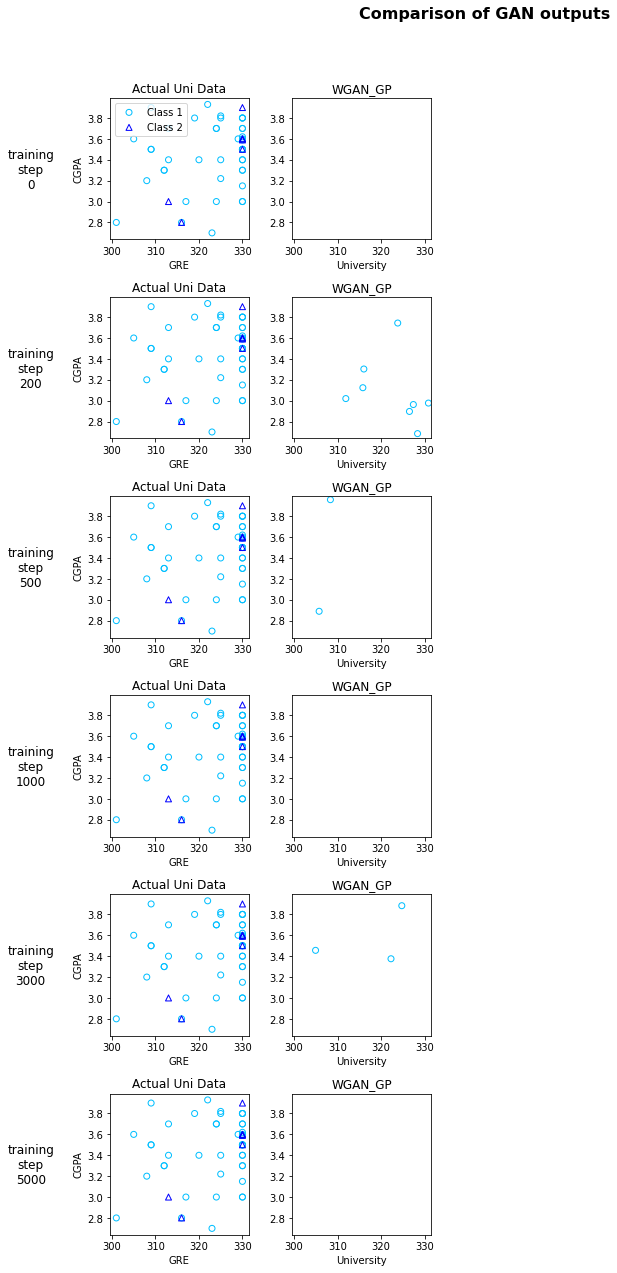

In [ ]:
# Setup parameters visualization parameters
seed = 17
test_size = 50 # number of fraud cases
noise_dim = 32

test_data=pd.DataFrame()

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer_3.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols+label_cols)
labels = fraud_w_classes['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'GRE', 'CGPA'

base_dir = 'cache/'

#Actual fraud data visualization
model_steps = [ 0, 200, 500,1000,3000,5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Uni Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            test_data = gen_samples
            gen_samples.to_csv('Rejects_WGANGP.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('WGANGP_Outputs.png')


In [ ]:
gen_df=pd.read_csv('Rejects_WGANGP.csv')
gen_df

,Unnamed: 0,University,CGPA,GRE,TOEFL,Work Experience,Research Experience,Research Papers,Submitted Portfolio,Student Status,THE Rank,QS Rank,Decision
0,0,3.335261,7.443276,348.45886,115.691910,6.066509,-1.908529,2.164974,2.637940,3.818486,38.327490,70.835660,1.303369
1,1,1.535390,6.737879,360.18670,109.581406,6.041248,-3.455761,-0.243252,5.390371,6.082695,191.605330,402.578640,1.534073
2,2,6.908302,8.499232,384.65060,136.533020,7.099571,-2.188537,2.070491,3.250827,3.728558,40.990665,79.890465,1.071427
3,3,0.420185,6.397426,283.98068,98.768720,6.464927,-3.003147,0.989602,5.379004,4.347172,409.795350,95.684395,2.415118
4,4,3.376138,6.061064,283.73672,99.496056,5.163176,-1.082202,1.379035,1.988734,3.056995,30.895600,58.673073,0.761323
5,5,-0.844313,10.191852,351.71350,113.866516,7.166398,-3.641031,2.455149,7.317398,4.612254,193.942180,395.395720,1.188383
6,6,5.137305,7.513601,358.21088,133.325090,7.169921,-2.892596,2.240889,2.814849,4.486550,72.806710,119.164375,0.871518
7,7,-2.247634,8.469159,342.82452,105.619260,6.057867,-1.861143,1.169675,5.777991,4.765339,187.920760,384.505000,1.461192
8,8,0.214142,7.655810,331.79514,107.153690,4.627796,-0.920476,1.593000,3.701508,4.576282,51.291176,76.230710,1.546113
9,9,-7.358768,9.785410,229.30096,67.300865,9.257115,-6.453501,2.031695,9.186374,5.792870,562.124000,620.156560,1.213566


In [ ]:
uni_bins=[0,1,2,3,4,5,6,7,8,9]
uni=gen_df.University
uni_array=np.digitize(np.array(uni), uni_bins)
uni_array

array([ 4,  2,  7,  1,  4,  0,  6,  0,  1,  0,  3,  2,  8,  0,  5,  8,  4,
       10,  3,  6,  4,  0,  7,  4,  3, 10,  6,  4,  4,  0,  7,  0,  0,  0,
        4,  0,  2,  0,  5,  9,  8,  8,  9,  6,  4,  0,  7,  7, 10,  0])

In [ ]:
uni_array=le5.inverse_transform(uni_array)
gen_df['University']=uni_array

In [ ]:
res_bins=[-1,2]
res=gen_df['Research Experience']
res_array=np.digitize(np.array(res), res_bins)
res_array

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0])

In [ ]:
gen_df['Research Experience']=res_array

In [ ]:
gen_df.to_csv('Rejects_WGANGP.csv')